In [2]:
#! /usr/bin/python3

__author__ = "Jun Hu <jh3846@columbia.edu"
__date__ = "Apr 10, 2018"

from collections import Counter
import pandas as pd
import numpy as np
import json
import logging

from keras.models import Sequential
import keras.backend as K
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasClassifier
from keras.utils import np_utils
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.model_selection import cross_val_score

from sklearn.model_selection import train_test_split
from keras.layers import Dropout

from keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
import matplotlib.dates as pltdt
%matplotlib inline

logger = logging.getLogger('etl')
logger.setLevel(logging.DEBUG)

ch = logging.StreamHandler()
ch.setLevel(logging.DEBUG)

formatter_c = logging.Formatter('[%(asctime)s]-[%(process)d]-[%(thread)d]-[%(name)s]-[%(lineno)s]-[%(levelname)s]: %(message)s')
ch.setFormatter(formatter_c)

logger.addHandler(ch)

Using TensorFlow backend.


In [3]:
with open("bcr_project_data.json") as f:
    data_origin = json.load(f)

df_origin = pd.DataFrame(data_origin)

In [4]:
df = df_origin
# df.head()

In [5]:
df.shape


(4241, 5)

In [6]:
# df.describe()


[2018-04-23 13:25:23,675]-[94370]-[140736241603456]-[etl]-[5]-[DEBUG]: (3816, 5)


[2018-04-23 13:25:23,677]-[94370]-[140736241603456]-[etl]-[6]-[DEBUG]: (425, 5)


In [6]:
# df.BCR[0][0][0]

In [7]:
# df.BCR[0][:5]

In [8]:
# df["BCR"][0][:5]

In [15]:
# def string2ngram(s, n):
#     return [s[i: i+n] for i in range(len(s) - n + 1)]
# 
# def string2ngram_skip1(s, n):
#     return [s[i: i+n: 2] for i in range(len(s) - n + 1)]
# 
# def string2ngram_skip2(s, n):
#     return [s[i: i+n: 3] for i in range(len(s) - n + 1)]

def string2ngram(s, n):
    res = ''
    for i in range(len(s) - n + 1):
        res += s[i: i+n] + ' '
    return res

def string2ngram_skip1(s, n):
    return [s[i: i+n: 2] for i in range(len(s) - n + 1)]

def string2ngram_skip2(s, n):
    return [s[i: i+n: 3] for i in range(len(s) - n + 1)]

logger.debug(string2ngram("GDSPPFFDYWGQG", 3))
logger.debug(string2ngram_skip1("GDSPPFFDYWGQG", 5))
logger.debug(string2ngram_skip2("GDSPPFFDYWGQG", 7))

Aliphatic = ['A', 'I', 'L', 'V']
Sulfur = ['C', 'M']
Hydroxyl = ['S', 'T']
Acidic = ['D', 'E']
Amide = ['N', 'Q']
Basic = ['R', 'H', 'K']

pc_dict = {}
for k in Aliphatic:
    pc_dict[k] = '1'
for k in Sulfur:
    pc_dict[k] = '2'
for k in Hydroxyl:
    pc_dict[k] = '3'
for k in Acidic:
    pc_dict[k] = '4'
for k in Amide:
    pc_dict[k] = '5'
for k in Basic:
    pc_dict[k] = '6'



def aa_class(s):
    for k in pc_dict:
        s = s.replace(k, pc_dict[k])
    return s

aa_class('ACSDNRPYWGFAMTEQHKcAAAAF')

[2018-04-23 13:43:11,278]-[94370]-[140736241603456]-[etl]-[22]-[DEBUG]: GDS DSP SPP PPF PFF FFD FDY DYW YWG WGQ GQG 


[2018-04-23 13:43:11,279]-[94370]-[140736241603456]-[etl]-[23]-[DEBUG]: ['GSP', 'DPF', 'SPF', 'PFD', 'PFY', 'FDW', 'FYG', 'DWQ', 'YGG']


[2018-04-23 13:43:11,280]-[94370]-[140736241603456]-[etl]-[24]-[DEBUG]: ['GPF', 'DPD', 'SFY', 'PFW', 'PDG', 'FYQ', 'FWG']


'123456PYWGF1234566c1111F'

In [8]:
df = df.merge(df.BCR.apply(lambda l: pd.Series({"cdr3aa": [str(ll[0]) for ll in l if str(ll[0]) != "nan"], "segmentV": [ll[1] for ll in l]})), left_index=True, right_index=True)

In [9]:
df.head()

,BCR,EVENT,OS,age,cancer,cdr3aa,segmentV
0,"[[DYWGQG, NA], [RSDDTAVYFC, NA], [GDSPPFFDYWGQ...",living,389,31.0,THCA,"[DYWGQG, RSDDTAVYFC, GDSPPFFDYWGQG, RSDDTAVYFC...","[NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, N..."
1,"[[YYCARGVV, NA], [YYCARVGYYYDSSDYP, NA], [FNHW...",living,482,74.0,LUSC,"[YYCARGVV, YYCARVGYYYDSSDYP, FNHWGQG, LDHWGQG,...","[NA, NA, IGHA1, IGHA1, IGHA1, IGHA1, IGHA1, IG..."
2,"[[REHSSSSWYFDYWGQG, NA], [YYCARHEDGQSK, NA], [...",living,3388,70.0,OV,"[REHSSSSWYFDYWGQG, YYCARHEDGQSK, KNYYFFDYWGQG,...","[NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, N..."
3,"[[DYYFDYWGQG, NA], [YYCAREPNGP, NA], [AYYYYGMD...",living,1419,82.0,COAD,"[DYYFDYWGQG, YYCAREPNGP, AYYYYGMDVWGQG, DTAVYY...","[NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, N..."
4,"[[YSSGSTLDYWGQG, IGHG3], [YYYGMDVWGQG, NA], [E...",living,726,55.0,THCA,"[YSSGSTLDYWGQG, YYYGMDVWGQG, ETNYYGMDVWGQG, YY...","[IGHG3, NA, NA, IGHA1, IGHA1, IGHG3, IGHA1, IG..."


In [12]:
df = df.drop(columns=['BCR'])
df.head()

,EVENT,OS,age,cancer,cdr3aa,segmentV
0,living,389,31.0,THCA,"[DYWGQG, RSDDTAVYFC, GDSPPFFDYWGQG, RSDDTAVYFC...","[NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, N..."
1,living,482,74.0,LUSC,"[YYCARGVV, YYCARVGYYYDSSDYP, FNHWGQG, LDHWGQG,...","[NA, NA, IGHA1, IGHA1, IGHA1, IGHA1, IGHA1, IG..."
2,living,3388,70.0,OV,"[REHSSSSWYFDYWGQG, YYCARHEDGQSK, KNYYFFDYWGQG,...","[NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, N..."
3,living,1419,82.0,COAD,"[DYYFDYWGQG, YYCAREPNGP, AYYYYGMDVWGQG, DTAVYY...","[NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, N..."
4,living,726,55.0,THCA,"[YSSGSTLDYWGQG, YYYGMDVWGQG, ETNYYGMDVWGQG, YY...","[IGHG3, NA, NA, IGHA1, IGHA1, IGHG3, IGHA1, IG..."


In [13]:
seed = 23
np.random.seed(23)
df_train, df_test = train_test_split(df, test_size=0.1)
logger.debug(df_train.shape)
logger.debug(df_test.shape)

cdr3aa_all = [aa for l in df.cdr3aa for aa in l]
logger.debug(len(cdr3aa_all))

cdr3aa_all_train = [aa for l in df_train.cdr3aa for aa in l]
logger.debug(len(cdr3aa_all_train))
logger.debug(len(set(cdr3aa_all_train)))

[2018-04-23 13:31:45,067]-[94370]-[140736241603456]-[etl]-[4]-[DEBUG]: (3816, 7)


[2018-04-23 13:31:45,068]-[94370]-[140736241603456]-[etl]-[5]-[DEBUG]: (425, 7)


[2018-04-23 13:31:46,578]-[94370]-[140736241603456]-[etl]-[8]-[DEBUG]: 12934656


[2018-04-23 13:31:47,662]-[94370]-[140736241603456]-[etl]-[11]-[DEBUG]: 11814570


[2018-04-23 13:31:50,855]-[94370]-[140736241603456]-[etl]-[12]-[DEBUG]: 5960182


In [18]:
# def list2ngram(l, n):
#     return [ngram for s in l for ngram in string2ngram(str(s), n)]
# 
# def list2ngram_skip1(l, n):
#     return [ngram for s in l for ngram in string2ngram_skip1(str(s), n)]
# 
# def list2ngram_skip2(l, n):
#     return [ngram for s in l for ngram in string2ngram_skip2(str(s), n)]

def list2ngram(l, n):
    res = ''
    for s in l:
        for ngram in string2ngram(str(s), n):
            res += ngram
    return res

def list2ngram_skip1(l, n):
    return [ngram for s in l for ngram in string2ngram_skip1(str(s), n)]

def list2ngram_skip2(l, n):
    return [ngram for s in l for ngram in string2ngram_skip2(str(s), n)]


list2ngram(["GDSPPFFDYWGQG", "eina;sldjhirmngviior"], 3)

'GDS DSP SPP PPF PFF FFD FDY DYW YWG WGQ GQG ein ina na; a;s ;sl sld ldj djh jhi hir irm rmn mng ngv gvi vii iio ior '

In [19]:
df["unigram_str"] = df.cdr3aa.map(lambda x: list2ngram(x, 1))
df["bigram_str"] = df.cdr3aa.map(lambda x: list2ngram(x, 2))
df["trigram_str"] = df.cdr3aa.map(lambda x: list2ngram(x, 3))
df["fivegram_skip1_str"] = df.cdr3aa.map(lambda x: list2ngram_skip1(x, 5))
df["sevengram_skip2_str"] = df.cdr3aa.map(lambda x: list2ngram_skip2(x, 7))

In [20]:
df.head()

,BCR,EVENT,OS,age,cancer,cdr3aa,segmentV,unigram_str,bigram_str,trigram_str,fivegram_skip1_str,sevengram_skip2_str
0,"[[DYWGQG, NA], [RSDDTAVYFC, NA], [GDSPPFFDYWGQ...",living,389,31.0,THCA,"[DYWGQG, RSDDTAVYFC, GDSPPFFDYWGQG, RSDDTAVYFC...","[NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, N...",D Y W G Q G R S D D T A V Y F C G D S P P F F ...,DY YW WG GQ QG RS SD DD DT TA AV VY YF FC GD D...,DYW YWG WGQ GQG RSD SDD DDT DTA TAV AVY VYF YF...,"[DWQ, YGG, RDT, SDA, DTV, DAY, TVF, AYC, GSP, ...","[RDV, STY, DAF, DVC, GPF, DPD, SFY, PFW, PDG, ..."
1,"[[YYCARGVV, NA], [YYCARVGYYYDSSDYP, NA], [FNHW...",living,482,74.0,LUSC,"[YYCARGVV, YYCARVGYYYDSSDYP, FNHWGQG, LDHWGQG,...","[NA, NA, IGHA1, IGHA1, IGHA1, IGHA1, IGHA1, IG...",Y Y C A R G V V Y Y C A R V G Y Y Y D S S D Y ...,YY YC CA AR RG GV VV YY YC CA AR RV VG GY YY Y...,YYC YCA CAR ARG RGV GVV YYC YCA CAR ARV RVG VG...,"[YCR, YAG, CRV, AGV, YCR, YAV, CRG, AVY, RGY, ...","[YAV, YRV, YAG, YRY, CVY, AGY, RYD, VYS, GYS, ..."
2,"[[REHSSSSWYFDYWGQG, NA], [YYCARHEDGQSK, NA], [...",living,3388,70.0,OV,"[REHSSSSWYFDYWGQG, YYCARHEDGQSK, KNYYFFDYWGQG,...","[NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, N...",R E H S S S S W Y F D Y W G Q G Y Y C A R H E ...,RE EH HS SS SS SS SW WY YF FD DY YW WG GQ QG Y...,REH EHS HSS SSS SSS SSW SWY WYF YFD FDY DYW YW...,"[RHS, ESS, HSS, SSW, SSY, SWF, SYD, WFY, YDW, ...","[RSS, ESW, HSY, SSF, SWD, SYY, SFW, WDG, YYQ, ..."
3,"[[DYYFDYWGQG, NA], [YYCAREPNGP, NA], [AYYYYGMD...",living,1419,82.0,COAD,"[DYYFDYWGQG, YYCAREPNGP, AYYYYGMDVWGQG, DTAVYY...","[NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, N...",D Y Y F D Y W G Q G Y Y C A R E P N G P A Y Y ...,DY YY YF FD DY YW WG GQ QG YY YC CA AR RE EP P...,DYY YYF YFD FDY DYW YWG WGQ GQG YYC YCA CAR AR...,"[DYD, YFY, YDW, FYG, DWQ, YGG, YCR, YAE, CRP, ...","[DFW, YDG, YYQ, FWG, YAP, YRN, CEG, APP, AYM, ..."
4,"[[YSSGSTLDYWGQG, IGHG3], [YYYGMDVWGQG, NA], [E...",living,726,55.0,THCA,"[YSSGSTLDYWGQG, YYYGMDVWGQG, ETNYYGMDVWGQG, YY...","[IGHG3, NA, NA, IGHA1, IGHA1, IGHG3, IGHA1, IG...",Y S S G S T L D Y W G Q G Y Y Y G M D V W G Q ...,YS SS SG GS ST TL LD DY YW WG GQ QG YY YY YG G...,YSS SSG SGS GST STL TLD LDY DYW YWG WGQ GQG YY...,"[YSS, SGT, SSL, GTD, SLY, TDW, LYG, DWQ, YGG, ...","[YGL, SSD, STY, GLW, SDG, TYQ, LWG, YGV, YMW, ..."


In [34]:
df["fourgram_str"] = df.cdr3aa.map(lambda x: list2ngram(x, 4))
df["fivegram_str"] = df.cdr3aa.map(lambda x: list2ngram(x, 5))
df["sixgram_str"] = df.cdr3aa.map(lambda x: list2ngram(x, 6))


In [35]:
df['gram_str_all'] = df.unigram_str + df.bigram_str + df.trigram_str + df.fourgram_str + df.fivegram_str + df.sixgram_str
df['gram_str_all'][0]

'D Y W G Q G R S D D T A V Y F C G D S P P F F D Y W G Q G R S D D T A V Y F C A R S C A N A F D V W G Q G Y Y C A R L F N W N R A F H Y Y N Y I D V V Y C C A R K Y S G T Y Y D T S K N Q F S L N L T S Y Y C A R D T G Y G W R A W F D P W G Q G P P G W F D P W G Q G Y Y C A R E Y Y C A K R A S G K S W Y Y C A R Q S Y Y C A R D Y Y C A R D Q H N L Y Y C A R V D D H Y Y C A S K Y C Y Y C A R D Q N H Y G S Y Y C A R G G R Y G E Y Y C A R S Y R L I A R S D D T A V Y F C Y Y C A K D L Y Y C A R L F N W N R A F H Y Y N Y I D V W G K G V Y C C A R K Y S G T Y Y D T S K N Q F S L N L T S G N F D S W G Q G Y Y C A R T T Y Y L D S T Y Y C A R D Q Y Y C A R D G S R D Y W G Q G G D S P P F F D Y W G Q G G D S P P F F D Y W G Q G Y Y C A K D A R T R S L Y Y C A R S D A D V V V S A G Y Y C A R I T S G W G S S G W R Y F D Y W G Q G V R C H H Y H M D V W G K G F D M W G Q G Y Y C A R D Q S R G Y Y L E R H T S P F D D Y W G Q G Y Y C A T Y C T V S A Y H Y I G V W G K G Y Y C T R G S Y C G G D C F D L D E

In [36]:
from sklearn.feature_extraction.text import TfidfVectorizer

# vec = TfidfVectorizer(max_features=100)
vec = TfidfVectorizer()
tfidf_mat = vec.fit_transform(df['gram_str_all']).toarray()


In [31]:
logger.debug(type(tfidf_mat)) 
logger.debug(tfidf_mat.shape)

[2018-04-23 14:51:37,977]-[94370]-[140736241603456]-[etl]-[1]-[DEBUG]: <class 'numpy.ndarray'>


[2018-04-23 14:51:37,979]-[94370]-[140736241603456]-[etl]-[2]-[DEBUG]: (4241, 8400)


In [32]:
X = tfidf_mat
Y = np.array(list(df.cancer))
logger.debug(X)
logger.debug(Y)

Y_cnt = Counter(Y)
logger.debug(Y_cnt)
Y_freq = [float(Y_cnt[y]) / sum(Y_cnt.values()) for y in Y_cnt]
logger.debug(Y_freq)
encoder = LabelEncoder()
encoder.fit(Y)
encoder_Y = encoder.transform(Y)
logger.debug(encoder_Y)
dummy_y = np_utils.to_categorical(encoder_Y)
logger.debug(dummy_y)

X_train, X_test, y_train, y_test = train_test_split(X, dummy_y, test_size=0.2, random_state=23)
len(X_train[0])


[2018-04-23 14:52:07,365]-[94370]-[140736241603456]-[etl]-[3]-[DEBUG]: [[0.         0.         0.         ... 0.         0.         0.        ]
 [0.02429569 0.00568998 0.         ... 0.         0.00217166 0.04122776]
 [0.02672309 0.         0.         ... 0.         0.         0.07732759]
 ...
 [0.04182588 0.01362531 0.         ... 0.00091124 0.00079644 0.01291499]
 [0.01362371 0.         0.         ... 0.00789523 0.         0.02456319]
 [0.02952089 0.00645279 0.00050565 ... 0.0017108  0.00373817 0.02247294]]


[2018-04-23 14:52:07,367]-[94370]-[140736241603456]-[etl]-[4]-[DEBUG]: ['THCA' 'LUSC' 'OV' ... 'LUAD' 'SKCM' 'SKCM']


[2018-04-23 14:52:07,371]-[94370]-[140736241603456]-[etl]-[7]-[DEBUG]: Counter({'KIRC': 430, 'LUSC': 397, 'LUAD': 386, 'PRAD': 375, 'OV': 362, 'THCA': 349, 'HNSC': 336, 'STAD': 322, 'BRCA': 317, 'SKCM': 312, 'BLCA': 302, 'COAD': 262, 'READ': 91})


[2018-04-23 14:52:07,372]-[94370]-[140736241603456]-[etl]-[9]-[DEBUG]: [0.08229191228483848, 0.09360999764206555, 0.08535722706908748, 0.06177788257486442, 0.07120962037255364, 0.07922659750058948, 0.09101626974770101, 0.07356755482197595, 0.10139118132515916, 0.07474652204668711, 0.08842254185333648, 0.07592548927139825, 0.021457203489742987]


[2018-04-23 14:52:07,375]-[94370]-[140736241603456]-[etl]-[13]-[DEBUG]: [12  6  7 ...  5 10 10]


[2018-04-23 14:52:07,377]-[94370]-[140736241603456]-[etl]-[15]-[DEBUG]: [[0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 1. 0. 0.]
 [0. 0. 0. ... 1. 0. 0.]]


8400

Epoch 1/300


 798/3392 [======>.......................] - ETA: 9s - loss: 2.5645 - acc: 0.0940

1596/3392 [=============>................] - ETA: 4s - loss: 2.5529 - acc: 0.0808

2394/3392 [====================>.........] - ETA: 2s - loss: 2.5482 - acc: 0.0898

3192/3392 [===========================>..] - ETA: 0s - loss: 2.5426 - acc: 0.0909

3392/3392 [==============================] - 7s 2ms/step - loss: 2.5391 - acc: 0.0935


Epoch 2/300


 798/3392 [======>.......................] - ETA: 3s - loss: 2.5027 - acc: 0.1078

1596/3392 [=============>................] - ETA: 2s - loss: 2.5051 - acc: 0.1234

2394/3392 [====================>.........] - ETA: 1s - loss: 2.4956 - acc: 0.1128

3192/3392 [===========================>..] - ETA: 0s - loss: 2.4854 - acc: 0.1331

3392/3392 [==============================] - 5s 1ms/step - loss: 2.4802 - acc: 0.1368


Epoch 3/300


 798/3392 [======>.......................] - ETA: 3s - loss: 2.4214 - acc: 0.1566

1596/3392 [=============>................] - ETA: 2s - loss: 2.4006 - acc: 0.1698

2394/3392 [====================>.........] - ETA: 1s - loss: 2.3828 - acc: 0.1921

3192/3392 [===========================>..] - ETA: 0s - loss: 2.3572 - acc: 0.2049

3392/3392 [==============================] - 4s 1ms/step - loss: 2.3498 - acc: 0.2049


Epoch 4/300


 798/3392 [======>.......................] - ETA: 3s - loss: 2.2332 - acc: 0.2569

1596/3392 [=============>................] - ETA: 2s - loss: 2.2067 - acc: 0.2450

2394/3392 [====================>.........] - ETA: 1s - loss: 2.1972 - acc: 0.2444

3192/3392 [===========================>..] - ETA: 0s - loss: 2.1761 - acc: 0.2513

3392/3392 [==============================] - 4s 1ms/step - loss: 2.1715 - acc: 0.2538


Epoch 5/300


 798/3392 [======>.......................] - ETA: 3s - loss: 2.1243 - acc: 0.2807

1596/3392 [=============>................] - ETA: 2s - loss: 2.0871 - acc: 0.2657

2394/3392 [====================>.........] - ETA: 1s - loss: 2.0825 - acc: 0.2523

3192/3392 [===========================>..] - ETA: 0s - loss: 2.0598 - acc: 0.2607

3392/3392 [==============================] - 4s 1ms/step - loss: 2.0538 - acc: 0.2662


Epoch 6/300


 798/3392 [======>.......................] - ETA: 3s - loss: 1.9692 - acc: 0.3409

1596/3392 [=============>................] - ETA: 2s - loss: 1.9485 - acc: 0.3534

2394/3392 [====================>.........] - ETA: 1s - loss: 1.9555 - acc: 0.3622

3192/3392 [===========================>..] - ETA: 0s - loss: 1.9575 - acc: 0.3487

3392/3392 [==============================] - 4s 1ms/step - loss: 1.9530 - acc: 0.3496


Epoch 7/300


 798/3392 [======>.......................] - ETA: 3s - loss: 1.9053 - acc: 0.3571

1596/3392 [=============>................] - ETA: 2s - loss: 1.8953 - acc: 0.3546

2394/3392 [====================>.........] - ETA: 1s - loss: 1.8658 - acc: 0.3693

3192/3392 [===========================>..] - ETA: 0s - loss: 1.8614 - acc: 0.3662

3392/3392 [==============================] - 4s 1ms/step - loss: 1.8580 - acc: 0.3673


Epoch 8/300


 798/3392 [======>.......................] - ETA: 3s - loss: 1.8134 - acc: 0.3195

1596/3392 [=============>................] - ETA: 2s - loss: 1.7723 - acc: 0.3885

2394/3392 [====================>.........] - ETA: 1s - loss: 1.7617 - acc: 0.4160

3192/3392 [===========================>..] - ETA: 0s - loss: 1.7542 - acc: 0.4135

3392/3392 [==============================] - 4s 1ms/step - loss: 1.7525 - acc: 0.4127


Epoch 9/300


 798/3392 [======>.......................] - ETA: 3s - loss: 1.6208 - acc: 0.4900

1596/3392 [=============>................] - ETA: 2s - loss: 1.6503 - acc: 0.4831

2394/3392 [====================>.........] - ETA: 1s - loss: 1.6279 - acc: 0.4795

3192/3392 [===========================>..] - ETA: 0s - loss: 1.6189 - acc: 0.4868

3392/3392 [==============================] - 4s 1ms/step - loss: 1.6154 - acc: 0.4879


Epoch 10/300


 798/3392 [======>.......................] - ETA: 3s - loss: 1.5734 - acc: 0.4549

1596/3392 [=============>................] - ETA: 2s - loss: 1.5541 - acc: 0.4737

2394/3392 [====================>.........] - ETA: 1s - loss: 1.5255 - acc: 0.4887

3192/3392 [===========================>..] - ETA: 0s - loss: 1.5132 - acc: 0.4940

3392/3392 [==============================] - 4s 1ms/step - loss: 1.5101 - acc: 0.4973


Epoch 11/300


 798/3392 [======>.......................] - ETA: 3s - loss: 1.5029 - acc: 0.4461

1596/3392 [=============>................] - ETA: 2s - loss: 1.4386 - acc: 0.5175

2394/3392 [====================>.........] - ETA: 1s - loss: 1.4376 - acc: 0.5238

3192/3392 [===========================>..] - ETA: 0s - loss: 1.4015 - acc: 0.5536

3392/3392 [==============================] - 4s 1ms/step - loss: 1.3989 - acc: 0.5551


Epoch 12/300


 798/3392 [======>.......................] - ETA: 3s - loss: 1.3213 - acc: 0.5614

1596/3392 [=============>................] - ETA: 2s - loss: 1.3056 - acc: 0.5683

2394/3392 [====================>.........] - ETA: 1s - loss: 1.2915 - acc: 0.5873

3192/3392 [===========================>..] - ETA: 0s - loss: 1.2902 - acc: 0.5846

3392/3392 [==============================] - 4s 1ms/step - loss: 1.2988 - acc: 0.5796


Epoch 13/300


 798/3392 [======>.......................] - ETA: 3s - loss: 1.2120 - acc: 0.6566

1596/3392 [=============>................] - ETA: 2s - loss: 1.2254 - acc: 0.6510

2394/3392 [====================>.........] - ETA: 1s - loss: 1.2211 - acc: 0.6462

3192/3392 [===========================>..] - ETA: 0s - loss: 1.1809 - acc: 0.6638

3392/3392 [==============================] - 5s 1ms/step - loss: 1.1726 - acc: 0.6669


Epoch 14/300


 798/3392 [======>.......................] - ETA: 10s - loss: 1.0801 - acc: 0.6842

1596/3392 [=============>................] - ETA: 5s - loss: 1.0728 - acc: 0.7043 

2394/3392 [====================>.........] - ETA: 2s - loss: 1.0494 - acc: 0.6955

3192/3392 [===========================>..] - ETA: 0s - loss: 1.0287 - acc: 0.7055

3392/3392 [==============================] - 7s 2ms/step - loss: 1.0261 - acc: 0.7061


Epoch 15/300


 798/3392 [======>.......................] - ETA: 3s - loss: 0.9730 - acc: 0.7444

1596/3392 [=============>................] - ETA: 2s - loss: 0.9279 - acc: 0.7625

2394/3392 [====================>.........] - ETA: 1s - loss: 0.9182 - acc: 0.7573

3192/3392 [===========================>..] - ETA: 0s - loss: 0.9045 - acc: 0.7607

3392/3392 [==============================] - 5s 1ms/step - loss: 0.8951 - acc: 0.7656


Epoch 16/300


 798/3392 [======>.......................] - ETA: 4s - loss: 0.8712 - acc: 0.7857

1596/3392 [=============>................] - ETA: 2s - loss: 0.8173 - acc: 0.8026

2394/3392 [====================>.........] - ETA: 1s - loss: 0.7973 - acc: 0.8058

3192/3392 [===========================>..] - ETA: 0s - loss: 0.7913 - acc: 0.8083

3392/3392 [==============================] - 5s 1ms/step - loss: 0.7919 - acc: 0.8066


Epoch 17/300


 798/3392 [======>.......................] - ETA: 3s - loss: 0.7136 - acc: 0.8070

1596/3392 [=============>................] - ETA: 2s - loss: 0.7229 - acc: 0.8127

2394/3392 [====================>.........] - ETA: 1s - loss: 0.7147 - acc: 0.8250

3192/3392 [===========================>..] - ETA: 0s - loss: 0.7046 - acc: 0.8305

3392/3392 [==============================] - 4s 1ms/step - loss: 0.6981 - acc: 0.8331


Epoch 18/300


 798/3392 [======>.......................] - ETA: 3s - loss: 0.6132 - acc: 0.8747

1596/3392 [=============>................] - ETA: 2s - loss: 0.6208 - acc: 0.8609

2394/3392 [====================>.........] - ETA: 1s - loss: 0.6223 - acc: 0.8551

3192/3392 [===========================>..] - ETA: 0s - loss: 0.6079 - acc: 0.8622

3392/3392 [==============================] - 5s 1ms/step - loss: 0.6018 - acc: 0.8650


Epoch 19/300


 798/3392 [======>.......................] - ETA: 3s - loss: 0.5569 - acc: 0.8634

1596/3392 [=============>................] - ETA: 2s - loss: 0.5428 - acc: 0.8728

2394/3392 [====================>.........] - ETA: 1s - loss: 0.5281 - acc: 0.8755

3192/3392 [===========================>..] - ETA: 0s - loss: 0.5392 - acc: 0.8716

3392/3392 [==============================] - 4s 1ms/step - loss: 0.5380 - acc: 0.8697


Epoch 20/300


 798/3392 [======>.......................] - ETA: 3s - loss: 0.4799 - acc: 0.8784

1596/3392 [=============>................] - ETA: 2s - loss: 0.4796 - acc: 0.8891

2394/3392 [====================>.........] - ETA: 1s - loss: 0.4696 - acc: 0.8918

3192/3392 [===========================>..] - ETA: 0s - loss: 0.4627 - acc: 0.8944

3392/3392 [==============================] - 4s 1ms/step - loss: 0.4609 - acc: 0.8953


Epoch 21/300


 798/3392 [======>.......................] - ETA: 3s - loss: 0.4092 - acc: 0.9211

1596/3392 [=============>................] - ETA: 3s - loss: 0.4070 - acc: 0.9179

2394/3392 [====================>.........] - ETA: 1s - loss: 0.3989 - acc: 0.9165

3192/3392 [===========================>..] - ETA: 0s - loss: 0.3911 - acc: 0.9151

3392/3392 [==============================] - 5s 2ms/step - loss: 0.3891 - acc: 0.9169


Epoch 22/300


 798/3392 [======>.......................] - ETA: 3s - loss: 0.3519 - acc: 0.9311

1596/3392 [=============>................] - ETA: 2s - loss: 0.3414 - acc: 0.9330

2394/3392 [====================>.........] - ETA: 1s - loss: 0.3298 - acc: 0.9382

3192/3392 [===========================>..] - ETA: 0s - loss: 0.3236 - acc: 0.9395

3392/3392 [==============================] - 5s 1ms/step - loss: 0.3259 - acc: 0.9393


Epoch 23/300


 798/3392 [======>.......................] - ETA: 3s - loss: 0.2784 - acc: 0.9561

1596/3392 [=============>................] - ETA: 2s - loss: 0.2847 - acc: 0.9543

2394/3392 [====================>.........] - ETA: 1s - loss: 0.2839 - acc: 0.9490

3192/3392 [===========================>..] - ETA: 0s - loss: 0.2761 - acc: 0.9514

3392/3392 [==============================] - 5s 2ms/step - loss: 0.2726 - acc: 0.9525


Epoch 24/300


 798/3392 [======>.......................] - ETA: 3s - loss: 0.2517 - acc: 0.9624

1596/3392 [=============>................] - ETA: 2s - loss: 0.2385 - acc: 0.9605

2394/3392 [====================>.........] - ETA: 1s - loss: 0.2268 - acc: 0.9641

3192/3392 [===========================>..] - ETA: 0s - loss: 0.2366 - acc: 0.9571

3392/3392 [==============================] - 5s 2ms/step - loss: 0.2334 - acc: 0.9590


Epoch 25/300


 798/3392 [======>.......................] - ETA: 3s - loss: 0.2209 - acc: 0.9549

1596/3392 [=============>................] - ETA: 2s - loss: 0.2018 - acc: 0.9649

2394/3392 [====================>.........] - ETA: 1s - loss: 0.1949 - acc: 0.9683

3192/3392 [===========================>..] - ETA: 0s - loss: 0.1983 - acc: 0.9674

3392/3392 [==============================] - 5s 1ms/step - loss: 0.1989 - acc: 0.9667


Epoch 26/300


 798/3392 [======>.......................] - ETA: 3s - loss: 0.1883 - acc: 0.9637

1596/3392 [=============>................] - ETA: 2s - loss: 0.1807 - acc: 0.9674

2394/3392 [====================>.........] - ETA: 1s - loss: 0.1763 - acc: 0.9699

3192/3392 [===========================>..] - ETA: 0s - loss: 0.1709 - acc: 0.9718

3392/3392 [==============================] - 5s 1ms/step - loss: 0.1693 - acc: 0.9726


Epoch 27/300


 798/3392 [======>.......................] - ETA: 3s - loss: 0.1837 - acc: 0.9461

1596/3392 [=============>................] - ETA: 2s - loss: 0.1675 - acc: 0.9593

2394/3392 [====================>.........] - ETA: 1s - loss: 0.1652 - acc: 0.9632

3192/3392 [===========================>..] - ETA: 0s - loss: 0.1585 - acc: 0.9693

3392/3392 [==============================] - 5s 1ms/step - loss: 0.1564 - acc: 0.9705


Epoch 28/300


 798/3392 [======>.......................] - ETA: 3s - loss: 0.1274 - acc: 0.9774

1596/3392 [=============>................] - ETA: 2s - loss: 0.1302 - acc: 0.9799

2394/3392 [====================>.........] - ETA: 1s - loss: 0.1287 - acc: 0.9812

3192/3392 [===========================>..] - ETA: 0s - loss: 0.1225 - acc: 0.9825

3392/3392 [==============================] - 5s 1ms/step - loss: 0.1208 - acc: 0.9832


Epoch 29/300


 798/3392 [======>.......................] - ETA: 3s - loss: 0.1046 - acc: 0.9925

1596/3392 [=============>................] - ETA: 2s - loss: 0.1033 - acc: 0.9906

2394/3392 [====================>.........] - ETA: 1s - loss: 0.1043 - acc: 0.9891

3192/3392 [===========================>..] - ETA: 0s - loss: 0.1019 - acc: 0.9890

3392/3392 [==============================] - 4s 1ms/step - loss: 0.1000 - acc: 0.9894


Epoch 30/300


 798/3392 [======>.......................] - ETA: 3s - loss: 0.1057 - acc: 0.9812

1596/3392 [=============>................] - ETA: 2s - loss: 0.0966 - acc: 0.9875

2394/3392 [====================>.........] - ETA: 1s - loss: 0.0928 - acc: 0.9896

3192/3392 [===========================>..] - ETA: 0s - loss: 0.0893 - acc: 0.9903

3392/3392 [==============================] - 4s 1ms/step - loss: 0.0903 - acc: 0.9906


Epoch 31/300


 798/3392 [======>.......................] - ETA: 3s - loss: 0.0754 - acc: 0.9937

1596/3392 [=============>................] - ETA: 2s - loss: 0.0795 - acc: 0.9906

2394/3392 [====================>.........] - ETA: 1s - loss: 0.0787 - acc: 0.9908

3192/3392 [===========================>..] - ETA: 0s - loss: 0.0774 - acc: 0.9912

3392/3392 [==============================] - 4s 1ms/step - loss: 0.0780 - acc: 0.9909


Epoch 32/300


 798/3392 [======>.......................] - ETA: 3s - loss: 0.0787 - acc: 0.9887

1596/3392 [=============>................] - ETA: 2s - loss: 0.0773 - acc: 0.9881

2394/3392 [====================>.........] - ETA: 1s - loss: 0.0729 - acc: 0.9900

3192/3392 [===========================>..] - ETA: 0s - loss: 0.0790 - acc: 0.9878

3392/3392 [==============================] - 4s 1ms/step - loss: 0.0765 - acc: 0.9885


Epoch 33/300


 798/3392 [======>.......................] - ETA: 3s - loss: 0.0481 - acc: 0.9987

1596/3392 [=============>................] - ETA: 2s - loss: 0.0602 - acc: 0.9944

2394/3392 [====================>.........] - ETA: 1s - loss: 0.0595 - acc: 0.9937

3192/3392 [===========================>..] - ETA: 0s - loss: 0.0613 - acc: 0.9940

3392/3392 [==============================] - 4s 1ms/step - loss: 0.0610 - acc: 0.9941


Epoch 34/300


 798/3392 [======>.......................] - ETA: 3s - loss: 0.0506 - acc: 1.0000

1596/3392 [=============>................] - ETA: 2s - loss: 0.0517 - acc: 0.9987

2394/3392 [====================>.........] - ETA: 1s - loss: 0.0506 - acc: 0.9967

3192/3392 [===========================>..] - ETA: 0s - loss: 0.0505 - acc: 0.9969

3392/3392 [==============================] - 4s 1ms/step - loss: 0.0508 - acc: 0.9968


Epoch 35/300


 798/3392 [======>.......................] - ETA: 3s - loss: 0.0430 - acc: 0.9950

1596/3392 [=============>................] - ETA: 2s - loss: 0.0480 - acc: 0.9950

2394/3392 [====================>.........] - ETA: 1s - loss: 0.0482 - acc: 0.9954

3192/3392 [===========================>..] - ETA: 0s - loss: 0.0458 - acc: 0.9962

3392/3392 [==============================] - 4s 1ms/step - loss: 0.0453 - acc: 0.9965


Epoch 36/300


 798/3392 [======>.......................] - ETA: 3s - loss: 0.0435 - acc: 0.9975

1596/3392 [=============>................] - ETA: 2s - loss: 0.0378 - acc: 0.9981

2394/3392 [====================>.........] - ETA: 1s - loss: 0.0389 - acc: 0.9987

3192/3392 [===========================>..] - ETA: 0s - loss: 0.0377 - acc: 0.9984

3392/3392 [==============================] - 4s 1ms/step - loss: 0.0378 - acc: 0.9982


Epoch 37/300


 798/3392 [======>.......................] - ETA: 3s - loss: 0.0392 - acc: 1.0000

1596/3392 [=============>................] - ETA: 2s - loss: 0.0390 - acc: 0.9987

2394/3392 [====================>.........] - ETA: 1s - loss: 0.0354 - acc: 0.9992

3192/3392 [===========================>..] - ETA: 0s - loss: 0.0356 - acc: 0.9991

3392/3392 [==============================] - 4s 1ms/step - loss: 0.0362 - acc: 0.9988


Epoch 38/300


 798/3392 [======>.......................] - ETA: 3s - loss: 0.0317 - acc: 0.9987

1596/3392 [=============>................] - ETA: 2s - loss: 0.0317 - acc: 0.9994

2394/3392 [====================>.........] - ETA: 1s - loss: 0.0302 - acc: 0.9996

3192/3392 [===========================>..] - ETA: 0s - loss: 0.0293 - acc: 0.9994

3392/3392 [==============================] - 4s 1ms/step - loss: 0.0294 - acc: 0.9994


Epoch 39/300


 798/3392 [======>.......................] - ETA: 3s - loss: 0.0248 - acc: 1.0000

1596/3392 [=============>................] - ETA: 2s - loss: 0.0255 - acc: 1.0000

2394/3392 [====================>.........] - ETA: 1s - loss: 0.0260 - acc: 0.9992

3192/3392 [===========================>..] - ETA: 0s - loss: 0.0259 - acc: 0.9994

3392/3392 [==============================] - 4s 1ms/step - loss: 0.0257 - acc: 0.9991


Epoch 40/300


 798/3392 [======>.......................] - ETA: 3s - loss: 0.0240 - acc: 1.0000

1596/3392 [=============>................] - ETA: 2s - loss: 0.0241 - acc: 1.0000

2394/3392 [====================>.........] - ETA: 1s - loss: 0.0229 - acc: 1.0000

3192/3392 [===========================>..] - ETA: 0s - loss: 0.0233 - acc: 1.0000

3392/3392 [==============================] - 4s 1ms/step - loss: 0.0228 - acc: 1.0000


Epoch 41/300


 798/3392 [======>.......................] - ETA: 3s - loss: 0.0211 - acc: 1.0000

1596/3392 [=============>................] - ETA: 2s - loss: 0.0207 - acc: 1.0000

2394/3392 [====================>.........] - ETA: 1s - loss: 0.0206 - acc: 1.0000

3192/3392 [===========================>..] - ETA: 0s - loss: 0.0198 - acc: 1.0000

3392/3392 [==============================] - 4s 1ms/step - loss: 0.0201 - acc: 1.0000


Epoch 42/300


 798/3392 [======>.......................] - ETA: 3s - loss: 0.0184 - acc: 1.0000

1596/3392 [=============>................] - ETA: 2s - loss: 0.0179 - acc: 1.0000

2394/3392 [====================>.........] - ETA: 1s - loss: 0.0187 - acc: 1.0000

3192/3392 [===========================>..] - ETA: 0s - loss: 0.0186 - acc: 1.0000

3392/3392 [==============================] - 4s 1ms/step - loss: 0.0187 - acc: 1.0000


Epoch 43/300


 798/3392 [======>.......................] - ETA: 3s - loss: 0.0177 - acc: 1.0000

1596/3392 [=============>................] - ETA: 2s - loss: 0.0182 - acc: 1.0000

2394/3392 [====================>.........] - ETA: 1s - loss: 0.0177 - acc: 1.0000

3192/3392 [===========================>..] - ETA: 0s - loss: 0.0169 - acc: 1.0000

3392/3392 [==============================] - 4s 1ms/step - loss: 0.0169 - acc: 1.0000


Epoch 44/300


 798/3392 [======>.......................] - ETA: 3s - loss: 0.0163 - acc: 1.0000

1596/3392 [=============>................] - ETA: 2s - loss: 0.0144 - acc: 1.0000

2394/3392 [====================>.........] - ETA: 1s - loss: 0.0140 - acc: 1.0000

3192/3392 [===========================>..] - ETA: 0s - loss: 0.0146 - acc: 1.0000

3392/3392 [==============================] - 4s 1ms/step - loss: 0.0147 - acc: 1.0000


Epoch 45/300


 798/3392 [======>.......................] - ETA: 3s - loss: 0.0137 - acc: 1.0000

1596/3392 [=============>................] - ETA: 2s - loss: 0.0135 - acc: 1.0000

2394/3392 [====================>.........] - ETA: 1s - loss: 0.0136 - acc: 1.0000

3192/3392 [===========================>..] - ETA: 0s - loss: 0.0132 - acc: 1.0000

3392/3392 [==============================] - 4s 1ms/step - loss: 0.0132 - acc: 1.0000


Epoch 46/300


 798/3392 [======>.......................] - ETA: 3s - loss: 0.0121 - acc: 1.0000

1596/3392 [=============>................] - ETA: 2s - loss: 0.0120 - acc: 1.0000

2394/3392 [====================>.........] - ETA: 1s - loss: 0.0124 - acc: 1.0000

3192/3392 [===========================>..] - ETA: 0s - loss: 0.0121 - acc: 1.0000

3392/3392 [==============================] - 4s 1ms/step - loss: 0.0121 - acc: 1.0000


Epoch 47/300


 798/3392 [======>.......................] - ETA: 3s - loss: 0.0132 - acc: 1.0000

1596/3392 [=============>................] - ETA: 2s - loss: 0.0119 - acc: 1.0000

2394/3392 [====================>.........] - ETA: 1s - loss: 0.0114 - acc: 1.0000

3192/3392 [===========================>..] - ETA: 0s - loss: 0.0117 - acc: 1.0000

3392/3392 [==============================] - 4s 1ms/step - loss: 0.0116 - acc: 1.0000


Epoch 48/300


 798/3392 [======>.......................] - ETA: 3s - loss: 0.0102 - acc: 1.0000

1596/3392 [=============>................] - ETA: 2s - loss: 0.0104 - acc: 1.0000

2394/3392 [====================>.........] - ETA: 1s - loss: 0.0104 - acc: 1.0000

3192/3392 [===========================>..] - ETA: 0s - loss: 0.0103 - acc: 1.0000

3392/3392 [==============================] - 4s 1ms/step - loss: 0.0103 - acc: 1.0000


Epoch 49/300


 798/3392 [======>.......................] - ETA: 3s - loss: 0.0097 - acc: 1.0000

1596/3392 [=============>................] - ETA: 2s - loss: 0.0093 - acc: 1.0000

2394/3392 [====================>.........] - ETA: 1s - loss: 0.0093 - acc: 1.0000

3192/3392 [===========================>..] - ETA: 0s - loss: 0.0094 - acc: 1.0000

3392/3392 [==============================] - 4s 1ms/step - loss: 0.0095 - acc: 1.0000


Epoch 50/300


 798/3392 [======>.......................] - ETA: 3s - loss: 0.0090 - acc: 1.0000

1596/3392 [=============>................] - ETA: 2s - loss: 0.0099 - acc: 1.0000

2394/3392 [====================>.........] - ETA: 1s - loss: 0.0096 - acc: 1.0000

3192/3392 [===========================>..] - ETA: 0s - loss: 0.0091 - acc: 1.0000

3392/3392 [==============================] - 4s 1ms/step - loss: 0.0090 - acc: 1.0000


Epoch 51/300


 798/3392 [======>.......................] - ETA: 3s - loss: 0.0085 - acc: 1.0000

1596/3392 [=============>................] - ETA: 2s - loss: 0.0083 - acc: 1.0000

2394/3392 [====================>.........] - ETA: 1s - loss: 0.0082 - acc: 1.0000

3192/3392 [===========================>..] - ETA: 0s - loss: 0.0084 - acc: 1.0000

3392/3392 [==============================] - 4s 1ms/step - loss: 0.0084 - acc: 1.0000


Epoch 52/300


 798/3392 [======>.......................] - ETA: 3s - loss: 0.0079 - acc: 1.0000

1596/3392 [=============>................] - ETA: 2s - loss: 0.0081 - acc: 1.0000

2394/3392 [====================>.........] - ETA: 1s - loss: 0.0081 - acc: 1.0000

3192/3392 [===========================>..] - ETA: 0s - loss: 0.0079 - acc: 1.0000

3392/3392 [==============================] - 4s 1ms/step - loss: 0.0079 - acc: 1.0000


Epoch 53/300


 798/3392 [======>.......................] - ETA: 3s - loss: 0.0075 - acc: 1.0000

1596/3392 [=============>................] - ETA: 2s - loss: 0.0075 - acc: 1.0000

2394/3392 [====================>.........] - ETA: 1s - loss: 0.0074 - acc: 1.0000

3192/3392 [===========================>..] - ETA: 0s - loss: 0.0074 - acc: 1.0000

3392/3392 [==============================] - 4s 1ms/step - loss: 0.0074 - acc: 1.0000


Epoch 54/300


 798/3392 [======>.......................] - ETA: 3s - loss: 0.0071 - acc: 1.0000

1596/3392 [=============>................] - ETA: 2s - loss: 0.0069 - acc: 1.0000

2394/3392 [====================>.........] - ETA: 1s - loss: 0.0069 - acc: 1.0000

3192/3392 [===========================>..] - ETA: 0s - loss: 0.0069 - acc: 1.0000

3392/3392 [==============================] - 4s 1ms/step - loss: 0.0069 - acc: 1.0000


Epoch 55/300


 798/3392 [======>.......................] - ETA: 3s - loss: 0.0062 - acc: 1.0000

1596/3392 [=============>................] - ETA: 2s - loss: 0.0064 - acc: 1.0000

2394/3392 [====================>.........] - ETA: 1s - loss: 0.0065 - acc: 1.0000

3192/3392 [===========================>..] - ETA: 0s - loss: 0.0066 - acc: 1.0000

3392/3392 [==============================] - 4s 1ms/step - loss: 0.0066 - acc: 1.0000


Epoch 56/300


 798/3392 [======>.......................] - ETA: 3s - loss: 0.0060 - acc: 1.0000

1596/3392 [=============>................] - ETA: 2s - loss: 0.0063 - acc: 1.0000

2394/3392 [====================>.........] - ETA: 1s - loss: 0.0062 - acc: 1.0000

3192/3392 [===========================>..] - ETA: 0s - loss: 0.0063 - acc: 1.0000

3392/3392 [==============================] - 5s 1ms/step - loss: 0.0062 - acc: 1.0000


Epoch 57/300


 798/3392 [======>.......................] - ETA: 3s - loss: 0.0055 - acc: 1.0000

1596/3392 [=============>................] - ETA: 2s - loss: 0.0058 - acc: 1.0000

2394/3392 [====================>.........] - ETA: 1s - loss: 0.0061 - acc: 1.0000

3192/3392 [===========================>..] - ETA: 0s - loss: 0.0061 - acc: 1.0000

3392/3392 [==============================] - 4s 1ms/step - loss: 0.0060 - acc: 1.0000


Epoch 58/300


 798/3392 [======>.......................] - ETA: 3s - loss: 0.0057 - acc: 1.0000

1596/3392 [=============>................] - ETA: 2s - loss: 0.0056 - acc: 1.0000

2394/3392 [====================>.........] - ETA: 1s - loss: 0.0055 - acc: 1.0000

3192/3392 [===========================>..] - ETA: 0s - loss: 0.0056 - acc: 1.0000

3392/3392 [==============================] - 4s 1ms/step - loss: 0.0056 - acc: 1.0000


Epoch 59/300


 798/3392 [======>.......................] - ETA: 3s - loss: 0.0050 - acc: 1.0000

1596/3392 [=============>................] - ETA: 2s - loss: 0.0051 - acc: 1.0000

2394/3392 [====================>.........] - ETA: 1s - loss: 0.0053 - acc: 1.0000

3192/3392 [===========================>..] - ETA: 0s - loss: 0.0054 - acc: 1.0000

3392/3392 [==============================] - 4s 1ms/step - loss: 0.0054 - acc: 1.0000


Epoch 60/300


 798/3392 [======>.......................] - ETA: 3s - loss: 0.0058 - acc: 1.0000

1596/3392 [=============>................] - ETA: 2s - loss: 0.0052 - acc: 1.0000

2394/3392 [====================>.........] - ETA: 1s - loss: 0.0052 - acc: 1.0000

3192/3392 [===========================>..] - ETA: 0s - loss: 0.0051 - acc: 1.0000

3392/3392 [==============================] - 4s 1ms/step - loss: 0.0051 - acc: 1.0000


Epoch 61/300


 798/3392 [======>.......................] - ETA: 3s - loss: 0.0048 - acc: 1.0000

1596/3392 [=============>................] - ETA: 2s - loss: 0.0049 - acc: 1.0000

2394/3392 [====================>.........] - ETA: 1s - loss: 0.0051 - acc: 1.0000

3192/3392 [===========================>..] - ETA: 0s - loss: 0.0050 - acc: 1.0000

3392/3392 [==============================] - 4s 1ms/step - loss: 0.0050 - acc: 1.0000


Epoch 62/300


 798/3392 [======>.......................] - ETA: 3s - loss: 0.0054 - acc: 1.0000

1596/3392 [=============>................] - ETA: 2s - loss: 0.0050 - acc: 1.0000

2394/3392 [====================>.........] - ETA: 1s - loss: 0.0047 - acc: 1.0000

3192/3392 [===========================>..] - ETA: 0s - loss: 0.0047 - acc: 1.0000

3392/3392 [==============================] - 4s 1ms/step - loss: 0.0047 - acc: 1.0000


Epoch 63/300


 798/3392 [======>.......................] - ETA: 3s - loss: 0.0045 - acc: 1.0000

1596/3392 [=============>................] - ETA: 2s - loss: 0.0045 - acc: 1.0000

2394/3392 [====================>.........] - ETA: 1s - loss: 0.0045 - acc: 1.0000

3192/3392 [===========================>..] - ETA: 0s - loss: 0.0045 - acc: 1.0000

3392/3392 [==============================] - 4s 1ms/step - loss: 0.0045 - acc: 1.0000


Epoch 64/300


 798/3392 [======>.......................] - ETA: 3s - loss: 0.0040 - acc: 1.0000

1596/3392 [=============>................] - ETA: 2s - loss: 0.0043 - acc: 1.0000

2394/3392 [====================>.........] - ETA: 1s - loss: 0.0044 - acc: 1.0000

3192/3392 [===========================>..] - ETA: 0s - loss: 0.0043 - acc: 1.0000

3392/3392 [==============================] - 4s 1ms/step - loss: 0.0043 - acc: 1.0000


Epoch 65/300


 798/3392 [======>.......................] - ETA: 3s - loss: 0.0040 - acc: 1.0000

1596/3392 [=============>................] - ETA: 2s - loss: 0.0041 - acc: 1.0000

2394/3392 [====================>.........] - ETA: 1s - loss: 0.0041 - acc: 1.0000

3192/3392 [===========================>..] - ETA: 0s - loss: 0.0041 - acc: 1.0000

3392/3392 [==============================] - 4s 1ms/step - loss: 0.0041 - acc: 1.0000


Epoch 66/300


 798/3392 [======>.......................] - ETA: 3s - loss: 0.0043 - acc: 1.0000

1596/3392 [=============>................] - ETA: 2s - loss: 0.0040 - acc: 1.0000

2394/3392 [====================>.........] - ETA: 1s - loss: 0.0041 - acc: 1.0000

3192/3392 [===========================>..] - ETA: 0s - loss: 0.0040 - acc: 1.0000

3392/3392 [==============================] - 4s 1ms/step - loss: 0.0040 - acc: 1.0000


Epoch 67/300


 798/3392 [======>.......................] - ETA: 3s - loss: 0.0040 - acc: 1.0000

1596/3392 [=============>................] - ETA: 2s - loss: 0.0039 - acc: 1.0000

2394/3392 [====================>.........] - ETA: 1s - loss: 0.0039 - acc: 1.0000

3192/3392 [===========================>..] - ETA: 0s - loss: 0.0039 - acc: 1.0000

3392/3392 [==============================] - 4s 1ms/step - loss: 0.0038 - acc: 1.0000


Epoch 68/300


 798/3392 [======>.......................] - ETA: 3s - loss: 0.0035 - acc: 1.0000

1596/3392 [=============>................] - ETA: 2s - loss: 0.0039 - acc: 1.0000

2394/3392 [====================>.........] - ETA: 1s - loss: 0.0037 - acc: 1.0000

3192/3392 [===========================>..] - ETA: 0s - loss: 0.0037 - acc: 1.0000

3392/3392 [==============================] - 4s 1ms/step - loss: 0.0037 - acc: 1.0000


Epoch 69/300


 798/3392 [======>.......................] - ETA: 3s - loss: 0.0037 - acc: 1.0000

1596/3392 [=============>................] - ETA: 2s - loss: 0.0036 - acc: 1.0000

2394/3392 [====================>.........] - ETA: 1s - loss: 0.0036 - acc: 1.0000

3192/3392 [===========================>..] - ETA: 0s - loss: 0.0036 - acc: 1.0000

3392/3392 [==============================] - 4s 1ms/step - loss: 0.0035 - acc: 1.0000


Epoch 70/300


 798/3392 [======>.......................] - ETA: 3s - loss: 0.0035 - acc: 1.0000

1596/3392 [=============>................] - ETA: 2s - loss: 0.0034 - acc: 1.0000

2394/3392 [====================>.........] - ETA: 1s - loss: 0.0034 - acc: 1.0000

3192/3392 [===========================>..] - ETA: 0s - loss: 0.0034 - acc: 1.0000

3392/3392 [==============================] - 4s 1ms/step - loss: 0.0034 - acc: 1.0000


Epoch 71/300


 798/3392 [======>.......................] - ETA: 3s - loss: 0.0031 - acc: 1.0000

1596/3392 [=============>................] - ETA: 2s - loss: 0.0031 - acc: 1.0000

2394/3392 [====================>.........] - ETA: 1s - loss: 0.0032 - acc: 1.0000

3192/3392 [===========================>..] - ETA: 0s - loss: 0.0032 - acc: 1.0000

3392/3392 [==============================] - 4s 1ms/step - loss: 0.0032 - acc: 1.0000


Epoch 72/300


 798/3392 [======>.......................] - ETA: 3s - loss: 0.0036 - acc: 1.0000

1596/3392 [=============>................] - ETA: 2s - loss: 0.0034 - acc: 1.0000

2394/3392 [====================>.........] - ETA: 1s - loss: 0.0032 - acc: 1.0000

3192/3392 [===========================>..] - ETA: 0s - loss: 0.0031 - acc: 1.0000

3392/3392 [==============================] - 4s 1ms/step - loss: 0.0031 - acc: 1.0000


Epoch 73/300


 798/3392 [======>.......................] - ETA: 3s - loss: 0.0029 - acc: 1.0000

1596/3392 [=============>................] - ETA: 2s - loss: 0.0029 - acc: 1.0000

2394/3392 [====================>.........] - ETA: 1s - loss: 0.0030 - acc: 1.0000

3192/3392 [===========================>..] - ETA: 0s - loss: 0.0030 - acc: 1.0000

3392/3392 [==============================] - 4s 1ms/step - loss: 0.0030 - acc: 1.0000


Epoch 74/300


 798/3392 [======>.......................] - ETA: 3s - loss: 0.0029 - acc: 1.0000

1596/3392 [=============>................] - ETA: 2s - loss: 0.0029 - acc: 1.0000

2394/3392 [====================>.........] - ETA: 1s - loss: 0.0028 - acc: 1.0000

3192/3392 [===========================>..] - ETA: 0s - loss: 0.0028 - acc: 1.0000

3392/3392 [==============================] - 4s 1ms/step - loss: 0.0029 - acc: 1.0000


Epoch 75/300


 798/3392 [======>.......................] - ETA: 3s - loss: 0.0030 - acc: 1.0000

1596/3392 [=============>................] - ETA: 2s - loss: 0.0029 - acc: 1.0000

2394/3392 [====================>.........] - ETA: 1s - loss: 0.0029 - acc: 1.0000

3192/3392 [===========================>..] - ETA: 0s - loss: 0.0029 - acc: 1.0000

3392/3392 [==============================] - 4s 1ms/step - loss: 0.0029 - acc: 1.0000


Epoch 76/300


 798/3392 [======>.......................] - ETA: 3s - loss: 0.0028 - acc: 1.0000

1596/3392 [=============>................] - ETA: 2s - loss: 0.0028 - acc: 1.0000

2394/3392 [====================>.........] - ETA: 1s - loss: 0.0028 - acc: 1.0000

3192/3392 [===========================>..] - ETA: 0s - loss: 0.0028 - acc: 1.0000

3392/3392 [==============================] - 4s 1ms/step - loss: 0.0028 - acc: 1.0000


Epoch 77/300


 798/3392 [======>.......................] - ETA: 3s - loss: 0.0026 - acc: 1.0000

1596/3392 [=============>................] - ETA: 2s - loss: 0.0026 - acc: 1.0000

2394/3392 [====================>.........] - ETA: 1s - loss: 0.0027 - acc: 1.0000

3192/3392 [===========================>..] - ETA: 0s - loss: 0.0027 - acc: 1.0000

3392/3392 [==============================] - 4s 1ms/step - loss: 0.0026 - acc: 1.0000


Epoch 78/300


 798/3392 [======>.......................] - ETA: 3s - loss: 0.0024 - acc: 1.0000

1596/3392 [=============>................] - ETA: 2s - loss: 0.0025 - acc: 1.0000

2394/3392 [====================>.........] - ETA: 1s - loss: 0.0026 - acc: 1.0000

3192/3392 [===========================>..] - ETA: 0s - loss: 0.0025 - acc: 1.0000

3392/3392 [==============================] - 4s 1ms/step - loss: 0.0025 - acc: 1.0000


Epoch 79/300


 798/3392 [======>.......................] - ETA: 3s - loss: 0.0026 - acc: 1.0000

1596/3392 [=============>................] - ETA: 2s - loss: 0.0025 - acc: 1.0000

2394/3392 [====================>.........] - ETA: 1s - loss: 0.0025 - acc: 1.0000

3192/3392 [===========================>..] - ETA: 0s - loss: 0.0024 - acc: 1.0000

3392/3392 [==============================] - 4s 1ms/step - loss: 0.0024 - acc: 1.0000


Epoch 80/300


 798/3392 [======>.......................] - ETA: 3s - loss: 0.0025 - acc: 1.0000

1596/3392 [=============>................] - ETA: 2s - loss: 0.0024 - acc: 1.0000

2394/3392 [====================>.........] - ETA: 1s - loss: 0.0024 - acc: 1.0000

3192/3392 [===========================>..] - ETA: 0s - loss: 0.0023 - acc: 1.0000

3392/3392 [==============================] - 4s 1ms/step - loss: 0.0023 - acc: 1.0000


Epoch 81/300


 798/3392 [======>.......................] - ETA: 3s - loss: 0.0023 - acc: 1.0000

1596/3392 [=============>................] - ETA: 2s - loss: 0.0023 - acc: 1.0000

2394/3392 [====================>.........] - ETA: 1s - loss: 0.0022 - acc: 1.0000

3192/3392 [===========================>..] - ETA: 0s - loss: 0.0022 - acc: 1.0000

3392/3392 [==============================] - 4s 1ms/step - loss: 0.0023 - acc: 1.0000


Epoch 82/300


 798/3392 [======>.......................] - ETA: 3s - loss: 0.0020 - acc: 1.0000

1596/3392 [=============>................] - ETA: 2s - loss: 0.0022 - acc: 1.0000

2394/3392 [====================>.........] - ETA: 1s - loss: 0.0021 - acc: 1.0000

3192/3392 [===========================>..] - ETA: 0s - loss: 0.0022 - acc: 1.0000

3392/3392 [==============================] - 4s 1ms/step - loss: 0.0022 - acc: 1.0000


Epoch 83/300


 798/3392 [======>.......................] - ETA: 3s - loss: 0.0019 - acc: 1.0000

1596/3392 [=============>................] - ETA: 2s - loss: 0.0020 - acc: 1.0000

2394/3392 [====================>.........] - ETA: 1s - loss: 0.0021 - acc: 1.0000

3192/3392 [===========================>..] - ETA: 0s - loss: 0.0021 - acc: 1.0000

3392/3392 [==============================] - 4s 1ms/step - loss: 0.0021 - acc: 1.0000


Epoch 84/300


 798/3392 [======>.......................] - ETA: 3s - loss: 0.0019 - acc: 1.0000

1596/3392 [=============>................] - ETA: 2s - loss: 0.0019 - acc: 1.0000

2394/3392 [====================>.........] - ETA: 1s - loss: 0.0020 - acc: 1.0000

3192/3392 [===========================>..] - ETA: 0s - loss: 0.0021 - acc: 1.0000

3392/3392 [==============================] - 4s 1ms/step - loss: 0.0020 - acc: 1.0000


Epoch 85/300


 798/3392 [======>.......................] - ETA: 3s - loss: 0.0018 - acc: 1.0000

1596/3392 [=============>................] - ETA: 2s - loss: 0.0019 - acc: 1.0000

2394/3392 [====================>.........] - ETA: 1s - loss: 0.0020 - acc: 1.0000

3192/3392 [===========================>..] - ETA: 0s - loss: 0.0020 - acc: 1.0000

3392/3392 [==============================] - 4s 1ms/step - loss: 0.0020 - acc: 1.0000


Epoch 86/300


 798/3392 [======>.......................] - ETA: 3s - loss: 0.0019 - acc: 1.0000

1596/3392 [=============>................] - ETA: 2s - loss: 0.0019 - acc: 1.0000

2394/3392 [====================>.........] - ETA: 1s - loss: 0.0019 - acc: 1.0000

3192/3392 [===========================>..] - ETA: 0s - loss: 0.0019 - acc: 1.0000

3392/3392 [==============================] - 4s 1ms/step - loss: 0.0019 - acc: 1.0000


Epoch 87/300


 798/3392 [======>.......................] - ETA: 3s - loss: 0.0019 - acc: 1.0000

1596/3392 [=============>................] - ETA: 2s - loss: 0.0019 - acc: 1.0000

2394/3392 [====================>.........] - ETA: 1s - loss: 0.0019 - acc: 1.0000

3192/3392 [===========================>..] - ETA: 0s - loss: 0.0018 - acc: 1.0000

3392/3392 [==============================] - 4s 1ms/step - loss: 0.0018 - acc: 1.0000


Epoch 88/300


 798/3392 [======>.......................] - ETA: 3s - loss: 0.0018 - acc: 1.0000

1596/3392 [=============>................] - ETA: 2s - loss: 0.0018 - acc: 1.0000

2394/3392 [====================>.........] - ETA: 1s - loss: 0.0018 - acc: 1.0000

3192/3392 [===========================>..] - ETA: 0s - loss: 0.0018 - acc: 1.0000

3392/3392 [==============================] - 4s 1ms/step - loss: 0.0018 - acc: 1.0000


Epoch 89/300


 798/3392 [======>.......................] - ETA: 3s - loss: 0.0017 - acc: 1.0000

1596/3392 [=============>................] - ETA: 2s - loss: 0.0017 - acc: 1.0000

2394/3392 [====================>.........] - ETA: 1s - loss: 0.0018 - acc: 1.0000

3192/3392 [===========================>..] - ETA: 0s - loss: 0.0017 - acc: 1.0000

3392/3392 [==============================] - 4s 1ms/step - loss: 0.0017 - acc: 1.0000


Epoch 90/300


 798/3392 [======>.......................] - ETA: 3s - loss: 0.0017 - acc: 1.0000

1596/3392 [=============>................] - ETA: 2s - loss: 0.0017 - acc: 1.0000

2394/3392 [====================>.........] - ETA: 1s - loss: 0.0017 - acc: 1.0000

3192/3392 [===========================>..] - ETA: 0s - loss: 0.0017 - acc: 1.0000

3392/3392 [==============================] - 4s 1ms/step - loss: 0.0017 - acc: 1.0000


Epoch 91/300


 798/3392 [======>.......................] - ETA: 3s - loss: 0.0016 - acc: 1.0000

1596/3392 [=============>................] - ETA: 2s - loss: 0.0016 - acc: 1.0000

2394/3392 [====================>.........] - ETA: 1s - loss: 0.0016 - acc: 1.0000

3192/3392 [===========================>..] - ETA: 0s - loss: 0.0016 - acc: 1.0000

3392/3392 [==============================] - 4s 1ms/step - loss: 0.0016 - acc: 1.0000


Epoch 92/300


 798/3392 [======>.......................] - ETA: 3s - loss: 0.0016 - acc: 1.0000

1596/3392 [=============>................] - ETA: 2s - loss: 0.0016 - acc: 1.0000

2394/3392 [====================>.........] - ETA: 1s - loss: 0.0016 - acc: 1.0000

3192/3392 [===========================>..] - ETA: 0s - loss: 0.0016 - acc: 1.0000

3392/3392 [==============================] - 4s 1ms/step - loss: 0.0016 - acc: 1.0000


Epoch 93/300


 798/3392 [======>.......................] - ETA: 3s - loss: 0.0016 - acc: 1.0000

1596/3392 [=============>................] - ETA: 2s - loss: 0.0016 - acc: 1.0000

2394/3392 [====================>.........] - ETA: 1s - loss: 0.0015 - acc: 1.0000

3192/3392 [===========================>..] - ETA: 0s - loss: 0.0015 - acc: 1.0000

3392/3392 [==============================] - 4s 1ms/step - loss: 0.0015 - acc: 1.0000


Epoch 94/300


 798/3392 [======>.......................] - ETA: 3s - loss: 0.0016 - acc: 1.0000

1596/3392 [=============>................] - ETA: 2s - loss: 0.0016 - acc: 1.0000

2394/3392 [====================>.........] - ETA: 1s - loss: 0.0015 - acc: 1.0000

3192/3392 [===========================>..] - ETA: 0s - loss: 0.0015 - acc: 1.0000

3392/3392 [==============================] - 4s 1ms/step - loss: 0.0015 - acc: 1.0000


Epoch 95/300


 798/3392 [======>.......................] - ETA: 3s - loss: 0.0014 - acc: 1.0000

1596/3392 [=============>................] - ETA: 2s - loss: 0.0014 - acc: 1.0000

2394/3392 [====================>.........] - ETA: 1s - loss: 0.0014 - acc: 1.0000

3192/3392 [===========================>..] - ETA: 0s - loss: 0.0014 - acc: 1.0000

3392/3392 [==============================] - 4s 1ms/step - loss: 0.0015 - acc: 1.0000


Epoch 96/300


 798/3392 [======>.......................] - ETA: 3s - loss: 0.0014 - acc: 1.0000

1596/3392 [=============>................] - ETA: 2s - loss: 0.0014 - acc: 1.0000

2394/3392 [====================>.........] - ETA: 1s - loss: 0.0014 - acc: 1.0000

3192/3392 [===========================>..] - ETA: 0s - loss: 0.0014 - acc: 1.0000

3392/3392 [==============================] - 4s 1ms/step - loss: 0.0014 - acc: 1.0000


Epoch 97/300


 798/3392 [======>.......................] - ETA: 3s - loss: 0.0014 - acc: 1.0000

1596/3392 [=============>................] - ETA: 2s - loss: 0.0014 - acc: 1.0000

2394/3392 [====================>.........] - ETA: 1s - loss: 0.0014 - acc: 1.0000

3192/3392 [===========================>..] - ETA: 0s - loss: 0.0014 - acc: 1.0000

3392/3392 [==============================] - 4s 1ms/step - loss: 0.0014 - acc: 1.0000


Epoch 98/300


 798/3392 [======>.......................] - ETA: 3s - loss: 0.0013 - acc: 1.0000

1596/3392 [=============>................] - ETA: 2s - loss: 0.0013 - acc: 1.0000

2394/3392 [====================>.........] - ETA: 1s - loss: 0.0014 - acc: 1.0000

3192/3392 [===========================>..] - ETA: 0s - loss: 0.0013 - acc: 1.0000

3392/3392 [==============================] - 4s 1ms/step - loss: 0.0013 - acc: 1.0000


Epoch 99/300


 798/3392 [======>.......................] - ETA: 3s - loss: 0.0013 - acc: 1.0000

1596/3392 [=============>................] - ETA: 2s - loss: 0.0013 - acc: 1.0000

2394/3392 [====================>.........] - ETA: 1s - loss: 0.0013 - acc: 1.0000

3192/3392 [===========================>..] - ETA: 0s - loss: 0.0013 - acc: 1.0000

3392/3392 [==============================] - 4s 1ms/step - loss: 0.0013 - acc: 1.0000


Epoch 100/300


 798/3392 [======>.......................] - ETA: 3s - loss: 0.0011 - acc: 1.0000

1596/3392 [=============>................] - ETA: 2s - loss: 0.0012 - acc: 1.0000

2394/3392 [====================>.........] - ETA: 1s - loss: 0.0012 - acc: 1.0000

3192/3392 [===========================>..] - ETA: 0s - loss: 0.0012 - acc: 1.0000

3392/3392 [==============================] - 4s 1ms/step - loss: 0.0012 - acc: 1.0000


Epoch 101/300


 798/3392 [======>.......................] - ETA: 3s - loss: 0.0012 - acc: 1.0000

1596/3392 [=============>................] - ETA: 2s - loss: 0.0012 - acc: 1.0000

2394/3392 [====================>.........] - ETA: 1s - loss: 0.0012 - acc: 1.0000

3192/3392 [===========================>..] - ETA: 0s - loss: 0.0012 - acc: 1.0000

3392/3392 [==============================] - 5s 1ms/step - loss: 0.0012 - acc: 1.0000


Epoch 102/300


 798/3392 [======>.......................] - ETA: 3s - loss: 0.0012 - acc: 1.0000

1596/3392 [=============>................] - ETA: 2s - loss: 0.0011 - acc: 1.0000

2394/3392 [====================>.........] - ETA: 1s - loss: 0.0012 - acc: 1.0000

3192/3392 [===========================>..] - ETA: 0s - loss: 0.0012 - acc: 1.0000

3392/3392 [==============================] - 5s 1ms/step - loss: 0.0012 - acc: 1.0000


Epoch 103/300


 798/3392 [======>.......................] - ETA: 3s - loss: 0.0011 - acc: 1.0000

1596/3392 [=============>................] - ETA: 2s - loss: 0.0011 - acc: 1.0000

2394/3392 [====================>.........] - ETA: 1s - loss: 0.0011 - acc: 1.0000

3192/3392 [===========================>..] - ETA: 0s - loss: 0.0011 - acc: 1.0000

3392/3392 [==============================] - 4s 1ms/step - loss: 0.0011 - acc: 1.0000


Epoch 104/300


 798/3392 [======>.......................] - ETA: 3s - loss: 0.0010 - acc: 1.0000

1596/3392 [=============>................] - ETA: 2s - loss: 0.0011 - acc: 1.0000

2394/3392 [====================>.........] - ETA: 1s - loss: 0.0011 - acc: 1.0000

3192/3392 [===========================>..] - ETA: 0s - loss: 0.0011 - acc: 1.0000

3392/3392 [==============================] - 4s 1ms/step - loss: 0.0011 - acc: 1.0000


Epoch 105/300


 798/3392 [======>.......................] - ETA: 3s - loss: 0.0011 - acc: 1.0000

1596/3392 [=============>................] - ETA: 2s - loss: 0.0011 - acc: 1.0000

2394/3392 [====================>.........] - ETA: 1s - loss: 0.0011 - acc: 1.0000

3192/3392 [===========================>..] - ETA: 0s - loss: 0.0011 - acc: 1.0000

3392/3392 [==============================] - 4s 1ms/step - loss: 0.0011 - acc: 1.0000


Epoch 106/300


 798/3392 [======>.......................] - ETA: 3s - loss: 0.0010 - acc: 1.0000

1596/3392 [=============>................] - ETA: 2s - loss: 0.0011 - acc: 1.0000

2394/3392 [====================>.........] - ETA: 1s - loss: 0.0011 - acc: 1.0000

3192/3392 [===========================>..] - ETA: 0s - loss: 0.0011 - acc: 1.0000

3392/3392 [==============================] - 4s 1ms/step - loss: 0.0011 - acc: 1.0000


Epoch 107/300


 798/3392 [======>.......................] - ETA: 3s - loss: 0.0011 - acc: 1.0000

1596/3392 [=============>................] - ETA: 2s - loss: 0.0011 - acc: 1.0000

2394/3392 [====================>.........] - ETA: 1s - loss: 0.0010 - acc: 1.0000

3192/3392 [===========================>..] - ETA: 0s - loss: 0.0010 - acc: 1.0000

3392/3392 [==============================] - 4s 1ms/step - loss: 0.0010 - acc: 1.0000


Epoch 108/300


 798/3392 [======>.......................] - ETA: 3s - loss: 9.8617e-04 - acc: 1.0000

1596/3392 [=============>................] - ETA: 2s - loss: 9.6813e-04 - acc: 1.0000

2394/3392 [====================>.........] - ETA: 1s - loss: 9.7626e-04 - acc: 1.0000

3192/3392 [===========================>..] - ETA: 0s - loss: 9.9699e-04 - acc: 1.0000

3392/3392 [==============================] - 4s 1ms/step - loss: 9.9736e-04 - acc: 1.0000


Epoch 109/300


 798/3392 [======>.......................] - ETA: 3s - loss: 0.0011 - acc: 1.0000

1596/3392 [=============>................] - ETA: 2s - loss: 0.0010 - acc: 1.0000

2394/3392 [====================>.........] - ETA: 1s - loss: 0.0010 - acc: 1.0000

3192/3392 [===========================>..] - ETA: 0s - loss: 9.8085e-04 - acc: 1.0000

3392/3392 [==============================] - 4s 1ms/step - loss: 9.7338e-04 - acc: 1.0000


Epoch 110/300


 798/3392 [======>.......................] - ETA: 3s - loss: 9.5468e-04 - acc: 1.0000

1596/3392 [=============>................] - ETA: 2s - loss: 9.5877e-04 - acc: 1.0000

2394/3392 [====================>.........] - ETA: 1s - loss: 9.4931e-04 - acc: 1.0000

3192/3392 [===========================>..] - ETA: 0s - loss: 9.4539e-04 - acc: 1.0000

3392/3392 [==============================] - 4s 1ms/step - loss: 9.4792e-04 - acc: 1.0000


Epoch 111/300


 798/3392 [======>.......................] - ETA: 3s - loss: 8.0762e-04 - acc: 1.0000

1596/3392 [=============>................] - ETA: 2s - loss: 8.4448e-04 - acc: 1.0000

2394/3392 [====================>.........] - ETA: 1s - loss: 8.9235e-04 - acc: 1.0000

3192/3392 [===========================>..] - ETA: 0s - loss: 9.1991e-04 - acc: 1.0000

3392/3392 [==============================] - 4s 1ms/step - loss: 9.2162e-04 - acc: 1.0000


Epoch 112/300


 798/3392 [======>.......................] - ETA: 3s - loss: 8.5597e-04 - acc: 1.0000

1596/3392 [=============>................] - ETA: 2s - loss: 9.1353e-04 - acc: 1.0000

2394/3392 [====================>.........] - ETA: 1s - loss: 8.8310e-04 - acc: 1.0000

3192/3392 [===========================>..] - ETA: 0s - loss: 9.0256e-04 - acc: 1.0000

3392/3392 [==============================] - 4s 1ms/step - loss: 9.0079e-04 - acc: 1.0000


Epoch 113/300


 798/3392 [======>.......................] - ETA: 3s - loss: 8.8735e-04 - acc: 1.0000

1596/3392 [=============>................] - ETA: 2s - loss: 8.4059e-04 - acc: 1.0000

2394/3392 [====================>.........] - ETA: 1s - loss: 8.5986e-04 - acc: 1.0000

3192/3392 [===========================>..] - ETA: 0s - loss: 8.7251e-04 - acc: 1.0000

3392/3392 [==============================] - 4s 1ms/step - loss: 8.7598e-04 - acc: 1.0000


Epoch 114/300


 798/3392 [======>.......................] - ETA: 3s - loss: 8.5871e-04 - acc: 1.0000

1596/3392 [=============>................] - ETA: 2s - loss: 8.5250e-04 - acc: 1.0000

2394/3392 [====================>.........] - ETA: 1s - loss: 8.4589e-04 - acc: 1.0000

3192/3392 [===========================>..] - ETA: 0s - loss: 8.5676e-04 - acc: 1.0000

3392/3392 [==============================] - 5s 1ms/step - loss: 8.5548e-04 - acc: 1.0000


Epoch 115/300


 798/3392 [======>.......................] - ETA: 3s - loss: 8.5535e-04 - acc: 1.0000

1596/3392 [=============>................] - ETA: 2s - loss: 8.3402e-04 - acc: 1.0000

2394/3392 [====================>.........] - ETA: 1s - loss: 8.2361e-04 - acc: 1.0000

3192/3392 [===========================>..] - ETA: 0s - loss: 8.3269e-04 - acc: 1.0000

3392/3392 [==============================] - 4s 1ms/step - loss: 8.3597e-04 - acc: 1.0000


Epoch 116/300


 798/3392 [======>.......................] - ETA: 3s - loss: 7.5814e-04 - acc: 1.0000

1596/3392 [=============>................] - ETA: 2s - loss: 8.1389e-04 - acc: 1.0000

2394/3392 [====================>.........] - ETA: 1s - loss: 8.0195e-04 - acc: 1.0000

3192/3392 [===========================>..] - ETA: 0s - loss: 8.1646e-04 - acc: 1.0000

3392/3392 [==============================] - 4s 1ms/step - loss: 8.1789e-04 - acc: 1.0000


Epoch 117/300


 798/3392 [======>.......................] - ETA: 3s - loss: 7.6471e-04 - acc: 1.0000

1596/3392 [=============>................] - ETA: 2s - loss: 7.7172e-04 - acc: 1.0000

2394/3392 [====================>.........] - ETA: 1s - loss: 7.8898e-04 - acc: 1.0000

3192/3392 [===========================>..] - ETA: 0s - loss: 7.9757e-04 - acc: 1.0000

3392/3392 [==============================] - 4s 1ms/step - loss: 7.9569e-04 - acc: 1.0000


Epoch 118/300


 798/3392 [======>.......................] - ETA: 3s - loss: 7.5160e-04 - acc: 1.0000

1596/3392 [=============>................] - ETA: 2s - loss: 7.3944e-04 - acc: 1.0000

2394/3392 [====================>.........] - ETA: 1s - loss: 7.5215e-04 - acc: 1.0000

3192/3392 [===========================>..] - ETA: 0s - loss: 7.7444e-04 - acc: 1.0000

3392/3392 [==============================] - 4s 1ms/step - loss: 7.7736e-04 - acc: 1.0000


Epoch 119/300


 798/3392 [======>.......................] - ETA: 3s - loss: 7.2441e-04 - acc: 1.0000

1596/3392 [=============>................] - ETA: 2s - loss: 7.6324e-04 - acc: 1.0000

2394/3392 [====================>.........] - ETA: 1s - loss: 7.8207e-04 - acc: 1.0000

3192/3392 [===========================>..] - ETA: 0s - loss: 7.5292e-04 - acc: 1.0000

3392/3392 [==============================] - 4s 1ms/step - loss: 7.5683e-04 - acc: 1.0000


Epoch 120/300


 798/3392 [======>.......................] - ETA: 3s - loss: 7.2966e-04 - acc: 1.0000

1596/3392 [=============>................] - ETA: 2s - loss: 7.1962e-04 - acc: 1.0000

2394/3392 [====================>.........] - ETA: 1s - loss: 7.3469e-04 - acc: 1.0000

3192/3392 [===========================>..] - ETA: 0s - loss: 7.3470e-04 - acc: 1.0000

3392/3392 [==============================] - 4s 1ms/step - loss: 7.3934e-04 - acc: 1.0000


Epoch 121/300


 798/3392 [======>.......................] - ETA: 3s - loss: 7.9189e-04 - acc: 1.0000

1596/3392 [=============>................] - ETA: 2s - loss: 7.6318e-04 - acc: 1.0000

2394/3392 [====================>.........] - ETA: 1s - loss: 7.3890e-04 - acc: 1.0000

3192/3392 [===========================>..] - ETA: 0s - loss: 7.2142e-04 - acc: 1.0000

3392/3392 [==============================] - 4s 1ms/step - loss: 7.2299e-04 - acc: 1.0000


Epoch 122/300


 798/3392 [======>.......................] - ETA: 3s - loss: 7.3187e-04 - acc: 1.0000

1596/3392 [=============>................] - ETA: 2s - loss: 7.0171e-04 - acc: 1.0000

2394/3392 [====================>.........] - ETA: 1s - loss: 7.2291e-04 - acc: 1.0000

3192/3392 [===========================>..] - ETA: 0s - loss: 7.0447e-04 - acc: 1.0000

3392/3392 [==============================] - 4s 1ms/step - loss: 7.0495e-04 - acc: 1.0000


Epoch 123/300


 798/3392 [======>.......................] - ETA: 3s - loss: 6.2455e-04 - acc: 1.0000

1596/3392 [=============>................] - ETA: 2s - loss: 6.3687e-04 - acc: 1.0000

2394/3392 [====================>.........] - ETA: 1s - loss: 6.5373e-04 - acc: 1.0000

3192/3392 [===========================>..] - ETA: 0s - loss: 6.8454e-04 - acc: 1.0000

3392/3392 [==============================] - 4s 1ms/step - loss: 6.8956e-04 - acc: 1.0000


Epoch 124/300


 798/3392 [======>.......................] - ETA: 3s - loss: 6.6019e-04 - acc: 1.0000

1596/3392 [=============>................] - ETA: 2s - loss: 6.6515e-04 - acc: 1.0000

2394/3392 [====================>.........] - ETA: 1s - loss: 6.4821e-04 - acc: 1.0000

3192/3392 [===========================>..] - ETA: 0s - loss: 6.6740e-04 - acc: 1.0000

3392/3392 [==============================] - 4s 1ms/step - loss: 6.7458e-04 - acc: 1.0000


Epoch 125/300


 798/3392 [======>.......................] - ETA: 3s - loss: 6.1713e-04 - acc: 1.0000

1596/3392 [=============>................] - ETA: 2s - loss: 6.2438e-04 - acc: 1.0000

2394/3392 [====================>.........] - ETA: 1s - loss: 6.4944e-04 - acc: 1.0000

3192/3392 [===========================>..] - ETA: 0s - loss: 6.5421e-04 - acc: 1.0000

3392/3392 [==============================] - 5s 1ms/step - loss: 6.5878e-04 - acc: 1.0000


Epoch 126/300


 798/3392 [======>.......................] - ETA: 3s - loss: 6.4928e-04 - acc: 1.0000

1596/3392 [=============>................] - ETA: 2s - loss: 6.4892e-04 - acc: 1.0000

2394/3392 [====================>.........] - ETA: 1s - loss: 6.3603e-04 - acc: 1.0000

3192/3392 [===========================>..] - ETA: 0s - loss: 6.4182e-04 - acc: 1.0000

3392/3392 [==============================] - 4s 1ms/step - loss: 6.4222e-04 - acc: 1.0000


Epoch 127/300


 798/3392 [======>.......................] - ETA: 3s - loss: 6.4464e-04 - acc: 1.0000

1596/3392 [=============>................] - ETA: 2s - loss: 6.5023e-04 - acc: 1.0000

2394/3392 [====================>.........] - ETA: 1s - loss: 6.5545e-04 - acc: 1.0000

3192/3392 [===========================>..] - ETA: 0s - loss: 6.3603e-04 - acc: 1.0000

3392/3392 [==============================] - 4s 1ms/step - loss: 6.2923e-04 - acc: 1.0000


Epoch 128/300


 798/3392 [======>.......................] - ETA: 3s - loss: 6.2384e-04 - acc: 1.0000

1596/3392 [=============>................] - ETA: 2s - loss: 6.1345e-04 - acc: 1.0000

2394/3392 [====================>.........] - ETA: 1s - loss: 6.1471e-04 - acc: 1.0000

3192/3392 [===========================>..] - ETA: 0s - loss: 6.1883e-04 - acc: 1.0000

3392/3392 [==============================] - 4s 1ms/step - loss: 6.1563e-04 - acc: 1.0000


Epoch 129/300


 798/3392 [======>.......................] - ETA: 3s - loss: 6.1851e-04 - acc: 1.0000

1596/3392 [=============>................] - ETA: 2s - loss: 5.8308e-04 - acc: 1.0000

2394/3392 [====================>.........] - ETA: 1s - loss: 5.8694e-04 - acc: 1.0000

3192/3392 [===========================>..] - ETA: 0s - loss: 5.9629e-04 - acc: 1.0000

3392/3392 [==============================] - 4s 1ms/step - loss: 6.0170e-04 - acc: 1.0000


Epoch 130/300


 798/3392 [======>.......................] - ETA: 3s - loss: 6.0939e-04 - acc: 1.0000

1596/3392 [=============>................] - ETA: 2s - loss: 6.1881e-04 - acc: 1.0000

2394/3392 [====================>.........] - ETA: 1s - loss: 6.0817e-04 - acc: 1.0000

3192/3392 [===========================>..] - ETA: 0s - loss: 5.8806e-04 - acc: 1.0000

3392/3392 [==============================] - 4s 1ms/step - loss: 5.8896e-04 - acc: 1.0000


Epoch 131/300


 798/3392 [======>.......................] - ETA: 3s - loss: 6.3356e-04 - acc: 1.0000

1596/3392 [=============>................] - ETA: 2s - loss: 6.0372e-04 - acc: 1.0000

2394/3392 [====================>.........] - ETA: 1s - loss: 5.8026e-04 - acc: 1.0000

3192/3392 [===========================>..] - ETA: 0s - loss: 5.7963e-04 - acc: 1.0000

3392/3392 [==============================] - 4s 1ms/step - loss: 5.7860e-04 - acc: 1.0000


Epoch 132/300


 798/3392 [======>.......................] - ETA: 3s - loss: 5.1907e-04 - acc: 1.0000

1596/3392 [=============>................] - ETA: 2s - loss: 5.5599e-04 - acc: 1.0000

2394/3392 [====================>.........] - ETA: 1s - loss: 5.6992e-04 - acc: 1.0000

3192/3392 [===========================>..] - ETA: 0s - loss: 5.7027e-04 - acc: 1.0000

3392/3392 [==============================] - 5s 2ms/step - loss: 5.6803e-04 - acc: 1.0000


Epoch 133/300


 798/3392 [======>.......................] - ETA: 3s - loss: 5.4598e-04 - acc: 1.0000

1596/3392 [=============>................] - ETA: 2s - loss: 5.3343e-04 - acc: 1.0000

2394/3392 [====================>.........] - ETA: 1s - loss: 5.3464e-04 - acc: 1.0000

3192/3392 [===========================>..] - ETA: 0s - loss: 5.4924e-04 - acc: 1.0000

3392/3392 [==============================] - 5s 2ms/step - loss: 5.5411e-04 - acc: 1.0000


Epoch 134/300


 798/3392 [======>.......................] - ETA: 3s - loss: 4.9639e-04 - acc: 1.0000

1596/3392 [=============>................] - ETA: 2s - loss: 5.0709e-04 - acc: 1.0000

2394/3392 [====================>.........] - ETA: 1s - loss: 5.3578e-04 - acc: 1.0000

3192/3392 [===========================>..] - ETA: 0s - loss: 5.4403e-04 - acc: 1.0000

3392/3392 [==============================] - 5s 1ms/step - loss: 5.4146e-04 - acc: 1.0000


Epoch 135/300


 798/3392 [======>.......................] - ETA: 3s - loss: 5.6475e-04 - acc: 1.0000

1596/3392 [=============>................] - ETA: 2s - loss: 5.3238e-04 - acc: 1.0000

2394/3392 [====================>.........] - ETA: 1s - loss: 5.3026e-04 - acc: 1.0000

3192/3392 [===========================>..] - ETA: 0s - loss: 5.3743e-04 - acc: 1.0000

3392/3392 [==============================] - 4s 1ms/step - loss: 5.2972e-04 - acc: 1.0000


Epoch 136/300


 798/3392 [======>.......................] - ETA: 3s - loss: 5.3813e-04 - acc: 1.0000

1596/3392 [=============>................] - ETA: 2s - loss: 5.1900e-04 - acc: 1.0000

2394/3392 [====================>.........] - ETA: 1s - loss: 5.1376e-04 - acc: 1.0000

3192/3392 [===========================>..] - ETA: 0s - loss: 5.2336e-04 - acc: 1.0000

3392/3392 [==============================] - 4s 1ms/step - loss: 5.2002e-04 - acc: 1.0000


Epoch 137/300


 798/3392 [======>.......................] - ETA: 3s - loss: 5.2039e-04 - acc: 1.0000

1596/3392 [=============>................] - ETA: 2s - loss: 5.1148e-04 - acc: 1.0000

2394/3392 [====================>.........] - ETA: 1s - loss: 5.1202e-04 - acc: 1.0000

3192/3392 [===========================>..] - ETA: 0s - loss: 5.0805e-04 - acc: 1.0000

3392/3392 [==============================] - 4s 1ms/step - loss: 5.0910e-04 - acc: 1.0000


Epoch 138/300


 798/3392 [======>.......................] - ETA: 3s - loss: 5.1431e-04 - acc: 1.0000

1596/3392 [=============>................] - ETA: 2s - loss: 4.9172e-04 - acc: 1.0000

2394/3392 [====================>.........] - ETA: 1s - loss: 4.8663e-04 - acc: 1.0000

3192/3392 [===========================>..] - ETA: 0s - loss: 4.9602e-04 - acc: 1.0000

3392/3392 [==============================] - 4s 1ms/step - loss: 4.9997e-04 - acc: 1.0000


Epoch 139/300


 798/3392 [======>.......................] - ETA: 3s - loss: 4.7478e-04 - acc: 1.0000

1596/3392 [=============>................] - ETA: 2s - loss: 4.6787e-04 - acc: 1.0000

2394/3392 [====================>.........] - ETA: 1s - loss: 4.8440e-04 - acc: 1.0000

3192/3392 [===========================>..] - ETA: 0s - loss: 4.8246e-04 - acc: 1.0000

3392/3392 [==============================] - 4s 1ms/step - loss: 4.8862e-04 - acc: 1.0000


Epoch 140/300


 798/3392 [======>.......................] - ETA: 3s - loss: 4.6021e-04 - acc: 1.0000

1596/3392 [=============>................] - ETA: 2s - loss: 4.6945e-04 - acc: 1.0000

2394/3392 [====================>.........] - ETA: 1s - loss: 4.8434e-04 - acc: 1.0000

3192/3392 [===========================>..] - ETA: 0s - loss: 4.8187e-04 - acc: 1.0000

3392/3392 [==============================] - 4s 1ms/step - loss: 4.8025e-04 - acc: 1.0000


Epoch 141/300


 798/3392 [======>.......................] - ETA: 3s - loss: 4.6497e-04 - acc: 1.0000

1596/3392 [=============>................] - ETA: 2s - loss: 4.6206e-04 - acc: 1.0000

2394/3392 [====================>.........] - ETA: 1s - loss: 4.5679e-04 - acc: 1.0000

3192/3392 [===========================>..] - ETA: 0s - loss: 4.6418e-04 - acc: 1.0000

3392/3392 [==============================] - 4s 1ms/step - loss: 4.7106e-04 - acc: 1.0000


Epoch 142/300


 798/3392 [======>.......................] - ETA: 3s - loss: 4.7210e-04 - acc: 1.0000

1596/3392 [=============>................] - ETA: 2s - loss: 4.5749e-04 - acc: 1.0000

2394/3392 [====================>.........] - ETA: 1s - loss: 4.7243e-04 - acc: 1.0000

3192/3392 [===========================>..] - ETA: 0s - loss: 4.6451e-04 - acc: 1.0000

3392/3392 [==============================] - 4s 1ms/step - loss: 4.6199e-04 - acc: 1.0000


Epoch 143/300


 798/3392 [======>.......................] - ETA: 3s - loss: 4.8757e-04 - acc: 1.0000

1596/3392 [=============>................] - ETA: 2s - loss: 4.7798e-04 - acc: 1.0000

2394/3392 [====================>.........] - ETA: 1s - loss: 4.6846e-04 - acc: 1.0000

3192/3392 [===========================>..] - ETA: 0s - loss: 4.5511e-04 - acc: 1.0000

3392/3392 [==============================] - 4s 1ms/step - loss: 4.5502e-04 - acc: 1.0000


Epoch 144/300


 798/3392 [======>.......................] - ETA: 3s - loss: 4.4905e-04 - acc: 1.0000

1596/3392 [=============>................] - ETA: 2s - loss: 4.6180e-04 - acc: 1.0000

2394/3392 [====================>.........] - ETA: 1s - loss: 4.4556e-04 - acc: 1.0000

3192/3392 [===========================>..] - ETA: 0s - loss: 4.4479e-04 - acc: 1.0000

3392/3392 [==============================] - 4s 1ms/step - loss: 4.4391e-04 - acc: 1.0000


Epoch 145/300


 798/3392 [======>.......................] - ETA: 3s - loss: 4.3240e-04 - acc: 1.0000

1596/3392 [=============>................] - ETA: 2s - loss: 4.4432e-04 - acc: 1.0000

2394/3392 [====================>.........] - ETA: 1s - loss: 4.3654e-04 - acc: 1.0000

3192/3392 [===========================>..] - ETA: 0s - loss: 4.3714e-04 - acc: 1.0000

3392/3392 [==============================] - 4s 1ms/step - loss: 4.3521e-04 - acc: 1.0000


Epoch 146/300


 798/3392 [======>.......................] - ETA: 3s - loss: 4.0997e-04 - acc: 1.0000

1596/3392 [=============>................] - ETA: 2s - loss: 4.2044e-04 - acc: 1.0000

2394/3392 [====================>.........] - ETA: 1s - loss: 4.3695e-04 - acc: 1.0000

3192/3392 [===========================>..] - ETA: 0s - loss: 4.2572e-04 - acc: 1.0000

3392/3392 [==============================] - 4s 1ms/step - loss: 4.2779e-04 - acc: 1.0000


Epoch 147/300


 798/3392 [======>.......................] - ETA: 3s - loss: 4.2576e-04 - acc: 1.0000

1596/3392 [=============>................] - ETA: 2s - loss: 4.2862e-04 - acc: 1.0000

2394/3392 [====================>.........] - ETA: 1s - loss: 4.1923e-04 - acc: 1.0000

3192/3392 [===========================>..] - ETA: 0s - loss: 4.2098e-04 - acc: 1.0000

3392/3392 [==============================] - 4s 1ms/step - loss: 4.1895e-04 - acc: 1.0000


Epoch 148/300


 798/3392 [======>.......................] - ETA: 3s - loss: 4.3701e-04 - acc: 1.0000

1596/3392 [=============>................] - ETA: 2s - loss: 4.1641e-04 - acc: 1.0000

2394/3392 [====================>.........] - ETA: 1s - loss: 4.1889e-04 - acc: 1.0000

3192/3392 [===========================>..] - ETA: 0s - loss: 4.1365e-04 - acc: 1.0000

3392/3392 [==============================] - 4s 1ms/step - loss: 4.1177e-04 - acc: 1.0000


Epoch 149/300


 798/3392 [======>.......................] - ETA: 3s - loss: 4.0040e-04 - acc: 1.0000

1596/3392 [=============>................] - ETA: 2s - loss: 3.9297e-04 - acc: 1.0000

2394/3392 [====================>.........] - ETA: 1s - loss: 3.9868e-04 - acc: 1.0000

3192/3392 [===========================>..] - ETA: 0s - loss: 4.0456e-04 - acc: 1.0000

3392/3392 [==============================] - 4s 1ms/step - loss: 4.0394e-04 - acc: 1.0000


Epoch 150/300


 798/3392 [======>.......................] - ETA: 3s - loss: 3.9647e-04 - acc: 1.0000

1596/3392 [=============>................] - ETA: 2s - loss: 3.8689e-04 - acc: 1.0000

2394/3392 [====================>.........] - ETA: 1s - loss: 3.9149e-04 - acc: 1.0000

3192/3392 [===========================>..] - ETA: 0s - loss: 3.9977e-04 - acc: 1.0000

3392/3392 [==============================] - 4s 1ms/step - loss: 3.9655e-04 - acc: 1.0000


Epoch 151/300


 798/3392 [======>.......................] - ETA: 3s - loss: 3.8491e-04 - acc: 1.0000

1596/3392 [=============>................] - ETA: 2s - loss: 3.7913e-04 - acc: 1.0000

2394/3392 [====================>.........] - ETA: 1s - loss: 3.8243e-04 - acc: 1.0000

3192/3392 [===========================>..] - ETA: 0s - loss: 3.8512e-04 - acc: 1.0000

3392/3392 [==============================] - 4s 1ms/step - loss: 3.8936e-04 - acc: 1.0000


Epoch 152/300


 798/3392 [======>.......................] - ETA: 3s - loss: 3.5255e-04 - acc: 1.0000

1596/3392 [=============>................] - ETA: 2s - loss: 3.7179e-04 - acc: 1.0000

2394/3392 [====================>.........] - ETA: 1s - loss: 3.8091e-04 - acc: 1.0000

3192/3392 [===========================>..] - ETA: 0s - loss: 3.7899e-04 - acc: 1.0000

3392/3392 [==============================] - 4s 1ms/step - loss: 3.8245e-04 - acc: 1.0000


Epoch 153/300


 798/3392 [======>.......................] - ETA: 3s - loss: 4.2906e-04 - acc: 1.0000

1596/3392 [=============>................] - ETA: 2s - loss: 4.0159e-04 - acc: 1.0000

2394/3392 [====================>.........] - ETA: 1s - loss: 3.7994e-04 - acc: 1.0000

3192/3392 [===========================>..] - ETA: 0s - loss: 3.7855e-04 - acc: 1.0000

3392/3392 [==============================] - 4s 1ms/step - loss: 3.7575e-04 - acc: 1.0000


Epoch 154/300


 798/3392 [======>.......................] - ETA: 3s - loss: 3.6105e-04 - acc: 1.0000

1596/3392 [=============>................] - ETA: 2s - loss: 3.6336e-04 - acc: 1.0000

2394/3392 [====================>.........] - ETA: 1s - loss: 3.6795e-04 - acc: 1.0000

3192/3392 [===========================>..] - ETA: 0s - loss: 3.7308e-04 - acc: 1.0000

3392/3392 [==============================] - 4s 1ms/step - loss: 3.6949e-04 - acc: 1.0000


Epoch 155/300


 798/3392 [======>.......................] - ETA: 3s - loss: 3.5226e-04 - acc: 1.0000

1596/3392 [=============>................] - ETA: 2s - loss: 3.6776e-04 - acc: 1.0000

2394/3392 [====================>.........] - ETA: 1s - loss: 3.6209e-04 - acc: 1.0000

3192/3392 [===========================>..] - ETA: 0s - loss: 3.6603e-04 - acc: 1.0000

3392/3392 [==============================] - 4s 1ms/step - loss: 3.6260e-04 - acc: 1.0000


Epoch 156/300


 798/3392 [======>.......................] - ETA: 3s - loss: 3.3128e-04 - acc: 1.0000

1596/3392 [=============>................] - ETA: 2s - loss: 3.5253e-04 - acc: 1.0000

2394/3392 [====================>.........] - ETA: 1s - loss: 3.5278e-04 - acc: 1.0000

3192/3392 [===========================>..] - ETA: 0s - loss: 3.5498e-04 - acc: 1.0000

3392/3392 [==============================] - 4s 1ms/step - loss: 3.5688e-04 - acc: 1.0000


Epoch 157/300


 798/3392 [======>.......................] - ETA: 3s - loss: 3.8336e-04 - acc: 1.0000

1596/3392 [=============>................] - ETA: 2s - loss: 3.5717e-04 - acc: 1.0000

2394/3392 [====================>.........] - ETA: 1s - loss: 3.4619e-04 - acc: 1.0000

3192/3392 [===========================>..] - ETA: 0s - loss: 3.5038e-04 - acc: 1.0000

3392/3392 [==============================] - 4s 1ms/step - loss: 3.5062e-04 - acc: 1.0000


Epoch 158/300


 798/3392 [======>.......................] - ETA: 3s - loss: 3.4754e-04 - acc: 1.0000

1596/3392 [=============>................] - ETA: 2s - loss: 3.3577e-04 - acc: 1.0000

2394/3392 [====================>.........] - ETA: 1s - loss: 3.4045e-04 - acc: 1.0000

3192/3392 [===========================>..] - ETA: 0s - loss: 3.4403e-04 - acc: 1.0000

3392/3392 [==============================] - 4s 1ms/step - loss: 3.4487e-04 - acc: 1.0000


Epoch 159/300


 798/3392 [======>.......................] - ETA: 3s - loss: 3.3393e-04 - acc: 1.0000

1596/3392 [=============>................] - ETA: 2s - loss: 3.2876e-04 - acc: 1.0000

2394/3392 [====================>.........] - ETA: 1s - loss: 3.3671e-04 - acc: 1.0000

3192/3392 [===========================>..] - ETA: 0s - loss: 3.4009e-04 - acc: 1.0000

3392/3392 [==============================] - 4s 1ms/step - loss: 3.3899e-04 - acc: 1.0000


Epoch 160/300


 798/3392 [======>.......................] - ETA: 3s - loss: 3.3933e-04 - acc: 1.0000

1596/3392 [=============>................] - ETA: 2s - loss: 3.3930e-04 - acc: 1.0000

2394/3392 [====================>.........] - ETA: 1s - loss: 3.3500e-04 - acc: 1.0000

3192/3392 [===========================>..] - ETA: 0s - loss: 3.3350e-04 - acc: 1.0000

3392/3392 [==============================] - 4s 1ms/step - loss: 3.3406e-04 - acc: 1.0000


Epoch 161/300


 798/3392 [======>.......................] - ETA: 3s - loss: 3.1181e-04 - acc: 1.0000

1596/3392 [=============>................] - ETA: 2s - loss: 3.2526e-04 - acc: 1.0000

2394/3392 [====================>.........] - ETA: 1s - loss: 3.2459e-04 - acc: 1.0000

3192/3392 [===========================>..] - ETA: 0s - loss: 3.2566e-04 - acc: 1.0000

3392/3392 [==============================] - 4s 1ms/step - loss: 3.2756e-04 - acc: 1.0000


Epoch 162/300


 798/3392 [======>.......................] - ETA: 3s - loss: 3.1926e-04 - acc: 1.0000

1596/3392 [=============>................] - ETA: 2s - loss: 3.2130e-04 - acc: 1.0000

2394/3392 [====================>.........] - ETA: 1s - loss: 3.2139e-04 - acc: 1.0000

3192/3392 [===========================>..] - ETA: 0s - loss: 3.2320e-04 - acc: 1.0000

3392/3392 [==============================] - 4s 1ms/step - loss: 3.2281e-04 - acc: 1.0000


Epoch 163/300


 798/3392 [======>.......................] - ETA: 3s - loss: 3.1424e-04 - acc: 1.0000

1596/3392 [=============>................] - ETA: 2s - loss: 3.2336e-04 - acc: 1.0000

2394/3392 [====================>.........] - ETA: 1s - loss: 3.2053e-04 - acc: 1.0000

3192/3392 [===========================>..] - ETA: 0s - loss: 3.2106e-04 - acc: 1.0000

3392/3392 [==============================] - 4s 1ms/step - loss: 3.1753e-04 - acc: 1.0000


Epoch 164/300


 798/3392 [======>.......................] - ETA: 3s - loss: 2.9650e-04 - acc: 1.0000

1596/3392 [=============>................] - ETA: 2s - loss: 3.1851e-04 - acc: 1.0000

2394/3392 [====================>.........] - ETA: 1s - loss: 3.0730e-04 - acc: 1.0000

3192/3392 [===========================>..] - ETA: 0s - loss: 3.1286e-04 - acc: 1.0000

3392/3392 [==============================] - 4s 1ms/step - loss: 3.1223e-04 - acc: 1.0000


Epoch 165/300


 798/3392 [======>.......................] - ETA: 3s - loss: 3.0411e-04 - acc: 1.0000

1596/3392 [=============>................] - ETA: 2s - loss: 3.0808e-04 - acc: 1.0000

2394/3392 [====================>.........] - ETA: 1s - loss: 3.1121e-04 - acc: 1.0000

3192/3392 [===========================>..] - ETA: 0s - loss: 3.0782e-04 - acc: 1.0000

3392/3392 [==============================] - 4s 1ms/step - loss: 3.0717e-04 - acc: 1.0000


Epoch 166/300


 798/3392 [======>.......................] - ETA: 3s - loss: 3.1265e-04 - acc: 1.0000

1596/3392 [=============>................] - ETA: 2s - loss: 3.0172e-04 - acc: 1.0000

2394/3392 [====================>.........] - ETA: 1s - loss: 3.1296e-04 - acc: 1.0000

3192/3392 [===========================>..] - ETA: 0s - loss: 3.0725e-04 - acc: 1.0000

3392/3392 [==============================] - 4s 1ms/step - loss: 3.0314e-04 - acc: 1.0000


Epoch 167/300


 798/3392 [======>.......................] - ETA: 3s - loss: 3.1515e-04 - acc: 1.0000

1596/3392 [=============>................] - ETA: 2s - loss: 3.0977e-04 - acc: 1.0000

2394/3392 [====================>.........] - ETA: 1s - loss: 2.9772e-04 - acc: 1.0000

3192/3392 [===========================>..] - ETA: 0s - loss: 2.9650e-04 - acc: 1.0000

3392/3392 [==============================] - 4s 1ms/step - loss: 2.9735e-04 - acc: 1.0000


Epoch 168/300


 798/3392 [======>.......................] - ETA: 3s - loss: 3.2794e-04 - acc: 1.0000

1596/3392 [=============>................] - ETA: 2s - loss: 2.9719e-04 - acc: 1.0000

2394/3392 [====================>.........] - ETA: 1s - loss: 3.0610e-04 - acc: 1.0000

3192/3392 [===========================>..] - ETA: 0s - loss: 2.9550e-04 - acc: 1.0000

3392/3392 [==============================] - 4s 1ms/step - loss: 2.9316e-04 - acc: 1.0000


Epoch 169/300


 798/3392 [======>.......................] - ETA: 3s - loss: 2.7733e-04 - acc: 1.0000

1596/3392 [=============>................] - ETA: 2s - loss: 2.7973e-04 - acc: 1.0000

2394/3392 [====================>.........] - ETA: 1s - loss: 2.8693e-04 - acc: 1.0000

3192/3392 [===========================>..] - ETA: 0s - loss: 2.8605e-04 - acc: 1.0000

3392/3392 [==============================] - 4s 1ms/step - loss: 2.8838e-04 - acc: 1.0000


Epoch 170/300


 798/3392 [======>.......................] - ETA: 3s - loss: 2.6985e-04 - acc: 1.0000

1596/3392 [=============>................] - ETA: 2s - loss: 2.8254e-04 - acc: 1.0000

2394/3392 [====================>.........] - ETA: 1s - loss: 2.8428e-04 - acc: 1.0000

3192/3392 [===========================>..] - ETA: 0s - loss: 2.8194e-04 - acc: 1.0000

3392/3392 [==============================] - 4s 1ms/step - loss: 2.8380e-04 - acc: 1.0000


Epoch 171/300


 798/3392 [======>.......................] - ETA: 3s - loss: 2.8526e-04 - acc: 1.0000

1596/3392 [=============>................] - ETA: 2s - loss: 2.8069e-04 - acc: 1.0000

2394/3392 [====================>.........] - ETA: 1s - loss: 2.7796e-04 - acc: 1.0000

3192/3392 [===========================>..] - ETA: 0s - loss: 2.7894e-04 - acc: 1.0000

3392/3392 [==============================] - 4s 1ms/step - loss: 2.7917e-04 - acc: 1.0000


Epoch 172/300


 798/3392 [======>.......................] - ETA: 3s - loss: 2.9569e-04 - acc: 1.0000

1596/3392 [=============>................] - ETA: 2s - loss: 2.9009e-04 - acc: 1.0000

2394/3392 [====================>.........] - ETA: 1s - loss: 2.7990e-04 - acc: 1.0000

3192/3392 [===========================>..] - ETA: 0s - loss: 2.7687e-04 - acc: 1.0000

3392/3392 [==============================] - 4s 1ms/step - loss: 2.7517e-04 - acc: 1.0000


Epoch 173/300


 798/3392 [======>.......................] - ETA: 3s - loss: 2.8914e-04 - acc: 1.0000

1596/3392 [=============>................] - ETA: 2s - loss: 2.7434e-04 - acc: 1.0000

2394/3392 [====================>.........] - ETA: 1s - loss: 2.6800e-04 - acc: 1.0000

3192/3392 [===========================>..] - ETA: 0s - loss: 2.7027e-04 - acc: 1.0000

3392/3392 [==============================] - 4s 1ms/step - loss: 2.7135e-04 - acc: 1.0000


Epoch 174/300


 798/3392 [======>.......................] - ETA: 3s - loss: 2.9280e-04 - acc: 1.0000

1596/3392 [=============>................] - ETA: 2s - loss: 2.7401e-04 - acc: 1.0000

2394/3392 [====================>.........] - ETA: 1s - loss: 2.6803e-04 - acc: 1.0000

3192/3392 [===========================>..] - ETA: 0s - loss: 2.6533e-04 - acc: 1.0000

3392/3392 [==============================] - 4s 1ms/step - loss: 2.6693e-04 - acc: 1.0000


Epoch 175/300


 798/3392 [======>.......................] - ETA: 3s - loss: 2.6725e-04 - acc: 1.0000

1596/3392 [=============>................] - ETA: 2s - loss: 2.4867e-04 - acc: 1.0000

2394/3392 [====================>.........] - ETA: 1s - loss: 2.5844e-04 - acc: 1.0000

3192/3392 [===========================>..] - ETA: 0s - loss: 2.6200e-04 - acc: 1.0000

3392/3392 [==============================] - 4s 1ms/step - loss: 2.6296e-04 - acc: 1.0000


Epoch 176/300


 798/3392 [======>.......................] - ETA: 3s - loss: 2.7901e-04 - acc: 1.0000

1596/3392 [=============>................] - ETA: 2s - loss: 2.6861e-04 - acc: 1.0000

2394/3392 [====================>.........] - ETA: 1s - loss: 2.6520e-04 - acc: 1.0000

3192/3392 [===========================>..] - ETA: 0s - loss: 2.6016e-04 - acc: 1.0000

3392/3392 [==============================] - 4s 1ms/step - loss: 2.5923e-04 - acc: 1.0000


Epoch 177/300


 798/3392 [======>.......................] - ETA: 3s - loss: 2.3179e-04 - acc: 1.0000

1596/3392 [=============>................] - ETA: 2s - loss: 2.5646e-04 - acc: 1.0000

2394/3392 [====================>.........] - ETA: 1s - loss: 2.5743e-04 - acc: 1.0000

3192/3392 [===========================>..] - ETA: 0s - loss: 2.5461e-04 - acc: 1.0000

3392/3392 [==============================] - 4s 1ms/step - loss: 2.5516e-04 - acc: 1.0000


Epoch 178/300


 798/3392 [======>.......................] - ETA: 3s - loss: 2.5479e-04 - acc: 1.0000

1596/3392 [=============>................] - ETA: 2s - loss: 2.4922e-04 - acc: 1.0000

2394/3392 [====================>.........] - ETA: 1s - loss: 2.4777e-04 - acc: 1.0000

3192/3392 [===========================>..] - ETA: 0s - loss: 2.5216e-04 - acc: 1.0000

3392/3392 [==============================] - 4s 1ms/step - loss: 2.5114e-04 - acc: 1.0000


Epoch 179/300


 798/3392 [======>.......................] - ETA: 3s - loss: 2.6527e-04 - acc: 1.0000

1596/3392 [=============>................] - ETA: 2s - loss: 2.5204e-04 - acc: 1.0000

2394/3392 [====================>.........] - ETA: 1s - loss: 2.5027e-04 - acc: 1.0000

3192/3392 [===========================>..] - ETA: 0s - loss: 2.4666e-04 - acc: 1.0000

3392/3392 [==============================] - 4s 1ms/step - loss: 2.4774e-04 - acc: 1.0000


Epoch 180/300


 798/3392 [======>.......................] - ETA: 3s - loss: 2.3238e-04 - acc: 1.0000

1596/3392 [=============>................] - ETA: 2s - loss: 2.3211e-04 - acc: 1.0000

2394/3392 [====================>.........] - ETA: 1s - loss: 2.4145e-04 - acc: 1.0000

3192/3392 [===========================>..] - ETA: 0s - loss: 2.3898e-04 - acc: 1.0000

3392/3392 [==============================] - 5s 1ms/step - loss: 2.4418e-04 - acc: 1.0000


Epoch 181/300


 798/3392 [======>.......................] - ETA: 3s - loss: 2.3517e-04 - acc: 1.0000

1596/3392 [=============>................] - ETA: 2s - loss: 2.4876e-04 - acc: 1.0000

2394/3392 [====================>.........] - ETA: 1s - loss: 2.4539e-04 - acc: 1.0000

3192/3392 [===========================>..] - ETA: 0s - loss: 2.3960e-04 - acc: 1.0000

3392/3392 [==============================] - 4s 1ms/step - loss: 2.4063e-04 - acc: 1.0000


Epoch 182/300


 798/3392 [======>.......................] - ETA: 3s - loss: 2.2887e-04 - acc: 1.0000

1596/3392 [=============>................] - ETA: 2s - loss: 2.3468e-04 - acc: 1.0000

2394/3392 [====================>.........] - ETA: 1s - loss: 2.4219e-04 - acc: 1.0000

3192/3392 [===========================>..] - ETA: 0s - loss: 2.3853e-04 - acc: 1.0000

3392/3392 [==============================] - 4s 1ms/step - loss: 2.3737e-04 - acc: 1.0000


Epoch 183/300


 798/3392 [======>.......................] - ETA: 3s - loss: 2.4577e-04 - acc: 1.0000

1596/3392 [=============>................] - ETA: 2s - loss: 2.4681e-04 - acc: 1.0000

2394/3392 [====================>.........] - ETA: 1s - loss: 2.3417e-04 - acc: 1.0000

3192/3392 [===========================>..] - ETA: 0s - loss: 2.3225e-04 - acc: 1.0000

3392/3392 [==============================] - 5s 1ms/step - loss: 2.3378e-04 - acc: 1.0000


Epoch 184/300


 798/3392 [======>.......................] - ETA: 3s - loss: 2.2195e-04 - acc: 1.0000

1596/3392 [=============>................] - ETA: 2s - loss: 2.3228e-04 - acc: 1.0000

2394/3392 [====================>.........] - ETA: 1s - loss: 2.3027e-04 - acc: 1.0000

3192/3392 [===========================>..] - ETA: 0s - loss: 2.3177e-04 - acc: 1.0000

3392/3392 [==============================] - 4s 1ms/step - loss: 2.3062e-04 - acc: 1.0000


Epoch 185/300


 798/3392 [======>.......................] - ETA: 3s - loss: 2.4160e-04 - acc: 1.0000

1596/3392 [=============>................] - ETA: 2s - loss: 2.3739e-04 - acc: 1.0000

2394/3392 [====================>.........] - ETA: 1s - loss: 2.3196e-04 - acc: 1.0000

3192/3392 [===========================>..] - ETA: 0s - loss: 2.2646e-04 - acc: 1.0000

3392/3392 [==============================] - 4s 1ms/step - loss: 2.2718e-04 - acc: 1.0000


Epoch 186/300


 798/3392 [======>.......................] - ETA: 3s - loss: 2.1756e-04 - acc: 1.0000

1596/3392 [=============>................] - ETA: 2s - loss: 2.1896e-04 - acc: 1.0000

2394/3392 [====================>.........] - ETA: 1s - loss: 2.2403e-04 - acc: 1.0000

3192/3392 [===========================>..] - ETA: 0s - loss: 2.2526e-04 - acc: 1.0000

3392/3392 [==============================] - 4s 1ms/step - loss: 2.2384e-04 - acc: 1.0000


Epoch 187/300


 798/3392 [======>.......................] - ETA: 3s - loss: 2.0880e-04 - acc: 1.0000

1596/3392 [=============>................] - ETA: 2s - loss: 2.1967e-04 - acc: 1.0000

2394/3392 [====================>.........] - ETA: 1s - loss: 2.1950e-04 - acc: 1.0000

3192/3392 [===========================>..] - ETA: 0s - loss: 2.2099e-04 - acc: 1.0000

3392/3392 [==============================] - 4s 1ms/step - loss: 2.2107e-04 - acc: 1.0000


Epoch 188/300


 798/3392 [======>.......................] - ETA: 3s - loss: 1.9815e-04 - acc: 1.0000

1596/3392 [=============>................] - ETA: 2s - loss: 2.0444e-04 - acc: 1.0000

2394/3392 [====================>.........] - ETA: 1s - loss: 2.1215e-04 - acc: 1.0000

3192/3392 [===========================>..] - ETA: 0s - loss: 2.1917e-04 - acc: 1.0000

3392/3392 [==============================] - 4s 1ms/step - loss: 2.1787e-04 - acc: 1.0000


Epoch 189/300


 798/3392 [======>.......................] - ETA: 3s - loss: 2.2119e-04 - acc: 1.0000

1596/3392 [=============>................] - ETA: 2s - loss: 2.1833e-04 - acc: 1.0000

2394/3392 [====================>.........] - ETA: 1s - loss: 2.2347e-04 - acc: 1.0000

3192/3392 [===========================>..] - ETA: 0s - loss: 2.1629e-04 - acc: 1.0000

3392/3392 [==============================] - 4s 1ms/step - loss: 2.1488e-04 - acc: 1.0000


Epoch 190/300


 798/3392 [======>.......................] - ETA: 3s - loss: 2.1538e-04 - acc: 1.0000

1596/3392 [=============>................] - ETA: 2s - loss: 2.1424e-04 - acc: 1.0000

2394/3392 [====================>.........] - ETA: 1s - loss: 2.1470e-04 - acc: 1.0000

3192/3392 [===========================>..] - ETA: 0s - loss: 2.1211e-04 - acc: 1.0000

3392/3392 [==============================] - 4s 1ms/step - loss: 2.1217e-04 - acc: 1.0000


Epoch 191/300


 798/3392 [======>.......................] - ETA: 3s - loss: 2.0519e-04 - acc: 1.0000

1596/3392 [=============>................] - ETA: 2s - loss: 2.1110e-04 - acc: 1.0000

2394/3392 [====================>.........] - ETA: 1s - loss: 2.0851e-04 - acc: 1.0000

3192/3392 [===========================>..] - ETA: 0s - loss: 2.0754e-04 - acc: 1.0000

3392/3392 [==============================] - 4s 1ms/step - loss: 2.0909e-04 - acc: 1.0000


Epoch 192/300


 798/3392 [======>.......................] - ETA: 3s - loss: 2.0678e-04 - acc: 1.0000

1596/3392 [=============>................] - ETA: 2s - loss: 2.1349e-04 - acc: 1.0000

2394/3392 [====================>.........] - ETA: 1s - loss: 2.0820e-04 - acc: 1.0000

3192/3392 [===========================>..] - ETA: 0s - loss: 2.0725e-04 - acc: 1.0000

3392/3392 [==============================] - 4s 1ms/step - loss: 2.0684e-04 - acc: 1.0000


Epoch 193/300


 798/3392 [======>.......................] - ETA: 3s - loss: 1.9485e-04 - acc: 1.0000

1596/3392 [=============>................] - ETA: 2s - loss: 1.8454e-04 - acc: 1.0000

2394/3392 [====================>.........] - ETA: 1s - loss: 1.9097e-04 - acc: 1.0000

3192/3392 [===========================>..] - ETA: 0s - loss: 2.0328e-04 - acc: 1.0000

3392/3392 [==============================] - 4s 1ms/step - loss: 2.0379e-04 - acc: 1.0000


Epoch 194/300


 798/3392 [======>.......................] - ETA: 3s - loss: 2.0170e-04 - acc: 1.0000

1596/3392 [=============>................] - ETA: 2s - loss: 2.0214e-04 - acc: 1.0000

2394/3392 [====================>.........] - ETA: 1s - loss: 2.0126e-04 - acc: 1.0000

3192/3392 [===========================>..] - ETA: 0s - loss: 2.0134e-04 - acc: 1.0000

3392/3392 [==============================] - 4s 1ms/step - loss: 2.0076e-04 - acc: 1.0000


Epoch 195/300


 798/3392 [======>.......................] - ETA: 3s - loss: 2.2466e-04 - acc: 1.0000

1596/3392 [=============>................] - ETA: 2s - loss: 2.0746e-04 - acc: 1.0000

2394/3392 [====================>.........] - ETA: 1s - loss: 2.0473e-04 - acc: 1.0000

3192/3392 [===========================>..] - ETA: 0s - loss: 1.9925e-04 - acc: 1.0000

3392/3392 [==============================] - 4s 1ms/step - loss: 1.9824e-04 - acc: 1.0000


Epoch 196/300


 798/3392 [======>.......................] - ETA: 3s - loss: 2.0897e-04 - acc: 1.0000

1596/3392 [=============>................] - ETA: 2s - loss: 1.9377e-04 - acc: 1.0000

2394/3392 [====================>.........] - ETA: 1s - loss: 1.9597e-04 - acc: 1.0000

3192/3392 [===========================>..] - ETA: 0s - loss: 1.9479e-04 - acc: 1.0000

3392/3392 [==============================] - 4s 1ms/step - loss: 1.9550e-04 - acc: 1.0000


Epoch 197/300


 798/3392 [======>.......................] - ETA: 3s - loss: 1.9553e-04 - acc: 1.0000

1596/3392 [=============>................] - ETA: 2s - loss: 1.8892e-04 - acc: 1.0000

2394/3392 [====================>.........] - ETA: 1s - loss: 1.9112e-04 - acc: 1.0000

3192/3392 [===========================>..] - ETA: 0s - loss: 1.9325e-04 - acc: 1.0000

3392/3392 [==============================] - 4s 1ms/step - loss: 1.9305e-04 - acc: 1.0000


Epoch 198/300


 798/3392 [======>.......................] - ETA: 3s - loss: 1.9329e-04 - acc: 1.0000

1596/3392 [=============>................] - ETA: 2s - loss: 1.9126e-04 - acc: 1.0000

2394/3392 [====================>.........] - ETA: 1s - loss: 1.9047e-04 - acc: 1.0000

3192/3392 [===========================>..] - ETA: 0s - loss: 1.9104e-04 - acc: 1.0000

3392/3392 [==============================] - 4s 1ms/step - loss: 1.9062e-04 - acc: 1.0000


Epoch 199/300


 798/3392 [======>.......................] - ETA: 3s - loss: 1.9669e-04 - acc: 1.0000

1596/3392 [=============>................] - ETA: 2s - loss: 1.8708e-04 - acc: 1.0000

2394/3392 [====================>.........] - ETA: 1s - loss: 1.8542e-04 - acc: 1.0000

3192/3392 [===========================>..] - ETA: 0s - loss: 1.8850e-04 - acc: 1.0000

3392/3392 [==============================] - 4s 1ms/step - loss: 1.8825e-04 - acc: 1.0000


Epoch 200/300


 798/3392 [======>.......................] - ETA: 3s - loss: 1.9795e-04 - acc: 1.0000

1596/3392 [=============>................] - ETA: 2s - loss: 1.9667e-04 - acc: 1.0000

2394/3392 [====================>.........] - ETA: 1s - loss: 1.8759e-04 - acc: 1.0000

3192/3392 [===========================>..] - ETA: 0s - loss: 1.8724e-04 - acc: 1.0000

3392/3392 [==============================] - 4s 1ms/step - loss: 1.8588e-04 - acc: 1.0000


Epoch 201/300


 798/3392 [======>.......................] - ETA: 3s - loss: 1.8378e-04 - acc: 1.0000

1596/3392 [=============>................] - ETA: 2s - loss: 1.8337e-04 - acc: 1.0000

2394/3392 [====================>.........] - ETA: 1s - loss: 1.8335e-04 - acc: 1.0000

3192/3392 [===========================>..] - ETA: 0s - loss: 1.8484e-04 - acc: 1.0000

3392/3392 [==============================] - 4s 1ms/step - loss: 1.8338e-04 - acc: 1.0000


Epoch 202/300


 798/3392 [======>.......................] - ETA: 3s - loss: 1.9608e-04 - acc: 1.0000

1596/3392 [=============>................] - ETA: 2s - loss: 1.8340e-04 - acc: 1.0000

2394/3392 [====================>.........] - ETA: 1s - loss: 1.8103e-04 - acc: 1.0000

3192/3392 [===========================>..] - ETA: 0s - loss: 1.8063e-04 - acc: 1.0000

3392/3392 [==============================] - 4s 1ms/step - loss: 1.8095e-04 - acc: 1.0000


Epoch 203/300


 798/3392 [======>.......................] - ETA: 3s - loss: 1.6775e-04 - acc: 1.0000

1596/3392 [=============>................] - ETA: 2s - loss: 1.7665e-04 - acc: 1.0000

2394/3392 [====================>.........] - ETA: 1s - loss: 1.8108e-04 - acc: 1.0000

3192/3392 [===========================>..] - ETA: 0s - loss: 1.7923e-04 - acc: 1.0000

3392/3392 [==============================] - 4s 1ms/step - loss: 1.7894e-04 - acc: 1.0000


Epoch 204/300


 798/3392 [======>.......................] - ETA: 3s - loss: 1.8492e-04 - acc: 1.0000

1596/3392 [=============>................] - ETA: 2s - loss: 1.7730e-04 - acc: 1.0000

2394/3392 [====================>.........] - ETA: 1s - loss: 1.7876e-04 - acc: 1.0000

3192/3392 [===========================>..] - ETA: 0s - loss: 1.7667e-04 - acc: 1.0000

3392/3392 [==============================] - 4s 1ms/step - loss: 1.7671e-04 - acc: 1.0000


Epoch 205/300


 798/3392 [======>.......................] - ETA: 3s - loss: 1.6825e-04 - acc: 1.0000

1596/3392 [=============>................] - ETA: 2s - loss: 1.7497e-04 - acc: 1.0000

2394/3392 [====================>.........] - ETA: 1s - loss: 1.7366e-04 - acc: 1.0000

3192/3392 [===========================>..] - ETA: 0s - loss: 1.7514e-04 - acc: 1.0000

3392/3392 [==============================] - 4s 1ms/step - loss: 1.7441e-04 - acc: 1.0000


Epoch 206/300


 798/3392 [======>.......................] - ETA: 3s - loss: 1.6800e-04 - acc: 1.0000

1596/3392 [=============>................] - ETA: 2s - loss: 1.6846e-04 - acc: 1.0000

2394/3392 [====================>.........] - ETA: 1s - loss: 1.7090e-04 - acc: 1.0000

3192/3392 [===========================>..] - ETA: 0s - loss: 1.7285e-04 - acc: 1.0000

3392/3392 [==============================] - 4s 1ms/step - loss: 1.7230e-04 - acc: 1.0000


Epoch 207/300


 798/3392 [======>.......................] - ETA: 3s - loss: 1.8314e-04 - acc: 1.0000

1596/3392 [=============>................] - ETA: 2s - loss: 1.7150e-04 - acc: 1.0000

2394/3392 [====================>.........] - ETA: 1s - loss: 1.7079e-04 - acc: 1.0000

3192/3392 [===========================>..] - ETA: 0s - loss: 1.6794e-04 - acc: 1.0000

3392/3392 [==============================] - 4s 1ms/step - loss: 1.7023e-04 - acc: 1.0000


Epoch 208/300


 798/3392 [======>.......................] - ETA: 3s - loss: 1.6788e-04 - acc: 1.0000

1596/3392 [=============>................] - ETA: 2s - loss: 1.7202e-04 - acc: 1.0000

2394/3392 [====================>.........] - ETA: 1s - loss: 1.7245e-04 - acc: 1.0000

3192/3392 [===========================>..] - ETA: 0s - loss: 1.6905e-04 - acc: 1.0000

3392/3392 [==============================] - 4s 1ms/step - loss: 1.6809e-04 - acc: 1.0000


Epoch 209/300


 798/3392 [======>.......................] - ETA: 3s - loss: 1.8222e-04 - acc: 1.0000

1596/3392 [=============>................] - ETA: 2s - loss: 1.7177e-04 - acc: 1.0000

2394/3392 [====================>.........] - ETA: 1s - loss: 1.7223e-04 - acc: 1.0000

3192/3392 [===========================>..] - ETA: 0s - loss: 1.6772e-04 - acc: 1.0000

3392/3392 [==============================] - 4s 1ms/step - loss: 1.6637e-04 - acc: 1.0000


Epoch 210/300


 798/3392 [======>.......................] - ETA: 3s - loss: 1.6432e-04 - acc: 1.0000

1596/3392 [=============>................] - ETA: 2s - loss: 1.5930e-04 - acc: 1.0000

2394/3392 [====================>.........] - ETA: 1s - loss: 1.6202e-04 - acc: 1.0000

3192/3392 [===========================>..] - ETA: 0s - loss: 1.6375e-04 - acc: 1.0000

3392/3392 [==============================] - 4s 1ms/step - loss: 1.6428e-04 - acc: 1.0000


Epoch 211/300


 798/3392 [======>.......................] - ETA: 3s - loss: 1.5410e-04 - acc: 1.0000

1596/3392 [=============>................] - ETA: 2s - loss: 1.7006e-04 - acc: 1.0000

2394/3392 [====================>.........] - ETA: 1s - loss: 1.6408e-04 - acc: 1.0000

3192/3392 [===========================>..] - ETA: 0s - loss: 1.6332e-04 - acc: 1.0000

3392/3392 [==============================] - 4s 1ms/step - loss: 1.6209e-04 - acc: 1.0000


Epoch 212/300


 798/3392 [======>.......................] - ETA: 3s - loss: 1.6727e-04 - acc: 1.0000

1596/3392 [=============>................] - ETA: 2s - loss: 1.6093e-04 - acc: 1.0000

2394/3392 [====================>.........] - ETA: 1s - loss: 1.6261e-04 - acc: 1.0000

3192/3392 [===========================>..] - ETA: 0s - loss: 1.6068e-04 - acc: 1.0000

3392/3392 [==============================] - 4s 1ms/step - loss: 1.6013e-04 - acc: 1.0000


Epoch 213/300


 798/3392 [======>.......................] - ETA: 3s - loss: 1.6729e-04 - acc: 1.0000

1596/3392 [=============>................] - ETA: 2s - loss: 1.6174e-04 - acc: 1.0000

2394/3392 [====================>.........] - ETA: 1s - loss: 1.5944e-04 - acc: 1.0000

3192/3392 [===========================>..] - ETA: 0s - loss: 1.6014e-04 - acc: 1.0000

3392/3392 [==============================] - 5s 1ms/step - loss: 1.5835e-04 - acc: 1.0000


Epoch 214/300


 798/3392 [======>.......................] - ETA: 3s - loss: 1.5601e-04 - acc: 1.0000

1596/3392 [=============>................] - ETA: 2s - loss: 1.5417e-04 - acc: 1.0000

2394/3392 [====================>.........] - ETA: 1s - loss: 1.5375e-04 - acc: 1.0000

3192/3392 [===========================>..] - ETA: 0s - loss: 1.5609e-04 - acc: 1.0000

3392/3392 [==============================] - 4s 1ms/step - loss: 1.5636e-04 - acc: 1.0000


Epoch 215/300


 798/3392 [======>.......................] - ETA: 3s - loss: 1.5726e-04 - acc: 1.0000

1596/3392 [=============>................] - ETA: 2s - loss: 1.5125e-04 - acc: 1.0000

2394/3392 [====================>.........] - ETA: 1s - loss: 1.5240e-04 - acc: 1.0000

3192/3392 [===========================>..] - ETA: 0s - loss: 1.5516e-04 - acc: 1.0000

3392/3392 [==============================] - 4s 1ms/step - loss: 1.5456e-04 - acc: 1.0000


Epoch 216/300


 798/3392 [======>.......................] - ETA: 3s - loss: 1.6163e-04 - acc: 1.0000

1596/3392 [=============>................] - ETA: 2s - loss: 1.6674e-04 - acc: 1.0000

2394/3392 [====================>.........] - ETA: 1s - loss: 1.5837e-04 - acc: 1.0000

3192/3392 [===========================>..] - ETA: 0s - loss: 1.5337e-04 - acc: 1.0000

3392/3392 [==============================] - 4s 1ms/step - loss: 1.5294e-04 - acc: 1.0000


Epoch 217/300


 798/3392 [======>.......................] - ETA: 3s - loss: 1.5247e-04 - acc: 1.0000

1596/3392 [=============>................] - ETA: 2s - loss: 1.5040e-04 - acc: 1.0000

2394/3392 [====================>.........] - ETA: 1s - loss: 1.5143e-04 - acc: 1.0000

3192/3392 [===========================>..] - ETA: 0s - loss: 1.5155e-04 - acc: 1.0000

3392/3392 [==============================] - 4s 1ms/step - loss: 1.5098e-04 - acc: 1.0000


Epoch 218/300


 798/3392 [======>.......................] - ETA: 3s - loss: 1.4850e-04 - acc: 1.0000

1596/3392 [=============>................] - ETA: 2s - loss: 1.5065e-04 - acc: 1.0000

2394/3392 [====================>.........] - ETA: 1s - loss: 1.5203e-04 - acc: 1.0000

3192/3392 [===========================>..] - ETA: 0s - loss: 1.4844e-04 - acc: 1.0000

3392/3392 [==============================] - 4s 1ms/step - loss: 1.4922e-04 - acc: 1.0000


Epoch 219/300


 798/3392 [======>.......................] - ETA: 3s - loss: 1.4763e-04 - acc: 1.0000

1596/3392 [=============>................] - ETA: 2s - loss: 1.4868e-04 - acc: 1.0000

2394/3392 [====================>.........] - ETA: 1s - loss: 1.4627e-04 - acc: 1.0000

3192/3392 [===========================>..] - ETA: 0s - loss: 1.4915e-04 - acc: 1.0000

3392/3392 [==============================] - 4s 1ms/step - loss: 1.4760e-04 - acc: 1.0000


Epoch 220/300


 798/3392 [======>.......................] - ETA: 3s - loss: 1.5343e-04 - acc: 1.0000

1596/3392 [=============>................] - ETA: 2s - loss: 1.5065e-04 - acc: 1.0000

2394/3392 [====================>.........] - ETA: 1s - loss: 1.4896e-04 - acc: 1.0000

3192/3392 [===========================>..] - ETA: 0s - loss: 1.4624e-04 - acc: 1.0000

3392/3392 [==============================] - 4s 1ms/step - loss: 1.4583e-04 - acc: 1.0000


Epoch 221/300


 798/3392 [======>.......................] - ETA: 3s - loss: 1.4605e-04 - acc: 1.0000

1596/3392 [=============>................] - ETA: 2s - loss: 1.5049e-04 - acc: 1.0000

2394/3392 [====================>.........] - ETA: 1s - loss: 1.4876e-04 - acc: 1.0000

3192/3392 [===========================>..] - ETA: 0s - loss: 1.4405e-04 - acc: 1.0000

3392/3392 [==============================] - 4s 1ms/step - loss: 1.4427e-04 - acc: 1.0000


Epoch 222/300


 798/3392 [======>.......................] - ETA: 3s - loss: 1.5582e-04 - acc: 1.0000

1596/3392 [=============>................] - ETA: 2s - loss: 1.4467e-04 - acc: 1.0000

2394/3392 [====================>.........] - ETA: 1s - loss: 1.4644e-04 - acc: 1.0000

3192/3392 [===========================>..] - ETA: 0s - loss: 1.4308e-04 - acc: 1.0000

3392/3392 [==============================] - 4s 1ms/step - loss: 1.4267e-04 - acc: 1.0000


Epoch 223/300


 798/3392 [======>.......................] - ETA: 3s - loss: 1.3115e-04 - acc: 1.0000

1596/3392 [=============>................] - ETA: 2s - loss: 1.3818e-04 - acc: 1.0000

2394/3392 [====================>.........] - ETA: 1s - loss: 1.4012e-04 - acc: 1.0000

3192/3392 [===========================>..] - ETA: 0s - loss: 1.4059e-04 - acc: 1.0000

3392/3392 [==============================] - 4s 1ms/step - loss: 1.4100e-04 - acc: 1.0000


Epoch 224/300


 798/3392 [======>.......................] - ETA: 3s - loss: 1.3743e-04 - acc: 1.0000

1596/3392 [=============>................] - ETA: 2s - loss: 1.3998e-04 - acc: 1.0000

2394/3392 [====================>.........] - ETA: 1s - loss: 1.3752e-04 - acc: 1.0000

3192/3392 [===========================>..] - ETA: 0s - loss: 1.3885e-04 - acc: 1.0000

3392/3392 [==============================] - 4s 1ms/step - loss: 1.3933e-04 - acc: 1.0000


Epoch 225/300


 798/3392 [======>.......................] - ETA: 3s - loss: 1.4910e-04 - acc: 1.0000

1596/3392 [=============>................] - ETA: 2s - loss: 1.4023e-04 - acc: 1.0000

2394/3392 [====================>.........] - ETA: 1s - loss: 1.3645e-04 - acc: 1.0000

3192/3392 [===========================>..] - ETA: 0s - loss: 1.3788e-04 - acc: 1.0000

3392/3392 [==============================] - 4s 1ms/step - loss: 1.3779e-04 - acc: 1.0000


Epoch 226/300


 798/3392 [======>.......................] - ETA: 3s - loss: 1.3596e-04 - acc: 1.0000

1596/3392 [=============>................] - ETA: 2s - loss: 1.3525e-04 - acc: 1.0000

2394/3392 [====================>.........] - ETA: 1s - loss: 1.3419e-04 - acc: 1.0000

3192/3392 [===========================>..] - ETA: 0s - loss: 1.3573e-04 - acc: 1.0000

3392/3392 [==============================] - 4s 1ms/step - loss: 1.3630e-04 - acc: 1.0000


Epoch 227/300


 798/3392 [======>.......................] - ETA: 3s - loss: 1.4664e-04 - acc: 1.0000

1596/3392 [=============>................] - ETA: 2s - loss: 1.4092e-04 - acc: 1.0000

2394/3392 [====================>.........] - ETA: 1s - loss: 1.3182e-04 - acc: 1.0000

3192/3392 [===========================>..] - ETA: 0s - loss: 1.3496e-04 - acc: 1.0000

3392/3392 [==============================] - 5s 1ms/step - loss: 1.3473e-04 - acc: 1.0000


Epoch 228/300


 798/3392 [======>.......................] - ETA: 3s - loss: 1.3098e-04 - acc: 1.0000

1596/3392 [=============>................] - ETA: 2s - loss: 1.3452e-04 - acc: 1.0000

2394/3392 [====================>.........] - ETA: 1s - loss: 1.3398e-04 - acc: 1.0000

3192/3392 [===========================>..] - ETA: 0s - loss: 1.3364e-04 - acc: 1.0000

3392/3392 [==============================] - 4s 1ms/step - loss: 1.3324e-04 - acc: 1.0000


Epoch 229/300


 798/3392 [======>.......................] - ETA: 3s - loss: 1.3245e-04 - acc: 1.0000

1596/3392 [=============>................] - ETA: 2s - loss: 1.3346e-04 - acc: 1.0000

2394/3392 [====================>.........] - ETA: 1s - loss: 1.3328e-04 - acc: 1.0000

3192/3392 [===========================>..] - ETA: 0s - loss: 1.3198e-04 - acc: 1.0000

3392/3392 [==============================] - 4s 1ms/step - loss: 1.3179e-04 - acc: 1.0000


Epoch 230/300


 798/3392 [======>.......................] - ETA: 3s - loss: 1.3319e-04 - acc: 1.0000

1596/3392 [=============>................] - ETA: 2s - loss: 1.3014e-04 - acc: 1.0000

2394/3392 [====================>.........] - ETA: 1s - loss: 1.3110e-04 - acc: 1.0000

3192/3392 [===========================>..] - ETA: 0s - loss: 1.2982e-04 - acc: 1.0000

3392/3392 [==============================] - 4s 1ms/step - loss: 1.3041e-04 - acc: 1.0000


Epoch 231/300


 798/3392 [======>.......................] - ETA: 3s - loss: 1.1678e-04 - acc: 1.0000

1596/3392 [=============>................] - ETA: 2s - loss: 1.2926e-04 - acc: 1.0000

2394/3392 [====================>.........] - ETA: 1s - loss: 1.2990e-04 - acc: 1.0000

3192/3392 [===========================>..] - ETA: 0s - loss: 1.2931e-04 - acc: 1.0000

3392/3392 [==============================] - 4s 1ms/step - loss: 1.2907e-04 - acc: 1.0000


Epoch 232/300


 798/3392 [======>.......................] - ETA: 3s - loss: 1.3150e-04 - acc: 1.0000

1596/3392 [=============>................] - ETA: 2s - loss: 1.2259e-04 - acc: 1.0000

2394/3392 [====================>.........] - ETA: 1s - loss: 1.2657e-04 - acc: 1.0000

3192/3392 [===========================>..] - ETA: 0s - loss: 1.2794e-04 - acc: 1.0000

3392/3392 [==============================] - 4s 1ms/step - loss: 1.2766e-04 - acc: 1.0000


Epoch 233/300


 798/3392 [======>.......................] - ETA: 3s - loss: 1.2474e-04 - acc: 1.0000

1596/3392 [=============>................] - ETA: 2s - loss: 1.1999e-04 - acc: 1.0000

2394/3392 [====================>.........] - ETA: 1s - loss: 1.2399e-04 - acc: 1.0000

3192/3392 [===========================>..] - ETA: 0s - loss: 1.2686e-04 - acc: 1.0000

3392/3392 [==============================] - 4s 1ms/step - loss: 1.2623e-04 - acc: 1.0000


Epoch 234/300


 798/3392 [======>.......................] - ETA: 3s - loss: 1.3073e-04 - acc: 1.0000

1596/3392 [=============>................] - ETA: 2s - loss: 1.3154e-04 - acc: 1.0000

2394/3392 [====================>.........] - ETA: 1s - loss: 1.2781e-04 - acc: 1.0000

3192/3392 [===========================>..] - ETA: 0s - loss: 1.2586e-04 - acc: 1.0000

3392/3392 [==============================] - 4s 1ms/step - loss: 1.2487e-04 - acc: 1.0000


Epoch 235/300


 798/3392 [======>.......................] - ETA: 3s - loss: 1.2817e-04 - acc: 1.0000

1596/3392 [=============>................] - ETA: 2s - loss: 1.2840e-04 - acc: 1.0000

2394/3392 [====================>.........] - ETA: 1s - loss: 1.2630e-04 - acc: 1.0000

3192/3392 [===========================>..] - ETA: 0s - loss: 1.2519e-04 - acc: 1.0000

3392/3392 [==============================] - 4s 1ms/step - loss: 1.2344e-04 - acc: 1.0000


Epoch 236/300


 798/3392 [======>.......................] - ETA: 3s - loss: 1.2341e-04 - acc: 1.0000

1596/3392 [=============>................] - ETA: 2s - loss: 1.2264e-04 - acc: 1.0000

2394/3392 [====================>.........] - ETA: 1s - loss: 1.2032e-04 - acc: 1.0000

3192/3392 [===========================>..] - ETA: 0s - loss: 1.2239e-04 - acc: 1.0000

3392/3392 [==============================] - 4s 1ms/step - loss: 1.2222e-04 - acc: 1.0000


Epoch 237/300


 798/3392 [======>.......................] - ETA: 3s - loss: 1.1567e-04 - acc: 1.0000

1596/3392 [=============>................] - ETA: 2s - loss: 1.1987e-04 - acc: 1.0000

2394/3392 [====================>.........] - ETA: 1s - loss: 1.2000e-04 - acc: 1.0000

3192/3392 [===========================>..] - ETA: 0s - loss: 1.2029e-04 - acc: 1.0000

3392/3392 [==============================] - 4s 1ms/step - loss: 1.2108e-04 - acc: 1.0000


Epoch 238/300


 798/3392 [======>.......................] - ETA: 3s - loss: 1.2006e-04 - acc: 1.0000

1596/3392 [=============>................] - ETA: 2s - loss: 1.1881e-04 - acc: 1.0000

2394/3392 [====================>.........] - ETA: 1s - loss: 1.1699e-04 - acc: 1.0000

3192/3392 [===========================>..] - ETA: 0s - loss: 1.1849e-04 - acc: 1.0000

3392/3392 [==============================] - 4s 1ms/step - loss: 1.1982e-04 - acc: 1.0000


Epoch 239/300


 798/3392 [======>.......................] - ETA: 3s - loss: 1.2233e-04 - acc: 1.0000

1596/3392 [=============>................] - ETA: 2s - loss: 1.2024e-04 - acc: 1.0000

2394/3392 [====================>.........] - ETA: 1s - loss: 1.1812e-04 - acc: 1.0000

3192/3392 [===========================>..] - ETA: 0s - loss: 1.1953e-04 - acc: 1.0000

3392/3392 [==============================] - 5s 1ms/step - loss: 1.1845e-04 - acc: 1.0000


Epoch 240/300


 798/3392 [======>.......................] - ETA: 3s - loss: 1.2128e-04 - acc: 1.0000

1596/3392 [=============>................] - ETA: 2s - loss: 1.2380e-04 - acc: 1.0000

2394/3392 [====================>.........] - ETA: 1s - loss: 1.2297e-04 - acc: 1.0000

3192/3392 [===========================>..] - ETA: 0s - loss: 1.1811e-04 - acc: 1.0000

3392/3392 [==============================] - 4s 1ms/step - loss: 1.1728e-04 - acc: 1.0000


Epoch 241/300


 798/3392 [======>.......................] - ETA: 3s - loss: 1.2650e-04 - acc: 1.0000

1596/3392 [=============>................] - ETA: 2s - loss: 1.2445e-04 - acc: 1.0000

2394/3392 [====================>.........] - ETA: 1s - loss: 1.1645e-04 - acc: 1.0000

3192/3392 [===========================>..] - ETA: 0s - loss: 1.1627e-04 - acc: 1.0000

3392/3392 [==============================] - 4s 1ms/step - loss: 1.1614e-04 - acc: 1.0000


Epoch 242/300


 798/3392 [======>.......................] - ETA: 3s - loss: 1.1236e-04 - acc: 1.0000

1596/3392 [=============>................] - ETA: 2s - loss: 1.1843e-04 - acc: 1.0000

2394/3392 [====================>.........] - ETA: 1s - loss: 1.1851e-04 - acc: 1.0000

3192/3392 [===========================>..] - ETA: 0s - loss: 1.1492e-04 - acc: 1.0000

3392/3392 [==============================] - 4s 1ms/step - loss: 1.1483e-04 - acc: 1.0000


Epoch 243/300


 798/3392 [======>.......................] - ETA: 3s - loss: 1.1310e-04 - acc: 1.0000

1596/3392 [=============>................] - ETA: 2s - loss: 1.1358e-04 - acc: 1.0000

2394/3392 [====================>.........] - ETA: 1s - loss: 1.1116e-04 - acc: 1.0000

3192/3392 [===========================>..] - ETA: 0s - loss: 1.1331e-04 - acc: 1.0000

3392/3392 [==============================] - 4s 1ms/step - loss: 1.1366e-04 - acc: 1.0000


Epoch 244/300


 798/3392 [======>.......................] - ETA: 3s - loss: 1.1825e-04 - acc: 1.0000

1596/3392 [=============>................] - ETA: 2s - loss: 1.1112e-04 - acc: 1.0000

2394/3392 [====================>.........] - ETA: 1s - loss: 1.1466e-04 - acc: 1.0000

3192/3392 [===========================>..] - ETA: 0s - loss: 1.1214e-04 - acc: 1.0000

3392/3392 [==============================] - 4s 1ms/step - loss: 1.1251e-04 - acc: 1.0000


Epoch 245/300


 798/3392 [======>.......................] - ETA: 3s - loss: 1.1132e-04 - acc: 1.0000

1596/3392 [=============>................] - ETA: 2s - loss: 1.1091e-04 - acc: 1.0000

2394/3392 [====================>.........] - ETA: 1s - loss: 1.1168e-04 - acc: 1.0000

3192/3392 [===========================>..] - ETA: 0s - loss: 1.1248e-04 - acc: 1.0000

3392/3392 [==============================] - 5s 1ms/step - loss: 1.1139e-04 - acc: 1.0000


Epoch 246/300


 798/3392 [======>.......................] - ETA: 3s - loss: 1.2030e-04 - acc: 1.0000

1596/3392 [=============>................] - ETA: 2s - loss: 1.1446e-04 - acc: 1.0000

2394/3392 [====================>.........] - ETA: 1s - loss: 1.1273e-04 - acc: 1.0000

3192/3392 [===========================>..] - ETA: 0s - loss: 1.1007e-04 - acc: 1.0000

3392/3392 [==============================] - 4s 1ms/step - loss: 1.1030e-04 - acc: 1.0000


Epoch 247/300


 798/3392 [======>.......................] - ETA: 3s - loss: 1.0393e-04 - acc: 1.0000

1596/3392 [=============>................] - ETA: 2s - loss: 1.0546e-04 - acc: 1.0000

2394/3392 [====================>.........] - ETA: 1s - loss: 1.0896e-04 - acc: 1.0000

3192/3392 [===========================>..] - ETA: 0s - loss: 1.0939e-04 - acc: 1.0000

3392/3392 [==============================] - 5s 1ms/step - loss: 1.0907e-04 - acc: 1.0000


Epoch 248/300


 798/3392 [======>.......................] - ETA: 3s - loss: 9.9877e-05 - acc: 1.0000

1596/3392 [=============>................] - ETA: 2s - loss: 1.0100e-04 - acc: 1.0000

2394/3392 [====================>.........] - ETA: 1s - loss: 1.0582e-04 - acc: 1.0000

3192/3392 [===========================>..] - ETA: 0s - loss: 1.0808e-04 - acc: 1.0000

3392/3392 [==============================] - 5s 1ms/step - loss: 1.0808e-04 - acc: 1.0000


Epoch 249/300


 798/3392 [======>.......................] - ETA: 3s - loss: 1.1976e-04 - acc: 1.0000

1596/3392 [=============>................] - ETA: 2s - loss: 1.0691e-04 - acc: 1.0000

2394/3392 [====================>.........] - ETA: 1s - loss: 1.0882e-04 - acc: 1.0000

3192/3392 [===========================>..] - ETA: 0s - loss: 1.0848e-04 - acc: 1.0000

3392/3392 [==============================] - 4s 1ms/step - loss: 1.0702e-04 - acc: 1.0000


Epoch 250/300


 798/3392 [======>.......................] - ETA: 3s - loss: 1.0736e-04 - acc: 1.0000

1596/3392 [=============>................] - ETA: 2s - loss: 1.0563e-04 - acc: 1.0000

2394/3392 [====================>.........] - ETA: 1s - loss: 1.0539e-04 - acc: 1.0000

3192/3392 [===========================>..] - ETA: 0s - loss: 1.0543e-04 - acc: 1.0000

3392/3392 [==============================] - 4s 1ms/step - loss: 1.0590e-04 - acc: 1.0000


Epoch 251/300


 798/3392 [======>.......................] - ETA: 3s - loss: 1.1265e-04 - acc: 1.0000

1596/3392 [=============>................] - ETA: 2s - loss: 1.0523e-04 - acc: 1.0000

2394/3392 [====================>.........] - ETA: 1s - loss: 1.0572e-04 - acc: 1.0000

3192/3392 [===========================>..] - ETA: 0s - loss: 1.0485e-04 - acc: 1.0000

3392/3392 [==============================] - 4s 1ms/step - loss: 1.0483e-04 - acc: 1.0000


Epoch 252/300


 798/3392 [======>.......................] - ETA: 3s - loss: 1.1300e-04 - acc: 1.0000

1596/3392 [=============>................] - ETA: 2s - loss: 1.0832e-04 - acc: 1.0000

2394/3392 [====================>.........] - ETA: 1s - loss: 1.0456e-04 - acc: 1.0000

3192/3392 [===========================>..] - ETA: 0s - loss: 1.0374e-04 - acc: 1.0000

3392/3392 [==============================] - 5s 1ms/step - loss: 1.0375e-04 - acc: 1.0000


Epoch 253/300


 798/3392 [======>.......................] - ETA: 3s - loss: 1.0545e-04 - acc: 1.0000

1596/3392 [=============>................] - ETA: 2s - loss: 1.0523e-04 - acc: 1.0000

2394/3392 [====================>.........] - ETA: 1s - loss: 1.0496e-04 - acc: 1.0000

3192/3392 [===========================>..] - ETA: 0s - loss: 1.0291e-04 - acc: 1.0000

3392/3392 [==============================] - 4s 1ms/step - loss: 1.0284e-04 - acc: 1.0000


Epoch 254/300


 798/3392 [======>.......................] - ETA: 3s - loss: 1.0131e-04 - acc: 1.0000

1596/3392 [=============>................] - ETA: 2s - loss: 1.0060e-04 - acc: 1.0000

2394/3392 [====================>.........] - ETA: 1s - loss: 9.9807e-05 - acc: 1.0000

3192/3392 [===========================>..] - ETA: 0s - loss: 1.0098e-04 - acc: 1.0000

3392/3392 [==============================] - 5s 1ms/step - loss: 1.0170e-04 - acc: 1.0000


Epoch 255/300


 798/3392 [======>.......................] - ETA: 3s - loss: 9.3039e-05 - acc: 1.0000

1596/3392 [=============>................] - ETA: 2s - loss: 9.8919e-05 - acc: 1.0000

2394/3392 [====================>.........] - ETA: 1s - loss: 9.7898e-05 - acc: 1.0000

3192/3392 [===========================>..] - ETA: 0s - loss: 9.8994e-05 - acc: 1.0000

3392/3392 [==============================] - 5s 1ms/step - loss: 1.0078e-04 - acc: 1.0000


Epoch 256/300


 798/3392 [======>.......................] - ETA: 3s - loss: 9.3953e-05 - acc: 1.0000

1596/3392 [=============>................] - ETA: 2s - loss: 9.6321e-05 - acc: 1.0000

2394/3392 [====================>.........] - ETA: 1s - loss: 9.8394e-05 - acc: 1.0000

3192/3392 [===========================>..] - ETA: 0s - loss: 9.9940e-05 - acc: 1.0000

3392/3392 [==============================] - 4s 1ms/step - loss: 1.0000e-04 - acc: 1.0000


Epoch 257/300


 798/3392 [======>.......................] - ETA: 3s - loss: 9.9129e-05 - acc: 1.0000

1596/3392 [=============>................] - ETA: 2s - loss: 1.0097e-04 - acc: 1.0000

2394/3392 [====================>.........] - ETA: 1s - loss: 1.0071e-04 - acc: 1.0000

3192/3392 [===========================>..] - ETA: 0s - loss: 9.9789e-05 - acc: 1.0000

3392/3392 [==============================] - 4s 1ms/step - loss: 9.8835e-05 - acc: 1.0000


Epoch 258/300


 798/3392 [======>.......................] - ETA: 3s - loss: 9.6483e-05 - acc: 1.0000

1596/3392 [=============>................] - ETA: 2s - loss: 1.0087e-04 - acc: 1.0000

2394/3392 [====================>.........] - ETA: 1s - loss: 1.0133e-04 - acc: 1.0000

3192/3392 [===========================>..] - ETA: 0s - loss: 9.8687e-05 - acc: 1.0000

3392/3392 [==============================] - 5s 1ms/step - loss: 9.8013e-05 - acc: 1.0000


Epoch 259/300


 798/3392 [======>.......................] - ETA: 3s - loss: 9.0319e-05 - acc: 1.0000

1596/3392 [=============>................] - ETA: 2s - loss: 9.8047e-05 - acc: 1.0000

2394/3392 [====================>.........] - ETA: 1s - loss: 9.8079e-05 - acc: 1.0000

3192/3392 [===========================>..] - ETA: 0s - loss: 9.7048e-05 - acc: 1.0000

3392/3392 [==============================] - 4s 1ms/step - loss: 9.6904e-05 - acc: 1.0000


Epoch 260/300


 798/3392 [======>.......................] - ETA: 3s - loss: 8.4778e-05 - acc: 1.0000

1596/3392 [=============>................] - ETA: 2s - loss: 9.4034e-05 - acc: 1.0000

2394/3392 [====================>.........] - ETA: 1s - loss: 9.6243e-05 - acc: 1.0000

3192/3392 [===========================>..] - ETA: 0s - loss: 9.6071e-05 - acc: 1.0000

3392/3392 [==============================] - 5s 1ms/step - loss: 9.6066e-05 - acc: 1.0000


Epoch 261/300


 798/3392 [======>.......................] - ETA: 3s - loss: 1.0899e-04 - acc: 1.0000

1596/3392 [=============>................] - ETA: 2s - loss: 1.0309e-04 - acc: 1.0000

2394/3392 [====================>.........] - ETA: 1s - loss: 9.7442e-05 - acc: 1.0000

3192/3392 [===========================>..] - ETA: 0s - loss: 9.6668e-05 - acc: 1.0000

3392/3392 [==============================] - 4s 1ms/step - loss: 9.5085e-05 - acc: 1.0000


Epoch 262/300


 798/3392 [======>.......................] - ETA: 3s - loss: 9.6558e-05 - acc: 1.0000

1596/3392 [=============>................] - ETA: 2s - loss: 9.5676e-05 - acc: 1.0000

2394/3392 [====================>.........] - ETA: 1s - loss: 9.7322e-05 - acc: 1.0000

3192/3392 [===========================>..] - ETA: 0s - loss: 9.6076e-05 - acc: 1.0000

3392/3392 [==============================] - 5s 1ms/step - loss: 9.4229e-05 - acc: 1.0000


Epoch 263/300


 798/3392 [======>.......................] - ETA: 3s - loss: 1.0647e-04 - acc: 1.0000

1596/3392 [=============>................] - ETA: 2s - loss: 9.5097e-05 - acc: 1.0000

2394/3392 [====================>.........] - ETA: 1s - loss: 9.4769e-05 - acc: 1.0000

3192/3392 [===========================>..] - ETA: 0s - loss: 9.4622e-05 - acc: 1.0000

3392/3392 [==============================] - 5s 1ms/step - loss: 9.3367e-05 - acc: 1.0000


Epoch 264/300


 798/3392 [======>.......................] - ETA: 3s - loss: 9.7423e-05 - acc: 1.0000

1596/3392 [=============>................] - ETA: 2s - loss: 9.4774e-05 - acc: 1.0000

2394/3392 [====================>.........] - ETA: 1s - loss: 9.3526e-05 - acc: 1.0000

3192/3392 [===========================>..] - ETA: 0s - loss: 9.2379e-05 - acc: 1.0000

3392/3392 [==============================] - 5s 1ms/step - loss: 9.2453e-05 - acc: 1.0000


Epoch 265/300


 798/3392 [======>.......................] - ETA: 3s - loss: 8.8657e-05 - acc: 1.0000

1596/3392 [=============>................] - ETA: 2s - loss: 8.6647e-05 - acc: 1.0000

2394/3392 [====================>.........] - ETA: 1s - loss: 9.0080e-05 - acc: 1.0000

3192/3392 [===========================>..] - ETA: 0s - loss: 9.0643e-05 - acc: 1.0000

3392/3392 [==============================] - 4s 1ms/step - loss: 9.1557e-05 - acc: 1.0000


Epoch 266/300


 798/3392 [======>.......................] - ETA: 3s - loss: 8.4584e-05 - acc: 1.0000

1596/3392 [=============>................] - ETA: 2s - loss: 8.8684e-05 - acc: 1.0000

2394/3392 [====================>.........] - ETA: 1s - loss: 8.8879e-05 - acc: 1.0000

3192/3392 [===========================>..] - ETA: 0s - loss: 9.1093e-05 - acc: 1.0000

3392/3392 [==============================] - 4s 1ms/step - loss: 9.0741e-05 - acc: 1.0000


Epoch 267/300


 798/3392 [======>.......................] - ETA: 3s - loss: 8.7349e-05 - acc: 1.0000

1596/3392 [=============>................] - ETA: 2s - loss: 9.1476e-05 - acc: 1.0000

2394/3392 [====================>.........] - ETA: 1s - loss: 9.0932e-05 - acc: 1.0000

3192/3392 [===========================>..] - ETA: 0s - loss: 9.0836e-05 - acc: 1.0000

3392/3392 [==============================] - 4s 1ms/step - loss: 9.0003e-05 - acc: 1.0000


Epoch 268/300


 798/3392 [======>.......................] - ETA: 3s - loss: 8.6959e-05 - acc: 1.0000

1596/3392 [=============>................] - ETA: 2s - loss: 8.5937e-05 - acc: 1.0000

2394/3392 [====================>.........] - ETA: 1s - loss: 8.9004e-05 - acc: 1.0000

3192/3392 [===========================>..] - ETA: 0s - loss: 8.8753e-05 - acc: 1.0000

3392/3392 [==============================] - 5s 1ms/step - loss: 8.9240e-05 - acc: 1.0000


Epoch 269/300


 798/3392 [======>.......................] - ETA: 3s - loss: 1.0132e-04 - acc: 1.0000

1596/3392 [=============>................] - ETA: 2s - loss: 9.0144e-05 - acc: 1.0000

2394/3392 [====================>.........] - ETA: 1s - loss: 8.8207e-05 - acc: 1.0000

3192/3392 [===========================>..] - ETA: 0s - loss: 8.8445e-05 - acc: 1.0000

3392/3392 [==============================] - 4s 1ms/step - loss: 8.8324e-05 - acc: 1.0000


Epoch 270/300


 798/3392 [======>.......................] - ETA: 3s - loss: 8.7494e-05 - acc: 1.0000

1596/3392 [=============>................] - ETA: 2s - loss: 9.1079e-05 - acc: 1.0000

2394/3392 [====================>.........] - ETA: 1s - loss: 8.8993e-05 - acc: 1.0000

3192/3392 [===========================>..] - ETA: 0s - loss: 8.7340e-05 - acc: 1.0000

3392/3392 [==============================] - 4s 1ms/step - loss: 8.7555e-05 - acc: 1.0000


Epoch 271/300


 798/3392 [======>.......................] - ETA: 3s - loss: 9.4845e-05 - acc: 1.0000

1596/3392 [=============>................] - ETA: 2s - loss: 8.7513e-05 - acc: 1.0000

2394/3392 [====================>.........] - ETA: 1s - loss: 8.7163e-05 - acc: 1.0000

3192/3392 [===========================>..] - ETA: 0s - loss: 8.7032e-05 - acc: 1.0000

3392/3392 [==============================] - 4s 1ms/step - loss: 8.6881e-05 - acc: 1.0000


Epoch 272/300


 798/3392 [======>.......................] - ETA: 3s - loss: 9.3077e-05 - acc: 1.0000

1596/3392 [=============>................] - ETA: 2s - loss: 9.0026e-05 - acc: 1.0000

2394/3392 [====================>.........] - ETA: 1s - loss: 8.6035e-05 - acc: 1.0000

3192/3392 [===========================>..] - ETA: 0s - loss: 8.6005e-05 - acc: 1.0000

3392/3392 [==============================] - 4s 1ms/step - loss: 8.5937e-05 - acc: 1.0000


Epoch 273/300


 798/3392 [======>.......................] - ETA: 3s - loss: 8.9264e-05 - acc: 1.0000

1596/3392 [=============>................] - ETA: 2s - loss: 8.7109e-05 - acc: 1.0000

2394/3392 [====================>.........] - ETA: 1s - loss: 8.8443e-05 - acc: 1.0000

3192/3392 [===========================>..] - ETA: 0s - loss: 8.5204e-05 - acc: 1.0000

3392/3392 [==============================] - 4s 1ms/step - loss: 8.5166e-05 - acc: 1.0000


Epoch 274/300


 798/3392 [======>.......................] - ETA: 3s - loss: 7.8215e-05 - acc: 1.0000

1596/3392 [=============>................] - ETA: 2s - loss: 8.0954e-05 - acc: 1.0000

2394/3392 [====================>.........] - ETA: 1s - loss: 8.3401e-05 - acc: 1.0000

3192/3392 [===========================>..] - ETA: 0s - loss: 8.4039e-05 - acc: 1.0000

3392/3392 [==============================] - 4s 1ms/step - loss: 8.4394e-05 - acc: 1.0000


Epoch 275/300


 798/3392 [======>.......................] - ETA: 3s - loss: 8.6474e-05 - acc: 1.0000

1596/3392 [=============>................] - ETA: 2s - loss: 8.7369e-05 - acc: 1.0000

2394/3392 [====================>.........] - ETA: 1s - loss: 8.6141e-05 - acc: 1.0000

3192/3392 [===========================>..] - ETA: 0s - loss: 8.4799e-05 - acc: 1.0000

3392/3392 [==============================] - 4s 1ms/step - loss: 8.3698e-05 - acc: 1.0000


Epoch 276/300


 798/3392 [======>.......................] - ETA: 3s - loss: 8.6887e-05 - acc: 1.0000

1596/3392 [=============>................] - ETA: 2s - loss: 8.3949e-05 - acc: 1.0000

2394/3392 [====================>.........] - ETA: 1s - loss: 8.2938e-05 - acc: 1.0000

3192/3392 [===========================>..] - ETA: 0s - loss: 8.3191e-05 - acc: 1.0000

3392/3392 [==============================] - 4s 1ms/step - loss: 8.2876e-05 - acc: 1.0000


Epoch 277/300


 798/3392 [======>.......................] - ETA: 3s - loss: 8.7782e-05 - acc: 1.0000

1596/3392 [=============>................] - ETA: 2s - loss: 8.4533e-05 - acc: 1.0000

2394/3392 [====================>.........] - ETA: 1s - loss: 8.3281e-05 - acc: 1.0000

3192/3392 [===========================>..] - ETA: 0s - loss: 8.2660e-05 - acc: 1.0000

3392/3392 [==============================] - 4s 1ms/step - loss: 8.2112e-05 - acc: 1.0000


Epoch 278/300


 798/3392 [======>.......................] - ETA: 3s - loss: 8.5218e-05 - acc: 1.0000

1596/3392 [=============>................] - ETA: 2s - loss: 8.4594e-05 - acc: 1.0000

2394/3392 [====================>.........] - ETA: 1s - loss: 7.9172e-05 - acc: 1.0000

3192/3392 [===========================>..] - ETA: 0s - loss: 8.0731e-05 - acc: 1.0000

3392/3392 [==============================] - 4s 1ms/step - loss: 8.1420e-05 - acc: 1.0000


Epoch 279/300


 798/3392 [======>.......................] - ETA: 3s - loss: 8.5772e-05 - acc: 1.0000

1596/3392 [=============>................] - ETA: 2s - loss: 8.2289e-05 - acc: 1.0000

2394/3392 [====================>.........] - ETA: 1s - loss: 8.0105e-05 - acc: 1.0000

3192/3392 [===========================>..] - ETA: 0s - loss: 7.9730e-05 - acc: 1.0000

3392/3392 [==============================] - 5s 1ms/step - loss: 8.0754e-05 - acc: 1.0000


Epoch 280/300


 798/3392 [======>.......................] - ETA: 3s - loss: 8.2320e-05 - acc: 1.0000

1596/3392 [=============>................] - ETA: 2s - loss: 7.7662e-05 - acc: 1.0000

2394/3392 [====================>.........] - ETA: 1s - loss: 8.1690e-05 - acc: 1.0000

3192/3392 [===========================>..] - ETA: 0s - loss: 8.0380e-05 - acc: 1.0000

3392/3392 [==============================] - 5s 1ms/step - loss: 7.9980e-05 - acc: 1.0000


Epoch 281/300


 798/3392 [======>.......................] - ETA: 3s - loss: 7.9673e-05 - acc: 1.0000

1596/3392 [=============>................] - ETA: 2s - loss: 7.8180e-05 - acc: 1.0000

2394/3392 [====================>.........] - ETA: 1s - loss: 7.9182e-05 - acc: 1.0000

3192/3392 [===========================>..] - ETA: 0s - loss: 7.8274e-05 - acc: 1.0000

3392/3392 [==============================] - 4s 1ms/step - loss: 7.9311e-05 - acc: 1.0000


Epoch 282/300


 798/3392 [======>.......................] - ETA: 3s - loss: 8.4806e-05 - acc: 1.0000

1596/3392 [=============>................] - ETA: 2s - loss: 8.0814e-05 - acc: 1.0000

2394/3392 [====================>.........] - ETA: 1s - loss: 8.1127e-05 - acc: 1.0000

3192/3392 [===========================>..] - ETA: 0s - loss: 7.8487e-05 - acc: 1.0000

3392/3392 [==============================] - 5s 1ms/step - loss: 7.8607e-05 - acc: 1.0000


Epoch 283/300


 798/3392 [======>.......................] - ETA: 3s - loss: 8.4060e-05 - acc: 1.0000

1596/3392 [=============>................] - ETA: 2s - loss: 8.0831e-05 - acc: 1.0000

2394/3392 [====================>.........] - ETA: 1s - loss: 8.0320e-05 - acc: 1.0000

3192/3392 [===========================>..] - ETA: 0s - loss: 7.8087e-05 - acc: 1.0000

3392/3392 [==============================] - 4s 1ms/step - loss: 7.7891e-05 - acc: 1.0000


Epoch 284/300


 798/3392 [======>.......................] - ETA: 3s - loss: 7.4267e-05 - acc: 1.0000

1596/3392 [=============>................] - ETA: 2s - loss: 7.4971e-05 - acc: 1.0000

2394/3392 [====================>.........] - ETA: 1s - loss: 7.5905e-05 - acc: 1.0000

3192/3392 [===========================>..] - ETA: 0s - loss: 7.6958e-05 - acc: 1.0000

3392/3392 [==============================] - 4s 1ms/step - loss: 7.7220e-05 - acc: 1.0000


Epoch 285/300


 798/3392 [======>.......................] - ETA: 3s - loss: 7.7467e-05 - acc: 1.0000

1596/3392 [=============>................] - ETA: 2s - loss: 7.6742e-05 - acc: 1.0000

2394/3392 [====================>.........] - ETA: 1s - loss: 7.6242e-05 - acc: 1.0000

3192/3392 [===========================>..] - ETA: 0s - loss: 7.6506e-05 - acc: 1.0000

3392/3392 [==============================] - 4s 1ms/step - loss: 7.6600e-05 - acc: 1.0000


Epoch 286/300


 798/3392 [======>.......................] - ETA: 3s - loss: 7.4580e-05 - acc: 1.0000

1596/3392 [=============>................] - ETA: 2s - loss: 7.8801e-05 - acc: 1.0000

2394/3392 [====================>.........] - ETA: 1s - loss: 7.7340e-05 - acc: 1.0000

3192/3392 [===========================>..] - ETA: 0s - loss: 7.6777e-05 - acc: 1.0000

3392/3392 [==============================] - 4s 1ms/step - loss: 7.5853e-05 - acc: 1.0000


Epoch 287/300


 798/3392 [======>.......................] - ETA: 3s - loss: 8.3720e-05 - acc: 1.0000

1596/3392 [=============>................] - ETA: 2s - loss: 7.6790e-05 - acc: 1.0000

2394/3392 [====================>.........] - ETA: 1s - loss: 7.5757e-05 - acc: 1.0000

3192/3392 [===========================>..] - ETA: 0s - loss: 7.5300e-05 - acc: 1.0000

3392/3392 [==============================] - 4s 1ms/step - loss: 7.5300e-05 - acc: 1.0000


Epoch 288/300


 798/3392 [======>.......................] - ETA: 3s - loss: 7.1129e-05 - acc: 1.0000

1596/3392 [=============>................] - ETA: 2s - loss: 7.3900e-05 - acc: 1.0000

2394/3392 [====================>.........] - ETA: 1s - loss: 7.5406e-05 - acc: 1.0000

3192/3392 [===========================>..] - ETA: 0s - loss: 7.4463e-05 - acc: 1.0000

3392/3392 [==============================] - 4s 1ms/step - loss: 7.4670e-05 - acc: 1.0000


Epoch 289/300


 798/3392 [======>.......................] - ETA: 3s - loss: 8.2266e-05 - acc: 1.0000

1596/3392 [=============>................] - ETA: 2s - loss: 7.6914e-05 - acc: 1.0000

2394/3392 [====================>.........] - ETA: 1s - loss: 7.5206e-05 - acc: 1.0000

3192/3392 [===========================>..] - ETA: 0s - loss: 7.4320e-05 - acc: 1.0000

3392/3392 [==============================] - 5s 1ms/step - loss: 7.4006e-05 - acc: 1.0000


Epoch 290/300


 798/3392 [======>.......................] - ETA: 3s - loss: 7.7773e-05 - acc: 1.0000

1596/3392 [=============>................] - ETA: 2s - loss: 7.6399e-05 - acc: 1.0000

2394/3392 [====================>.........] - ETA: 1s - loss: 7.3999e-05 - acc: 1.0000

3192/3392 [===========================>..] - ETA: 0s - loss: 7.3274e-05 - acc: 1.0000

3392/3392 [==============================] - 4s 1ms/step - loss: 7.3316e-05 - acc: 1.0000


Epoch 291/300


 798/3392 [======>.......................] - ETA: 3s - loss: 7.3964e-05 - acc: 1.0000

1596/3392 [=============>................] - ETA: 2s - loss: 7.3165e-05 - acc: 1.0000

2394/3392 [====================>.........] - ETA: 1s - loss: 7.2226e-05 - acc: 1.0000

3192/3392 [===========================>..] - ETA: 0s - loss: 7.2344e-05 - acc: 1.0000

3392/3392 [==============================] - 4s 1ms/step - loss: 7.2689e-05 - acc: 1.0000


Epoch 292/300


 798/3392 [======>.......................] - ETA: 3s - loss: 6.7684e-05 - acc: 1.0000

1596/3392 [=============>................] - ETA: 2s - loss: 7.2609e-05 - acc: 1.0000

2394/3392 [====================>.........] - ETA: 1s - loss: 7.1738e-05 - acc: 1.0000

3192/3392 [===========================>..] - ETA: 0s - loss: 7.1791e-05 - acc: 1.0000

3392/3392 [==============================] - 4s 1ms/step - loss: 7.2112e-05 - acc: 1.0000


Epoch 293/300


 798/3392 [======>.......................] - ETA: 3s - loss: 7.3204e-05 - acc: 1.0000

1596/3392 [=============>................] - ETA: 2s - loss: 7.4148e-05 - acc: 1.0000

2394/3392 [====================>.........] - ETA: 1s - loss: 7.2682e-05 - acc: 1.0000

3192/3392 [===========================>..] - ETA: 0s - loss: 7.1470e-05 - acc: 1.0000

3392/3392 [==============================] - 4s 1ms/step - loss: 7.1481e-05 - acc: 1.0000


Epoch 294/300


 798/3392 [======>.......................] - ETA: 3s - loss: 7.3431e-05 - acc: 1.0000

1596/3392 [=============>................] - ETA: 2s - loss: 7.2794e-05 - acc: 1.0000

2394/3392 [====================>.........] - ETA: 1s - loss: 6.9865e-05 - acc: 1.0000

3192/3392 [===========================>..] - ETA: 0s - loss: 7.1285e-05 - acc: 1.0000

3392/3392 [==============================] - 5s 1ms/step - loss: 7.0895e-05 - acc: 1.0000


Epoch 295/300


 798/3392 [======>.......................] - ETA: 3s - loss: 7.3778e-05 - acc: 1.0000

1596/3392 [=============>................] - ETA: 2s - loss: 6.8472e-05 - acc: 1.0000

2394/3392 [====================>.........] - ETA: 1s - loss: 7.0379e-05 - acc: 1.0000

3192/3392 [===========================>..] - ETA: 0s - loss: 7.0365e-05 - acc: 1.0000

3392/3392 [==============================] - 4s 1ms/step - loss: 7.0323e-05 - acc: 1.0000


Epoch 296/300


 798/3392 [======>.......................] - ETA: 3s - loss: 6.6863e-05 - acc: 1.0000

1596/3392 [=============>................] - ETA: 2s - loss: 6.8266e-05 - acc: 1.0000

2394/3392 [====================>.........] - ETA: 1s - loss: 6.8684e-05 - acc: 1.0000

3192/3392 [===========================>..] - ETA: 0s - loss: 7.0664e-05 - acc: 1.0000

3392/3392 [==============================] - 5s 1ms/step - loss: 6.9720e-05 - acc: 1.0000


Epoch 297/300


 798/3392 [======>.......................] - ETA: 3s - loss: 7.5771e-05 - acc: 1.0000

1596/3392 [=============>................] - ETA: 2s - loss: 7.0171e-05 - acc: 1.0000

2394/3392 [====================>.........] - ETA: 1s - loss: 6.8477e-05 - acc: 1.0000

3192/3392 [===========================>..] - ETA: 0s - loss: 6.8886e-05 - acc: 1.0000

3392/3392 [==============================] - 4s 1ms/step - loss: 6.9113e-05 - acc: 1.0000


Epoch 298/300


 798/3392 [======>.......................] - ETA: 3s - loss: 6.8996e-05 - acc: 1.0000

1596/3392 [=============>................] - ETA: 2s - loss: 6.8858e-05 - acc: 1.0000

2394/3392 [====================>.........] - ETA: 1s - loss: 6.9164e-05 - acc: 1.0000

3192/3392 [===========================>..] - ETA: 0s - loss: 6.8808e-05 - acc: 1.0000

3392/3392 [==============================] - 4s 1ms/step - loss: 6.8566e-05 - acc: 1.0000


Epoch 299/300


 798/3392 [======>.......................] - ETA: 3s - loss: 6.9335e-05 - acc: 1.0000

1596/3392 [=============>................] - ETA: 2s - loss: 6.6098e-05 - acc: 1.0000

2394/3392 [====================>.........] - ETA: 1s - loss: 6.9336e-05 - acc: 1.0000

3192/3392 [===========================>..] - ETA: 0s - loss: 6.8443e-05 - acc: 1.0000

3392/3392 [==============================] - 4s 1ms/step - loss: 6.8006e-05 - acc: 1.0000


Epoch 300/300


 798/3392 [======>.......................] - ETA: 3s - loss: 7.3843e-05 - acc: 1.0000

1596/3392 [=============>................] - ETA: 2s - loss: 6.7330e-05 - acc: 1.0000

2394/3392 [====================>.........] - ETA: 1s - loss: 6.9221e-05 - acc: 1.0000

3192/3392 [===========================>..] - ETA: 0s - loss: 6.7561e-05 - acc: 1.0000

3392/3392 [==============================] - 4s 1ms/step - loss: 6.7507e-05 - acc: 1.0000


 32/849 [>.............................] - ETA: 2s

 96/849 [==>...........................] - ETA: 1s

160/849 [====>.........................] - ETA: 1s

224/849 [======>.......................] - ETA: 0s

288/849 [=========>....................] - ETA: 0s

352/849 [===========>..................] - ETA: 0s

416/849 [=============>................] - ETA: 0s

480/849 [===============>..............] - ETA: 0s

544/849 [==================>...........] - ETA: 0s

608/849 [====================>.........] - ETA: 0s

672/849 [======================>.......] - ETA: 0s

736/849 [=========================>....] - ETA: 0s

800/849 [===========================>..] - ETA: 0s

849/849 [==============================] - 1s 1ms/step



Accuracy: 31.57%

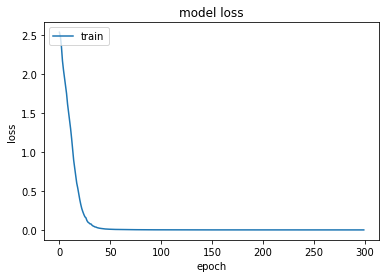

In [33]:
K.clear_session()
model = Sequential()
model.add(Dense(2000, input_dim=8400, activation="relu"))
# model.add(Dropout(0.23))
# model.add(Dropout(0.50))
# model.add(Dropout(0.23))
# model.add(Dense(4000, activation="relu"))
# # model.add(Dropout(0.23))
# model.add(Dense(3000, activation="tanh"))
# model.add(Dense(3000, activation="tanh"))
# model.add(Dense(3000, activation="tanh"))
# model.add(Dropout(0.50))
model.add(Dense(2000, activation="relu"))
# # model.add(Dropout(0.50))
# model.add(Dense(2000, activation="relu"))
# # model.add(Dropout(0.50))
# model.add(Dense(2000, activation="relu"))
# # model.add(Dropout(0.50))
# model.add(Dense(2000, activation="relu"))
# # model.add(Dropout(0.50))
# model.add(Dense(2000, activation="relu"))
# # model.add(Dropout(0.50))
# model.add(Dense(2000, activation="relu"))
# model.add(Dense(2000, activation="relu"))
# model.add(Dropout(0.23))
model.add(Dense(13, activation="softmax"))
model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

early_stop = EarlyStopping(monitor = 'loss', patience = 15, verbose = 1)

history = model.fit(X_train, y_train, epochs=300, batch_size=798, callbacks=[early_stop])

# summarize history for loss
plt.plot(history.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
# plt.savefig('loss1.png')

scores = model.evaluate(X_test, y_test)
print("\nAccuracy: %.2f%%" % (scores[1]*100))

In [15]:
unigram_all = list2ngram(cdr3aa_all, 1)
logger.debug(len(unigram_all))

[2018-04-22 17:41:12,471]-[7304]-[10612]-[etl]-[2]-[DEBUG]: 170415956


In [16]:
bigram_all = list2ngram(cdr3aa_all, 2)
logger.debug(len(bigram_all))

[2018-04-22 17:43:20,139]-[7304]-[10612]-[etl]-[2]-[DEBUG]: 157481300


In [17]:
trigram_all = list2ngram(cdr3aa_all, 3)
logger.debug(len(trigram_all))

[2018-04-22 17:44:56,303]-[7304]-[10612]-[etl]-[2]-[DEBUG]: 144546644


In [19]:
# MemoryError with low memory
five_gram_skip1_all = list2ngram_skip1(cdr3aa_all, 5)
logger.debug(len(five_gram_skip1_all))

[2018-04-22 17:56:42,399]-[7304]-[10612]-[etl]-[3]-[DEBUG]: 118677332


In [20]:
seven_gram_skip2_all = list2ngram_skip2(cdr3aa_all, 7)
logger.debug(len(seven_gram_skip2_all))

[2018-04-22 17:57:53,704]-[7304]-[10612]-[etl]-[2]-[DEBUG]: 92808020


In [22]:
unigram_all_counter = Counter(unigram_all)
bigram_all_counter = Counter(bigram_all)
trigram_all_counter = Counter(trigram_all)
five_gram_skip1_all_counter = Counter(five_gram_skip1_all)
seven_gram_skip2_all_counter = Counter(five_gram_skip1_all)

logger.debug(len(unigram_all_counter))
logger.debug(len(bigram_all_counter))
logger.debug(len(trigram_all_counter))
logger.debug(len(five_gram_skip1_all_counter))
logger.debug(len(seven_gram_skip2_all_counter))
# unigram_all_counter
# we found "nan" in the datase

[2018-04-22 18:25:00,041]-[7304]-[10612]-[etl]-[7]-[DEBUG]: 20
[2018-04-22 18:25:00,761]-[7304]-[10612]-[etl]-[8]-[DEBUG]: 400
[2018-04-22 18:25:00,795]-[7304]-[10612]-[etl]-[9]-[DEBUG]: 8000
[2018-04-22 18:25:00,810]-[7304]-[10612]-[etl]-[10]-[DEBUG]: 8000
[2018-04-22 18:25:00,843]-[7304]-[10612]-[etl]-[11]-[DEBUG]: 8000


In [23]:
# unigrams = sorted(unigram_all_counter.keys() - {'n', 'a'})
# bigrams = sorted(bigram_all_counter.keys() - {"na", "an"})
# trigrams = sorted(trigram_all_counter.keys() - {"nan"})
unigrams = sorted(unigram_all_counter.keys())
bigrams = sorted(bigram_all_counter.keys())
trigrams = sorted(trigram_all_counter.keys())
five_grams_skip1 = sorted(five_gram_skip1_all_counter.keys())
seven_grams_skip2 = sorted(seven_gram_skip2_all_counter.keys())
logger.debug(len(unigrams))
logger.debug(len(bigrams))
logger.debug(len(trigrams))
logger.debug(len(five_grams_skip1))
logger.debug(len(seven_grams_skip2))
# logger.debug(unigrams)

[2018-04-22 18:26:52,805]-[7304]-[10612]-[etl]-[9]-[DEBUG]: 20
[2018-04-22 18:26:52,808]-[7304]-[10612]-[etl]-[10]-[DEBUG]: 400
[2018-04-22 18:26:52,810]-[7304]-[10612]-[etl]-[11]-[DEBUG]: 8000
[2018-04-22 18:26:52,812]-[7304]-[10612]-[etl]-[12]-[DEBUG]: 8000
[2018-04-22 18:26:52,814]-[7304]-[10612]-[etl]-[13]-[DEBUG]: 8000


In [68]:
four_gram_all = list2ngram(cdr3aa_all, 4)
logger.debug(len(four_gram_all))
four_gram_all_counter = Counter(four_gram_all)
logger.debug(len(four_gram_all_counter))
# seems that four_grams can not even cover by the dataset, so stop at trigrams

[2018-04-10 16:25:41,668]-[2433]-[140736241603456]-[etl]-[2]-[DEBUG]: 131611988
[2018-04-10 16:25:41,668]-[2433]-[140736241603456]-[etl]-[2]-[DEBUG]: 131611988
[2018-04-10 16:26:56,713]-[2433]-[140736241603456]-[etl]-[4]-[DEBUG]: 158910
[2018-04-10 16:26:56,713]-[2433]-[140736241603456]-[etl]-[4]-[DEBUG]: 158910


In [69]:
unigram_all_freq = [float(unigram_all_counter[unigram]) / sum(unigram_all_counter.values()) for unigram in unigrams]
logger.debug(len(unigram_all_freq))
unigram_all_freq

[2018-04-10 16:30:17,492]-[2433]-[140736241603456]-[etl]-[2]-[DEBUG]: 20
[2018-04-10 16:30:17,492]-[2433]-[140736241603456]-[etl]-[2]-[DEBUG]: 20


[0.0773983217862534,
 0.05331726684090544,
 0.0750297642317014,
 0.017139058269872335,
 0.04271233850895981,
 0.14637215660721348,
 0.014675902765818477,
 0.01778733089993052,
 0.018010473150765295,
 0.032925220922388275,
 0.012689199126401051,
 0.017528018327110168,
 0.028898972347401554,
 0.042290441395053405,
 0.06393159570105043,
 0.055765834509064395,
 0.03468887033089789,
 0.03943326175396393,
 0.053749080866582706,
 0.15565689165866606]

In [24]:
df["unigram_cnt"] = df.cdr3aa.map(lambda x: Counter(list2ngram(x, 1)))
df["bigram_cnt"] = df.cdr3aa.map(lambda x: Counter(list2ngram(x, 2)))
df["trigram_cnt"] = df.cdr3aa.map(lambda x: Counter(list2ngram(x, 3)))
df["fivegram_skip1_cnt"] = df.cdr3aa.map(lambda x: Counter(list2ngram_skip1(x, 5)))
df["sevengram_skip2_cnt"] = df.cdr3aa.map(lambda x: Counter(list2ngram_skip2(x, 7)))

df["unigram_freq"] = df.unigram_cnt.map(lambda x: [float(x[unigram]) / sum(x.values()) for unigram in unigrams])
df["bigram_freq"] = df.bigram_cnt.map(lambda x: [float(x[bigram]) / sum(x.values()) for bigram in bigrams])
df["trigram_freq"] = df.trigram_cnt.map(lambda x: [float(x[trigram]) / sum(x.values()) for trigram in trigrams])
df["fivegram_skip1_freq"] = df.fivegram_skip1_cnt.map(lambda x: [float(x[gram]) / sum(x.values()) for gram in five_grams_skip1])
df["sevengram_skip2_freq"] = df.sevengram_skip2_cnt.map(lambda x: [float(x[gram]) / sum(x.values()) for gram in seven_grams_skip2])

In [6]:
list(df)

['EVENT',
 'OS',
 'age',
 'cancer',
 'cdr3aa',
 'segmentV',
 'unigram_cnt',
 'bigram_cnt',
 'trigram_cnt',
 'fivegram_skip1_cnt',
 'sevengram_skip2_cnt',
 'unigram_freq',
 'bigram_freq',
 'trigram_freq',
 'fivegram_skip1_freq',
 'sevengram_skip2_freq']

In [82]:
# df["features"] = df.unigram_freq + df.bigram_freq + df.trigram_freq
# np.array(list(df.features))
# logger.debug(len(list(df.features)))
# logger.debug(len(list(df.features)[0]))

[2018-04-10 17:23:22,186]-[2433]-[140736241603456]-[etl]-[3]-[DEBUG]: 4241
[2018-04-10 17:23:22,186]-[2433]-[140736241603456]-[etl]-[3]-[DEBUG]: 4241
[2018-04-10 17:23:22,188]-[2433]-[140736241603456]-[etl]-[4]-[DEBUG]: 8420
[2018-04-10 17:23:22,188]-[2433]-[140736241603456]-[etl]-[4]-[DEBUG]: 8420


In [26]:
# df.to_pickle("with_trigrams_skip_grams")

In [12]:
def listaa2aaclass(l):
    return [aa_class(s) for s in l]

df["cdr3aa_class"] = df.cdr3aa.map(lambda x: listaa2aaclass(x))

In [13]:
df["cdr3aa_class"].head()

0    [4YWG5G, 6344311YF2, G43PPFF4YWG5G, 6344311YF2...
1    [YY216G11, YY2161GYYY4334YP, F56WG5G, 146WG5G,...
2    [6463333WYF4YWG5G, YY216644G536, 65YYFF4YWG5G,...
3    [4YYF4YWG5G, YY2164P5GP, 1YYYYG241WG5G, 4311YY...
4    [Y33G3314YWG5G, YYYG241WG5G, 435YYG241WG5G, YY...
Name: cdr3aa_class, dtype: object

In [15]:
cdr3aa_all = [aa for l in df.cdr3aa_class for aa in l]
logger.debug(len(cdr3aa_all))

unigram_all = list2ngram(cdr3aa_all, 1)
logger.debug(len(unigram_all))

bigram_all = list2ngram(cdr3aa_all, 2)
logger.debug(len(bigram_all))

trigram_all = list2ngram(cdr3aa_all, 3)
logger.debug(len(trigram_all))

# MemoryError with low memory
five_gram_skip1_all = list2ngram_skip1(cdr3aa_all, 5)
logger.debug(len(five_gram_skip1_all))

seven_gram_skip2_all = list2ngram_skip2(cdr3aa_all, 7)
logger.debug(len(seven_gram_skip2_all))

unigram_all_counter = Counter(unigram_all)
bigram_all_counter = Counter(bigram_all)
trigram_all_counter = Counter(trigram_all)
five_gram_skip1_all_counter = Counter(five_gram_skip1_all)
seven_gram_skip2_all_counter = Counter(five_gram_skip1_all)

logger.debug(len(unigram_all_counter))
logger.debug(len(bigram_all_counter))
logger.debug(len(trigram_all_counter))
logger.debug(len(five_gram_skip1_all_counter))
logger.debug(len(seven_gram_skip2_all_counter))
# unigram_all_counter
# we found "nan" in the datase


# unigrams = sorted(unigram_all_counter.keys() - {'n', 'a'})
# bigrams = sorted(bigram_all_counter.keys() - {"na", "an"})
# trigrams = sorted(trigram_all_counter.keys() - {"nan"})
unigrams = sorted(unigram_all_counter.keys())
bigrams = sorted(bigram_all_counter.keys())
trigrams = sorted(trigram_all_counter.keys())
five_grams_skip1 = sorted(five_gram_skip1_all_counter.keys())
seven_grams_skip2 = sorted(seven_gram_skip2_all_counter.keys())
logger.debug(len(unigrams))
logger.debug(len(bigrams))
logger.debug(len(trigrams))
logger.debug(len(five_grams_skip1))
logger.debug(len(seven_grams_skip2))
# logger.debug(unigrams)



[2018-04-23 00:56:50,039]-[1512]-[1076]-[etl]-[2]-[DEBUG]: 12934656


[2018-04-23 00:57:28,157]-[1512]-[1076]-[etl]-[5]-[DEBUG]: 170415956


[2018-04-23 00:58:07,732]-[1512]-[1076]-[etl]-[8]-[DEBUG]: 170415956


[2018-04-23 00:58:58,214]-[1512]-[1076]-[etl]-[11]-[DEBUG]: 157481300


[2018-04-23 00:59:50,336]-[1512]-[1076]-[etl]-[14]-[DEBUG]: 144546644


[2018-04-23 01:00:41,206]-[1512]-[1076]-[etl]-[18]-[DEBUG]: 118677332


[2018-04-23 01:01:27,712]-[1512]-[1076]-[etl]-[21]-[DEBUG]: 92808020


[2018-04-23 01:06:26,316]-[1512]-[1076]-[etl]-[29]-[DEBUG]: 11


[2018-04-23 01:06:26,486]-[1512]-[1076]-[etl]-[30]-[DEBUG]: 121


[2018-04-23 01:06:26,494]-[1512]-[1076]-[etl]-[31]-[DEBUG]: 1331


[2018-04-23 01:06:26,500]-[1512]-[1076]-[etl]-[32]-[DEBUG]: 1331


[2018-04-23 01:06:26,503]-[1512]-[1076]-[etl]-[33]-[DEBUG]: 1331


[2018-04-23 01:06:26,563]-[1512]-[1076]-[etl]-[46]-[DEBUG]: 11


[2018-04-23 01:06:26,571]-[1512]-[1076]-[etl]-[47]-[DEBUG]: 121


[2018-04-23 01:06:26,574]-[1512]-[1076]-[etl]-[48]-[DEBUG]: 1331


[2018-04-23 01:06:26,580]-[1512]-[1076]-[etl]-[49]-[DEBUG]: 1331


[2018-04-23 01:06:26,587]-[1512]-[1076]-[etl]-[50]-[DEBUG]: 1331


In [17]:
df["unigram_cnt"] = df.cdr3aa_class.map(lambda x: Counter(list2ngram(x, 1)))
df["bigram_cnt"] = df.cdr3aa_class.map(lambda x: Counter(list2ngram(x, 2)))
df["trigram_cnt"] = df.cdr3aa_class.map(lambda x: Counter(list2ngram(x, 3)))
df["fivegram_skip1_cnt"] = df.cdr3aa_class.map(lambda x: Counter(list2ngram_skip1(x, 5)))
df["sevengram_skip2_cnt"] = df.cdr3aa_class.map(lambda x: Counter(list2ngram_skip2(x, 7)))

df["unigram_freq"] = df.unigram_cnt.map(lambda x: [float(x[unigram]) / sum(x.values()) for unigram in unigrams])
df["bigram_freq"] = df.bigram_cnt.map(lambda x: [float(x[bigram]) / sum(x.values()) for bigram in bigrams])
df["trigram_freq"] = df.trigram_cnt.map(lambda x: [float(x[trigram]) / sum(x.values()) for trigram in trigrams])
df["fivegram_skip1_freq"] = df.fivegram_skip1_cnt.map(lambda x: [float(x[gram]) / sum(x.values()) for gram in five_grams_skip1])
df["sevengram_skip2_freq"] = df.sevengram_skip2_cnt.map(lambda x: [float(x[gram]) / sum(x.values()) for gram in seven_grams_skip2])

In [20]:
list(df)

['BCR',
 'EVENT',
 'OS',
 'age',
 'cancer',
 'cdr3aa',
 'segmentV',
 'cdr3aa_class',
 'unigram_cnt',
 'bigram_cnt',
 'trigram_cnt',
 'fivegram_skip1_cnt',
 'sevengram_skip2_cnt',
 'unigram_freq',
 'bigram_freq',
 'trigram_freq',
 'fivegram_skip1_freq',
 'sevengram_skip2_freq']

In [2]:
df = pd.read_pickle("with_aaclass")

In [22]:

# 35
# df["features"] = df.unigram_freq + df.bigram_freq + df.trigram_freq + df.fivegram_skip1_freq + df.sevengram_skip2_freq + df2.unigram_freq + df2.bigram_freq + df2.trigram_freq + df2.fivegram_skip1_freq + df2.sevengram_skip2_freq 
# df["features"] = df2.trigram_freq

df["features"] = df2.trigram_freq + df.trigram_freq + df.fivegram_skip1_freq + df2.fivegram_skip1_freq 
X = np.array(list(df.features)).astype(float)
Y = np.array(list(df.cancer))
logger.debug(X)
logger.debug(Y)

Y_cnt = Counter(Y)
logger.debug(Y_cnt)
Y_freq = [float(Y_cnt[y]) / sum(Y_cnt.values()) for y in Y_cnt]
logger.debug(Y_freq)
encoder = LabelEncoder()
encoder.fit(Y)
encoder_Y = encoder.transform(Y)
logger.debug(encoder_Y)
dummy_y = np_utils.to_categorical(encoder_Y)
logger.debug(dummy_y)

X_train, X_test, y_train, y_test = train_test_split(X, dummy_y, test_size=0.1, random_state=23)
len(X_train[0])

[2018-04-23 03:13:53,293]-[11020]-[6892]-[etl]-[10]-[DEBUG]: [[0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [8.91218873e-04 0.00000000e+00 4.19397117e-04 ... 0.00000000e+00
  0.00000000e+00 1.49205319e-03]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 4.73933649e-03]
 ...
 [2.09631728e-03 0.00000000e+00 5.09915014e-04 ... 0.00000000e+00
  2.24687544e-03 7.02148575e-05]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 6.01322910e-04]
 [1.04085350e-03 3.71733393e-05 3.71733393e-04 ... 9.38923055e-05
  4.69461528e-05 6.57246139e-04]]


[2018-04-23 03:13:53,299]-[11020]-[6892]-[etl]-[11]-[DEBUG]: ['THCA' 'LUSC' 'OV' ... 'LUAD' 'SKCM' 'SKCM']


[2018-04-23 03:13:53,303]-[11020]-[6892]-[etl]-[14]-[DEBUG]: Counter({'KIRC': 430, 'LUSC': 397, 'LUAD': 386, 'PRAD': 375, 'OV': 362, 'THCA': 349, 'HNSC': 336, 'STAD': 322, 'BRCA': 317, 'SKCM': 312, 'BLCA': 302, 'COAD': 262, 'READ': 91})


[2018-04-23 03:13:53,308]-[11020]-[6892]-[etl]-[16]-[DEBUG]: [0.08229191228483848, 0.09360999764206555, 0.08535722706908748, 0.06177788257486442, 0.07120962037255364, 0.07922659750058948, 0.09101626974770101, 0.07356755482197595, 0.10139118132515916, 0.07474652204668711, 0.08842254185333648, 0.07592548927139825, 0.021457203489742987]


[2018-04-23 03:13:53,320]-[11020]-[6892]-[etl]-[20]-[DEBUG]: [12  6  7 ...  5 10 10]


[2018-04-23 03:13:53,335]-[11020]-[6892]-[etl]-[22]-[DEBUG]: [[0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 1. 0. 0.]
 [0. 0. 0. ... 1. 0. 0.]]


18662

Epoch 1/300


 798/3816 [=====>........................] - ETA: 4s - loss: 2.5650 - acc: 0.0789

1596/3816 [===========>..................] - ETA: 1s - loss: 2.5617 - acc: 0.0883

2394/3816 [=================>............] - ETA: 0s - loss: 2.5574 - acc: 0.0961

3192/3816 [========================>.....] - ETA: 0s - loss: 2.5530 - acc: 0.0984

3816/3816 [==============================] - 2s 565us/step - loss: 2.5509 - acc: 0.0941


Epoch 2/300


 798/3816 [=====>........................] - ETA: 1s - loss: 2.5290 - acc: 0.0877

1596/3816 [===========>..................] - ETA: 0s - loss: 2.5221 - acc: 0.0965

2394/3816 [=================>............] - ETA: 0s - loss: 2.5231 - acc: 0.0969

3192/3816 [========================>.....] - ETA: 0s - loss: 2.5219 - acc: 0.0940



3816/3816 [==============================] - 1s 338us/step - loss: 2.5208 - acc: 0.0925


Epoch 3/300


 798/3816 [=====>........................] - ETA: 0s - loss: 2.5094 - acc: 0.1040

1596/3816 [===========>..................] - ETA: 0s - loss: 2.5152 - acc: 0.0971

2394/3816 [=================>............] - ETA: 0s - loss: 2.5082 - acc: 0.0944

3192/3816 [========================>.....] - ETA: 0s - loss: 2.5018 - acc: 0.0987



3816/3816 [==============================] - 1s 304us/step - loss: 2.5038 - acc: 0.0988


Epoch 4/300


 798/3816 [=====>........................] - ETA: 0s - loss: 2.4765 - acc: 0.1366

1596/3816 [===========>..................] - ETA: 0s - loss: 2.4883 - acc: 0.1497

2394/3816 [=================>............] - ETA: 0s - loss: 2.4874 - acc: 0.1617

3192/3816 [========================>.....] - ETA: 0s - loss: 2.4873 - acc: 0.1723



3816/3816 [==============================] - 1s 284us/step - loss: 2.4869 - acc: 0.1722


Epoch 5/300


 798/3816 [=====>........................] - ETA: 0s - loss: 2.4707 - acc: 0.1842

1596/3816 [===========>..................] - ETA: 0s - loss: 2.4751 - acc: 0.1798

2394/3816 [=================>............] - ETA: 0s - loss: 2.4691 - acc: 0.1834

3192/3816 [========================>.....] - ETA: 0s - loss: 2.4660 - acc: 0.1848



3816/3816 [==============================] - 1s 295us/step - loss: 2.4625 - acc: 0.1868


Epoch 6/300


 798/3816 [=====>........................] - ETA: 0s - loss: 2.4610 - acc: 0.1642

1596/3816 [===========>..................] - ETA: 0s - loss: 2.4396 - acc: 0.1823

2394/3816 [=================>............] - ETA: 0s - loss: 2.4347 - acc: 0.1800

3192/3816 [========================>.....] - ETA: 0s - loss: 2.4311 - acc: 0.1852

3816/3816 [==============================] - 1s 291us/step - loss: 2.4307 - acc: 0.1874


Epoch 7/300


 798/3816 [=====>........................] - ETA: 0s - loss: 2.4039 - acc: 0.1830

1596/3816 [===========>..................] - ETA: 0s - loss: 2.4087 - acc: 0.1817

2394/3816 [=================>............] - ETA: 0s - loss: 2.3988 - acc: 0.1905

3192/3816 [========================>.....] - ETA: 0s - loss: 2.3956 - acc: 0.1933

3816/3816 [==============================] - 1s 291us/step - loss: 2.3922 - acc: 0.1976


Epoch 8/300


 798/3816 [=====>........................] - ETA: 0s - loss: 2.3551 - acc: 0.2055

1596/3816 [===========>..................] - ETA: 0s - loss: 2.3646 - acc: 0.1967

2394/3816 [=================>............] - ETA: 0s - loss: 2.3582 - acc: 0.1955

3192/3816 [========================>.....] - ETA: 0s - loss: 2.3558 - acc: 0.1917

3816/3816 [==============================] - 1s 288us/step - loss: 2.3501 - acc: 0.1903


Epoch 9/300


 798/3816 [=====>........................] - ETA: 0s - loss: 2.3227 - acc: 0.2018

1596/3816 [===========>..................] - ETA: 0s - loss: 2.3172 - acc: 0.1967

2394/3816 [=================>............] - ETA: 0s - loss: 2.3110 - acc: 0.1988

3192/3816 [========================>.....] - ETA: 0s - loss: 2.3099 - acc: 0.2049



3816/3816 [==============================] - 1s 281us/step - loss: 2.3020 - acc: 0.2167


Epoch 10/300


 798/3816 [=====>........................] - ETA: 0s - loss: 2.2393 - acc: 0.2794

1596/3816 [===========>..................] - ETA: 0s - loss: 2.2577 - acc: 0.2556

2394/3816 [=================>............] - ETA: 0s - loss: 2.2534 - acc: 0.2536

3192/3816 [========================>.....] - ETA: 0s - loss: 2.2576 - acc: 0.2522



3816/3816 [==============================] - 1s 297us/step - loss: 2.2551 - acc: 0.2453


Epoch 11/300


 798/3816 [=====>........................] - ETA: 0s - loss: 2.2248 - acc: 0.2168

1596/3816 [===========>..................] - ETA: 0s - loss: 2.2167 - acc: 0.2431

2394/3816 [=================>............] - ETA: 0s - loss: 2.2230 - acc: 0.2414

3192/3816 [========================>.....] - ETA: 0s - loss: 2.2124 - acc: 0.2519

3816/3816 [==============================] - 1s 298us/step - loss: 2.2086 - acc: 0.2531


Epoch 12/300


 798/3816 [=====>........................] - ETA: 0s - loss: 2.1698 - acc: 0.2644

1596/3816 [===========>..................] - ETA: 0s - loss: 2.1653 - acc: 0.2719

2394/3816 [=================>............] - ETA: 0s - loss: 2.1622 - acc: 0.2719

3192/3816 [========================>.....] - ETA: 0s - loss: 2.1689 - acc: 0.2644



3816/3816 [==============================] - 1s 292us/step - loss: 2.1686 - acc: 0.2589


Epoch 13/300


 798/3816 [=====>........................] - ETA: 0s - loss: 2.1481 - acc: 0.2444

1596/3816 [===========>..................] - ETA: 0s - loss: 2.1387 - acc: 0.2682

2394/3816 [=================>............] - ETA: 0s - loss: 2.1458 - acc: 0.2757

3192/3816 [========================>.....] - ETA: 0s - loss: 2.1332 - acc: 0.2845



3816/3816 [==============================] - 1s 300us/step - loss: 2.1325 - acc: 0.2922


Epoch 14/300


 798/3816 [=====>........................] - ETA: 0s - loss: 2.0962 - acc: 0.3145

1596/3816 [===========>..................] - ETA: 0s - loss: 2.0933 - acc: 0.3183

2394/3816 [=================>............] - ETA: 0s - loss: 2.0977 - acc: 0.3158

3192/3816 [========================>.....] - ETA: 0s - loss: 2.0996 - acc: 0.3170

3816/3816 [==============================] - 1s 297us/step - loss: 2.1019 - acc: 0.3142


Epoch 15/300


 798/3816 [=====>........................] - ETA: 0s - loss: 2.0942 - acc: 0.3033

1596/3816 [===========>..................] - ETA: 0s - loss: 2.0780 - acc: 0.3120

2394/3816 [=================>............] - ETA: 0s - loss: 2.0801 - acc: 0.3200

3192/3816 [========================>.....] - ETA: 0s - loss: 2.0752 - acc: 0.3170



3816/3816 [==============================] - 1s 285us/step - loss: 2.0742 - acc: 0.3179


Epoch 16/300


 798/3816 [=====>........................] - ETA: 0s - loss: 2.1215 - acc: 0.2782

1596/3816 [===========>..................] - ETA: 0s - loss: 2.0651 - acc: 0.2907

2394/3816 [=================>............] - ETA: 0s - loss: 2.0586 - acc: 0.3003

3192/3816 [========================>.....] - ETA: 0s - loss: 2.0490 - acc: 0.3139

3816/3816 [==============================] - 1s 293us/step - loss: 2.0478 - acc: 0.3179


Epoch 17/300


 798/3816 [=====>........................] - ETA: 0s - loss: 2.0294 - acc: 0.3346

1596/3816 [===========>..................] - ETA: 0s - loss: 2.0313 - acc: 0.3540

2394/3816 [=================>............] - ETA: 0s - loss: 2.0256 - acc: 0.3617

3192/3816 [========================>.....] - ETA: 0s - loss: 2.0213 - acc: 0.3669

3816/3816 [==============================] - 1s 305us/step - loss: 2.0237 - acc: 0.3632


Epoch 18/300


 798/3816 [=====>........................] - ETA: 0s - loss: 1.9977 - acc: 0.3659

1596/3816 [===========>..................] - ETA: 0s - loss: 1.9956 - acc: 0.3803

2394/3816 [=================>............] - ETA: 0s - loss: 1.9961 - acc: 0.3801

3192/3816 [========================>.....] - ETA: 0s - loss: 1.9999 - acc: 0.3759

3816/3816 [==============================] - 1s 288us/step - loss: 2.0000 - acc: 0.3729


Epoch 19/300


 798/3816 [=====>........................] - ETA: 0s - loss: 1.9842 - acc: 0.3659

1596/3816 [===========>..................] - ETA: 0s - loss: 1.9723 - acc: 0.3810

2394/3816 [=================>............] - ETA: 0s - loss: 1.9803 - acc: 0.3764

3192/3816 [========================>.....] - ETA: 0s - loss: 1.9887 - acc: 0.3697

3816/3816 [==============================] - 1s 297us/step - loss: 1.9769 - acc: 0.3766


Epoch 20/300


 798/3816 [=====>........................] - ETA: 0s - loss: 1.9884 - acc: 0.4023

1596/3816 [===========>..................] - ETA: 0s - loss: 1.9803 - acc: 0.4054

2394/3816 [=================>............] - ETA: 0s - loss: 1.9785 - acc: 0.4023

3192/3816 [========================>.....] - ETA: 0s - loss: 1.9626 - acc: 0.4073



3816/3816 [==============================] - 1s 293us/step - loss: 1.9526 - acc: 0.4188


Epoch 21/300


 798/3816 [=====>........................] - ETA: 0s - loss: 1.9188 - acc: 0.4511

1596/3816 [===========>..................] - ETA: 0s - loss: 1.9197 - acc: 0.4342

2394/3816 [=================>............] - ETA: 0s - loss: 1.9236 - acc: 0.4236

3192/3816 [========================>.....] - ETA: 0s - loss: 1.9218 - acc: 0.4207



3816/3816 [==============================] - 1s 289us/step - loss: 1.9283 - acc: 0.4133


Epoch 22/300


 798/3816 [=====>........................] - ETA: 0s - loss: 1.9326 - acc: 0.4060

1596/3816 [===========>..................] - ETA: 0s - loss: 1.9203 - acc: 0.4066

2394/3816 [=================>............] - ETA: 0s - loss: 1.9190 - acc: 0.4052

3192/3816 [========================>.....] - ETA: 0s - loss: 1.9119 - acc: 0.4157

3816/3816 [==============================] - 1s 295us/step - loss: 1.9029 - acc: 0.4216


Epoch 23/300


 798/3816 [=====>........................] - ETA: 0s - loss: 1.8783 - acc: 0.4449

1596/3816 [===========>..................] - ETA: 0s - loss: 1.8779 - acc: 0.4530

2394/3816 [=================>............] - ETA: 0s - loss: 1.8814 - acc: 0.4524

3192/3816 [========================>.....] - ETA: 0s - loss: 1.8829 - acc: 0.4524



3816/3816 [==============================] - 1s 294us/step - loss: 1.8770 - acc: 0.4562


Epoch 24/300


 798/3816 [=====>........................] - ETA: 0s - loss: 1.8736 - acc: 0.4762

1596/3816 [===========>..................] - ETA: 0s - loss: 1.8535 - acc: 0.4699

2394/3816 [=================>............] - ETA: 0s - loss: 1.8485 - acc: 0.4666

3192/3816 [========================>.....] - ETA: 0s - loss: 1.8536 - acc: 0.4549

3816/3816 [==============================] - 1s 291us/step - loss: 1.8500 - acc: 0.4612


Epoch 25/300


 798/3816 [=====>........................] - ETA: 0s - loss: 1.8106 - acc: 0.4724

1596/3816 [===========>..................] - ETA: 0s - loss: 1.8138 - acc: 0.4643

2394/3816 [=================>............] - ETA: 0s - loss: 1.8225 - acc: 0.4695

3192/3816 [========================>.....] - ETA: 0s - loss: 1.8178 - acc: 0.4740

3816/3816 [==============================] - 1s 289us/step - loss: 1.8240 - acc: 0.4754


Epoch 26/300


 798/3816 [=====>........................] - ETA: 0s - loss: 1.7980 - acc: 0.5163

1596/3816 [===========>..................] - ETA: 0s - loss: 1.8057 - acc: 0.5081

2394/3816 [=================>............] - ETA: 0s - loss: 1.7983 - acc: 0.5008

3192/3816 [========================>.....] - ETA: 0s - loss: 1.7983 - acc: 0.4937



3816/3816 [==============================] - 1s 301us/step - loss: 1.7956 - acc: 0.4919


Epoch 27/300


 798/3816 [=====>........................] - ETA: 0s - loss: 1.8024 - acc: 0.4662

1596/3816 [===========>..................] - ETA: 0s - loss: 1.7859 - acc: 0.4737

2394/3816 [=================>............] - ETA: 0s - loss: 1.7851 - acc: 0.4741

3192/3816 [========================>.....] - ETA: 0s - loss: 1.7686 - acc: 0.4862



3816/3816 [==============================] - 1s 285us/step - loss: 1.7675 - acc: 0.4872


Epoch 28/300


 798/3816 [=====>........................] - ETA: 0s - loss: 1.7606 - acc: 0.4937

1596/3816 [===========>..................] - ETA: 0s - loss: 1.7606 - acc: 0.4956

2394/3816 [=================>............] - ETA: 0s - loss: 1.7690 - acc: 0.4871

3192/3816 [========================>.....] - ETA: 0s - loss: 1.7501 - acc: 0.4925

3816/3816 [==============================] - 1s 344us/step - loss: 1.7404 - acc: 0.4979


Epoch 29/300


 798/3816 [=====>........................] - ETA: 0s - loss: 1.7156 - acc: 0.5576

1596/3816 [===========>..................] - ETA: 0s - loss: 1.7249 - acc: 0.5464

2394/3816 [=================>............] - ETA: 0s - loss: 1.7247 - acc: 0.5372

3192/3816 [========================>.....] - ETA: 0s - loss: 1.7184 - acc: 0.5326



3816/3816 [==============================] - 1s 291us/step - loss: 1.7101 - acc: 0.5330


Epoch 30/300


 798/3816 [=====>........................] - ETA: 0s - loss: 1.6963 - acc: 0.5326

1596/3816 [===========>..................] - ETA: 0s - loss: 1.6860 - acc: 0.5382

2394/3816 [=================>............] - ETA: 0s - loss: 1.6854 - acc: 0.5372

3192/3816 [========================>.....] - ETA: 0s - loss: 1.6805 - acc: 0.5401

3816/3816 [==============================] - 1s 302us/step - loss: 1.6823 - acc: 0.5375


Epoch 31/300


 798/3816 [=====>........................] - ETA: 0s - loss: 1.6742 - acc: 0.5576

1596/3816 [===========>..................] - ETA: 0s - loss: 1.6690 - acc: 0.5620

2394/3816 [=================>............] - ETA: 0s - loss: 1.6662 - acc: 0.5581

3192/3816 [========================>.....] - ETA: 0s - loss: 1.6517 - acc: 0.5602



3816/3816 [==============================] - 1s 302us/step - loss: 1.6533 - acc: 0.5556


Epoch 32/300


 798/3816 [=====>........................] - ETA: 0s - loss: 1.6235 - acc: 0.5539

1596/3816 [===========>..................] - ETA: 0s - loss: 1.6472 - acc: 0.5514

2394/3816 [=================>............] - ETA: 0s - loss: 1.6273 - acc: 0.5643

3192/3816 [========================>.....] - ETA: 0s - loss: 1.6243 - acc: 0.5620



3816/3816 [==============================] - 1s 289us/step - loss: 1.6230 - acc: 0.5605


Epoch 33/300


 798/3816 [=====>........................] - ETA: 0s - loss: 1.5962 - acc: 0.5627

1596/3816 [===========>..................] - ETA: 0s - loss: 1.6176 - acc: 0.5602

2394/3816 [=================>............] - ETA: 0s - loss: 1.6052 - acc: 0.5673

3192/3816 [========================>.....] - ETA: 0s - loss: 1.5995 - acc: 0.5805



3816/3816 [==============================] - 1s 294us/step - loss: 1.5930 - acc: 0.5844


Epoch 34/300


 798/3816 [=====>........................] - ETA: 0s - loss: 1.5606 - acc: 0.5865

1596/3816 [===========>..................] - ETA: 0s - loss: 1.5733 - acc: 0.5789

2394/3816 [=================>............] - ETA: 0s - loss: 1.5636 - acc: 0.5819

3192/3816 [========================>.....] - ETA: 0s - loss: 1.5670 - acc: 0.5802



3816/3816 [==============================] - 1s 297us/step - loss: 1.5644 - acc: 0.5820


Epoch 35/300


 798/3816 [=====>........................] - ETA: 0s - loss: 1.5294 - acc: 0.5977

1596/3816 [===========>..................] - ETA: 0s - loss: 1.5401 - acc: 0.5934

2394/3816 [=================>............] - ETA: 0s - loss: 1.5410 - acc: 0.5990

3192/3816 [========================>.....] - ETA: 0s - loss: 1.5383 - acc: 0.5999



3816/3816 [==============================] - 1s 305us/step - loss: 1.5368 - acc: 0.6017


Epoch 36/300


 798/3816 [=====>........................] - ETA: 0s - loss: 1.5061 - acc: 0.6203

1596/3816 [===========>..................] - ETA: 0s - loss: 1.5129 - acc: 0.6009

2394/3816 [=================>............] - ETA: 0s - loss: 1.5091 - acc: 0.5957

3192/3816 [========================>.....] - ETA: 0s - loss: 1.5075 - acc: 0.5921



3816/3816 [==============================] - 1s 284us/step - loss: 1.5089 - acc: 0.5941


Epoch 37/300


 798/3816 [=====>........................] - ETA: 0s - loss: 1.4569 - acc: 0.6429

1596/3816 [===========>..................] - ETA: 0s - loss: 1.4699 - acc: 0.6222

2394/3816 [=================>............] - ETA: 0s - loss: 1.4889 - acc: 0.6103

3192/3816 [========================>.....] - ETA: 0s - loss: 1.4747 - acc: 0.6156

3816/3816 [==============================] - 1s 306us/step - loss: 1.4793 - acc: 0.6098


Epoch 38/300


 798/3816 [=====>........................] - ETA: 0s - loss: 1.4647 - acc: 0.6404

1596/3816 [===========>..................] - ETA: 0s - loss: 1.4549 - acc: 0.6479

2394/3816 [=================>............] - ETA: 0s - loss: 1.4555 - acc: 0.6416

3192/3816 [========================>.....] - ETA: 0s - loss: 1.4442 - acc: 0.6397

3816/3816 [==============================] - 1s 290us/step - loss: 1.4479 - acc: 0.6336


Epoch 39/300


 798/3816 [=====>........................] - ETA: 0s - loss: 1.3746 - acc: 0.6729

1596/3816 [===========>..................] - ETA: 0s - loss: 1.4040 - acc: 0.6579

2394/3816 [=================>............] - ETA: 0s - loss: 1.4390 - acc: 0.6387

3192/3816 [========================>.....] - ETA: 0s - loss: 1.4188 - acc: 0.6479



3816/3816 [==============================] - 1s 315us/step - loss: 1.4174 - acc: 0.6473


Epoch 40/300


 798/3816 [=====>........................] - ETA: 0s - loss: 1.4369 - acc: 0.6466

1596/3816 [===========>..................] - ETA: 0s - loss: 1.3987 - acc: 0.6566

2394/3816 [=================>............] - ETA: 0s - loss: 1.3862 - acc: 0.6546

3192/3816 [========================>.....] - ETA: 0s - loss: 1.3798 - acc: 0.6519



3816/3816 [==============================] - 1s 305us/step - loss: 1.3874 - acc: 0.6549


Epoch 41/300


 798/3816 [=====>........................] - ETA: 0s - loss: 1.3654 - acc: 0.6742

1596/3816 [===========>..................] - ETA: 0s - loss: 1.3684 - acc: 0.6642

2394/3816 [=================>............] - ETA: 0s - loss: 1.3564 - acc: 0.6713

3192/3816 [========================>.....] - ETA: 0s - loss: 1.3514 - acc: 0.6723



3816/3816 [==============================] - 1s 286us/step - loss: 1.3595 - acc: 0.6680


Epoch 42/300


 798/3816 [=====>........................] - ETA: 0s - loss: 1.3229 - acc: 0.6579

1596/3816 [===========>..................] - ETA: 0s - loss: 1.3111 - acc: 0.6786

2394/3816 [=================>............] - ETA: 0s - loss: 1.3188 - acc: 0.6767

3192/3816 [========================>.....] - ETA: 0s - loss: 1.3408 - acc: 0.6717

3816/3816 [==============================] - 1s 303us/step - loss: 1.3318 - acc: 0.6774


Epoch 43/300


 798/3816 [=====>........................] - ETA: 0s - loss: 1.3151 - acc: 0.6742

1596/3816 [===========>..................] - ETA: 0s - loss: 1.3091 - acc: 0.6811

2394/3816 [=================>............] - ETA: 0s - loss: 1.3109 - acc: 0.6658

3192/3816 [========================>.....] - ETA: 0s - loss: 1.3091 - acc: 0.6739



3816/3816 [==============================] - 1s 318us/step - loss: 1.3048 - acc: 0.6777


Epoch 44/300


 798/3816 [=====>........................] - ETA: 0s - loss: 1.2684 - acc: 0.6967

1596/3816 [===========>..................] - ETA: 0s - loss: 1.2738 - acc: 0.7068

2394/3816 [=================>............] - ETA: 0s - loss: 1.2746 - acc: 0.7068

3192/3816 [========================>.....] - ETA: 0s - loss: 1.2741 - acc: 0.7083

3816/3816 [==============================] - 1s 302us/step - loss: 1.2743 - acc: 0.7073


Epoch 45/300


 798/3816 [=====>........................] - ETA: 0s - loss: 1.2482 - acc: 0.7055

1596/3816 [===========>..................] - ETA: 0s - loss: 1.2491 - acc: 0.7068

2394/3816 [=================>............] - ETA: 0s - loss: 1.2583 - acc: 0.6955

3192/3816 [========================>.....] - ETA: 0s - loss: 1.2524 - acc: 0.6986



3816/3816 [==============================] - 1s 279us/step - loss: 1.2480 - acc: 0.6997


Epoch 46/300


 798/3816 [=====>........................] - ETA: 0s - loss: 1.2426 - acc: 0.7206

1596/3816 [===========>..................] - ETA: 0s - loss: 1.2260 - acc: 0.7237

2394/3816 [=================>............] - ETA: 0s - loss: 1.2310 - acc: 0.7193

3192/3816 [========================>.....] - ETA: 0s - loss: 1.2187 - acc: 0.7202

3816/3816 [==============================] - 1s 311us/step - loss: 1.2186 - acc: 0.7172


Epoch 47/300


 798/3816 [=====>........................] - ETA: 0s - loss: 1.1903 - acc: 0.7293

1596/3816 [===========>..................] - ETA: 0s - loss: 1.1972 - acc: 0.7206

2394/3816 [=================>............] - ETA: 0s - loss: 1.1998 - acc: 0.7239

3192/3816 [========================>.....] - ETA: 0s - loss: 1.1980 - acc: 0.7227



3816/3816 [==============================] - 1s 300us/step - loss: 1.1922 - acc: 0.7306


Epoch 48/300


 798/3816 [=====>........................] - ETA: 0s - loss: 1.1937 - acc: 0.7368

1596/3816 [===========>..................] - ETA: 0s - loss: 1.1852 - acc: 0.7387

2394/3816 [=================>............] - ETA: 0s - loss: 1.1757 - acc: 0.7498

3192/3816 [========================>.....] - ETA: 0s - loss: 1.1659 - acc: 0.7484

3816/3816 [==============================] - 1s 308us/step - loss: 1.1650 - acc: 0.7429


Epoch 49/300


 798/3816 [=====>........................] - ETA: 0s - loss: 1.1865 - acc: 0.7494

1596/3816 [===========>..................] - ETA: 0s - loss: 1.1644 - acc: 0.7556

2394/3816 [=================>............] - ETA: 0s - loss: 1.1470 - acc: 0.7510

3192/3816 [========================>.....] - ETA: 0s - loss: 1.1564 - acc: 0.7462



3816/3816 [==============================] - 1s 282us/step - loss: 1.1398 - acc: 0.7516


Epoch 50/300


 798/3816 [=====>........................] - ETA: 0s - loss: 1.1484 - acc: 0.7481

1596/3816 [===========>..................] - ETA: 0s - loss: 1.1357 - acc: 0.7469

2394/3816 [=================>............] - ETA: 0s - loss: 1.1165 - acc: 0.7552

3192/3816 [========================>.....] - ETA: 0s - loss: 1.1073 - acc: 0.7603



3816/3816 [==============================] - 1s 283us/step - loss: 1.1117 - acc: 0.7586


Epoch 51/300


 798/3816 [=====>........................] - ETA: 0s - loss: 1.0809 - acc: 0.7707

1596/3816 [===========>..................] - ETA: 0s - loss: 1.0942 - acc: 0.7663

2394/3816 [=================>............] - ETA: 0s - loss: 1.0897 - acc: 0.7661

3192/3816 [========================>.....] - ETA: 0s - loss: 1.0917 - acc: 0.7644

3816/3816 [==============================] - 1s 291us/step - loss: 1.0888 - acc: 0.7660


Epoch 52/300


 798/3816 [=====>........................] - ETA: 0s - loss: 1.1239 - acc: 0.7594

1596/3816 [===========>..................] - ETA: 0s - loss: 1.1022 - acc: 0.7688

2394/3816 [=================>............] - ETA: 0s - loss: 1.0749 - acc: 0.7719

3192/3816 [========================>.....] - ETA: 0s - loss: 1.0685 - acc: 0.7729



3816/3816 [==============================] - 1s 311us/step - loss: 1.0610 - acc: 0.7759


Epoch 53/300


 798/3816 [=====>........................] - ETA: 0s - loss: 1.0449 - acc: 0.7957

1596/3816 [===========>..................] - ETA: 0s - loss: 1.0654 - acc: 0.7826

2394/3816 [=================>............] - ETA: 0s - loss: 1.0446 - acc: 0.7857

3192/3816 [========================>.....] - ETA: 0s - loss: 1.0432 - acc: 0.7876

3816/3816 [==============================] - 1s 295us/step - loss: 1.0367 - acc: 0.7875


Epoch 54/300


 798/3816 [=====>........................] - ETA: 0s - loss: 0.9840 - acc: 0.7870

1596/3816 [===========>..................] - ETA: 0s - loss: 1.0164 - acc: 0.7820

2394/3816 [=================>............] - ETA: 0s - loss: 1.0252 - acc: 0.7761

3192/3816 [========================>.....] - ETA: 0s - loss: 1.0205 - acc: 0.7826



3816/3816 [==============================] - 1s 290us/step - loss: 1.0140 - acc: 0.7880


Epoch 55/300


 798/3816 [=====>........................] - ETA: 0s - loss: 0.9807 - acc: 0.8045

1596/3816 [===========>..................] - ETA: 0s - loss: 0.9786 - acc: 0.8076

2394/3816 [=================>............] - ETA: 0s - loss: 0.9827 - acc: 0.8028

3192/3816 [========================>.....] - ETA: 0s - loss: 0.9922 - acc: 0.7979

3816/3816 [==============================] - 1s 276us/step - loss: 0.9886 - acc: 0.7982


Epoch 56/300


 798/3816 [=====>........................] - ETA: 0s - loss: 0.9632 - acc: 0.8108

1596/3816 [===========>..................] - ETA: 0s - loss: 0.9577 - acc: 0.8183

2394/3816 [=================>............] - ETA: 0s - loss: 0.9569 - acc: 0.8154

3192/3816 [========================>.....] - ETA: 0s - loss: 0.9608 - acc: 0.8114



3816/3816 [==============================] - 1s 292us/step - loss: 0.9682 - acc: 0.8048


Epoch 57/300


 798/3816 [=====>........................] - ETA: 0s - loss: 0.9327 - acc: 0.8183

1596/3816 [===========>..................] - ETA: 0s - loss: 0.9394 - acc: 0.8195

2394/3816 [=================>............] - ETA: 0s - loss: 0.9355 - acc: 0.8154

3192/3816 [========================>.....] - ETA: 0s - loss: 0.9331 - acc: 0.8164



3816/3816 [==============================] - 1s 283us/step - loss: 0.9409 - acc: 0.8137


Epoch 58/300


 798/3816 [=====>........................] - ETA: 0s - loss: 0.9366 - acc: 0.8170

1596/3816 [===========>..................] - ETA: 0s - loss: 0.9016 - acc: 0.8308

2394/3816 [=================>............] - ETA: 0s - loss: 0.9063 - acc: 0.8287

3192/3816 [========================>.....] - ETA: 0s - loss: 0.9185 - acc: 0.8252



3816/3816 [==============================] - 1s 306us/step - loss: 0.9177 - acc: 0.8208


Epoch 59/300


 798/3816 [=====>........................] - ETA: 0s - loss: 0.9199 - acc: 0.8083

1596/3816 [===========>..................] - ETA: 0s - loss: 0.9057 - acc: 0.8252

2394/3816 [=================>............] - ETA: 0s - loss: 0.9073 - acc: 0.8246

3192/3816 [========================>.....] - ETA: 0s - loss: 0.8964 - acc: 0.8274

3816/3816 [==============================] - 1s 295us/step - loss: 0.8941 - acc: 0.8286


Epoch 60/300


 798/3816 [=====>........................] - ETA: 0s - loss: 0.8757 - acc: 0.8383

1596/3816 [===========>..................] - ETA: 0s - loss: 0.8897 - acc: 0.8289

2394/3816 [=================>............] - ETA: 0s - loss: 0.8768 - acc: 0.8325

3192/3816 [========================>.....] - ETA: 0s - loss: 0.8753 - acc: 0.8371

3816/3816 [==============================] - 1s 301us/step - loss: 0.8721 - acc: 0.8378


Epoch 61/300


 798/3816 [=====>........................] - ETA: 0s - loss: 0.8893 - acc: 0.8208

1596/3816 [===========>..................] - ETA: 0s - loss: 0.8795 - acc: 0.8233

2394/3816 [=================>............] - ETA: 0s - loss: 0.8583 - acc: 0.8275

3192/3816 [========================>.....] - ETA: 0s - loss: 0.8613 - acc: 0.8261



3816/3816 [==============================] - 1s 297us/step - loss: 0.8539 - acc: 0.8344


Epoch 62/300


 798/3816 [=====>........................] - ETA: 0s - loss: 0.8635 - acc: 0.8534

1596/3816 [===========>..................] - ETA: 0s - loss: 0.8412 - acc: 0.8528

2394/3816 [=================>............] - ETA: 0s - loss: 0.8372 - acc: 0.8509

3192/3816 [========================>.....] - ETA: 0s - loss: 0.8375 - acc: 0.8449



3816/3816 [==============================] - 1s 298us/step - loss: 0.8327 - acc: 0.8428


Epoch 63/300


 798/3816 [=====>........................] - ETA: 0s - loss: 0.8231 - acc: 0.8434

1596/3816 [===========>..................] - ETA: 0s - loss: 0.8141 - acc: 0.8452

2394/3816 [=================>............] - ETA: 0s - loss: 0.8122 - acc: 0.8500

3192/3816 [========================>.....] - ETA: 0s - loss: 0.8114 - acc: 0.8528



3816/3816 [==============================] - 1s 319us/step - loss: 0.8106 - acc: 0.8538


Epoch 64/300


 798/3816 [=====>........................] - ETA: 0s - loss: 0.7912 - acc: 0.8571

1596/3816 [===========>..................] - ETA: 0s - loss: 0.7967 - acc: 0.8571

2394/3816 [=================>............] - ETA: 0s - loss: 0.8078 - acc: 0.8525

3192/3816 [========================>.....] - ETA: 0s - loss: 0.7926 - acc: 0.8590



3816/3816 [==============================] - 1s 290us/step - loss: 0.7907 - acc: 0.8585


Epoch 65/300


 798/3816 [=====>........................] - ETA: 0s - loss: 0.7917 - acc: 0.8672

1596/3816 [===========>..................] - ETA: 0s - loss: 0.7806 - acc: 0.8672

2394/3816 [=================>............] - ETA: 0s - loss: 0.7639 - acc: 0.8684

3192/3816 [========================>.....] - ETA: 0s - loss: 0.7671 - acc: 0.8665



3816/3816 [==============================] - 1s 281us/step - loss: 0.7702 - acc: 0.8656


Epoch 66/300


 798/3816 [=====>........................] - ETA: 0s - loss: 0.8063 - acc: 0.8496

1596/3816 [===========>..................] - ETA: 0s - loss: 0.7642 - acc: 0.8659

2394/3816 [=================>............] - ETA: 0s - loss: 0.7528 - acc: 0.8726

3192/3816 [========================>.....] - ETA: 0s - loss: 0.7552 - acc: 0.8712



3816/3816 [==============================] - 1s 285us/step - loss: 0.7503 - acc: 0.8713


Epoch 67/300


 798/3816 [=====>........................] - ETA: 0s - loss: 0.7592 - acc: 0.8672

1596/3816 [===========>..................] - ETA: 0s - loss: 0.7309 - acc: 0.8803

2394/3816 [=================>............] - ETA: 0s - loss: 0.7355 - acc: 0.8764

3192/3816 [========================>.....] - ETA: 0s - loss: 0.7294 - acc: 0.8769

3816/3816 [==============================] - 1s 300us/step - loss: 0.7290 - acc: 0.8789


Epoch 68/300


 798/3816 [=====>........................] - ETA: 0s - loss: 0.6886 - acc: 0.8947

1596/3816 [===========>..................] - ETA: 0s - loss: 0.7207 - acc: 0.8797

2394/3816 [=================>............] - ETA: 0s - loss: 0.7140 - acc: 0.8793

3192/3816 [========================>.....] - ETA: 0s - loss: 0.7081 - acc: 0.8822

3816/3816 [==============================] - 1s 316us/step - loss: 0.7139 - acc: 0.8808


Epoch 69/300


 798/3816 [=====>........................] - ETA: 0s - loss: 0.7078 - acc: 0.8822

1596/3816 [===========>..................] - ETA: 0s - loss: 0.7250 - acc: 0.8784

2394/3816 [=================>............] - ETA: 0s - loss: 0.7060 - acc: 0.8843

3192/3816 [========================>.....] - ETA: 0s - loss: 0.6993 - acc: 0.8885



3816/3816 [==============================] - 1s 287us/step - loss: 0.6981 - acc: 0.8871


Epoch 70/300


 798/3816 [=====>........................] - ETA: 0s - loss: 0.6505 - acc: 0.8960

1596/3816 [===========>..................] - ETA: 0s - loss: 0.6768 - acc: 0.8941

2394/3816 [=================>............] - ETA: 0s - loss: 0.6817 - acc: 0.8855

3192/3816 [========================>.....] - ETA: 0s - loss: 0.6752 - acc: 0.8869



3816/3816 [==============================] - 1s 290us/step - loss: 0.6804 - acc: 0.8857


Epoch 71/300


 798/3816 [=====>........................] - ETA: 0s - loss: 0.6816 - acc: 0.8947

1596/3816 [===========>..................] - ETA: 0s - loss: 0.6651 - acc: 0.8891

2394/3816 [=================>............] - ETA: 0s - loss: 0.6670 - acc: 0.8906

3192/3816 [========================>.....] - ETA: 0s - loss: 0.6644 - acc: 0.8941



3816/3816 [==============================] - 1s 302us/step - loss: 0.6595 - acc: 0.8944


Epoch 72/300


 798/3816 [=====>........................] - ETA: 0s - loss: 0.6643 - acc: 0.8960

1596/3816 [===========>..................] - ETA: 0s - loss: 0.6630 - acc: 0.8897

2394/3816 [=================>............] - ETA: 0s - loss: 0.6606 - acc: 0.8885

3192/3816 [========================>.....] - ETA: 0s - loss: 0.6507 - acc: 0.8966



3816/3816 [==============================] - 1s 292us/step - loss: 0.6452 - acc: 0.8975


Epoch 73/300


 798/3816 [=====>........................] - ETA: 0s - loss: 0.6210 - acc: 0.9148

1596/3816 [===========>..................] - ETA: 0s - loss: 0.6284 - acc: 0.9054

2394/3816 [=================>............] - ETA: 0s - loss: 0.6301 - acc: 0.9010

3192/3816 [========================>.....] - ETA: 0s - loss: 0.6340 - acc: 0.8982



3816/3816 [==============================] - 1s 287us/step - loss: 0.6263 - acc: 0.9012


Epoch 74/300


 798/3816 [=====>........................] - ETA: 0s - loss: 0.5971 - acc: 0.9098

1596/3816 [===========>..................] - ETA: 0s - loss: 0.5979 - acc: 0.9104

2394/3816 [=================>............] - ETA: 0s - loss: 0.6106 - acc: 0.9064

3192/3816 [========================>.....] - ETA: 0s - loss: 0.6019 - acc: 0.9082



3816/3816 [==============================] - 1s 285us/step - loss: 0.6108 - acc: 0.9062


Epoch 75/300


 798/3816 [=====>........................] - ETA: 0s - loss: 0.5938 - acc: 0.8997

1596/3816 [===========>..................] - ETA: 0s - loss: 0.6073 - acc: 0.9010

2394/3816 [=================>............] - ETA: 0s - loss: 0.6128 - acc: 0.9056

3192/3816 [========================>.....] - ETA: 0s - loss: 0.5970 - acc: 0.9104

3816/3816 [==============================] - 1s 287us/step - loss: 0.5991 - acc: 0.9080


Epoch 76/300


 798/3816 [=====>........................] - ETA: 0s - loss: 0.6030 - acc: 0.9073

1596/3816 [===========>..................] - ETA: 0s - loss: 0.5846 - acc: 0.9023

2394/3816 [=================>............] - ETA: 0s - loss: 0.5871 - acc: 0.9056

3192/3816 [========================>.....] - ETA: 0s - loss: 0.5870 - acc: 0.9088



3816/3816 [==============================] - 1s 293us/step - loss: 0.5818 - acc: 0.9101


Epoch 77/300


 798/3816 [=====>........................] - ETA: 0s - loss: 0.5898 - acc: 0.9010

1596/3816 [===========>..................] - ETA: 0s - loss: 0.5669 - acc: 0.9167

2394/3816 [=================>............] - ETA: 0s - loss: 0.5603 - acc: 0.9215

3192/3816 [========================>.....] - ETA: 0s - loss: 0.5621 - acc: 0.9198

3816/3816 [==============================] - 1s 304us/step - loss: 0.5651 - acc: 0.9172


Epoch 78/300


 798/3816 [=====>........................] - ETA: 0s - loss: 0.5463 - acc: 0.9198

1596/3816 [===========>..................] - ETA: 0s - loss: 0.5620 - acc: 0.9211

2394/3816 [=================>............] - ETA: 0s - loss: 0.5589 - acc: 0.9190

3192/3816 [========================>.....] - ETA: 0s - loss: 0.5524 - acc: 0.9204

3816/3816 [==============================] - 1s 290us/step - loss: 0.5514 - acc: 0.9203


Epoch 79/300


 798/3816 [=====>........................] - ETA: 0s - loss: 0.5333 - acc: 0.9298

1596/3816 [===========>..................] - ETA: 0s - loss: 0.5421 - acc: 0.9192

2394/3816 [=================>............] - ETA: 0s - loss: 0.5393 - acc: 0.9240

3192/3816 [========================>.....] - ETA: 0s - loss: 0.5466 - acc: 0.9185

3816/3816 [==============================] - 1s 296us/step - loss: 0.5371 - acc: 0.9216


Epoch 80/300


 798/3816 [=====>........................] - ETA: 0s - loss: 0.5187 - acc: 0.9261

1596/3816 [===========>..................] - ETA: 0s - loss: 0.5348 - acc: 0.9229

2394/3816 [=================>............] - ETA: 0s - loss: 0.5240 - acc: 0.9282

3192/3816 [========================>.....] - ETA: 0s - loss: 0.5239 - acc: 0.9270



3816/3816 [==============================] - 1s 292us/step - loss: 0.5223 - acc: 0.9256


Epoch 81/300


 798/3816 [=====>........................] - ETA: 0s - loss: 0.4980 - acc: 0.9211

1596/3816 [===========>..................] - ETA: 0s - loss: 0.5058 - acc: 0.9242

2394/3816 [=================>............] - ETA: 0s - loss: 0.5097 - acc: 0.9256

3192/3816 [========================>.....] - ETA: 0s - loss: 0.5130 - acc: 0.9242



3816/3816 [==============================] - 1s 290us/step - loss: 0.5076 - acc: 0.9269


Epoch 82/300


 798/3816 [=====>........................] - ETA: 0s - loss: 0.4799 - acc: 0.9411

1596/3816 [===========>..................] - ETA: 0s - loss: 0.4942 - acc: 0.9386

2394/3816 [=================>............] - ETA: 0s - loss: 0.4839 - acc: 0.9403

3192/3816 [========================>.....] - ETA: 0s - loss: 0.4945 - acc: 0.9326



3816/3816 [==============================] - 1s 286us/step - loss: 0.4944 - acc: 0.9319


Epoch 83/300


 798/3816 [=====>........................] - ETA: 0s - loss: 0.4471 - acc: 0.9536

1596/3816 [===========>..................] - ETA: 0s - loss: 0.4636 - acc: 0.9442

2394/3816 [=================>............] - ETA: 0s - loss: 0.4652 - acc: 0.9394

3192/3816 [========================>.....] - ETA: 0s - loss: 0.4746 - acc: 0.9361

3816/3816 [==============================] - 1s 283us/step - loss: 0.4809 - acc: 0.9361


Epoch 84/300


 798/3816 [=====>........................] - ETA: 0s - loss: 0.4409 - acc: 0.9424

1596/3816 [===========>..................] - ETA: 0s - loss: 0.4648 - acc: 0.9398

2394/3816 [=================>............] - ETA: 0s - loss: 0.4682 - acc: 0.9453

3192/3816 [========================>.....] - ETA: 0s - loss: 0.4649 - acc: 0.9436



3816/3816 [==============================] - 1s 298us/step - loss: 0.4689 - acc: 0.9400


Epoch 85/300


 798/3816 [=====>........................] - ETA: 0s - loss: 0.4462 - acc: 0.9386

1596/3816 [===========>..................] - ETA: 0s - loss: 0.4588 - acc: 0.9392

2394/3816 [=================>............] - ETA: 0s - loss: 0.4569 - acc: 0.9390

3192/3816 [========================>.....] - ETA: 0s - loss: 0.4557 - acc: 0.9414



3816/3816 [==============================] - 1s 283us/step - loss: 0.4560 - acc: 0.9410


Epoch 86/300


 798/3816 [=====>........................] - ETA: 0s - loss: 0.4438 - acc: 0.9511

1596/3816 [===========>..................] - ETA: 0s - loss: 0.4468 - acc: 0.9474

2394/3816 [=================>............] - ETA: 0s - loss: 0.4430 - acc: 0.9440

3192/3816 [========================>.....] - ETA: 0s - loss: 0.4475 - acc: 0.9408



3816/3816 [==============================] - 1s 275us/step - loss: 0.4436 - acc: 0.9423


Epoch 87/300


 798/3816 [=====>........................] - ETA: 0s - loss: 0.4359 - acc: 0.9336

1596/3816 [===========>..................] - ETA: 0s - loss: 0.4412 - acc: 0.9398

2394/3816 [=================>............] - ETA: 0s - loss: 0.4398 - acc: 0.9407

3192/3816 [========================>.....] - ETA: 0s - loss: 0.4382 - acc: 0.9417



3816/3816 [==============================] - 1s 292us/step - loss: 0.4350 - acc: 0.9450


Epoch 88/300


 798/3816 [=====>........................] - ETA: 0s - loss: 0.4285 - acc: 0.9511

1596/3816 [===========>..................] - ETA: 0s - loss: 0.4356 - acc: 0.9442

2394/3816 [=================>............] - ETA: 0s - loss: 0.4310 - acc: 0.9482

3192/3816 [========================>.....] - ETA: 0s - loss: 0.4222 - acc: 0.9502

3816/3816 [==============================] - 1s 309us/step - loss: 0.4227 - acc: 0.9479


Epoch 89/300


 798/3816 [=====>........................] - ETA: 0s - loss: 0.4041 - acc: 0.9511

1596/3816 [===========>..................] - ETA: 0s - loss: 0.4081 - acc: 0.9486

2394/3816 [=================>............] - ETA: 0s - loss: 0.4130 - acc: 0.9499

3192/3816 [========================>.....] - ETA: 0s - loss: 0.4064 - acc: 0.9530



3816/3816 [==============================] - 1s 298us/step - loss: 0.4110 - acc: 0.9507


Epoch 90/300


 798/3816 [=====>........................] - ETA: 0s - loss: 0.3928 - acc: 0.9586

1596/3816 [===========>..................] - ETA: 0s - loss: 0.3888 - acc: 0.9574

2394/3816 [=================>............] - ETA: 0s - loss: 0.3941 - acc: 0.9557

3192/3816 [========================>.....] - ETA: 0s - loss: 0.4000 - acc: 0.9539



3816/3816 [==============================] - 1s 291us/step - loss: 0.4010 - acc: 0.9523


Epoch 91/300


 798/3816 [=====>........................] - ETA: 0s - loss: 0.4028 - acc: 0.9549

1596/3816 [===========>..................] - ETA: 0s - loss: 0.3892 - acc: 0.9543

2394/3816 [=================>............] - ETA: 0s - loss: 0.3917 - acc: 0.9557

3192/3816 [========================>.....] - ETA: 0s - loss: 0.3878 - acc: 0.9555



3816/3816 [==============================] - 1s 280us/step - loss: 0.3905 - acc: 0.9562


Epoch 92/300


 798/3816 [=====>........................] - ETA: 0s - loss: 0.3951 - acc: 0.9536

1596/3816 [===========>..................] - ETA: 0s - loss: 0.3957 - acc: 0.9568

2394/3816 [=================>............] - ETA: 0s - loss: 0.3850 - acc: 0.9582

3192/3816 [========================>.....] - ETA: 0s - loss: 0.3833 - acc: 0.9583



3816/3816 [==============================] - 1s 290us/step - loss: 0.3826 - acc: 0.9570


Epoch 93/300


 798/3816 [=====>........................] - ETA: 0s - loss: 0.3835 - acc: 0.9486



1596/3816 [===========>..................] - ETA: 0s - loss: 0.3813 - acc: 0.9530

2394/3816 [=================>............] - ETA: 0s - loss: 0.3780 - acc: 0.9541

3192/3816 [========================>.....] - ETA: 0s - loss: 0.3706 - acc: 0.9565



3816/3816 [==============================] - 1s 274us/step - loss: 0.3701 - acc: 0.9581


Epoch 94/300


 798/3816 [=====>........................] - ETA: 0s - loss: 0.3658 - acc: 0.9674

1596/3816 [===========>..................] - ETA: 0s - loss: 0.3751 - acc: 0.9630

2394/3816 [=================>............] - ETA: 0s - loss: 0.3652 - acc: 0.9632

3192/3816 [========================>.....] - ETA: 0s - loss: 0.3609 - acc: 0.9612

3816/3816 [==============================] - 1s 273us/step - loss: 0.3623 - acc: 0.9604


Epoch 95/300


 798/3816 [=====>........................] - ETA: 0s - loss: 0.3735 - acc: 0.9524

1596/3816 [===========>..................] - ETA: 0s - loss: 0.3690 - acc: 0.9549

2394/3816 [=================>............] - ETA: 0s - loss: 0.3527 - acc: 0.9591

3192/3816 [========================>.....] - ETA: 0s - loss: 0.3520 - acc: 0.9615



3816/3816 [==============================] - 1s 286us/step - loss: 0.3526 - acc: 0.9620


Epoch 96/300


 798/3816 [=====>........................] - ETA: 0s - loss: 0.3711 - acc: 0.9449

1596/3816 [===========>..................] - ETA: 0s - loss: 0.3408 - acc: 0.9543

2394/3816 [=================>............] - ETA: 0s - loss: 0.3363 - acc: 0.9591

3192/3816 [========================>.....] - ETA: 0s - loss: 0.3387 - acc: 0.9618



3816/3816 [==============================] - 1s 284us/step - loss: 0.3443 - acc: 0.9604


Epoch 97/300


 798/3816 [=====>........................] - ETA: 0s - loss: 0.3387 - acc: 0.9574

1596/3816 [===========>..................] - ETA: 0s - loss: 0.3275 - acc: 0.9668

2394/3816 [=================>............] - ETA: 0s - loss: 0.3310 - acc: 0.9670

3192/3816 [========================>.....] - ETA: 0s - loss: 0.3339 - acc: 0.9649



3816/3816 [==============================] - 1s 290us/step - loss: 0.3345 - acc: 0.9657


Epoch 98/300


 798/3816 [=====>........................] - ETA: 0s - loss: 0.3311 - acc: 0.9586

1596/3816 [===========>..................] - ETA: 0s - loss: 0.3276 - acc: 0.9643

2394/3816 [=================>............] - ETA: 0s - loss: 0.3301 - acc: 0.9620

3192/3816 [========================>.....] - ETA: 0s - loss: 0.3272 - acc: 0.9643



3816/3816 [==============================] - 1s 283us/step - loss: 0.3252 - acc: 0.9665


Epoch 99/300


 798/3816 [=====>........................] - ETA: 0s - loss: 0.3143 - acc: 0.9674

1596/3816 [===========>..................] - ETA: 0s - loss: 0.3199 - acc: 0.9637

2394/3816 [=================>............] - ETA: 0s - loss: 0.3120 - acc: 0.9678

3192/3816 [========================>.....] - ETA: 0s - loss: 0.3158 - acc: 0.9659

3816/3816 [==============================] - 1s 286us/step - loss: 0.3204 - acc: 0.9649


Epoch 100/300


 798/3816 [=====>........................] - ETA: 0s - loss: 0.3051 - acc: 0.9687

1596/3816 [===========>..................] - ETA: 0s - loss: 0.3105 - acc: 0.9693

2394/3816 [=================>............] - ETA: 0s - loss: 0.3106 - acc: 0.9683

3192/3816 [========================>.....] - ETA: 0s - loss: 0.3147 - acc: 0.9709



3816/3816 [==============================] - 1s 296us/step - loss: 0.3100 - acc: 0.9709


Epoch 101/300


 798/3816 [=====>........................] - ETA: 0s - loss: 0.2938 - acc: 0.9712

1596/3816 [===========>..................] - ETA: 0s - loss: 0.3033 - acc: 0.9737

2394/3816 [=================>............] - ETA: 0s - loss: 0.3090 - acc: 0.9703

3192/3816 [========================>.....] - ETA: 0s - loss: 0.3036 - acc: 0.9702



3816/3816 [==============================] - 1s 280us/step - loss: 0.3032 - acc: 0.9699


Epoch 102/300


 798/3816 [=====>........................] - ETA: 0s - loss: 0.2964 - acc: 0.9712



1596/3816 [===========>..................] - ETA: 0s - loss: 0.2940 - acc: 0.9749

2394/3816 [=================>............] - ETA: 0s - loss: 0.2911 - acc: 0.9766

3192/3816 [========================>.....] - ETA: 0s - loss: 0.2965 - acc: 0.9731



3816/3816 [==============================] - 1s 288us/step - loss: 0.2948 - acc: 0.9722


Epoch 103/300


 798/3816 [=====>........................] - ETA: 0s - loss: 0.2845 - acc: 0.9712

1596/3816 [===========>..................] - ETA: 0s - loss: 0.2829 - acc: 0.9768

2394/3816 [=================>............] - ETA: 0s - loss: 0.2959 - acc: 0.9749

3192/3816 [========================>.....] - ETA: 0s - loss: 0.2889 - acc: 0.9759



3816/3816 [==============================] - 1s 285us/step - loss: 0.2868 - acc: 0.9748


Epoch 104/300


 798/3816 [=====>........................] - ETA: 0s - loss: 0.2970 - acc: 0.9749

1596/3816 [===========>..................] - ETA: 0s - loss: 0.2869 - acc: 0.9749

2394/3816 [=================>............] - ETA: 0s - loss: 0.2827 - acc: 0.9728

3192/3816 [========================>.....] - ETA: 0s - loss: 0.2803 - acc: 0.9731



3816/3816 [==============================] - 1s 295us/step - loss: 0.2800 - acc: 0.9733


Epoch 105/300


 798/3816 [=====>........................] - ETA: 0s - loss: 0.2925 - acc: 0.9699

1596/3816 [===========>..................] - ETA: 0s - loss: 0.2887 - acc: 0.9712

2394/3816 [=================>............] - ETA: 0s - loss: 0.2817 - acc: 0.9728

3192/3816 [========================>.....] - ETA: 0s - loss: 0.2762 - acc: 0.9749



3816/3816 [==============================] - 1s 285us/step - loss: 0.2730 - acc: 0.9756


Epoch 106/300


 798/3816 [=====>........................] - ETA: 0s - loss: 0.2717 - acc: 0.9724

1596/3816 [===========>..................] - ETA: 0s - loss: 0.2703 - acc: 0.9749

2394/3816 [=================>............] - ETA: 0s - loss: 0.2659 - acc: 0.9754

3192/3816 [========================>.....] - ETA: 0s - loss: 0.2626 - acc: 0.9771

3816/3816 [==============================] - 1s 292us/step - loss: 0.2646 - acc: 0.9769


Epoch 107/300


 798/3816 [=====>........................] - ETA: 0s - loss: 0.2382 - acc: 0.9799

1596/3816 [===========>..................] - ETA: 0s - loss: 0.2511 - acc: 0.9806

2394/3816 [=================>............] - ETA: 0s - loss: 0.2546 - acc: 0.9787

3192/3816 [========================>.....] - ETA: 0s - loss: 0.2600 - acc: 0.9759



3816/3816 [==============================] - 1s 282us/step - loss: 0.2584 - acc: 0.9759


Epoch 108/300


 798/3816 [=====>........................] - ETA: 0s - loss: 0.2683 - acc: 0.9799

1596/3816 [===========>..................] - ETA: 0s - loss: 0.2701 - acc: 0.9762

2394/3816 [=================>............] - ETA: 0s - loss: 0.2680 - acc: 0.9758

3192/3816 [========================>.....] - ETA: 0s - loss: 0.2532 - acc: 0.9790



3816/3816 [==============================] - 1s 288us/step - loss: 0.2523 - acc: 0.9793


Epoch 109/300


 798/3816 [=====>........................] - ETA: 0s - loss: 0.2389 - acc: 0.9787

1596/3816 [===========>..................] - ETA: 0s - loss: 0.2535 - acc: 0.9737

2394/3816 [=================>............] - ETA: 0s - loss: 0.2553 - acc: 0.9749

3192/3816 [========================>.....] - ETA: 0s - loss: 0.2480 - acc: 0.9787



3816/3816 [==============================] - 1s 286us/step - loss: 0.2465 - acc: 0.9790


Epoch 110/300


 798/3816 [=====>........................] - ETA: 0s - loss: 0.2329 - acc: 0.9850

1596/3816 [===========>..................] - ETA: 0s - loss: 0.2450 - acc: 0.9799

2394/3816 [=================>............] - ETA: 0s - loss: 0.2394 - acc: 0.9820

3192/3816 [========================>.....] - ETA: 0s - loss: 0.2401 - acc: 0.9799



3816/3816 [==============================] - 1s 282us/step - loss: 0.2398 - acc: 0.9806


Epoch 111/300


 798/3816 [=====>........................] - ETA: 0s - loss: 0.2311 - acc: 0.9799

1596/3816 [===========>..................] - ETA: 0s - loss: 0.2436 - acc: 0.9774

2394/3816 [=================>............] - ETA: 0s - loss: 0.2331 - acc: 0.9791

3192/3816 [========================>.....] - ETA: 0s - loss: 0.2354 - acc: 0.9796

3816/3816 [==============================] - 1s 295us/step - loss: 0.2342 - acc: 0.9803


Epoch 112/300


 798/3816 [=====>........................] - ETA: 0s - loss: 0.2477 - acc: 0.9762

1596/3816 [===========>..................] - ETA: 0s - loss: 0.2330 - acc: 0.9825

2394/3816 [=================>............] - ETA: 0s - loss: 0.2336 - acc: 0.9816

3192/3816 [========================>.....] - ETA: 0s - loss: 0.2300 - acc: 0.9828



3816/3816 [==============================] - 1s 279us/step - loss: 0.2300 - acc: 0.9822


Epoch 113/300


 798/3816 [=====>........................] - ETA: 0s - loss: 0.2045 - acc: 0.9912

1596/3816 [===========>..................] - ETA: 0s - loss: 0.2219 - acc: 0.9831

2394/3816 [=================>............] - ETA: 0s - loss: 0.2234 - acc: 0.9825

3192/3816 [========================>.....] - ETA: 0s - loss: 0.2218 - acc: 0.9825



3816/3816 [==============================] - 1s 289us/step - loss: 0.2217 - acc: 0.9830


Epoch 114/300


 798/3816 [=====>........................] - ETA: 0s - loss: 0.2148 - acc: 0.9875

1596/3816 [===========>..................] - ETA: 0s - loss: 0.2153 - acc: 0.9850

2394/3816 [=================>............] - ETA: 0s - loss: 0.2194 - acc: 0.9833

3192/3816 [========================>.....] - ETA: 0s - loss: 0.2164 - acc: 0.9828



3816/3816 [==============================] - 1s 277us/step - loss: 0.2159 - acc: 0.9843


Epoch 115/300


 798/3816 [=====>........................] - ETA: 0s - loss: 0.2193 - acc: 0.9812

1596/3816 [===========>..................] - ETA: 0s - loss: 0.2183 - acc: 0.9825

2394/3816 [=================>............] - ETA: 0s - loss: 0.2137 - acc: 0.9841

3192/3816 [========================>.....] - ETA: 0s - loss: 0.2123 - acc: 0.9843



3816/3816 [==============================] - 1s 282us/step - loss: 0.2115 - acc: 0.9856


Epoch 116/300


 798/3816 [=====>........................] - ETA: 0s - loss: 0.2050 - acc: 0.9875

1596/3816 [===========>..................] - ETA: 0s - loss: 0.2034 - acc: 0.9868

2394/3816 [=================>............] - ETA: 0s - loss: 0.2072 - acc: 0.9854

3192/3816 [========================>.....] - ETA: 0s - loss: 0.2066 - acc: 0.9856

3816/3816 [==============================] - 1s 289us/step - loss: 0.2066 - acc: 0.9843


Epoch 117/300


 798/3816 [=====>........................] - ETA: 0s - loss: 0.1927 - acc: 0.9850

1596/3816 [===========>..................] - ETA: 0s - loss: 0.1978 - acc: 0.9850

2394/3816 [=================>............] - ETA: 0s - loss: 0.2030 - acc: 0.9837

3192/3816 [========================>.....] - ETA: 0s - loss: 0.2009 - acc: 0.9843



3816/3816 [==============================] - 1s 281us/step - loss: 0.2016 - acc: 0.9848


Epoch 118/300


 798/3816 [=====>........................] - ETA: 0s - loss: 0.2107 - acc: 0.9787

1596/3816 [===========>..................] - ETA: 0s - loss: 0.2046 - acc: 0.9825

2394/3816 [=================>............] - ETA: 0s - loss: 0.1984 - acc: 0.9854

3192/3816 [========================>.....] - ETA: 0s - loss: 0.1996 - acc: 0.9846



3816/3816 [==============================] - 1s 284us/step - loss: 0.1971 - acc: 0.9864


Epoch 119/300


 798/3816 [=====>........................] - ETA: 0s - loss: 0.1772 - acc: 0.9887

1596/3816 [===========>..................] - ETA: 0s - loss: 0.1830 - acc: 0.9881

2394/3816 [=================>............] - ETA: 0s - loss: 0.1922 - acc: 0.9837

3192/3816 [========================>.....] - ETA: 0s - loss: 0.1924 - acc: 0.9846



3816/3816 [==============================] - 1s 280us/step - loss: 0.1934 - acc: 0.9843


Epoch 120/300


 798/3816 [=====>........................] - ETA: 0s - loss: 0.1917 - acc: 0.9875

1596/3816 [===========>..................] - ETA: 0s - loss: 0.1894 - acc: 0.9881

2394/3816 [=================>............] - ETA: 0s - loss: 0.1892 - acc: 0.9866

3192/3816 [========================>.....] - ETA: 0s - loss: 0.1881 - acc: 0.9875

3816/3816 [==============================] - 1s 296us/step - loss: 0.1890 - acc: 0.9864


Epoch 121/300


 798/3816 [=====>........................] - ETA: 0s - loss: 0.1827 - acc: 0.9850

1596/3816 [===========>..................] - ETA: 0s - loss: 0.1912 - acc: 0.9862

2394/3816 [=================>............] - ETA: 0s - loss: 0.1890 - acc: 0.9871

3192/3816 [========================>.....] - ETA: 0s - loss: 0.1848 - acc: 0.9878



3816/3816 [==============================] - 1s 284us/step - loss: 0.1839 - acc: 0.9879


Epoch 122/300


 798/3816 [=====>........................] - ETA: 0s - loss: 0.2081 - acc: 0.9825

1596/3816 [===========>..................] - ETA: 0s - loss: 0.1858 - acc: 0.9868

2394/3816 [=================>............] - ETA: 0s - loss: 0.1840 - acc: 0.9854

3192/3816 [========================>.....] - ETA: 0s - loss: 0.1829 - acc: 0.9856



3816/3816 [==============================] - 1s 282us/step - loss: 0.1801 - acc: 0.9869


Epoch 123/300


 798/3816 [=====>........................] - ETA: 0s - loss: 0.1874 - acc: 0.9862

1596/3816 [===========>..................] - ETA: 0s - loss: 0.1808 - acc: 0.9856

2394/3816 [=================>............] - ETA: 0s - loss: 0.1821 - acc: 0.9841

3192/3816 [========================>.....] - ETA: 0s - loss: 0.1763 - acc: 0.9856



3816/3816 [==============================] - 1s 280us/step - loss: 0.1757 - acc: 0.9861


Epoch 124/300


 798/3816 [=====>........................] - ETA: 0s - loss: 0.1720 - acc: 0.9862

1596/3816 [===========>..................] - ETA: 0s - loss: 0.1718 - acc: 0.9862

2394/3816 [=================>............] - ETA: 0s - loss: 0.1745 - acc: 0.9887

3192/3816 [========================>.....] - ETA: 0s - loss: 0.1710 - acc: 0.9893



3816/3816 [==============================] - 1s 279us/step - loss: 0.1709 - acc: 0.9890


Epoch 125/300


 798/3816 [=====>........................] - ETA: 0s - loss: 0.1732 - acc: 0.9850

1596/3816 [===========>..................] - ETA: 0s - loss: 0.1608 - acc: 0.9893

2394/3816 [=================>............] - ETA: 0s - loss: 0.1690 - acc: 0.9879

3192/3816 [========================>.....] - ETA: 0s - loss: 0.1682 - acc: 0.9884



3816/3816 [==============================] - 1s 276us/step - loss: 0.1667 - acc: 0.9885


Epoch 126/300


 798/3816 [=====>........................] - ETA: 0s - loss: 0.1769 - acc: 0.9799

1596/3816 [===========>..................] - ETA: 0s - loss: 0.1720 - acc: 0.9862

2394/3816 [=================>............] - ETA: 0s - loss: 0.1647 - acc: 0.9896

3192/3816 [========================>.....] - ETA: 0s - loss: 0.1645 - acc: 0.9881

3816/3816 [==============================] - 1s 301us/step - loss: 0.1637 - acc: 0.9887


Epoch 127/300


 798/3816 [=====>........................] - ETA: 0s - loss: 0.1732 - acc: 0.9850

1596/3816 [===========>..................] - ETA: 0s - loss: 0.1655 - acc: 0.9862

2394/3816 [=================>............] - ETA: 0s - loss: 0.1651 - acc: 0.9879

3192/3816 [========================>.....] - ETA: 0s - loss: 0.1614 - acc: 0.9893



3816/3816 [==============================] - 1s 287us/step - loss: 0.1595 - acc: 0.9895


Epoch 128/300


 798/3816 [=====>........................] - ETA: 0s - loss: 0.1598 - acc: 0.9887

1596/3816 [===========>..................] - ETA: 0s - loss: 0.1593 - acc: 0.9912

2394/3816 [=================>............] - ETA: 0s - loss: 0.1565 - acc: 0.9900

3192/3816 [========================>.....] - ETA: 0s - loss: 0.1540 - acc: 0.9912

3816/3816 [==============================] - 1s 286us/step - loss: 0.1550 - acc: 0.9908


Epoch 129/300


 798/3816 [=====>........................] - ETA: 0s - loss: 0.1435 - acc: 0.9937

1596/3816 [===========>..................] - ETA: 0s - loss: 0.1526 - acc: 0.9906

2394/3816 [=================>............] - ETA: 0s - loss: 0.1455 - acc: 0.9929

3192/3816 [========================>.....] - ETA: 0s - loss: 0.1507 - acc: 0.9909

3816/3816 [==============================] - 1s 294us/step - loss: 0.1518 - acc: 0.9914


Epoch 130/300


 798/3816 [=====>........................] - ETA: 0s - loss: 0.1365 - acc: 0.9950

1596/3816 [===========>..................] - ETA: 0s - loss: 0.1437 - acc: 0.9931

2394/3816 [=================>............] - ETA: 0s - loss: 0.1457 - acc: 0.9929

3192/3816 [========================>.....] - ETA: 0s - loss: 0.1480 - acc: 0.9915

3816/3816 [==============================] - 1s 308us/step - loss: 0.1476 - acc: 0.9914


Epoch 131/300


 798/3816 [=====>........................] - ETA: 0s - loss: 0.1424 - acc: 0.9900

1596/3816 [===========>..................] - ETA: 0s - loss: 0.1452 - acc: 0.9919

2394/3816 [=================>............] - ETA: 0s - loss: 0.1462 - acc: 0.9896

3192/3816 [========================>.....] - ETA: 0s - loss: 0.1446 - acc: 0.9909

3816/3816 [==============================] - 1s 303us/step - loss: 0.1444 - acc: 0.9903


Epoch 132/300


 798/3816 [=====>........................] - ETA: 0s - loss: 0.1454 - acc: 0.9925

1596/3816 [===========>..................] - ETA: 0s - loss: 0.1441 - acc: 0.9919

2394/3816 [=================>............] - ETA: 0s - loss: 0.1421 - acc: 0.9912

3192/3816 [========================>.....] - ETA: 0s - loss: 0.1416 - acc: 0.9912



3816/3816 [==============================] - 1s 290us/step - loss: 0.1409 - acc: 0.9924


Epoch 133/300


 798/3816 [=====>........................] - ETA: 0s - loss: 0.1403 - acc: 0.9937

1596/3816 [===========>..................] - ETA: 0s - loss: 0.1361 - acc: 0.9944

2394/3816 [=================>............] - ETA: 0s - loss: 0.1344 - acc: 0.9929

3192/3816 [========================>.....] - ETA: 0s - loss: 0.1375 - acc: 0.9928



3816/3816 [==============================] - 1s 293us/step - loss: 0.1378 - acc: 0.9929


Epoch 134/300


 798/3816 [=====>........................] - ETA: 0s - loss: 0.1386 - acc: 0.9950

1596/3816 [===========>..................] - ETA: 0s - loss: 0.1395 - acc: 0.9919

2394/3816 [=================>............] - ETA: 0s - loss: 0.1371 - acc: 0.9925

3192/3816 [========================>.....] - ETA: 0s - loss: 0.1331 - acc: 0.9937



3816/3816 [==============================] - 1s 297us/step - loss: 0.1349 - acc: 0.9934


Epoch 135/300


 798/3816 [=====>........................] - ETA: 0s - loss: 0.1432 - acc: 0.9925

1596/3816 [===========>..................] - ETA: 0s - loss: 0.1419 - acc: 0.9931

2394/3816 [=================>............] - ETA: 0s - loss: 0.1382 - acc: 0.9933

3192/3816 [========================>.....] - ETA: 0s - loss: 0.1328 - acc: 0.9937



3816/3816 [==============================] - 1s 291us/step - loss: 0.1319 - acc: 0.9937


Epoch 136/300


 798/3816 [=====>........................] - ETA: 0s - loss: 0.1260 - acc: 0.9925

1596/3816 [===========>..................] - ETA: 0s - loss: 0.1333 - acc: 0.9931

2394/3816 [=================>............] - ETA: 0s - loss: 0.1332 - acc: 0.9933

3192/3816 [========================>.....] - ETA: 0s - loss: 0.1314 - acc: 0.9928



3816/3816 [==============================] - 1s 291us/step - loss: 0.1288 - acc: 0.9932


Epoch 137/300


 798/3816 [=====>........................] - ETA: 0s - loss: 0.1180 - acc: 0.9950

1596/3816 [===========>..................] - ETA: 0s - loss: 0.1194 - acc: 0.9962

2394/3816 [=================>............] - ETA: 0s - loss: 0.1264 - acc: 0.9937

3192/3816 [========================>.....] - ETA: 0s - loss: 0.1285 - acc: 0.9934

3816/3816 [==============================] - 1s 298us/step - loss: 0.1269 - acc: 0.9940


Epoch 138/300


 798/3816 [=====>........................] - ETA: 0s - loss: 0.1195 - acc: 0.9937

1596/3816 [===========>..................] - ETA: 0s - loss: 0.1235 - acc: 0.9944

2394/3816 [=================>............] - ETA: 0s - loss: 0.1212 - acc: 0.9933

3192/3816 [========================>.....] - ETA: 0s - loss: 0.1246 - acc: 0.9931

3816/3816 [==============================] - 1s 294us/step - loss: 0.1241 - acc: 0.9932


Epoch 139/300


 798/3816 [=====>........................] - ETA: 0s - loss: 0.1187 - acc: 0.9962

1596/3816 [===========>..................] - ETA: 0s - loss: 0.1228 - acc: 0.9950

2394/3816 [=================>............] - ETA: 0s - loss: 0.1244 - acc: 0.9950

3192/3816 [========================>.....] - ETA: 0s - loss: 0.1233 - acc: 0.9937

3816/3816 [==============================] - 1s 308us/step - loss: 0.1214 - acc: 0.9940


Epoch 140/300


 798/3816 [=====>........................] - ETA: 0s - loss: 0.1200 - acc: 0.9925

1596/3816 [===========>..................] - ETA: 0s - loss: 0.1202 - acc: 0.9937

2394/3816 [=================>............] - ETA: 0s - loss: 0.1207 - acc: 0.9950

3192/3816 [========================>.....] - ETA: 0s - loss: 0.1203 - acc: 0.9947

3816/3816 [==============================] - 1s 305us/step - loss: 0.1191 - acc: 0.9948


Epoch 141/300


 798/3816 [=====>........................] - ETA: 0s - loss: 0.1285 - acc: 0.9900

1596/3816 [===========>..................] - ETA: 0s - loss: 0.1163 - acc: 0.9944

2394/3816 [=================>............] - ETA: 0s - loss: 0.1173 - acc: 0.9942

3192/3816 [========================>.....] - ETA: 0s - loss: 0.1167 - acc: 0.9944



3816/3816 [==============================] - 1s 295us/step - loss: 0.1159 - acc: 0.9945


Epoch 142/300


 798/3816 [=====>........................] - ETA: 0s - loss: 0.1139 - acc: 0.9937

1596/3816 [===========>..................] - ETA: 0s - loss: 0.1121 - acc: 0.9937

2394/3816 [=================>............] - ETA: 0s - loss: 0.1139 - acc: 0.9950

3192/3816 [========================>.....] - ETA: 0s - loss: 0.1153 - acc: 0.9947



3816/3816 [==============================] - 1s 286us/step - loss: 0.1129 - acc: 0.9953


Epoch 143/300


 798/3816 [=====>........................] - ETA: 0s - loss: 0.1161 - acc: 0.9950

1596/3816 [===========>..................] - ETA: 0s - loss: 0.1123 - acc: 0.9944

2394/3816 [=================>............] - ETA: 0s - loss: 0.1109 - acc: 0.9946

3192/3816 [========================>.....] - ETA: 0s - loss: 0.1123 - acc: 0.9950

3816/3816 [==============================] - 1s 300us/step - loss: 0.1104 - acc: 0.9958


Epoch 144/300


 798/3816 [=====>........................] - ETA: 0s - loss: 0.1092 - acc: 0.9937

1596/3816 [===========>..................] - ETA: 0s - loss: 0.1155 - acc: 0.9937

2394/3816 [=================>............] - ETA: 0s - loss: 0.1135 - acc: 0.9937

3192/3816 [========================>.....] - ETA: 0s - loss: 0.1120 - acc: 0.9944

3816/3816 [==============================] - 1s 312us/step - loss: 0.1083 - acc: 0.9953


Epoch 145/300


 798/3816 [=====>........................] - ETA: 0s - loss: 0.1098 - acc: 0.9950

1596/3816 [===========>..................] - ETA: 0s - loss: 0.1062 - acc: 0.9956

2394/3816 [=================>............] - ETA: 0s - loss: 0.1045 - acc: 0.9958

3192/3816 [========================>.....] - ETA: 0s - loss: 0.1059 - acc: 0.9953



3816/3816 [==============================] - 1s 282us/step - loss: 0.1063 - acc: 0.9950


Epoch 146/300


 798/3816 [=====>........................] - ETA: 0s - loss: 0.1017 - acc: 0.9950

1596/3816 [===========>..................] - ETA: 0s - loss: 0.1055 - acc: 0.9956

2394/3816 [=================>............] - ETA: 0s - loss: 0.1041 - acc: 0.9958

3192/3816 [========================>.....] - ETA: 0s - loss: 0.1043 - acc: 0.9962



3816/3816 [==============================] - 1s 309us/step - loss: 0.1039 - acc: 0.9961


Epoch 147/300


 798/3816 [=====>........................] - ETA: 0s - loss: 0.0970 - acc: 0.9950

1596/3816 [===========>..................] - ETA: 0s - loss: 0.1032 - acc: 0.9944

2394/3816 [=================>............] - ETA: 0s - loss: 0.1004 - acc: 0.9950

3192/3816 [========================>.....] - ETA: 0s - loss: 0.1012 - acc: 0.9959



3816/3816 [==============================] - 1s 295us/step - loss: 0.1022 - acc: 0.9958


Epoch 148/300


 798/3816 [=====>........................] - ETA: 0s - loss: 0.1024 - acc: 0.9987

1596/3816 [===========>..................] - ETA: 0s - loss: 0.1054 - acc: 0.9962

2394/3816 [=================>............] - ETA: 0s - loss: 0.1050 - acc: 0.9950

3192/3816 [========================>.....] - ETA: 0s - loss: 0.1030 - acc: 0.9953

3816/3816 [==============================] - 1s 297us/step - loss: 0.1000 - acc: 0.9958


Epoch 149/300


 798/3816 [=====>........................] - ETA: 0s - loss: 0.0993 - acc: 0.9987

1596/3816 [===========>..................] - ETA: 0s - loss: 0.0973 - acc: 0.9975

2394/3816 [=================>............] - ETA: 0s - loss: 0.0956 - acc: 0.9979

3192/3816 [========================>.....] - ETA: 0s - loss: 0.0956 - acc: 0.9978



3816/3816 [==============================] - 1s 294us/step - loss: 0.0970 - acc: 0.9974


Epoch 150/300


 798/3816 [=====>........................] - ETA: 0s - loss: 0.0925 - acc: 0.9950

1596/3816 [===========>..................] - ETA: 0s - loss: 0.0940 - acc: 0.9962

2394/3816 [=================>............] - ETA: 0s - loss: 0.0956 - acc: 0.9962

3192/3816 [========================>.....] - ETA: 0s - loss: 0.0941 - acc: 0.9966

3816/3816 [==============================] - 1s 286us/step - loss: 0.0957 - acc: 0.9963


Epoch 151/300


 798/3816 [=====>........................] - ETA: 0s - loss: 0.0928 - acc: 0.9987

1596/3816 [===========>..................] - ETA: 0s - loss: 0.0959 - acc: 0.9975

2394/3816 [=================>............] - ETA: 0s - loss: 0.0957 - acc: 0.9971

3192/3816 [========================>.....] - ETA: 0s - loss: 0.0944 - acc: 0.9969



3816/3816 [==============================] - 1s 278us/step - loss: 0.0936 - acc: 0.9969


Epoch 152/300


 798/3816 [=====>........................] - ETA: 0s - loss: 0.0949 - acc: 0.9975

1596/3816 [===========>..................] - ETA: 0s - loss: 0.0952 - acc: 0.9975

2394/3816 [=================>............] - ETA: 0s - loss: 0.0946 - acc: 0.9967

3192/3816 [========================>.....] - ETA: 0s - loss: 0.0926 - acc: 0.9966



3816/3816 [==============================] - 1s 293us/step - loss: 0.0913 - acc: 0.9969


Epoch 153/300


 798/3816 [=====>........................] - ETA: 0s - loss: 0.0897 - acc: 0.9987

1596/3816 [===========>..................] - ETA: 0s - loss: 0.0907 - acc: 0.9975

2394/3816 [=================>............] - ETA: 0s - loss: 0.0911 - acc: 0.9967

3192/3816 [========================>.....] - ETA: 0s - loss: 0.0900 - acc: 0.9966



3816/3816 [==============================] - 1s 288us/step - loss: 0.0894 - acc: 0.9966


Epoch 154/300


 798/3816 [=====>........................] - ETA: 0s - loss: 0.0957 - acc: 0.9925

1596/3816 [===========>..................] - ETA: 0s - loss: 0.0920 - acc: 0.9962

2394/3816 [=================>............] - ETA: 0s - loss: 0.0920 - acc: 0.9971

3192/3816 [========================>.....] - ETA: 0s - loss: 0.0896 - acc: 0.9972



3816/3816 [==============================] - 1s 294us/step - loss: 0.0881 - acc: 0.9971


Epoch 155/300


 798/3816 [=====>........................] - ETA: 0s - loss: 0.0842 - acc: 0.9975

1596/3816 [===========>..................] - ETA: 0s - loss: 0.0840 - acc: 0.9981

2394/3816 [=================>............] - ETA: 0s - loss: 0.0844 - acc: 0.9975

3192/3816 [========================>.....] - ETA: 0s - loss: 0.0851 - acc: 0.9975

3816/3816 [==============================] - 1s 321us/step - loss: 0.0862 - acc: 0.9969


Epoch 156/300


 798/3816 [=====>........................] - ETA: 0s - loss: 0.0835 - acc: 0.9987

1596/3816 [===========>..................] - ETA: 0s - loss: 0.0861 - acc: 0.9981

2394/3816 [=================>............] - ETA: 0s - loss: 0.0858 - acc: 0.9967

3192/3816 [========================>.....] - ETA: 0s - loss: 0.0840 - acc: 0.9969

3816/3816 [==============================] - 1s 299us/step - loss: 0.0843 - acc: 0.9974


Epoch 157/300


 798/3816 [=====>........................] - ETA: 0s - loss: 0.0870 - acc: 0.9962

1596/3816 [===========>..................] - ETA: 0s - loss: 0.0842 - acc: 0.9975

2394/3816 [=================>............] - ETA: 0s - loss: 0.0847 - acc: 0.9979

3192/3816 [========================>.....] - ETA: 0s - loss: 0.0841 - acc: 0.9975

3816/3816 [==============================] - 1s 294us/step - loss: 0.0830 - acc: 0.9974


Epoch 158/300


 798/3816 [=====>........................] - ETA: 0s - loss: 0.0820 - acc: 0.9975

1596/3816 [===========>..................] - ETA: 0s - loss: 0.0779 - acc: 0.9987

2394/3816 [=================>............] - ETA: 0s - loss: 0.0822 - acc: 0.9975

3192/3816 [========================>.....] - ETA: 0s - loss: 0.0812 - acc: 0.9972

3816/3816 [==============================] - 1s 291us/step - loss: 0.0813 - acc: 0.9974


Epoch 159/300


 798/3816 [=====>........................] - ETA: 0s - loss: 0.0839 - acc: 0.9975

1596/3816 [===========>..................] - ETA: 0s - loss: 0.0820 - acc: 0.9969

2394/3816 [=================>............] - ETA: 0s - loss: 0.0814 - acc: 0.9975

3192/3816 [========================>.....] - ETA: 0s - loss: 0.0801 - acc: 0.9975



3816/3816 [==============================] - 1s 289us/step - loss: 0.0795 - acc: 0.9976


Epoch 160/300


 798/3816 [=====>........................] - ETA: 0s - loss: 0.0830 - acc: 0.9975

1596/3816 [===========>..................] - ETA: 0s - loss: 0.0777 - acc: 0.9987

2394/3816 [=================>............] - ETA: 0s - loss: 0.0801 - acc: 0.9979

3192/3816 [========================>.....] - ETA: 0s - loss: 0.0779 - acc: 0.9978

3816/3816 [==============================] - 1s 301us/step - loss: 0.0779 - acc: 0.9974


Epoch 161/300


 798/3816 [=====>........................] - ETA: 0s - loss: 0.0744 - acc: 0.9987

1596/3816 [===========>..................] - ETA: 0s - loss: 0.0769 - acc: 0.9975

2394/3816 [=================>............] - ETA: 0s - loss: 0.0776 - acc: 0.9975

3192/3816 [========================>.....] - ETA: 0s - loss: 0.0772 - acc: 0.9969

3816/3816 [==============================] - 1s 297us/step - loss: 0.0763 - acc: 0.9974


Epoch 162/300


 798/3816 [=====>........................] - ETA: 0s - loss: 0.0718 - acc: 0.9962

1596/3816 [===========>..................] - ETA: 0s - loss: 0.0732 - acc: 0.9969

2394/3816 [=================>............] - ETA: 0s - loss: 0.0733 - acc: 0.9971

3192/3816 [========================>.....] - ETA: 0s - loss: 0.0751 - acc: 0.9975



3816/3816 [==============================] - 1s 295us/step - loss: 0.0751 - acc: 0.9979


Epoch 163/300


 798/3816 [=====>........................] - ETA: 0s - loss: 0.0751 - acc: 0.9962

1596/3816 [===========>..................] - ETA: 0s - loss: 0.0783 - acc: 0.9975

2394/3816 [=================>............] - ETA: 0s - loss: 0.0745 - acc: 0.9975

3192/3816 [========================>.....] - ETA: 0s - loss: 0.0741 - acc: 0.9978



3816/3816 [==============================] - 1s 293us/step - loss: 0.0741 - acc: 0.9982


Epoch 164/300


 798/3816 [=====>........................] - ETA: 0s - loss: 0.0715 - acc: 0.9987

1596/3816 [===========>..................] - ETA: 0s - loss: 0.0728 - acc: 0.9987

2394/3816 [=================>............] - ETA: 0s - loss: 0.0719 - acc: 0.9987

3192/3816 [========================>.....] - ETA: 0s - loss: 0.0737 - acc: 0.9987

3816/3816 [==============================] - 1s 291us/step - loss: 0.0729 - acc: 0.9990


Epoch 165/300


 798/3816 [=====>........................] - ETA: 0s - loss: 0.0757 - acc: 0.9975

1596/3816 [===========>..................] - ETA: 0s - loss: 0.0756 - acc: 0.9981

2394/3816 [=================>............] - ETA: 0s - loss: 0.0733 - acc: 0.9975

3192/3816 [========================>.....] - ETA: 0s - loss: 0.0730 - acc: 0.9978

3816/3816 [==============================] - 1s 287us/step - loss: 0.0717 - acc: 0.9979


Epoch 166/300


 798/3816 [=====>........................] - ETA: 0s - loss: 0.0747 - acc: 0.9987

1596/3816 [===========>..................] - ETA: 0s - loss: 0.0706 - acc: 0.9987

2394/3816 [=================>............] - ETA: 0s - loss: 0.0696 - acc: 0.9983

3192/3816 [========================>.....] - ETA: 0s - loss: 0.0691 - acc: 0.9984

3816/3816 [==============================] - 1s 295us/step - loss: 0.0697 - acc: 0.9984


Epoch 167/300


 798/3816 [=====>........................] - ETA: 0s - loss: 0.0739 - acc: 0.9925

1596/3816 [===========>..................] - ETA: 0s - loss: 0.0693 - acc: 0.9962

2394/3816 [=================>............] - ETA: 0s - loss: 0.0674 - acc: 0.9975

3192/3816 [========================>.....] - ETA: 0s - loss: 0.0687 - acc: 0.9978

3816/3816 [==============================] - 1s 286us/step - loss: 0.0682 - acc: 0.9982


Epoch 168/300


 798/3816 [=====>........................] - ETA: 0s - loss: 0.0653 - acc: 1.0000

1596/3816 [===========>..................] - ETA: 0s - loss: 0.0669 - acc: 0.9987

2394/3816 [=================>............] - ETA: 0s - loss: 0.0658 - acc: 0.9983

3192/3816 [========================>.....] - ETA: 0s - loss: 0.0672 - acc: 0.9984

3816/3816 [==============================] - 1s 306us/step - loss: 0.0669 - acc: 0.9987


Epoch 169/300


 798/3816 [=====>........................] - ETA: 0s - loss: 0.0688 - acc: 0.9975

1596/3816 [===========>..................] - ETA: 0s - loss: 0.0672 - acc: 0.9975

2394/3816 [=================>............] - ETA: 0s - loss: 0.0682 - acc: 0.9983

3192/3816 [========================>.....] - ETA: 0s - loss: 0.0675 - acc: 0.9987



3816/3816 [==============================] - 1s 283us/step - loss: 0.0658 - acc: 0.9990


Epoch 170/300


 798/3816 [=====>........................] - ETA: 0s - loss: 0.0617 - acc: 1.0000

1596/3816 [===========>..................] - ETA: 0s - loss: 0.0629 - acc: 0.9994

2394/3816 [=================>............] - ETA: 0s - loss: 0.0643 - acc: 0.9987

3192/3816 [========================>.....] - ETA: 0s - loss: 0.0659 - acc: 0.9987



3816/3816 [==============================] - 1s 302us/step - loss: 0.0645 - acc: 0.9987


Epoch 171/300


 798/3816 [=====>........................] - ETA: 0s - loss: 0.0580 - acc: 0.9987

1596/3816 [===========>..................] - ETA: 0s - loss: 0.0619 - acc: 0.9975

2394/3816 [=================>............] - ETA: 0s - loss: 0.0632 - acc: 0.9983

3192/3816 [========================>.....] - ETA: 0s - loss: 0.0637 - acc: 0.9987



3816/3816 [==============================] - 1s 288us/step - loss: 0.0635 - acc: 0.9987


Epoch 172/300


 798/3816 [=====>........................] - ETA: 0s - loss: 0.0644 - acc: 0.9975

1596/3816 [===========>..................] - ETA: 0s - loss: 0.0626 - acc: 0.9987

2394/3816 [=================>............] - ETA: 0s - loss: 0.0622 - acc: 0.9983

3192/3816 [========================>.....] - ETA: 0s - loss: 0.0627 - acc: 0.9987



3816/3816 [==============================] - 1s 294us/step - loss: 0.0625 - acc: 0.9987


Epoch 173/300


 798/3816 [=====>........................] - ETA: 0s - loss: 0.0595 - acc: 0.9987

1596/3816 [===========>..................] - ETA: 0s - loss: 0.0591 - acc: 0.9994

2394/3816 [=================>............] - ETA: 0s - loss: 0.0606 - acc: 0.9996

3192/3816 [========================>.....] - ETA: 0s - loss: 0.0602 - acc: 0.9991



3816/3816 [==============================] - 1s 285us/step - loss: 0.0616 - acc: 0.9987


Epoch 174/300


 798/3816 [=====>........................] - ETA: 0s - loss: 0.0596 - acc: 0.9975

1596/3816 [===========>..................] - ETA: 0s - loss: 0.0593 - acc: 0.9975

2394/3816 [=================>............] - ETA: 0s - loss: 0.0595 - acc: 0.9983

3192/3816 [========================>.....] - ETA: 0s - loss: 0.0610 - acc: 0.9984

3816/3816 [==============================] - 1s 288us/step - loss: 0.0606 - acc: 0.9987


Epoch 175/300


 798/3816 [=====>........................] - ETA: 0s - loss: 0.0596 - acc: 1.0000

1596/3816 [===========>..................] - ETA: 0s - loss: 0.0589 - acc: 1.0000

2394/3816 [=================>............] - ETA: 0s - loss: 0.0599 - acc: 0.9992

3192/3816 [========================>.....] - ETA: 0s - loss: 0.0589 - acc: 0.9991

3816/3816 [==============================] - 1s 299us/step - loss: 0.0591 - acc: 0.9990


Epoch 176/300


 798/3816 [=====>........................] - ETA: 0s - loss: 0.0533 - acc: 1.0000

1596/3816 [===========>..................] - ETA: 0s - loss: 0.0558 - acc: 0.9994

2394/3816 [=================>............] - ETA: 0s - loss: 0.0565 - acc: 0.9992

3192/3816 [========================>.....] - ETA: 0s - loss: 0.0580 - acc: 0.9994

3816/3816 [==============================] - 1s 303us/step - loss: 0.0577 - acc: 0.9995


Epoch 177/300


 798/3816 [=====>........................] - ETA: 0s - loss: 0.0579 - acc: 1.0000

1596/3816 [===========>..................] - ETA: 0s - loss: 0.0586 - acc: 1.0000

2394/3816 [=================>............] - ETA: 0s - loss: 0.0570 - acc: 1.0000

3192/3816 [========================>.....] - ETA: 0s - loss: 0.0573 - acc: 0.9997

3816/3816 [==============================] - 1s 288us/step - loss: 0.0568 - acc: 0.9995


Epoch 178/300


 798/3816 [=====>........................] - ETA: 0s - loss: 0.0583 - acc: 1.0000

1596/3816 [===========>..................] - ETA: 0s - loss: 0.0543 - acc: 0.9987

2394/3816 [=================>............] - ETA: 0s - loss: 0.0551 - acc: 0.9987

3192/3816 [========================>.....] - ETA: 0s - loss: 0.0548 - acc: 0.9991

3816/3816 [==============================] - 1s 299us/step - loss: 0.0558 - acc: 0.9992


Epoch 179/300


 798/3816 [=====>........................] - ETA: 0s - loss: 0.0583 - acc: 1.0000

1596/3816 [===========>..................] - ETA: 0s - loss: 0.0565 - acc: 1.0000

2394/3816 [=================>............] - ETA: 0s - loss: 0.0565 - acc: 0.9996

3192/3816 [========================>.....] - ETA: 0s - loss: 0.0555 - acc: 0.9994



3816/3816 [==============================] - 1s 286us/step - loss: 0.0551 - acc: 0.9992


Epoch 180/300


 798/3816 [=====>........................] - ETA: 0s - loss: 0.0571 - acc: 0.9987

1596/3816 [===========>..................] - ETA: 0s - loss: 0.0566 - acc: 0.9987

2394/3816 [=================>............] - ETA: 0s - loss: 0.0558 - acc: 0.9992

3192/3816 [========================>.....] - ETA: 0s - loss: 0.0549 - acc: 0.9994

3816/3816 [==============================] - 1s 306us/step - loss: 0.0541 - acc: 0.9992


Epoch 181/300


 798/3816 [=====>........................] - ETA: 0s - loss: 0.0540 - acc: 0.9975

1596/3816 [===========>..................] - ETA: 0s - loss: 0.0544 - acc: 0.9987

2394/3816 [=================>............] - ETA: 0s - loss: 0.0535 - acc: 0.9992

3192/3816 [========================>.....] - ETA: 0s - loss: 0.0544 - acc: 0.9994



3816/3816 [==============================] - 1s 289us/step - loss: 0.0530 - acc: 0.9995


Epoch 182/300


 798/3816 [=====>........................] - ETA: 0s - loss: 0.0505 - acc: 1.0000

1596/3816 [===========>..................] - ETA: 0s - loss: 0.0518 - acc: 0.9994

2394/3816 [=================>............] - ETA: 0s - loss: 0.0518 - acc: 0.9996

3192/3816 [========================>.....] - ETA: 0s - loss: 0.0514 - acc: 0.9994



3816/3816 [==============================] - 1s 302us/step - loss: 0.0517 - acc: 0.9995


Epoch 183/300


 798/3816 [=====>........................] - ETA: 0s - loss: 0.0511 - acc: 1.0000

1596/3816 [===========>..................] - ETA: 0s - loss: 0.0512 - acc: 0.9994

2394/3816 [=================>............] - ETA: 0s - loss: 0.0507 - acc: 0.9992

3192/3816 [========================>.....] - ETA: 0s - loss: 0.0513 - acc: 0.9994



3816/3816 [==============================] - 1s 313us/step - loss: 0.0510 - acc: 0.9995


Epoch 184/300


 798/3816 [=====>........................] - ETA: 0s - loss: 0.0507 - acc: 1.0000

1596/3816 [===========>..................] - ETA: 0s - loss: 0.0511 - acc: 1.0000

2394/3816 [=================>............] - ETA: 0s - loss: 0.0500 - acc: 0.9996

3192/3816 [========================>.....] - ETA: 0s - loss: 0.0508 - acc: 0.9994

3816/3816 [==============================] - 1s 297us/step - loss: 0.0506 - acc: 0.9995


Epoch 185/300


 798/3816 [=====>........................] - ETA: 0s - loss: 0.0465 - acc: 1.0000

1596/3816 [===========>..................] - ETA: 0s - loss: 0.0468 - acc: 1.0000

2394/3816 [=================>............] - ETA: 0s - loss: 0.0478 - acc: 1.0000

3192/3816 [========================>.....] - ETA: 0s - loss: 0.0487 - acc: 1.0000

3816/3816 [==============================] - 1s 301us/step - loss: 0.0495 - acc: 1.0000


Epoch 186/300


 798/3816 [=====>........................] - ETA: 0s - loss: 0.0497 - acc: 1.0000

1596/3816 [===========>..................] - ETA: 0s - loss: 0.0482 - acc: 1.0000

2394/3816 [=================>............] - ETA: 0s - loss: 0.0482 - acc: 1.0000

3192/3816 [========================>.....] - ETA: 0s - loss: 0.0485 - acc: 1.0000

3816/3816 [==============================] - 1s 297us/step - loss: 0.0485 - acc: 1.0000


Epoch 187/300


 798/3816 [=====>........................] - ETA: 0s - loss: 0.0475 - acc: 1.0000

1596/3816 [===========>..................] - ETA: 0s - loss: 0.0470 - acc: 1.0000

2394/3816 [=================>............] - ETA: 0s - loss: 0.0473 - acc: 1.0000

3192/3816 [========================>.....] - ETA: 0s - loss: 0.0475 - acc: 1.0000

3816/3816 [==============================] - 1s 302us/step - loss: 0.0478 - acc: 1.0000


Epoch 188/300


 798/3816 [=====>........................] - ETA: 0s - loss: 0.0429 - acc: 1.0000

1596/3816 [===========>..................] - ETA: 0s - loss: 0.0462 - acc: 1.0000

2394/3816 [=================>............] - ETA: 0s - loss: 0.0462 - acc: 1.0000

3192/3816 [========================>.....] - ETA: 0s - loss: 0.0464 - acc: 0.9997

3816/3816 [==============================] - 1s 292us/step - loss: 0.0468 - acc: 0.9997


Epoch 189/300


 798/3816 [=====>........................] - ETA: 0s - loss: 0.0452 - acc: 0.9987

1596/3816 [===========>..................] - ETA: 0s - loss: 0.0478 - acc: 0.9994

2394/3816 [=================>............] - ETA: 0s - loss: 0.0472 - acc: 0.9996

3192/3816 [========================>.....] - ETA: 0s - loss: 0.0477 - acc: 0.9994

3816/3816 [==============================] - 1s 296us/step - loss: 0.0467 - acc: 0.9995


Epoch 190/300


 798/3816 [=====>........................] - ETA: 0s - loss: 0.0460 - acc: 1.0000

1596/3816 [===========>..................] - ETA: 0s - loss: 0.0434 - acc: 1.0000

2394/3816 [=================>............] - ETA: 0s - loss: 0.0452 - acc: 1.0000

3192/3816 [========================>.....] - ETA: 0s - loss: 0.0467 - acc: 1.0000



3816/3816 [==============================] - 1s 288us/step - loss: 0.0459 - acc: 1.0000


Epoch 191/300


 798/3816 [=====>........................] - ETA: 0s - loss: 0.0473 - acc: 0.9987

1596/3816 [===========>..................] - ETA: 0s - loss: 0.0472 - acc: 0.9987

2394/3816 [=================>............] - ETA: 0s - loss: 0.0459 - acc: 0.9992

3192/3816 [========================>.....] - ETA: 0s - loss: 0.0457 - acc: 0.9994



3816/3816 [==============================] - 1s 291us/step - loss: 0.0457 - acc: 0.9995


Epoch 192/300


 798/3816 [=====>........................] - ETA: 0s - loss: 0.0526 - acc: 1.0000

1596/3816 [===========>..................] - ETA: 0s - loss: 0.0483 - acc: 1.0000

2394/3816 [=================>............] - ETA: 0s - loss: 0.0455 - acc: 1.0000

3192/3816 [========================>.....] - ETA: 0s - loss: 0.0453 - acc: 1.0000



3816/3816 [==============================] - 1s 296us/step - loss: 0.0449 - acc: 1.0000


Epoch 193/300


 798/3816 [=====>........................] - ETA: 0s - loss: 0.0416 - acc: 1.0000

1596/3816 [===========>..................] - ETA: 0s - loss: 0.0449 - acc: 1.0000

2394/3816 [=================>............] - ETA: 0s - loss: 0.0445 - acc: 1.0000

3192/3816 [========================>.....] - ETA: 0s - loss: 0.0443 - acc: 1.0000

3816/3816 [==============================] - 1s 288us/step - loss: 0.0439 - acc: 1.0000


Epoch 194/300


 798/3816 [=====>........................] - ETA: 0s - loss: 0.0397 - acc: 1.0000

1596/3816 [===========>..................] - ETA: 0s - loss: 0.0396 - acc: 1.0000

2394/3816 [=================>............] - ETA: 0s - loss: 0.0432 - acc: 1.0000

3192/3816 [========================>.....] - ETA: 0s - loss: 0.0429 - acc: 1.0000



3816/3816 [==============================] - 1s 282us/step - loss: 0.0435 - acc: 1.0000


Epoch 195/300


 798/3816 [=====>........................] - ETA: 0s - loss: 0.0387 - acc: 1.0000

1596/3816 [===========>..................] - ETA: 0s - loss: 0.0408 - acc: 1.0000

2394/3816 [=================>............] - ETA: 0s - loss: 0.0425 - acc: 1.0000

3192/3816 [========================>.....] - ETA: 0s - loss: 0.0423 - acc: 1.0000



3816/3816 [==============================] - 1s 301us/step - loss: 0.0427 - acc: 1.0000


Epoch 196/300


 798/3816 [=====>........................] - ETA: 0s - loss: 0.0420 - acc: 1.0000

1596/3816 [===========>..................] - ETA: 0s - loss: 0.0418 - acc: 1.0000

2394/3816 [=================>............] - ETA: 0s - loss: 0.0410 - acc: 1.0000

3192/3816 [========================>.....] - ETA: 0s - loss: 0.0414 - acc: 0.9997

3816/3816 [==============================] - 1s 299us/step - loss: 0.0418 - acc: 0.9997


Epoch 197/300


 798/3816 [=====>........................] - ETA: 0s - loss: 0.0398 - acc: 1.0000

1596/3816 [===========>..................] - ETA: 0s - loss: 0.0403 - acc: 1.0000

2394/3816 [=================>............] - ETA: 0s - loss: 0.0404 - acc: 1.0000

3192/3816 [========================>.....] - ETA: 0s - loss: 0.0410 - acc: 1.0000



3816/3816 [==============================] - 1s 297us/step - loss: 0.0408 - acc: 1.0000


Epoch 198/300


 798/3816 [=====>........................] - ETA: 0s - loss: 0.0405 - acc: 1.0000

1596/3816 [===========>..................] - ETA: 0s - loss: 0.0383 - acc: 1.0000

2394/3816 [=================>............] - ETA: 0s - loss: 0.0393 - acc: 1.0000

3192/3816 [========================>.....] - ETA: 0s - loss: 0.0397 - acc: 0.9997

3816/3816 [==============================] - 1s 284us/step - loss: 0.0398 - acc: 0.9997


Epoch 199/300


 798/3816 [=====>........................] - ETA: 0s - loss: 0.0378 - acc: 1.0000

1596/3816 [===========>..................] - ETA: 0s - loss: 0.0387 - acc: 1.0000

2394/3816 [=================>............] - ETA: 0s - loss: 0.0396 - acc: 1.0000

3192/3816 [========================>.....] - ETA: 0s - loss: 0.0397 - acc: 0.9997



3816/3816 [==============================] - 1s 299us/step - loss: 0.0393 - acc: 0.9997


Epoch 200/300


 798/3816 [=====>........................] - ETA: 0s - loss: 0.0418 - acc: 1.0000

1596/3816 [===========>..................] - ETA: 0s - loss: 0.0389 - acc: 1.0000

2394/3816 [=================>............] - ETA: 0s - loss: 0.0391 - acc: 1.0000

3192/3816 [========================>.....] - ETA: 0s - loss: 0.0386 - acc: 1.0000



3816/3816 [==============================] - 1s 295us/step - loss: 0.0389 - acc: 1.0000


Epoch 201/300


 798/3816 [=====>........................] - ETA: 0s - loss: 0.0381 - acc: 1.0000

1596/3816 [===========>..................] - ETA: 0s - loss: 0.0389 - acc: 1.0000

2394/3816 [=================>............] - ETA: 0s - loss: 0.0382 - acc: 1.0000

3192/3816 [========================>.....] - ETA: 0s - loss: 0.0379 - acc: 1.0000

3816/3816 [==============================] - 1s 287us/step - loss: 0.0381 - acc: 1.0000


Epoch 202/300


 798/3816 [=====>........................] - ETA: 0s - loss: 0.0392 - acc: 1.0000

1596/3816 [===========>..................] - ETA: 0s - loss: 0.0374 - acc: 1.0000

2394/3816 [=================>............] - ETA: 0s - loss: 0.0372 - acc: 1.0000

3192/3816 [========================>.....] - ETA: 0s - loss: 0.0380 - acc: 1.0000

3816/3816 [==============================] - 1s 288us/step - loss: 0.0376 - acc: 1.0000


Epoch 203/300


 798/3816 [=====>........................] - ETA: 0s - loss: 0.0361 - acc: 1.0000

1596/3816 [===========>..................] - ETA: 0s - loss: 0.0364 - acc: 1.0000

2394/3816 [=================>............] - ETA: 0s - loss: 0.0359 - acc: 1.0000

3192/3816 [========================>.....] - ETA: 0s - loss: 0.0369 - acc: 1.0000



3816/3816 [==============================] - 1s 281us/step - loss: 0.0370 - acc: 1.0000


Epoch 204/300


 798/3816 [=====>........................] - ETA: 0s - loss: 0.0409 - acc: 1.0000

1596/3816 [===========>..................] - ETA: 0s - loss: 0.0383 - acc: 1.0000

2394/3816 [=================>............] - ETA: 0s - loss: 0.0369 - acc: 1.0000

3192/3816 [========================>.....] - ETA: 0s - loss: 0.0369 - acc: 1.0000



3816/3816 [==============================] - 1s 296us/step - loss: 0.0365 - acc: 1.0000


Epoch 205/300


 798/3816 [=====>........................] - ETA: 0s - loss: 0.0341 - acc: 1.0000

1596/3816 [===========>..................] - ETA: 0s - loss: 0.0349 - acc: 1.0000

2394/3816 [=================>............] - ETA: 0s - loss: 0.0357 - acc: 1.0000

3192/3816 [========================>.....] - ETA: 0s - loss: 0.0362 - acc: 0.9997

3816/3816 [==============================] - 1s 299us/step - loss: 0.0358 - acc: 0.9997


Epoch 206/300


 798/3816 [=====>........................] - ETA: 0s - loss: 0.0362 - acc: 1.0000

1596/3816 [===========>..................] - ETA: 0s - loss: 0.0351 - acc: 1.0000

2394/3816 [=================>............] - ETA: 0s - loss: 0.0352 - acc: 1.0000

3192/3816 [========================>.....] - ETA: 0s - loss: 0.0354 - acc: 1.0000



3816/3816 [==============================] - 1s 285us/step - loss: 0.0352 - acc: 1.0000


Epoch 207/300


 798/3816 [=====>........................] - ETA: 0s - loss: 0.0358 - acc: 1.0000

1596/3816 [===========>..................] - ETA: 0s - loss: 0.0357 - acc: 1.0000

2394/3816 [=================>............] - ETA: 0s - loss: 0.0354 - acc: 1.0000

3192/3816 [========================>.....] - ETA: 0s - loss: 0.0351 - acc: 1.0000

3816/3816 [==============================] - 1s 292us/step - loss: 0.0349 - acc: 1.0000


Epoch 208/300


 798/3816 [=====>........................] - ETA: 0s - loss: 0.0341 - acc: 1.0000

1596/3816 [===========>..................] - ETA: 0s - loss: 0.0337 - acc: 1.0000

2394/3816 [=================>............] - ETA: 0s - loss: 0.0339 - acc: 1.0000

3192/3816 [========================>.....] - ETA: 0s - loss: 0.0344 - acc: 1.0000



3816/3816 [==============================] - 1s 288us/step - loss: 0.0344 - acc: 1.0000


Epoch 209/300


 798/3816 [=====>........................] - ETA: 0s - loss: 0.0358 - acc: 1.0000

1596/3816 [===========>..................] - ETA: 0s - loss: 0.0336 - acc: 1.0000

2394/3816 [=================>............] - ETA: 0s - loss: 0.0338 - acc: 1.0000

3192/3816 [========================>.....] - ETA: 0s - loss: 0.0344 - acc: 1.0000



3816/3816 [==============================] - 1s 292us/step - loss: 0.0338 - acc: 1.0000


Epoch 210/300


 798/3816 [=====>........................] - ETA: 0s - loss: 0.0331 - acc: 1.0000

1596/3816 [===========>..................] - ETA: 0s - loss: 0.0335 - acc: 1.0000

2394/3816 [=================>............] - ETA: 0s - loss: 0.0347 - acc: 1.0000

3192/3816 [========================>.....] - ETA: 0s - loss: 0.0340 - acc: 1.0000



3816/3816 [==============================] - 1s 291us/step - loss: 0.0335 - acc: 1.0000


Epoch 211/300


 798/3816 [=====>........................] - ETA: 0s - loss: 0.0318 - acc: 1.0000

1596/3816 [===========>..................] - ETA: 0s - loss: 0.0321 - acc: 1.0000

2394/3816 [=================>............] - ETA: 0s - loss: 0.0326 - acc: 1.0000

3192/3816 [========================>.....] - ETA: 0s - loss: 0.0327 - acc: 1.0000



3816/3816 [==============================] - 1s 282us/step - loss: 0.0330 - acc: 1.0000


Epoch 212/300


 798/3816 [=====>........................] - ETA: 0s - loss: 0.0361 - acc: 1.0000

1596/3816 [===========>..................] - ETA: 0s - loss: 0.0346 - acc: 1.0000

2394/3816 [=================>............] - ETA: 0s - loss: 0.0329 - acc: 1.0000

3192/3816 [========================>.....] - ETA: 0s - loss: 0.0333 - acc: 1.0000

3816/3816 [==============================] - 1s 289us/step - loss: 0.0324 - acc: 1.0000


Epoch 213/300


 798/3816 [=====>........................] - ETA: 0s - loss: 0.0322 - acc: 1.0000

1596/3816 [===========>..................] - ETA: 0s - loss: 0.0319 - acc: 1.0000

2394/3816 [=================>............] - ETA: 0s - loss: 0.0316 - acc: 1.0000

3192/3816 [========================>.....] - ETA: 0s - loss: 0.0316 - acc: 1.0000



3816/3816 [==============================] - 1s 291us/step - loss: 0.0321 - acc: 1.0000


Epoch 214/300


 798/3816 [=====>........................] - ETA: 0s - loss: 0.0303 - acc: 1.0000

1596/3816 [===========>..................] - ETA: 0s - loss: 0.0306 - acc: 1.0000

2394/3816 [=================>............] - ETA: 0s - loss: 0.0305 - acc: 1.0000

3192/3816 [========================>.....] - ETA: 0s - loss: 0.0311 - acc: 1.0000



3816/3816 [==============================] - 1s 287us/step - loss: 0.0315 - acc: 1.0000


Epoch 215/300


 798/3816 [=====>........................] - ETA: 0s - loss: 0.0334 - acc: 1.0000

1596/3816 [===========>..................] - ETA: 0s - loss: 0.0324 - acc: 1.0000

2394/3816 [=================>............] - ETA: 0s - loss: 0.0312 - acc: 1.0000

3192/3816 [========================>.....] - ETA: 0s - loss: 0.0312 - acc: 1.0000



3816/3816 [==============================] - 1s 287us/step - loss: 0.0312 - acc: 1.0000


Epoch 216/300


 798/3816 [=====>........................] - ETA: 0s - loss: 0.0316 - acc: 1.0000

1596/3816 [===========>..................] - ETA: 0s - loss: 0.0307 - acc: 1.0000

2394/3816 [=================>............] - ETA: 0s - loss: 0.0306 - acc: 1.0000

3192/3816 [========================>.....] - ETA: 0s - loss: 0.0309 - acc: 1.0000

3816/3816 [==============================] - 1s 296us/step - loss: 0.0309 - acc: 1.0000


Epoch 217/300


 798/3816 [=====>........................] - ETA: 0s - loss: 0.0319 - acc: 1.0000

1596/3816 [===========>..................] - ETA: 0s - loss: 0.0294 - acc: 1.0000

2394/3816 [=================>............] - ETA: 0s - loss: 0.0299 - acc: 1.0000

3192/3816 [========================>.....] - ETA: 0s - loss: 0.0303 - acc: 1.0000

3816/3816 [==============================] - 1s 288us/step - loss: 0.0305 - acc: 1.0000


Epoch 218/300


 798/3816 [=====>........................] - ETA: 0s - loss: 0.0294 - acc: 1.0000

1596/3816 [===========>..................] - ETA: 0s - loss: 0.0293 - acc: 1.0000

2394/3816 [=================>............] - ETA: 0s - loss: 0.0294 - acc: 1.0000

3192/3816 [========================>.....] - ETA: 0s - loss: 0.0303 - acc: 1.0000



3816/3816 [==============================] - 1s 296us/step - loss: 0.0301 - acc: 1.0000


Epoch 219/300


 798/3816 [=====>........................] - ETA: 0s - loss: 0.0262 - acc: 1.0000

1596/3816 [===========>..................] - ETA: 0s - loss: 0.0291 - acc: 1.0000

2394/3816 [=================>............] - ETA: 0s - loss: 0.0299 - acc: 1.0000

3192/3816 [========================>.....] - ETA: 0s - loss: 0.0295 - acc: 1.0000



3816/3816 [==============================] - 1s 281us/step - loss: 0.0297 - acc: 1.0000


Epoch 220/300


 798/3816 [=====>........................] - ETA: 0s - loss: 0.0294 - acc: 1.0000

1596/3816 [===========>..................] - ETA: 0s - loss: 0.0283 - acc: 1.0000

2394/3816 [=================>............] - ETA: 0s - loss: 0.0292 - acc: 1.0000

3192/3816 [========================>.....] - ETA: 0s - loss: 0.0295 - acc: 1.0000



3816/3816 [==============================] - 1s 293us/step - loss: 0.0294 - acc: 1.0000


Epoch 221/300


 798/3816 [=====>........................] - ETA: 0s - loss: 0.0298 - acc: 1.0000

1596/3816 [===========>..................] - ETA: 0s - loss: 0.0298 - acc: 1.0000

2394/3816 [=================>............] - ETA: 0s - loss: 0.0295 - acc: 1.0000

3192/3816 [========================>.....] - ETA: 0s - loss: 0.0288 - acc: 1.0000

3816/3816 [==============================] - 1s 285us/step - loss: 0.0288 - acc: 1.0000


Epoch 222/300


 798/3816 [=====>........................] - ETA: 0s - loss: 0.0267 - acc: 1.0000

1596/3816 [===========>..................] - ETA: 0s - loss: 0.0281 - acc: 1.0000

2394/3816 [=================>............] - ETA: 0s - loss: 0.0282 - acc: 1.0000

3192/3816 [========================>.....] - ETA: 0s - loss: 0.0284 - acc: 1.0000



3816/3816 [==============================] - 1s 287us/step - loss: 0.0284 - acc: 1.0000


Epoch 223/300


 798/3816 [=====>........................] - ETA: 0s - loss: 0.0275 - acc: 1.0000

1596/3816 [===========>..................] - ETA: 0s - loss: 0.0282 - acc: 1.0000

2394/3816 [=================>............] - ETA: 0s - loss: 0.0274 - acc: 1.0000

3192/3816 [========================>.....] - ETA: 0s - loss: 0.0285 - acc: 1.0000



3816/3816 [==============================] - 1s 295us/step - loss: 0.0282 - acc: 1.0000


Epoch 224/300


 798/3816 [=====>........................] - ETA: 0s - loss: 0.0291 - acc: 1.0000

1596/3816 [===========>..................] - ETA: 0s - loss: 0.0281 - acc: 1.0000

2394/3816 [=================>............] - ETA: 0s - loss: 0.0278 - acc: 1.0000

3192/3816 [========================>.....] - ETA: 0s - loss: 0.0275 - acc: 1.0000



3816/3816 [==============================] - 1s 289us/step - loss: 0.0277 - acc: 1.0000


Epoch 225/300


 798/3816 [=====>........................] - ETA: 0s - loss: 0.0294 - acc: 1.0000

1596/3816 [===========>..................] - ETA: 0s - loss: 0.0281 - acc: 1.0000

2394/3816 [=================>............] - ETA: 0s - loss: 0.0274 - acc: 1.0000

3192/3816 [========================>.....] - ETA: 0s - loss: 0.0276 - acc: 1.0000



3816/3816 [==============================] - 1s 287us/step - loss: 0.0273 - acc: 1.0000


Epoch 226/300


 798/3816 [=====>........................] - ETA: 0s - loss: 0.0276 - acc: 1.0000

1596/3816 [===========>..................] - ETA: 0s - loss: 0.0269 - acc: 1.0000

2394/3816 [=================>............] - ETA: 0s - loss: 0.0271 - acc: 1.0000

3192/3816 [========================>.....] - ETA: 0s - loss: 0.0272 - acc: 1.0000

3816/3816 [==============================] - 1s 288us/step - loss: 0.0271 - acc: 1.0000


Epoch 227/300


 798/3816 [=====>........................] - ETA: 0s - loss: 0.0258 - acc: 1.0000

1596/3816 [===========>..................] - ETA: 0s - loss: 0.0261 - acc: 1.0000

2394/3816 [=================>............] - ETA: 0s - loss: 0.0266 - acc: 1.0000

3192/3816 [========================>.....] - ETA: 0s - loss: 0.0266 - acc: 1.0000



3816/3816 [==============================] - 1s 289us/step - loss: 0.0267 - acc: 1.0000


Epoch 228/300


 798/3816 [=====>........................] - ETA: 0s - loss: 0.0270 - acc: 1.0000

1596/3816 [===========>..................] - ETA: 0s - loss: 0.0262 - acc: 1.0000

2394/3816 [=================>............] - ETA: 0s - loss: 0.0266 - acc: 1.0000

3192/3816 [========================>.....] - ETA: 0s - loss: 0.0261 - acc: 1.0000



3816/3816 [==============================] - 1s 280us/step - loss: 0.0262 - acc: 1.0000


Epoch 229/300


 798/3816 [=====>........................] - ETA: 0s - loss: 0.0262 - acc: 1.0000

1596/3816 [===========>..................] - ETA: 0s - loss: 0.0256 - acc: 1.0000

2394/3816 [=================>............] - ETA: 0s - loss: 0.0263 - acc: 1.0000

3192/3816 [========================>.....] - ETA: 0s - loss: 0.0262 - acc: 1.0000



3816/3816 [==============================] - 1s 284us/step - loss: 0.0259 - acc: 1.0000


Epoch 230/300


 798/3816 [=====>........................] - ETA: 0s - loss: 0.0244 - acc: 1.0000

1596/3816 [===========>..................] - ETA: 0s - loss: 0.0256 - acc: 1.0000

2394/3816 [=================>............] - ETA: 0s - loss: 0.0258 - acc: 1.0000

3192/3816 [========================>.....] - ETA: 0s - loss: 0.0254 - acc: 1.0000



3816/3816 [==============================] - 1s 292us/step - loss: 0.0256 - acc: 1.0000


Epoch 231/300


 798/3816 [=====>........................] - ETA: 0s - loss: 0.0236 - acc: 1.0000

1596/3816 [===========>..................] - ETA: 0s - loss: 0.0246 - acc: 1.0000

2394/3816 [=================>............] - ETA: 0s - loss: 0.0246 - acc: 1.0000

3192/3816 [========================>.....] - ETA: 0s - loss: 0.0251 - acc: 1.0000



3816/3816 [==============================] - 1s 296us/step - loss: 0.0253 - acc: 1.0000


Epoch 232/300


 798/3816 [=====>........................] - ETA: 0s - loss: 0.0258 - acc: 1.0000

1596/3816 [===========>..................] - ETA: 0s - loss: 0.0248 - acc: 1.0000

2394/3816 [=================>............] - ETA: 0s - loss: 0.0249 - acc: 1.0000

3192/3816 [========================>.....] - ETA: 0s - loss: 0.0248 - acc: 1.0000



3816/3816 [==============================] - 1s 283us/step - loss: 0.0250 - acc: 1.0000


Epoch 233/300


 798/3816 [=====>........................] - ETA: 0s - loss: 0.0251 - acc: 1.0000

1596/3816 [===========>..................] - ETA: 0s - loss: 0.0246 - acc: 1.0000

2394/3816 [=================>............] - ETA: 0s - loss: 0.0248 - acc: 1.0000

3192/3816 [========================>.....] - ETA: 0s - loss: 0.0248 - acc: 1.0000



3816/3816 [==============================] - 1s 290us/step - loss: 0.0247 - acc: 1.0000


Epoch 234/300


 798/3816 [=====>........................] - ETA: 0s - loss: 0.0235 - acc: 1.0000

1596/3816 [===========>..................] - ETA: 0s - loss: 0.0243 - acc: 1.0000

2394/3816 [=================>............] - ETA: 0s - loss: 0.0243 - acc: 1.0000

3192/3816 [========================>.....] - ETA: 0s - loss: 0.0242 - acc: 1.0000



3816/3816 [==============================] - 1s 287us/step - loss: 0.0245 - acc: 1.0000


Epoch 235/300


 798/3816 [=====>........................] - ETA: 0s - loss: 0.0242 - acc: 1.0000

1596/3816 [===========>..................] - ETA: 0s - loss: 0.0238 - acc: 1.0000

2394/3816 [=================>............] - ETA: 0s - loss: 0.0244 - acc: 1.0000

3192/3816 [========================>.....] - ETA: 0s - loss: 0.0239 - acc: 1.0000



3816/3816 [==============================] - 1s 290us/step - loss: 0.0241 - acc: 1.0000


Epoch 236/300


 798/3816 [=====>........................] - ETA: 0s - loss: 0.0232 - acc: 1.0000

1596/3816 [===========>..................] - ETA: 0s - loss: 0.0235 - acc: 1.0000

2394/3816 [=================>............] - ETA: 0s - loss: 0.0238 - acc: 1.0000

3192/3816 [========================>.....] - ETA: 0s - loss: 0.0239 - acc: 1.0000



3816/3816 [==============================] - 1s 292us/step - loss: 0.0239 - acc: 1.0000


Epoch 237/300


 798/3816 [=====>........................] - ETA: 0s - loss: 0.0239 - acc: 1.0000

1596/3816 [===========>..................] - ETA: 0s - loss: 0.0235 - acc: 1.0000

2394/3816 [=================>............] - ETA: 0s - loss: 0.0231 - acc: 1.0000

3192/3816 [========================>.....] - ETA: 0s - loss: 0.0234 - acc: 1.0000

3816/3816 [==============================] - 1s 281us/step - loss: 0.0235 - acc: 1.0000


Epoch 238/300


 798/3816 [=====>........................] - ETA: 0s - loss: 0.0231 - acc: 1.0000

1596/3816 [===========>..................] - ETA: 0s - loss: 0.0236 - acc: 1.0000

2394/3816 [=================>............] - ETA: 0s - loss: 0.0233 - acc: 1.0000

3192/3816 [========================>.....] - ETA: 0s - loss: 0.0233 - acc: 1.0000

3816/3816 [==============================]

 - 1s 278us/step - loss: 0.0232 - acc: 1.0000


Epoch 239/300


 798/3816 [=====>........................] - ETA: 0s - loss: 0.0238 - acc: 1.0000

1596/3816 [===========>..................] - ETA: 0s - loss: 0.0231 - acc: 1.0000

2394/3816 [=================>............] - ETA: 0s - loss: 0.0227 - acc: 1.0000

3192/3816 [========================>.....] - ETA: 0s - loss: 0.0229 - acc: 1.0000



3816/3816 [==============================] - 1s 284us/step - loss: 0.0229 - acc: 1.0000


Epoch 240/300


 798/3816 [=====>........................] - ETA: 0s - loss: 0.0209 - acc: 1.0000

1596/3816 [===========>..................] - ETA: 0s - loss: 0.0225 - acc: 1.0000

2394/3816 [=================>............] - ETA: 0s - loss: 0.0226 - acc: 1.0000

3192/3816 [========================>.....] - ETA: 0s - loss: 0.0224 - acc: 1.0000



3816/3816 [==============================] - 1s 282us/step - loss: 0.0226 - acc: 1.0000


Epoch 241/300


 798/3816 [=====>........................] - ETA: 0s - loss: 0.0235 - acc: 1.0000

1596/3816 [===========>..................] - ETA: 0s - loss: 0.0222 - acc: 1.0000

2394/3816 [=================>............] - ETA: 0s - loss: 0.0224 - acc: 1.0000

3192/3816 [========================>.....] - ETA: 0s - loss: 0.0223 - acc: 1.0000



3816/3816 [==============================] - 1s 283us/step - loss: 0.0223 - acc: 1.0000


Epoch 242/300


 798/3816 [=====>........................] - ETA: 0s - loss: 0.0224 - acc: 1.0000

1596/3816 [===========>..................] - ETA: 0s - loss: 0.0216 - acc: 1.0000

2394/3816 [=================>............] - ETA: 0s - loss: 0.0220 - acc: 1.0000

3192/3816 [========================>.....] - ETA: 0s - loss: 0.0221 - acc: 1.0000



3816/3816 [==============================] - 1s 281us/step - loss: 0.0221 - acc: 1.0000


Epoch 243/300


 798/3816 [=====>........................] - ETA: 0s - loss: 0.0213 - acc: 1.0000

1596/3816 [===========>..................] - ETA: 0s - loss: 0.0215 - acc: 1.0000

2394/3816 [=================>............] - ETA: 0s - loss: 0.0220 - acc: 1.0000

3192/3816 [========================>.....] - ETA: 0s - loss: 0.0219 - acc: 1.0000



3816/3816 [==============================] - 1s 283us/step - loss: 0.0218 - acc: 1.0000


Epoch 244/300


 798/3816 [=====>........................] - ETA: 0s - loss: 0.0235 - acc: 1.0000

1596/3816 [===========>..................] - ETA: 0s - loss: 0.0227 - acc: 1.0000

2394/3816 [=================>............] - ETA: 0s - loss: 0.0215 - acc: 1.0000

3192/3816 [========================>.....] - ETA: 0s - loss: 0.0213 - acc: 1.0000



3816/3816 [==============================] - 1s 275us/step - loss: 0.0216 - acc: 1.0000


Epoch 245/300


 798/3816 [=====>........................] - ETA: 0s - loss: 0.0210 - acc: 1.0000

1596/3816 [===========>..................] - ETA: 0s - loss: 0.0217 - acc: 1.0000

2394/3816 [=================>............] - ETA: 0s - loss: 0.0213 - acc: 1.0000

3192/3816 [========================>.....] - ETA: 0s - loss: 0.0215 - acc: 1.0000

3816/3816 [==============================] - 1s 275us/step - loss: 0.0214 - acc: 1.0000


Epoch 246/300


 798/3816 [=====>........................] - ETA: 0s - loss: 0.0202 - acc: 1.0000

1596/3816 [===========>..................] - ETA: 0s - loss: 0.0206 - acc: 1.0000

2394/3816 [=================>............] - ETA: 0s - loss: 0.0206 - acc: 1.0000

3192/3816 [========================>.....] - ETA: 0s - loss: 0.0209 - acc: 1.0000



3816/3816 [==============================] - 1s 278us/step - loss: 0.0211 - acc: 1.0000


Epoch 247/300


 798/3816 [=====>........................] - ETA: 0s - loss: 0.0211 - acc: 1.0000

1596/3816 [===========>..................] - ETA: 0s - loss: 0.0212 - acc: 1.0000

2394/3816 [=================>............] - ETA: 0s - loss: 0.0207 - acc: 1.0000

3192/3816 [========================>.....] - ETA: 0s - loss: 0.0206 - acc: 1.0000



3816/3816 [==============================] - 1s 292us/step - loss: 0.0209 - acc: 1.0000


Epoch 248/300


 798/3816 [=====>........................] - ETA: 0s - loss: 0.0203 - acc: 1.0000

1596/3816 [===========>..................] - ETA: 0s - loss: 0.0204 - acc: 1.0000

2394/3816 [=================>............] - ETA: 0s - loss: 0.0208 - acc: 1.0000

3192/3816 [========================>.....] - ETA: 0s - loss: 0.0207 - acc: 1.0000



3816/3816 [==============================] - 1s 282us/step - loss: 0.0206 - acc: 1.0000


Epoch 249/300


 798/3816 [=====>........................] - ETA: 0s - loss: 0.0194 - acc: 1.0000

1596/3816 [===========>..................] - ETA: 0s - loss: 0.0202 - acc: 1.0000

2394/3816 [=================>............] - ETA: 0s - loss: 0.0203 - acc: 1.0000

3192/3816 [========================>.....] - ETA: 0s - loss: 0.0204 - acc: 1.0000



3816/3816 [==============================] - 1s 284us/step - loss: 0.0204 - acc: 1.0000


Epoch 250/300


 798/3816 [=====>........................] - ETA: 0s - loss: 0.0190 - acc: 1.0000

1596/3816 [===========>..................] - ETA: 0s - loss: 0.0199 - acc: 1.0000

2394/3816 [=================>............] - ETA: 0s - loss: 0.0199 - acc: 1.0000

3192/3816 [========================>.....] - ETA: 0s - loss: 0.0201 - acc: 1.0000



3816/3816 [==============================] - 1s 295us/step - loss: 0.0202 - acc: 1.0000


Epoch 251/300


 798/3816 [=====>........................] - ETA: 0s - loss: 0.0198 - acc: 1.0000

1596/3816 [===========>..................] - ETA: 0s - loss: 0.0203 - acc: 1.0000

2394/3816 [=================>............] - ETA: 0s - loss: 0.0200 - acc: 1.0000

3192/3816 [========================>.....] - ETA: 0s - loss: 0.0198 - acc: 1.0000

3816/3816 [==============================] - 1s 291us/step - loss: 0.0199 - acc: 1.0000


Epoch 252/300


 798/3816 [=====>........................] - ETA: 0s - loss: 0.0217 - acc: 1.0000

1596/3816 [===========>..................] - ETA: 0s - loss: 0.0203 - acc: 1.0000

2394/3816 [=================>............] - ETA: 0s - loss: 0.0199 - acc: 1.0000

3192/3816 [========================>.....] - ETA: 0s - loss: 0.0198 - acc: 1.0000

3816/3816 [==============================] - 1s 292us/step - loss: 0.0197 - acc: 1.0000


Epoch 253/300


 798/3816 [=====>........................] - ETA: 0s - loss: 0.0217 - acc: 1.0000

1596/3816 [===========>..................] - ETA: 0s - loss: 0.0214 - acc: 1.0000

2394/3816 [=================>............] - ETA: 0s - loss: 0.0205 - acc: 1.0000

3192/3816 [========================>.....] - ETA: 0s - loss: 0.0198 - acc: 1.0000



3816/3816 [==============================] - 1s 308us/step - loss: 0.0195 - acc: 1.0000


Epoch 254/300


 798/3816 [=====>........................] - ETA: 0s - loss: 0.0195 - acc: 1.0000

1596/3816 [===========>..................] - ETA: 0s - loss: 0.0193 - acc: 1.0000

2394/3816 [=================>............] - ETA: 0s - loss: 0.0193 - acc: 1.0000

3192/3816 [========================>.....] - ETA: 0s - loss: 0.0192 - acc: 1.0000



3816/3816 [==============================] - 1s 294us/step - loss: 0.0193 - acc: 1.0000


Epoch 255/300


 798/3816 [=====>........................] - ETA: 0s - loss: 0.0186 - acc: 1.0000

1596/3816 [===========>..................] - ETA: 0s - loss: 0.0184 - acc: 1.0000

2394/3816 [=================>............] - ETA: 0s - loss: 0.0186 - acc: 1.0000

3192/3816 [========================>.....] - ETA: 0s - loss: 0.0188 - acc: 1.0000



3816/3816 [==============================] - 1s 283us/step - loss: 0.0191 - acc: 1.0000


Epoch 256/300


 798/3816 [=====>........................] - ETA: 0s - loss: 0.0177 - acc: 1.0000

1596/3816 [===========>..................] - ETA: 0s - loss: 0.0183 - acc: 1.0000

2394/3816 [=================>............] - ETA: 0s - loss: 0.0187 - acc: 1.0000

3192/3816 [========================>.....] - ETA: 0s - loss: 0.0187 - acc: 1.0000

3816/3816 [==============================] - 1s 301us/step - loss: 0.0189 - acc: 1.0000


Epoch 257/300


 798/3816 [=====>........................] - ETA: 0s - loss: 0.0183 - acc: 1.0000

1596/3816 [===========>..................] - ETA: 0s - loss: 0.0176 - acc: 1.0000

2394/3816 [=================>............] - ETA: 0s - loss: 0.0183 - acc: 1.0000

3192/3816 [========================>.....] - ETA: 0s - loss: 0.0185 - acc: 1.0000

3816/3816 [==============================] - 1s 291us/step - loss: 0.0187 - acc: 1.0000


Epoch 258/300


 798/3816 [=====>........................] - ETA: 0s - loss: 0.0175 - acc: 1.0000

1596/3816 [===========>..................] - ETA: 0s - loss: 0.0178 - acc: 1.0000

2394/3816 [=================>............] - ETA: 0s - loss: 0.0182 - acc: 1.0000

3192/3816 [========================>.....] - ETA: 0s - loss: 0.0182 - acc: 1.0000



3816/3816 [==============================] - 1s 281us/step - loss: 0.0185 - acc: 1.0000


Epoch 259/300


 798/3816 [=====>........................] - ETA: 0s - loss: 0.0185 - acc: 1.0000

1596/3816 [===========>..................] - ETA: 0s - loss: 0.0181 - acc: 1.0000

2394/3816 [=================>............] - ETA: 0s - loss: 0.0184 - acc: 1.0000

3192/3816 [========================>.....] - ETA: 0s - loss: 0.0184 - acc: 1.0000



3816/3816 [==============================] - 1s 296us/step - loss: 0.0183 - acc: 1.0000


Epoch 260/300


 798/3816 [=====>........................] - ETA: 0s - loss: 0.0191 - acc: 1.0000

1596/3816 [===========>..................] - ETA: 0s - loss: 0.0179 - acc: 1.0000

2394/3816 [=================>............] - ETA: 0s - loss: 0.0186 - acc: 1.0000

3192/3816 [========================>.....] - ETA: 0s - loss: 0.0184 - acc: 1.0000



3816/3816 [==============================] - 1s 288us/step - loss: 0.0181 - acc: 1.0000


Epoch 261/300


 798/3816 [=====>........................] - ETA: 0s - loss: 0.0170 - acc: 1.0000

1596/3816 [===========>..................] - ETA: 0s - loss: 0.0171 - acc: 1.0000

2394/3816 [=================>............] - ETA: 0s - loss: 0.0175 - acc: 1.0000

3192/3816 [========================>.....] - ETA: 0s - loss: 0.0178 - acc: 1.0000



3816/3816 [==============================] - 1s 289us/step - loss: 0.0180 - acc: 1.0000


Epoch 262/300


 798/3816 [=====>........................] - ETA: 0s - loss: 0.0185 - acc: 1.0000

1596/3816 [===========>..................] - ETA: 0s - loss: 0.0186 - acc: 1.0000

2394/3816 [=================>............] - ETA: 0s - loss: 0.0181 - acc: 1.0000

3192/3816 [========================>.....] - ETA: 0s - loss: 0.0180 - acc: 1.0000



3816/3816 [==============================] - 1s 284us/step - loss: 0.0178 - acc: 1.0000


Epoch 263/300


 798/3816 [=====>........................] - ETA: 0s - loss: 0.0184 - acc: 1.0000

1596/3816 [===========>..................] - ETA: 0s - loss: 0.0185 - acc: 1.0000

2394/3816 [=================>............] - ETA: 0s - loss: 0.0178 - acc: 1.0000

3192/3816 [========================>.....] - ETA: 0s - loss: 0.0176 - acc: 1.0000



3816/3816 [==============================] - 1s 294us/step - loss: 0.0175 - acc: 1.0000


Epoch 264/300


 798/3816 [=====>........................] - ETA: 0s - loss: 0.0178 - acc: 1.0000

1596/3816 [===========>..................] - ETA: 0s - loss: 0.0174 - acc: 1.0000

2394/3816 [=================>............] - ETA: 0s - loss: 0.0171 - acc: 1.0000

3192/3816 [========================>.....] - ETA: 0s - loss: 0.0173 - acc: 1.0000

3816/3816 [==============================] - 1s 292us/step - loss: 0.0173 - acc: 1.0000


Epoch 265/300


 798/3816 [=====>........................] - ETA: 0s - loss: 0.0178 - acc: 1.0000

1596/3816 [===========>..................] - ETA: 0s - loss: 0.0169 - acc: 1.0000

2394/3816 [=================>............] - ETA: 0s - loss: 0.0166 - acc: 1.0000

3192/3816 [========================>.....] - ETA: 0s - loss: 0.0170 - acc: 1.0000



3816/3816 [==============================] - 1s 280us/step - loss: 0.0172 - acc: 1.0000


Epoch 266/300


 798/3816 [=====>........................] - ETA: 0s - loss: 0.0177 - acc: 1.0000

1596/3816 [===========>..................] - ETA: 0s - loss: 0.0179 - acc: 1.0000

2394/3816 [=================>............] - ETA: 0s - loss: 0.0175 - acc: 1.0000

3192/3816 [========================>.....] - ETA: 0s - loss: 0.0172 - acc: 1.0000



3816/3816 [==============================] - 1s 296us/step - loss: 0.0170 - acc: 1.0000


Epoch 267/300


 798/3816 [=====>........................] - ETA: 0s - loss: 0.0169 - acc: 1.0000

1596/3816 [===========>..................] - ETA: 0s - loss: 0.0165 - acc: 1.0000

2394/3816 [=================>............] - ETA: 0s - loss: 0.0166 - acc: 1.0000

3192/3816 [========================>.....] - ETA: 0s - loss: 0.0168 - acc: 1.0000



3816/3816 [==============================] - 1s 287us/step - loss: 0.0168 - acc: 1.0000


Epoch 268/300


 798/3816 [=====>........................] - ETA: 0s - loss: 0.0155 - acc: 1.0000

1596/3816 [===========>..................] - ETA: 0s - loss: 0.0155 - acc: 1.0000

2394/3816 [=================>............] - ETA: 0s - loss: 0.0158 - acc: 1.0000

3192/3816 [========================>.....] - ETA: 0s - loss: 0.0164 - acc: 1.0000



3816/3816 [==============================] - 1s 293us/step - loss: 0.0166 - acc: 1.0000


Epoch 269/300


 798/3816 [=====>........................] - ETA: 0s - loss: 0.0163 - acc: 1.0000

1596/3816 [===========>..................] - ETA: 0s - loss: 0.0167 - acc: 1.0000

2394/3816 [=================>............] - ETA: 0s - loss: 0.0163 - acc: 1.0000

3192/3816 [========================>.....] - ETA: 0s - loss: 0.0162 - acc: 1.0000



3816/3816 [==============================] - 1s 275us/step - loss: 0.0165 - acc: 1.0000


Epoch 270/300


 798/3816 [=====>........................] - ETA: 0s - loss: 0.0166 - acc: 1.0000

1596/3816 [===========>..................] - ETA: 0s - loss: 0.0164 - acc: 1.0000

2394/3816 [=================>............] - ETA: 0s - loss: 0.0164 - acc: 1.0000

3192/3816 [========================>.....] - ETA: 0s - loss: 0.0163 - acc: 1.0000

3816/3816 [==============================] - 1s 285us/step - loss: 0.0163 - acc: 1.0000


Epoch 271/300


 798/3816 [=====>........................] - ETA: 0s - loss: 0.0171 - acc: 1.0000

1596/3816 [===========>..................] - ETA: 0s - loss: 0.0167 - acc: 1.0000

2394/3816 [=================>............] - ETA: 0s - loss: 0.0165 - acc: 1.0000

3192/3816 [========================>.....] - ETA: 0s - loss: 0.0164 - acc: 1.0000



3816/3816 [==============================] - 1s 289us/step - loss: 0.0161 - acc: 1.0000


Epoch 272/300


 798/3816 [=====>........................] - ETA: 0s - loss: 0.0169 - acc: 1.0000

1596/3816 [===========>..................] - ETA: 0s - loss: 0.0162 - acc: 1.0000

2394/3816 [=================>............] - ETA: 0s - loss: 0.0161 - acc: 1.0000

3192/3816 [========================>.....] - ETA: 0s - loss: 0.0159 - acc: 1.0000



3816/3816 [==============================] - 1s 297us/step - loss: 0.0159 - acc: 1.0000


Epoch 273/300


 798/3816 [=====>........................] - ETA: 0s - loss: 0.0172 - acc: 1.0000

1596/3816 [===========>..................] - ETA: 0s - loss: 0.0160 - acc: 1.0000

2394/3816 [=================>............] - ETA: 0s - loss: 0.0160 - acc: 1.0000

3192/3816 [========================>.....] - ETA: 0s - loss: 0.0158 - acc: 1.0000



3816/3816 [==============================] - 1s 281us/step - loss: 0.0158 - acc: 1.0000


Epoch 274/300


 798/3816 [=====>........................] - ETA: 0s - loss: 0.0155 - acc: 1.0000

1596/3816 [===========>..................] - ETA: 0s - loss: 0.0158 - acc: 1.0000

2394/3816 [=================>............] - ETA: 0s - loss: 0.0161 - acc: 1.0000

3192/3816 [========================>.....] - ETA: 0s - loss: 0.0158 - acc: 1.0000

3816/3816 [==============================] - 1s 293us/step - loss: 0.0157 - acc: 1.0000


Epoch 275/300


 798/3816 [=====>........................] - ETA: 0s - loss: 0.0145 - acc: 1.0000

1596/3816 [===========>..................] - ETA: 0s - loss: 0.0158 - acc: 1.0000

2394/3816 [=================>............] - ETA: 0s - loss: 0.0157 - acc: 1.0000

3192/3816 [========================>.....] - ETA: 0s - loss: 0.0157 - acc: 1.0000



3816/3816 [==============================] - 1s 282us/step - loss: 0.0155 - acc: 1.0000


Epoch 276/300


 798/3816 [=====>........................] - ETA: 0s - loss: 0.0153 - acc: 1.0000

1596/3816 [===========>..................] - ETA: 0s - loss: 0.0152 - acc: 1.0000

2394/3816 [=================>............] - ETA: 0s - loss: 0.0153 - acc: 1.0000

3192/3816 [========================>.....] - ETA: 0s - loss: 0.0153 - acc: 1.0000



3816/3816 [==============================] - 1s 301us/step - loss: 0.0153 - acc: 1.0000


Epoch 277/300


 798/3816 [=====>........................] - ETA: 0s - loss: 0.0149 - acc: 1.0000

1596/3816 [===========>..................] - ETA: 0s - loss: 0.0150 - acc: 1.0000

2394/3816 [=================>............] - ETA: 0s - loss: 0.0152 - acc: 1.0000

3192/3816 [========================>.....] - ETA: 0s - loss: 0.0151 - acc: 1.0000

3816/3816 [==============================] - 1s 302us/step - loss: 0.0152 - acc: 1.0000


Epoch 278/300


 798/3816 [=====>........................] - ETA: 0s - loss: 0.0142 - acc: 1.0000

1596/3816 [===========>..................] - ETA: 0s - loss: 0.0149 - acc: 1.0000

2394/3816 [=================>............] - ETA: 0s - loss: 0.0147 - acc: 1.0000

3192/3816 [========================>.....] - ETA: 0s - loss: 0.0150 - acc: 1.0000

3816/3816 [==============================] - 1s 289us/step - loss: 0.0151 - acc: 1.0000


Epoch 279/300


 798/3816 [=====>........................] - ETA: 0s - loss: 0.0165 - acc: 1.0000

1596/3816 [===========>..................] - ETA: 0s - loss: 0.0158 - acc: 1.0000

2394/3816 [=================>............] - ETA: 0s - loss: 0.0153 - acc: 1.0000

3192/3816 [========================>.....] - ETA: 0s - loss: 0.0150 - acc: 1.0000

3816/3816 [==============================] - 1s 292us/step - loss: 0.0149 - acc: 1.0000


Epoch 280/300


 798/3816 [=====>........................] - ETA: 0s - loss: 0.0149 - acc: 1.0000

1596/3816 [===========>..................] - ETA: 0s - loss: 0.0155 - acc: 1.0000

2394/3816 [=================>............] - ETA: 0s - loss: 0.0148 - acc: 1.0000

3192/3816 [========================>.....] - ETA: 0s - loss: 0.0146 - acc: 1.0000



3816/3816 [==============================] - 1s 285us/step - loss: 0.0148 - acc: 1.0000


Epoch 281/300


 798/3816 [=====>........................] - ETA: 0s - loss: 0.0154 - acc: 1.0000

1596/3816 [===========>..................] - ETA: 0s - loss: 0.0157 - acc: 1.0000

2394/3816 [=================>............] - ETA: 0s - loss: 0.0147 - acc: 1.0000

3192/3816 [========================>.....] - ETA: 0s - loss: 0.0148 - acc: 1.0000



3816/3816 [==============================] - 1s 296us/step - loss: 0.0146 - acc: 1.0000


Epoch 282/300


 798/3816 [=====>........................] - ETA: 0s - loss: 0.0146 - acc: 1.0000

1596/3816 [===========>..................] - ETA: 0s - loss: 0.0145 - acc: 1.0000

2394/3816 [=================>............] - ETA: 0s - loss: 0.0143 - acc: 1.0000

3192/3816 [========================>.....] - ETA: 0s - loss: 0.0144 - acc: 1.0000

3816/3816 [==============================] - 1s 299us/step - loss: 0.0145 - acc: 1.0000


Epoch 283/300


 798/3816 [=====>........................] - ETA: 0s - loss: 0.0151 - acc: 1.0000

1596/3816 [===========>..................] - ETA: 0s - loss: 0.0147 - acc: 1.0000

2394/3816 [=================>............] - ETA: 0s - loss: 0.0148 - acc: 1.0000

3192/3816 [========================>.....] - ETA: 0s - loss: 0.0146 - acc: 1.0000

3816/3816 [==============================] - 1s 300us/step - loss: 0.0143 - acc: 1.0000


Epoch 284/300


 798/3816 [=====>........................] - ETA: 0s - loss: 0.0146 - acc: 1.0000

1596/3816 [===========>..................] - ETA: 0s - loss: 0.0146 - acc: 1.0000

2394/3816 [=================>............] - ETA: 0s - loss: 0.0146 - acc: 1.0000

3192/3816 [========================>.....] - ETA: 0s - loss: 0.0144 - acc: 1.0000

3816/3816 [==============================] - 1s 290us/step - loss: 0.0142 - acc: 1.0000


Epoch 285/300


 798/3816 [=====>........................] - ETA: 0s - loss: 0.0139 - acc: 1.0000

1596/3816 [===========>..................] - ETA: 0s - loss: 0.0144 - acc: 1.0000

2394/3816 [=================>............] - ETA: 0s - loss: 0.0142 - acc: 1.0000

3192/3816 [========================>.....] - ETA: 0s - loss: 0.0141 - acc: 1.0000

3816/3816 [==============================] - 1s 296us/step - loss: 0.0141 - acc: 1.0000


Epoch 286/300


 798/3816 [=====>........................] - ETA: 0s - loss: 0.0149 - acc: 1.0000

1596/3816 [===========>..................] - ETA: 0s - loss: 0.0143 - acc: 1.0000

2394/3816 [=================>............] - ETA: 0s - loss: 0.0140 - acc: 1.0000

3192/3816 [========================>.....] - ETA: 0s - loss: 0.0140 - acc: 1.0000

3816/3816 [==============================] - 1s 301us/step - loss: 0.0139 - acc: 1.0000


Epoch 287/300


 798/3816 [=====>........................] - ETA: 0s - loss: 0.0139 - acc: 1.0000

1596/3816 [===========>..................] - ETA: 0s - loss: 0.0138 - acc: 1.0000

2394/3816 [=================>............] - ETA: 0s - loss: 0.0139 - acc: 1.0000

3192/3816 [========================>.....] - ETA: 0s - loss: 0.0138 - acc: 1.0000



3816/3816 [==============================] - 1s 290us/step - loss: 0.0138 - acc: 1.0000


Epoch 288/300


 798/3816 [=====>........................] - ETA: 0s - loss: 0.0139 - acc: 1.0000

1596/3816 [===========>..................] - ETA: 0s - loss: 0.0139 - acc: 1.0000

2394/3816 [=================>............] - ETA: 0s - loss: 0.0134 - acc: 1.0000

3192/3816 [========================>.....] - ETA: 0s - loss: 0.0135 - acc: 1.0000



3816/3816 [==============================] - 1s 293us/step - loss: 0.0137 - acc: 1.0000


Epoch 289/300


 798/3816 [=====>........................] - ETA: 0s - loss: 0.0140 - acc: 1.0000

1596/3816 [===========>..................] - ETA: 0s - loss: 0.0138 - acc: 1.0000

2394/3816 [=================>............] - ETA: 0s - loss: 0.0137 - acc: 1.0000

3192/3816 [========================>.....] - ETA: 0s - loss: 0.0135 - acc: 1.0000



3816/3816 [==============================] - 1s 281us/step - loss: 0.0136 - acc: 1.0000


Epoch 290/300


 798/3816 [=====>........................] - ETA: 0s - loss: 0.0130 - acc: 1.0000

1596/3816 [===========>..................] - ETA: 0s - loss: 0.0141 - acc: 1.0000

2394/3816 [=================>............] - ETA: 0s - loss: 0.0140 - acc: 1.0000

3192/3816 [========================>.....] - ETA: 0s - loss: 0.0138 - acc: 1.0000



3816/3816 [==============================] - 1s 288us/step - loss: 0.0134 - acc: 1.0000


Epoch 291/300


 798/3816 [=====>........................] - ETA: 0s - loss: 0.0144 - acc: 1.0000

1596/3816 [===========>..................] - ETA: 0s - loss: 0.0137 - acc: 1.0000

2394/3816 [=================>............] - ETA: 0s - loss: 0.0134 - acc: 1.0000

3192/3816 [========================>.....] - ETA: 0s - loss: 0.0134 - acc: 1.0000

3816/3816 [==============================] - 1s 290us/step - loss: 0.0133 - acc: 1.0000


Epoch 292/300


 798/3816 [=====>........................] - ETA: 0s - loss: 0.0134 - acc: 1.0000

1596/3816 [===========>..................] - ETA: 0s - loss: 0.0134 - acc: 1.0000

2394/3816 [=================>............] - ETA: 0s - loss: 0.0133 - acc: 1.0000

3192/3816 [========================>.....] - ETA: 0s - loss: 0.0134 - acc: 1.0000

3816/3816 [==============================] - 1s 282us/step - loss: 0.0132 - acc: 1.0000


Epoch 293/300


 798/3816 [=====>........................] - ETA: 0s - loss: 0.0135 - acc: 1.0000

1596/3816 [===========>..................] - ETA: 0s - loss: 0.0133 - acc: 1.0000

2394/3816 [=================>............] - ETA: 0s - loss: 0.0132 - acc: 1.0000

3192/3816 [========================>.....] - ETA: 0s - loss: 0.0129 - acc: 1.0000



3816/3816 [==============================] - 1s 296us/step - loss: 0.0131 - acc: 1.0000


Epoch 294/300


 798/3816 [=====>........................] - ETA: 0s - loss: 0.0123 - acc: 1.0000

1596/3816 [===========>..................] - ETA: 0s - loss: 0.0125 - acc: 1.0000

2394/3816 [=================>............] - ETA: 0s - loss: 0.0128 - acc: 1.0000

3192/3816 [========================>.....] - ETA: 0s - loss: 0.0130 - acc: 1.0000



3816/3816 [==============================] - 1s 295us/step - loss: 0.0130 - acc: 1.0000


Epoch 295/300


 798/3816 [=====>........................] - ETA: 0s - loss: 0.0118 - acc: 1.0000

1596/3816 [===========>..................] - ETA: 0s - loss: 0.0124 - acc: 1.0000

2394/3816 [=================>............] - ETA: 0s - loss: 0.0128 - acc: 1.0000

3192/3816 [========================>.....] - ETA: 0s - loss: 0.0128 - acc: 1.0000



3816/3816 [==============================] - 1s 299us/step - loss: 0.0128 - acc: 1.0000


Epoch 296/300


 798/3816 [=====>........................] - ETA: 0s - loss: 0.0122 - acc: 1.0000

1596/3816 [===========>..................] - ETA: 0s - loss: 0.0129 - acc: 1.0000

2394/3816 [=================>............] - ETA: 0s - loss: 0.0127 - acc: 1.0000

3192/3816 [========================>.....] - ETA: 0s - loss: 0.0127 - acc: 1.0000



3816/3816 [==============================] - 1s 290us/step - loss: 0.0127 - acc: 1.0000


Epoch 297/300


 798/3816 [=====>........................] - ETA: 0s - loss: 0.0124 - acc: 1.0000

1596/3816 [===========>..................] - ETA: 0s - loss: 0.0121 - acc: 1.0000

2394/3816 [=================>............] - ETA: 0s - loss: 0.0125 - acc: 1.0000

3192/3816 [========================>.....] - ETA: 0s - loss: 0.0126 - acc: 1.0000



3816/3816 [==============================] - 1s 290us/step - loss: 0.0126 - acc: 1.0000


Epoch 298/300


 798/3816 [=====>........................] - ETA: 0s - loss: 0.0118 - acc: 1.0000

1596/3816 [===========>..................] - ETA: 0s - loss: 0.0126 - acc: 1.0000

2394/3816 [=================>............] - ETA: 0s - loss: 0.0124 - acc: 1.0000

3192/3816 [========================>.....] - ETA: 0s - loss: 0.0124 - acc: 1.0000



3816/3816 [==============================] - 1s 285us/step - loss: 0.0125 - acc: 1.0000


Epoch 299/300


 798/3816 [=====>........................] - ETA: 0s - loss: 0.0132 - acc: 1.0000

1596/3816 [===========>..................] - ETA: 0s - loss: 0.0132 - acc: 1.0000

2394/3816 [=================>............] - ETA: 0s - loss: 0.0126 - acc: 1.0000

3192/3816 [========================>.....] - ETA: 0s - loss: 0.0126 - acc: 1.0000



3816/3816 [==============================] - 1s 290us/step - loss: 0.0124 - acc: 1.0000


Epoch 300/300


 798/3816 [=====>........................] - ETA: 0s - loss: 0.0134 - acc: 1.0000

1596/3816 [===========>..................] - ETA: 0s - loss: 0.0121 - acc: 1.0000

2394/3816 [=================>............] - ETA: 0s - loss: 0.0122 - acc: 1.0000

3192/3816 [========================>.....] - ETA: 0s - loss: 0.0123 - acc: 1.0000

3816/3816 [==============================] - 1s 289us/step - loss: 0.0123 - acc: 1.0000


 32/425 [=>............................] - ETA: 0s

160/425 [==========>...................] - ETA: 0s

352/425 [=======================>......] - ETA: 0s

425/425 [==============================] - 0s 457us/step



Accuracy: 33.88%


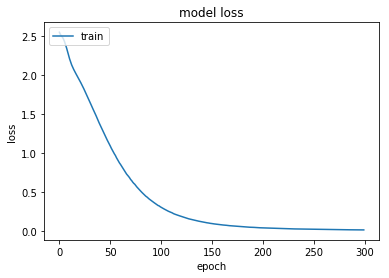

In [23]:
K.clear_session()
model = Sequential()
model.add(Dense(2000, input_dim=18662, activation="tanh"))
# model.add(Dropout(0.23))
# model.add(Dropout(0.50))
# model.add(Dropout(0.23))
# model.add(Dense(4000, activation="relu"))
# # model.add(Dropout(0.23))
# model.add(Dense(3000, activation="tanh"))
# model.add(Dense(3000, activation="tanh"))
# model.add(Dense(3000, activation="tanh"))
# model.add(Dropout(0.50))
# model.add(Dense(2000, activation="relu"))
# # model.add(Dropout(0.50))
# model.add(Dense(2000, activation="relu"))
# # model.add(Dropout(0.50))
# model.add(Dense(2000, activation="relu"))
# # model.add(Dropout(0.50))
# model.add(Dense(2000, activation="relu"))
# # model.add(Dropout(0.50))
# model.add(Dense(2000, activation="relu"))
# # model.add(Dropout(0.50))
# model.add(Dense(2000, activation="relu"))
# model.add(Dense(2000, activation="relu"))
# model.add(Dropout(0.23))
model.add(Dense(13, activation="softmax"))
model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

early_stop = EarlyStopping(monitor = 'loss', patience = 15, verbose = 1)

history = model.fit(X_train, y_train, epochs=300, batch_size=798, callbacks=[early_stop])

# summarize history for loss
plt.plot(history.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
# plt.savefig('loss1.png')

scores = model.evaluate(X_test, y_test)
print("\nAccuracy: %.2f%%" % (scores[1]*100))

In [19]:
# df.to_pickle("with_aaclass")

In [5]:
df2 = pd.read_pickle("with_trigrams_skip_grams")

In [7]:
list(df)

['EVENT',
 'OS',
 'age',
 'cancer',
 'cdr3aa',
 'segmentV',
 'unigram_cnt',
 'bigram_cnt',
 'trigram_cnt',
 'fivegram_skip1_cnt',
 'sevengram_skip2_cnt',
 'unigram_freq',
 'bigram_freq',
 'trigram_freq',
 'fivegram_skip1_freq',
 'sevengram_skip2_freq']

In [3]:
seed = 23
np.random.seed(23)


In [4]:

df["features"] = df.unigram_freq + df.bigram_freq + df.trigram_freq + df.fivegram_skip1_freq + df.sevengram_skip2_freq
X = np.array(list(df.features)).astype(float)
Y = np.array(list(df.cancer))
logger.debug(X)
logger.debug(Y)

Y_cnt = Counter(Y)
logger.debug(Y_cnt)
Y_freq = [float(Y_cnt[y]) / sum(Y_cnt.values()) for y in Y_cnt]
logger.debug(Y_freq)
encoder = LabelEncoder()
encoder.fit(Y)
encoder_Y = encoder.transform(Y)
logger.debug(encoder_Y)
dummy_y = np_utils.to_categorical(encoder_Y)
logger.debug(dummy_y)

X_train, X_test, y_train, y_test = train_test_split(X, dummy_y, test_size=0.1, random_state=23)
len(X_train[0])

[2018-04-22 23:45:04,921]-[9332]-[8612]-[etl]-[4]-[DEBUG]: [[0.08363636 0.06787879 0.08606061 ... 0.00524934 0.         0.        ]
 [0.0814603  0.0594238  0.08066857 ... 0.00272225 0.00059549 0.00161633]
 [0.07267951 0.04947461 0.07049037 ... 0.00359712 0.         0.00215827]
 ...
 [0.08215405 0.05869503 0.07260898 ... 0.0001846  0.0001846  0.0001846 ]
 [0.07993407 0.0539761  0.08075814 ... 0.00234192 0.         0.        ]
 [0.08452048 0.05962893 0.07073629 ... 0.         0.         0.00101904]]


[2018-04-22 23:45:05,011]-[9332]-[8612]-[etl]-[5]-[DEBUG]: ['THCA' 'LUSC' 'OV' ... 'LUAD' 'SKCM' 'SKCM']


[2018-04-22 23:45:05,051]-[9332]-[8612]-[etl]-[8]-[DEBUG]: Counter({'KIRC': 430, 'LUSC': 397, 'LUAD': 386, 'PRAD': 375, 'OV': 362, 'THCA': 349, 'HNSC': 336, 'STAD': 322, 'BRCA': 317, 'SKCM': 312, 'BLCA': 302, 'COAD': 262, 'READ': 91})


[2018-04-22 23:45:05,055]-[9332]-[8612]-[etl]-[10]-[DEBUG]: [0.08229191228483848, 0.09360999764206555, 0.08535722706908748, 0.06177788257486442, 0.07120962037255364, 0.07922659750058948, 0.09101626974770101, 0.07356755482197595, 0.10139118132515916, 0.07474652204668711, 0.08842254185333648, 0.07592548927139825, 0.021457203489742987]


[2018-04-22 23:45:05,078]-[9332]-[8612]-[etl]-[14]-[DEBUG]: [12  6  7 ...  5 10 10]


[2018-04-22 23:45:05,096]-[9332]-[8612]-[etl]-[16]-[DEBUG]: [[0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 1. 0. 0.]
 [0. 0. 0. ... 1. 0. 0.]]


24420

Epoch 1/300


 798/3816 [=====>........................] - ETA: 36s - loss: 2.5645 - acc: 0.0840

1596/3816 [===========>..................] - ETA: 13s - loss: 2.5544 - acc: 0.0815

2394/3816 [=================>............] - ETA: 6s - loss: 2.5561 - acc: 0.0881 

3192/3816 [========================>.....] - ETA: 2s - loss: 2.5493 - acc: 0.0952

3816/3816 [==============================] - 11s 3ms/step - loss: 2.5479 - acc: 0.0912


Epoch 2/300


 798/3816 [=====>........................] - ETA: 1s - loss: 2.5237 - acc: 0.0927

1596/3816 [===========>..................] - ETA: 0s - loss: 2.5016 - acc: 0.1460

2394/3816 [=================>............] - ETA: 0s - loss: 2.4791 - acc: 0.1299

3192/3816 [========================>.....] - ETA: 0s - loss: 2.4659 - acc: 0.1275

3816/3816 [==============================] - 2s 437us/step - loss: 2.4642 - acc: 0.1224


Epoch 3/300


 798/3816 [=====>........................] - ETA: 1s - loss: 2.2732 - acc: 0.2231

1596/3816 [===========>..................] - ETA: 0s - loss: 2.4121 - acc: 0.1579

2394/3816 [=================>............] - ETA: 0s - loss: 2.3855 - acc: 0.1558

3192/3816 [========================>.....] - ETA: 0s - loss: 2.4124 - acc: 0.1479

3816/3816 [==============================] - 2s 431us/step - loss: 2.3847 - acc: 0.1525


Epoch 4/300


 798/3816 [=====>........................] - ETA: 1s - loss: 2.2280 - acc: 0.2143

1596/3816 [===========>..................] - ETA: 0s - loss: 2.2389 - acc: 0.1986

2394/3816 [=================>............] - ETA: 0s - loss: 2.2165 - acc: 0.1876

3192/3816 [========================>.....] - ETA: 0s - loss: 2.2240 - acc: 0.1848

3816/3816 [==============================] - 2s 433us/step - loss: 2.2101 - acc: 0.1900


Epoch 5/300


 798/3816 [=====>........................] - ETA: 1s - loss: 2.1300 - acc: 0.2206

1596/3816 [===========>..................] - ETA: 0s - loss: 2.1163 - acc: 0.2243

2394/3816 [=================>............] - ETA: 0s - loss: 2.1203 - acc: 0.2264

3192/3816 [========================>.....] - ETA: 0s - loss: 2.1093 - acc: 0.2284

3816/3816 [==============================] - 2s 441us/step - loss: 2.1120 - acc: 0.2186


Epoch 6/300


 798/3816 [=====>........................] - ETA: 1s - loss: 1.9999 - acc: 0.2519

1596/3816 [===========>..................] - ETA: 0s - loss: 2.0154 - acc: 0.2563

2394/3816 [=================>............] - ETA: 0s - loss: 2.0339 - acc: 0.2615

3192/3816 [========================>.....] - ETA: 0s - loss: 2.0358 - acc: 0.2672

3816/3816 [==============================] - 2s 453us/step - loss: 2.0263 - acc: 0.2715


Epoch 7/300


 798/3816 [=====>........................] - ETA: 1s - loss: 1.9403 - acc: 0.3233

1596/3816 [===========>..................] - ETA: 0s - loss: 1.8946 - acc: 0.3308

2394/3816 [=================>............] - ETA: 0s - loss: 1.8841 - acc: 0.3375

3192/3816 [========================>.....] - ETA: 0s - loss: 1.9011 - acc: 0.3305

3816/3816 [==============================] - 2s 442us/step - loss: 1.9037 - acc: 0.3320


Epoch 8/300


 798/3816 [=====>........................] - ETA: 1s - loss: 1.9782 - acc: 0.2820

1596/3816 [===========>..................] - ETA: 0s - loss: 2.0567 - acc: 0.2356

2394/3816 [=================>............] - ETA: 0s - loss: 2.0267 - acc: 0.2356

3192/3816 [========================>.....] - ETA: 0s - loss: 2.0597 - acc: 0.2387

3816/3816 [==============================] - 2s 448us/step - loss: 2.0343 - acc: 0.2503


Epoch 9/300


 798/3816 [=====>........................] - ETA: 1s - loss: 1.7684 - acc: 0.3810

1596/3816 [===========>..................] - ETA: 0s - loss: 1.7918 - acc: 0.3471

2394/3816 [=================>............] - ETA: 0s - loss: 1.7964 - acc: 0.3601

3192/3816 [========================>.....] - ETA: 0s - loss: 1.7781 - acc: 0.3659

3816/3816 [==============================] - 2s 455us/step - loss: 1.7869 - acc: 0.3595


Epoch 10/300


 798/3816 [=====>........................] - ETA: 1s - loss: 1.6548 - acc: 0.3835

1596/3816 [===========>..................] - ETA: 1s - loss: 1.6362 - acc: 0.3891

2394/3816 [=================>............] - ETA: 0s - loss: 1.5941 - acc: 0.4223

3192/3816 [========================>.....] - ETA: 0s - loss: 1.5655 - acc: 0.4358

3816/3816 [==============================] - 2s 500us/step - loss: 1.5491 - acc: 0.4515


Epoch 11/300


 798/3816 [=====>........................] - ETA: 1s - loss: 1.4892 - acc: 0.4787

1596/3816 [===========>..................] - ETA: 1s - loss: 1.4224 - acc: 0.5313

2394/3816 [=================>............] - ETA: 0s - loss: 1.4396 - acc: 0.5121

3192/3816 [========================>.....] - ETA: 0s - loss: 1.4700 - acc: 0.4925

3816/3816 [==============================] - 2s 474us/step - loss: 1.4790 - acc: 0.4898


Epoch 12/300


 798/3816 [=====>........................] - ETA: 1s - loss: 1.5482 - acc: 0.4875

1596/3816 [===========>..................] - ETA: 0s - loss: 1.7639 - acc: 0.4430

2394/3816 [=================>............] - ETA: 0s - loss: 1.8228 - acc: 0.4177

3192/3816 [========================>.....] - ETA: 0s - loss: 1.8403 - acc: 0.3988

3816/3816 [==============================] - 2s 444us/step - loss: 1.9187 - acc: 0.3847


Epoch 13/300


 798/3816 [=====>........................] - ETA: 1s - loss: 2.5742 - acc: 0.3647

1596/3816 [===========>..................] - ETA: 0s - loss: 2.4077 - acc: 0.3672

2394/3816 [=================>............] - ETA: 0s - loss: 2.3986 - acc: 0.3584

3192/3816 [========================>.....] - ETA: 0s - loss: 2.2160 - acc: 0.3722

3816/3816 [==============================] - 2s 443us/step - loss: 2.0794 - acc: 0.4017


Epoch 14/300


 798/3816 [=====>........................] - ETA: 1s - loss: 1.6196 - acc: 0.4336

1596/3816 [===========>..................] - ETA: 0s - loss: 1.6539 - acc: 0.4229

2394/3816 [=================>............] - ETA: 0s - loss: 1.5177 - acc: 0.4628

3192/3816 [========================>.....] - ETA: 0s - loss: 1.5778 - acc: 0.4342

3816/3816 [==============================] - 2s 447us/step - loss: 1.5602 - acc: 0.4311


Epoch 15/300


 798/3816 [=====>........................] - ETA: 1s - loss: 1.6760 - acc: 0.3747

1596/3816 [===========>..................] - ETA: 0s - loss: 1.4338 - acc: 0.4762

2394/3816 [=================>............] - ETA: 0s - loss: 1.4592 - acc: 0.4666

3192/3816 [========================>.....] - ETA: 0s - loss: 1.4383 - acc: 0.4806

3816/3816 [==============================] - 2s 439us/step - loss: 1.4066 - acc: 0.4822


Epoch 16/300


 798/3816 [=====>........................] - ETA: 1s - loss: 1.5589 - acc: 0.3835

1596/3816 [===========>..................] - ETA: 0s - loss: 1.5919 - acc: 0.4273

2394/3816 [=================>............] - ETA: 0s - loss: 1.5432 - acc: 0.4336

3192/3816 [========================>.....] - ETA: 0s - loss: 1.4794 - acc: 0.4508

3816/3816 [==============================] - 2s 446us/step - loss: 1.5077 - acc: 0.4403


Epoch 17/300


 798/3816 [=====>........................] - ETA: 1s - loss: 1.1318 - acc: 0.6241

1596/3816 [===========>..................] - ETA: 1s - loss: 1.1453 - acc: 0.6059

2394/3816 [=================>............] - ETA: 0s - loss: 1.1765 - acc: 0.5815

3192/3816 [========================>.....] - ETA: 0s - loss: 1.1539 - acc: 0.5865

3816/3816 [==============================] - 2s 474us/step - loss: 1.1186 - acc: 0.6101


Epoch 18/300


 798/3816 [=====>........................] - ETA: 1s - loss: 1.0151 - acc: 0.6717

1596/3816 [===========>..................] - ETA: 1s - loss: 1.0128 - acc: 0.6422

2394/3816 [=================>............] - ETA: 0s - loss: 0.9895 - acc: 0.6550

3192/3816 [========================>.....] - ETA: 0s - loss: 0.9650 - acc: 0.6786

3816/3816 [==============================] - 2s 490us/step - loss: 0.9439 - acc: 0.6916


Epoch 19/300


 798/3816 [=====>........................] - ETA: 1s - loss: 0.8497 - acc: 0.7068

1596/3816 [===========>..................] - ETA: 0s - loss: 0.8481 - acc: 0.7256

2394/3816 [=================>............] - ETA: 0s - loss: 0.8305 - acc: 0.7306

3192/3816 [========================>.....] - ETA: 0s - loss: 0.8272 - acc: 0.7415

3816/3816 [==============================] - 2s 453us/step - loss: 0.8317 - acc: 0.7411


Epoch 20/300


 798/3816 [=====>........................] - ETA: 1s - loss: 0.8442 - acc: 0.7068

1596/3816 [===========>..................] - ETA: 0s - loss: 0.7612 - acc: 0.7632

2394/3816 [=================>............] - ETA: 0s - loss: 0.7481 - acc: 0.7686

3192/3816 [========================>.....] - ETA: 0s - loss: 0.7964 - acc: 0.7365

3816/3816 [==============================] - 2s 455us/step - loss: 0.8335 - acc: 0.7220


Epoch 21/300


 798/3816 [=====>........................] - ETA: 1s - loss: 0.8507 - acc: 0.6880

1596/3816 [===========>..................] - ETA: 0s - loss: 0.8759 - acc: 0.6817

2394/3816 [=================>............] - ETA: 0s - loss: 0.9191 - acc: 0.6688

3192/3816 [========================>.....] - ETA: 0s - loss: 0.9219 - acc: 0.6635

3816/3816 [==============================] - 2s 450us/step - loss: 0.8861 - acc: 0.6771


Epoch 22/300


 798/3816 [=====>........................] - ETA: 1s - loss: 0.6970 - acc: 0.7506

1596/3816 [===========>..................] - ETA: 1s - loss: 0.7337 - acc: 0.7381

2394/3816 [=================>............] - ETA: 0s - loss: 0.8338 - acc: 0.7051

3192/3816 [========================>.....] - ETA: 0s - loss: 0.8456 - acc: 0.7108

3816/3816 [==============================] - 2s 491us/step - loss: 0.8453 - acc: 0.7068


Epoch 23/300


 798/3816 [=====>........................] - ETA: 1s - loss: 0.9614 - acc: 0.6629

1596/3816 [===========>..................] - ETA: 1s - loss: 0.9666 - acc: 0.6861

2394/3816 [=================>............] - ETA: 0s - loss: 0.8285 - acc: 0.7302

3192/3816 [========================>.....] - ETA: 0s - loss: 0.9192 - acc: 0.7083

3816/3816 [==============================] - 2s 477us/step - loss: 1.0356 - acc: 0.6808


Epoch 24/300


 798/3816 [=====>........................] - ETA: 1s - loss: 2.5038 - acc: 0.4386

1596/3816 [===========>..................] - ETA: 1s - loss: 1.6726 - acc: 0.5583

2394/3816 [=================>............] - ETA: 0s - loss: 1.8069 - acc: 0.5017

3192/3816 [========================>.....] - ETA: 0s - loss: 1.6791 - acc: 0.5282

3816/3816 [==============================] - 2s 477us/step - loss: 1.7688 - acc: 0.5063


Epoch 25/300


 798/3816 [=====>........................] - ETA: 1s - loss: 1.8804 - acc: 0.4737

1596/3816 [===========>..................] - ETA: 1s - loss: 1.3406 - acc: 0.6034

2394/3816 [=================>............] - ETA: 0s - loss: 1.4043 - acc: 0.5869

3192/3816 [========================>.....] - ETA: 0s - loss: 1.4231 - acc: 0.5674

3816/3816 [==============================] - 2s 477us/step - loss: 1.3699 - acc: 0.5844


Epoch 26/300


 798/3816 [=====>........................] - ETA: 1s - loss: 1.3312 - acc: 0.5764

1596/3816 [===========>..................] - ETA: 0s - loss: 1.1498 - acc: 0.6560

2394/3816 [=================>............] - ETA: 0s - loss: 1.0747 - acc: 0.6763

3192/3816 [========================>.....] - ETA: 0s - loss: 0.9735 - acc: 0.6955

3816/3816 [==============================] - 2s 483us/step - loss: 0.9572 - acc: 0.6876


Epoch 27/300


 798/3816 [=====>........................] - ETA: 1s - loss: 0.8465 - acc: 0.7093

1596/3816 [===========>..................] - ETA: 1s - loss: 0.7983 - acc: 0.7356

2394/3816 [=================>............] - ETA: 0s - loss: 0.8267 - acc: 0.7281

3192/3816 [========================>.....] - ETA: 0s - loss: 0.7943 - acc: 0.7325

3816/3816 [==============================] - 2s 480us/step - loss: 0.7791 - acc: 0.7319


Epoch 28/300


 798/3816 [=====>........................] - ETA: 1s - loss: 0.5842 - acc: 0.8183

1596/3816 [===========>..................] - ETA: 1s - loss: 0.5589 - acc: 0.8233

2394/3816 [=================>............] - ETA: 0s - loss: 0.5843 - acc: 0.7995

3192/3816 [========================>.....] - ETA: 0s - loss: 0.5631 - acc: 0.8048

3816/3816 [==============================] - 2s 479us/step - loss: 0.5425 - acc: 0.8192


Epoch 29/300


 798/3816 [=====>........................] - ETA: 1s - loss: 0.4250 - acc: 0.8872

1596/3816 [===========>..................] - ETA: 1s - loss: 0.4321 - acc: 0.8916

2394/3816 [=================>............] - ETA: 0s - loss: 0.4451 - acc: 0.8885

3192/3816 [========================>.....] - ETA: 0s - loss: 0.4293 - acc: 0.8916

3816/3816 [==============================] - 2s 472us/step - loss: 0.4165 - acc: 0.8965


Epoch 30/300


 798/3816 [=====>........................] - ETA: 1s - loss: 0.3448 - acc: 0.9185

1596/3816 [===========>..................] - ETA: 1s - loss: 0.3355 - acc: 0.9223

2394/3816 [=================>............] - ETA: 0s - loss: 0.3382 - acc: 0.9227

3192/3816 [========================>.....] - ETA: 0s - loss: 0.3280 - acc: 0.9236

3816/3816 [==============================] - 2s 482us/step - loss: 0.3262 - acc: 0.9245


Epoch 31/300


 798/3816 [=====>........................] - ETA: 1s - loss: 0.2947 - acc: 0.9236

1596/3816 [===========>..................] - ETA: 1s - loss: 0.3038 - acc: 0.9273

2394/3816 [=================>............] - ETA: 0s - loss: 0.2911 - acc: 0.9323

3192/3816 [========================>.....] - ETA: 0s - loss: 0.2813 - acc: 0.9352

3816/3816 [==============================] - 2s 471us/step - loss: 0.2738 - acc: 0.9371


Epoch 32/300


 798/3816 [=====>........................] - ETA: 1s - loss: 0.2786 - acc: 0.9424

1596/3816 [===========>..................] - ETA: 1s - loss: 0.2752 - acc: 0.9373

2394/3816 [=================>............] - ETA: 0s - loss: 0.2611 - acc: 0.9373

3192/3816 [========================>.....] - ETA: 0s - loss: 0.2472 - acc: 0.9430

3816/3816 [==============================] - 2s 479us/step - loss: 0.2441 - acc: 0.9429


Epoch 33/300


 798/3816 [=====>........................] - ETA: 1s - loss: 0.2301 - acc: 0.9386

1596/3816 [===========>..................] - ETA: 1s - loss: 0.2212 - acc: 0.9436

2394/3816 [=================>............] - ETA: 0s - loss: 0.2098 - acc: 0.9461

3192/3816 [========================>.....] - ETA: 0s - loss: 0.2047 - acc: 0.9518

3816/3816 [==============================] - 2s 464us/step - loss: 0.2047 - acc: 0.9520


Epoch 34/300


 798/3816 [=====>........................] - ETA: 1s - loss: 0.1568 - acc: 0.9637

1596/3816 [===========>..................] - ETA: 0s - loss: 0.1743 - acc: 0.9593

2394/3816 [=================>............] - ETA: 0s - loss: 0.1770 - acc: 0.9578

3192/3816 [========================>.....] - ETA: 0s - loss: 0.1779 - acc: 0.9561

3816/3816 [==============================] - 2s 472us/step - loss: 0.1746 - acc: 0.9562


Epoch 35/300


 798/3816 [=====>........................] - ETA: 1s - loss: 0.1529 - acc: 0.9662

1596/3816 [===========>..................] - ETA: 1s - loss: 0.1643 - acc: 0.9555

2394/3816 [=================>............] - ETA: 0s - loss: 0.1558 - acc: 0.9599

3192/3816 [========================>.....] - ETA: 0s - loss: 0.1509 - acc: 0.9621

3816/3816 [==============================] - 2s 479us/step - loss: 0.1543 - acc: 0.9612


Epoch 36/300


 798/3816 [=====>........................] - ETA: 1s - loss: 0.1301 - acc: 0.9799

1596/3816 [===========>..................] - ETA: 1s - loss: 0.1502 - acc: 0.9706

2394/3816 [=================>............] - ETA: 0s - loss: 0.1341 - acc: 0.9733

3192/3816 [========================>.....] - ETA: 0s - loss: 0.1455 - acc: 0.9668

3816/3816 [==============================] - 2s 499us/step - loss: 0.1438 - acc: 0.9678


Epoch 37/300


 798/3816 [=====>........................] - ETA: 1s - loss: 0.1227 - acc: 0.9724

1596/3816 [===========>..................] - ETA: 1s - loss: 0.1318 - acc: 0.9624

2394/3816 [=================>............] - ETA: 0s - loss: 0.1220 - acc: 0.9703

3192/3816 [========================>.....] - ETA: 0s - loss: 0.1237 - acc: 0.9693

3816/3816 [==============================] - 2s 476us/step - loss: 0.1197 - acc: 0.9709


Epoch 38/300


 798/3816 [=====>........................] - ETA: 1s - loss: 0.1151 - acc: 0.9799

1596/3816 [===========>..................] - ETA: 1s - loss: 0.1243 - acc: 0.9774

2394/3816 [=================>............] - ETA: 0s - loss: 0.1055 - acc: 0.9799

3192/3816 [========================>.....] - ETA: 0s - loss: 0.1027 - acc: 0.9815

3816/3816 [==============================] - 2s 475us/step - loss: 0.0998 - acc: 0.9822


Epoch 39/300


 798/3816 [=====>........................] - ETA: 1s - loss: 0.0795 - acc: 0.9799

1596/3816 [===========>..................] - ETA: 1s - loss: 0.0848 - acc: 0.9806

2394/3816 [=================>............] - ETA: 0s - loss: 0.0833 - acc: 0.9825

3192/3816 [========================>.....] - ETA: 0s - loss: 0.0794 - acc: 0.9831

3816/3816 [==============================] - 2s 471us/step - loss: 0.0798 - acc: 0.9838


Epoch 40/300


 798/3816 [=====>........................] - ETA: 1s - loss: 0.0697 - acc: 0.9900

1596/3816 [===========>..................] - ETA: 1s - loss: 0.0713 - acc: 0.9893

2394/3816 [=================>............] - ETA: 0s - loss: 0.0711 - acc: 0.9883

3192/3816 [========================>.....] - ETA: 0s - loss: 0.0702 - acc: 0.9881

3816/3816 [==============================] - 2s 489us/step - loss: 0.0668 - acc: 0.9887


Epoch 41/300


 798/3816 [=====>........................] - ETA: 1s - loss: 0.0718 - acc: 0.9875

1596/3816 [===========>..................] - ETA: 1s - loss: 0.0580 - acc: 0.9919

2394/3816 [=================>............] - ETA: 0s - loss: 0.0560 - acc: 0.9933

3192/3816 [========================>.....] - ETA: 0s - loss: 0.0537 - acc: 0.9934

3816/3816 [==============================] - 2s 474us/step - loss: 0.0554 - acc: 0.9919


Epoch 42/300


 798/3816 [=====>........................] - ETA: 1s - loss: 0.0555 - acc: 0.9925

1596/3816 [===========>..................] - ETA: 1s - loss: 0.0502 - acc: 0.9944

2394/3816 [=================>............] - ETA: 0s - loss: 0.0507 - acc: 0.9937

3192/3816 [========================>.....] - ETA: 0s - loss: 0.0480 - acc: 0.9950

3816/3816 [==============================] - 2s 479us/step - loss: 0.0468 - acc: 0.9950


Epoch 43/300


 798/3816 [=====>........................] - ETA: 1s - loss: 0.0503 - acc: 0.9900

1596/3816 [===========>..................] - ETA: 1s - loss: 0.0441 - acc: 0.9937

2394/3816 [=================>............] - ETA: 0s - loss: 0.0396 - acc: 0.9950

3192/3816 [========================>.....] - ETA: 0s - loss: 0.0397 - acc: 0.9953

3816/3816 [==============================] - 2s 479us/step - loss: 0.0394 - acc: 0.9948


Epoch 44/300


 798/3816 [=====>........................] - ETA: 1s - loss: 0.0361 - acc: 0.9975

1596/3816 [===========>..................] - ETA: 1s - loss: 0.0320 - acc: 0.9975

2394/3816 [=================>............] - ETA: 0s - loss: 0.0313 - acc: 0.9979

3192/3816 [========================>.....] - ETA: 0s - loss: 0.0313 - acc: 0.9972

3816/3816 [==============================] - 2s 483us/step - loss: 0.0327 - acc: 0.9958


Epoch 45/300


 798/3816 [=====>........................] - ETA: 1s - loss: 0.0284 - acc: 0.9962

1596/3816 [===========>..................] - ETA: 1s - loss: 0.0290 - acc: 0.9962

2394/3816 [=================>............] - ETA: 0s - loss: 0.0280 - acc: 0.9962

3192/3816 [========================>.....] - ETA: 0s - loss: 0.0281 - acc: 0.9962

3816/3816 [==============================] - 2s 484us/step - loss: 0.0273 - acc: 0.9969


Epoch 46/300


 798/3816 [=====>........................] - ETA: 1s - loss: 0.0272 - acc: 0.9962

1596/3816 [===========>..................] - ETA: 1s - loss: 0.0253 - acc: 0.9975

2394/3816 [=================>............] - ETA: 0s - loss: 0.0263 - acc: 0.9979

3192/3816 [========================>.....] - ETA: 0s - loss: 0.0248 - acc: 0.9978

3816/3816 [==============================] - 2s 471us/step - loss: 0.0241 - acc: 0.9982


Epoch 47/300


 798/3816 [=====>........................] - ETA: 1s - loss: 0.0192 - acc: 1.0000

1596/3816 [===========>..................] - ETA: 1s - loss: 0.0194 - acc: 0.9994

2394/3816 [=================>............] - ETA: 0s - loss: 0.0208 - acc: 0.9992

3192/3816 [========================>.....] - ETA: 0s - loss: 0.0206 - acc: 0.9991

3816/3816 [==============================] - 2s 475us/step - loss: 0.0200 - acc: 0.9992


Epoch 48/300


 798/3816 [=====>........................] - ETA: 1s - loss: 0.0167 - acc: 1.0000

1596/3816 [===========>..................] - ETA: 1s - loss: 0.0181 - acc: 0.9994

2394/3816 [=================>............] - ETA: 0s - loss: 0.0172 - acc: 0.9996

3192/3816 [========================>.....] - ETA: 0s - loss: 0.0173 - acc: 0.9997

3816/3816 [==============================] - 2s 480us/step - loss: 0.0175 - acc: 0.9995


Epoch 49/300


 798/3816 [=====>........................] - ETA: 1s - loss: 0.0160 - acc: 1.0000

1596/3816 [===========>..................] - ETA: 1s - loss: 0.0157 - acc: 1.0000

2394/3816 [=================>............] - ETA: 0s - loss: 0.0161 - acc: 0.9996

3192/3816 [========================>.....] - ETA: 0s - loss: 0.0152 - acc: 0.9997

3816/3816 [==============================] - 2s 489us/step - loss: 0.0166 - acc: 0.9990


Epoch 50/300


 798/3816 [=====>........................] - ETA: 1s - loss: 0.0126 - acc: 1.0000

1596/3816 [===========>..................] - ETA: 1s - loss: 0.0141 - acc: 1.0000

2394/3816 [=================>............] - ETA: 0s - loss: 0.0149 - acc: 0.9996

3192/3816 [========================>.....] - ETA: 0s - loss: 0.0152 - acc: 0.9997

3816/3816 [==============================] - 2s 479us/step - loss: 0.0145 - acc: 0.9997


Epoch 51/300


 798/3816 [=====>........................] - ETA: 1s - loss: 0.0133 - acc: 1.0000

1596/3816 [===========>..................] - ETA: 1s - loss: 0.0128 - acc: 1.0000

2394/3816 [=================>............] - ETA: 0s - loss: 0.0135 - acc: 0.9996

3192/3816 [========================>.....] - ETA: 0s - loss: 0.0131 - acc: 0.9997

3816/3816 [==============================] - 2s 486us/step - loss: 0.0133 - acc: 0.9997


Epoch 52/300


 798/3816 [=====>........................] - ETA: 1s - loss: 0.0106 - acc: 1.0000

1596/3816 [===========>..................] - ETA: 1s - loss: 0.0122 - acc: 1.0000

2394/3816 [=================>............] - ETA: 0s - loss: 0.0122 - acc: 1.0000

3192/3816 [========================>.....] - ETA: 0s - loss: 0.0132 - acc: 0.9997

3816/3816 [==============================] - 2s 483us/step - loss: 0.0129 - acc: 0.9997


Epoch 53/300


 798/3816 [=====>........................] - ETA: 1s - loss: 0.0110 - acc: 1.0000

1596/3816 [===========>..................] - ETA: 1s - loss: 0.0109 - acc: 1.0000

2394/3816 [=================>............] - ETA: 0s - loss: 0.0113 - acc: 1.0000

3192/3816 [========================>.....] - ETA: 0s - loss: 0.0112 - acc: 1.0000

3816/3816 [==============================] - 2s 470us/step - loss: 0.0112 - acc: 1.0000


Epoch 54/300


 798/3816 [=====>........................] - ETA: 1s - loss: 0.0104 - acc: 1.0000

1596/3816 [===========>..................] - ETA: 0s - loss: 0.0097 - acc: 1.0000

2394/3816 [=================>............] - ETA: 0s - loss: 0.0100 - acc: 1.0000

3192/3816 [========================>.....] - ETA: 0s - loss: 0.0099 - acc: 1.0000

3816/3816 [==============================] - 2s 467us/step - loss: 0.0098 - acc: 1.0000


Epoch 55/300


 798/3816 [=====>........................] - ETA: 1s - loss: 0.0087 - acc: 1.0000

1596/3816 [===========>..................] - ETA: 1s - loss: 0.0095 - acc: 1.0000

2394/3816 [=================>............] - ETA: 0s - loss: 0.0092 - acc: 1.0000

3192/3816 [========================>.....] - ETA: 0s - loss: 0.0090 - acc: 0.9997

3816/3816 [==============================] - 2s 482us/step - loss: 0.0087 - acc: 0.9997


Epoch 56/300


 798/3816 [=====>........................] - ETA: 1s - loss: 0.0079 - acc: 0.9987

1596/3816 [===========>..................] - ETA: 1s - loss: 0.0082 - acc: 0.9994

2394/3816 [=================>............] - ETA: 0s - loss: 0.0075 - acc: 0.9996

3192/3816 [========================>.....] - ETA: 0s - loss: 0.0077 - acc: 0.9997

3816/3816 [==============================] - 2s 485us/step - loss: 0.0078 - acc: 0.9997


Epoch 57/300


 798/3816 [=====>........................] - ETA: 1s - loss: 0.0084 - acc: 1.0000

1596/3816 [===========>..................] - ETA: 1s - loss: 0.0079 - acc: 0.9994

2394/3816 [=================>............] - ETA: 0s - loss: 0.0074 - acc: 0.9996

3192/3816 [========================>.....] - ETA: 0s - loss: 0.0073 - acc: 0.9997

3816/3816 [==============================] - 2s 501us/step - loss: 0.0072 - acc: 0.9997


Epoch 58/300


 798/3816 [=====>........................] - ETA: 1s - loss: 0.0073 - acc: 1.0000

1596/3816 [===========>..................] - ETA: 1s - loss: 0.0075 - acc: 1.0000

2394/3816 [=================>............] - ETA: 0s - loss: 0.0073 - acc: 1.0000

3192/3816 [========================>.....] - ETA: 0s - loss: 0.0070 - acc: 1.0000

3816/3816 [==============================] - 2s 481us/step - loss: 0.0068 - acc: 1.0000


Epoch 59/300


 798/3816 [=====>........................] - ETA: 1s - loss: 0.0062 - acc: 1.0000

1596/3816 [===========>..................] - ETA: 1s - loss: 0.0060 - acc: 1.0000

2394/3816 [=================>............] - ETA: 0s - loss: 0.0059 - acc: 1.0000

3192/3816 [========================>.....] - ETA: 0s - loss: 0.0060 - acc: 1.0000

3816/3816 [==============================] - 2s 469us/step - loss: 0.0060 - acc: 1.0000


Epoch 60/300


 798/3816 [=====>........................] - ETA: 1s - loss: 0.0060 - acc: 1.0000

1596/3816 [===========>..................] - ETA: 1s - loss: 0.0061 - acc: 1.0000

2394/3816 [=================>............] - ETA: 0s - loss: 0.0061 - acc: 1.0000

3192/3816 [========================>.....] - ETA: 0s - loss: 0.0059 - acc: 1.0000

3816/3816 [==============================] - 2s 485us/step - loss: 0.0060 - acc: 1.0000


Epoch 61/300


 798/3816 [=====>........................] - ETA: 1s - loss: 0.0052 - acc: 1.0000

1596/3816 [===========>..................] - ETA: 1s - loss: 0.0051 - acc: 1.0000

2394/3816 [=================>............] - ETA: 0s - loss: 0.0052 - acc: 1.0000

3192/3816 [========================>.....] - ETA: 0s - loss: 0.0053 - acc: 1.0000

3816/3816 [==============================] - 2s 478us/step - loss: 0.0054 - acc: 1.0000


Epoch 62/300


 798/3816 [=====>........................] - ETA: 1s - loss: 0.0056 - acc: 1.0000

1596/3816 [===========>..................] - ETA: 1s - loss: 0.0053 - acc: 1.0000

2394/3816 [=================>............] - ETA: 0s - loss: 0.0052 - acc: 1.0000

3192/3816 [========================>.....] - ETA: 0s - loss: 0.0051 - acc: 1.0000

3816/3816 [==============================] - 2s 484us/step - loss: 0.0052 - acc: 1.0000


Epoch 63/300


 798/3816 [=====>........................] - ETA: 1s - loss: 0.0054 - acc: 1.0000

1596/3816 [===========>..................] - ETA: 1s - loss: 0.0045 - acc: 1.0000

2394/3816 [=================>............] - ETA: 0s - loss: 0.0045 - acc: 1.0000

3192/3816 [========================>.....] - ETA: 0s - loss: 0.0045 - acc: 1.0000

3816/3816 [==============================] - 2s 498us/step - loss: 0.0045 - acc: 1.0000


Epoch 64/300


 798/3816 [=====>........................] - ETA: 1s - loss: 0.0040 - acc: 1.0000

1596/3816 [===========>..................] - ETA: 1s - loss: 0.0044 - acc: 1.0000

2394/3816 [=================>............] - ETA: 0s - loss: 0.0044 - acc: 1.0000

3192/3816 [========================>.....] - ETA: 0s - loss: 0.0043 - acc: 1.0000

3816/3816 [==============================] - 2s 480us/step - loss: 0.0044 - acc: 1.0000


Epoch 65/300


 798/3816 [=====>........................] - ETA: 1s - loss: 0.0040 - acc: 1.0000

1596/3816 [===========>..................] - ETA: 1s - loss: 0.0042 - acc: 1.0000

2394/3816 [=================>............] - ETA: 0s - loss: 0.0043 - acc: 1.0000

3192/3816 [========================>.....] - ETA: 0s - loss: 0.0043 - acc: 1.0000

3816/3816 [==============================] - 2s 502us/step - loss: 0.0043 - acc: 1.0000


Epoch 66/300


 798/3816 [=====>........................] - ETA: 1s - loss: 0.0038 - acc: 1.0000

1596/3816 [===========>..................] - ETA: 1s - loss: 0.0037 - acc: 1.0000

2394/3816 [=================>............] - ETA: 0s - loss: 0.0042 - acc: 0.9996

3192/3816 [========================>.....] - ETA: 0s - loss: 0.0041 - acc: 0.9997

3816/3816 [==============================] - 2s 469us/step - loss: 0.0041 - acc: 0.9997


Epoch 67/300


 798/3816 [=====>........................] - ETA: 1s - loss: 0.0041 - acc: 1.0000

1596/3816 [===========>..................] - ETA: 1s - loss: 0.0037 - acc: 1.0000

2394/3816 [=================>............] - ETA: 0s - loss: 0.0035 - acc: 1.0000

3192/3816 [========================>.....] - ETA: 0s - loss: 0.0036 - acc: 1.0000

3816/3816 [==============================] - 2s 470us/step - loss: 0.0037 - acc: 1.0000


Epoch 68/300


 798/3816 [=====>........................] - ETA: 1s - loss: 0.0036 - acc: 1.0000

1596/3816 [===========>..................] - ETA: 1s - loss: 0.0035 - acc: 1.0000

2394/3816 [=================>............] - ETA: 0s - loss: 0.0035 - acc: 1.0000

3192/3816 [========================>.....] - ETA: 0s - loss: 0.0035 - acc: 1.0000

3816/3816 [==============================] - 2s 485us/step - loss: 0.0035 - acc: 1.0000


Epoch 69/300


 798/3816 [=====>........................] - ETA: 1s - loss: 0.0033 - acc: 1.0000

1596/3816 [===========>..................] - ETA: 1s - loss: 0.0033 - acc: 1.0000

2394/3816 [=================>............] - ETA: 0s - loss: 0.0035 - acc: 1.0000

3192/3816 [========================>.....] - ETA: 0s - loss: 0.0033 - acc: 1.0000

3816/3816 [==============================] - 2s 485us/step - loss: 0.0033 - acc: 1.0000


Epoch 70/300


 798/3816 [=====>........................] - ETA: 1s - loss: 0.0036 - acc: 1.0000

1596/3816 [===========>..................] - ETA: 1s - loss: 0.0032 - acc: 1.0000

2394/3816 [=================>............] - ETA: 0s - loss: 0.0033 - acc: 1.0000

3192/3816 [========================>.....] - ETA: 0s - loss: 0.0033 - acc: 1.0000

3816/3816 [==============================] - 2s 479us/step - loss: 0.0034 - acc: 1.0000


Epoch 71/300


 798/3816 [=====>........................] - ETA: 1s - loss: 0.0032 - acc: 1.0000

1596/3816 [===========>..................] - ETA: 1s - loss: 0.0030 - acc: 1.0000

2394/3816 [=================>............] - ETA: 0s - loss: 0.0030 - acc: 1.0000

3192/3816 [========================>.....] - ETA: 0s - loss: 0.0030 - acc: 1.0000

3816/3816 [==============================] - 2s 478us/step - loss: 0.0030 - acc: 1.0000


Epoch 72/300


 798/3816 [=====>........................] - ETA: 1s - loss: 0.0029 - acc: 1.0000

1596/3816 [===========>..................] - ETA: 1s - loss: 0.0032 - acc: 1.0000

2394/3816 [=================>............] - ETA: 0s - loss: 0.0030 - acc: 1.0000

3192/3816 [========================>.....] - ETA: 0s - loss: 0.0031 - acc: 1.0000

3816/3816 [==============================] - 2s 474us/step - loss: 0.0031 - acc: 1.0000


Epoch 73/300


 798/3816 [=====>........................] - ETA: 1s - loss: 0.0030 - acc: 1.0000

1596/3816 [===========>..................] - ETA: 1s - loss: 0.0030 - acc: 1.0000

2394/3816 [=================>............] - ETA: 0s - loss: 0.0029 - acc: 1.0000

3192/3816 [========================>.....] - ETA: 0s - loss: 0.0028 - acc: 1.0000

3816/3816 [==============================] - 2s 481us/step - loss: 0.0028 - acc: 1.0000


Epoch 74/300


 798/3816 [=====>........................] - ETA: 1s - loss: 0.0024 - acc: 1.0000

1596/3816 [===========>..................] - ETA: 1s - loss: 0.0027 - acc: 1.0000

2394/3816 [=================>............] - ETA: 0s - loss: 0.0028 - acc: 1.0000

3192/3816 [========================>.....] - ETA: 0s - loss: 0.0028 - acc: 1.0000

3816/3816 [==============================] - 2s 475us/step - loss: 0.0027 - acc: 1.0000


Epoch 75/300


 798/3816 [=====>........................] - ETA: 1s - loss: 0.0027 - acc: 1.0000

1596/3816 [===========>..................] - ETA: 1s - loss: 0.0027 - acc: 1.0000

2394/3816 [=================>............] - ETA: 0s - loss: 0.0026 - acc: 1.0000

3192/3816 [========================>.....] - ETA: 0s - loss: 0.0027 - acc: 1.0000

3816/3816 [==============================] - 2s 483us/step - loss: 0.0026 - acc: 1.0000


Epoch 76/300


 798/3816 [=====>........................] - ETA: 1s - loss: 0.0025 - acc: 1.0000

1596/3816 [===========>..................] - ETA: 1s - loss: 0.0024 - acc: 1.0000

2394/3816 [=================>............] - ETA: 0s - loss: 0.0023 - acc: 1.0000

3192/3816 [========================>.....] - ETA: 0s - loss: 0.0024 - acc: 1.0000

3816/3816 [==============================] - 2s 489us/step - loss: 0.0025 - acc: 1.0000


Epoch 77/300


 798/3816 [=====>........................] - ETA: 1s - loss: 0.0023 - acc: 1.0000

1596/3816 [===========>..................] - ETA: 1s - loss: 0.0025 - acc: 1.0000

2394/3816 [=================>............] - ETA: 0s - loss: 0.0024 - acc: 1.0000

3192/3816 [========================>.....] - ETA: 0s - loss: 0.0024 - acc: 1.0000

3816/3816 [==============================] - 2s 488us/step - loss: 0.0023 - acc: 1.0000


Epoch 78/300


 798/3816 [=====>........................] - ETA: 1s - loss: 0.0021 - acc: 1.0000

1596/3816 [===========>..................] - ETA: 1s - loss: 0.0024 - acc: 1.0000

2394/3816 [=================>............] - ETA: 0s - loss: 0.0023 - acc: 1.0000

3192/3816 [========================>.....] - ETA: 0s - loss: 0.0023 - acc: 1.0000

3816/3816 [==============================] - 2s 494us/step - loss: 0.0022 - acc: 1.0000


Epoch 79/300


 798/3816 [=====>........................] - ETA: 1s - loss: 0.0024 - acc: 1.0000

1596/3816 [===========>..................] - ETA: 1s - loss: 0.0022 - acc: 1.0000

2394/3816 [=================>............] - ETA: 0s - loss: 0.0021 - acc: 1.0000

3192/3816 [========================>.....] - ETA: 0s - loss: 0.0022 - acc: 1.0000

3816/3816 [==============================] - 2s 480us/step - loss: 0.0022 - acc: 1.0000


Epoch 80/300


 798/3816 [=====>........................] - ETA: 1s - loss: 0.0021 - acc: 1.0000

1596/3816 [===========>..................] - ETA: 1s - loss: 0.0022 - acc: 1.0000

2394/3816 [=================>............] - ETA: 0s - loss: 0.0021 - acc: 1.0000

3192/3816 [========================>.....] - ETA: 0s - loss: 0.0021 - acc: 1.0000

3816/3816 [==============================] - 2s 486us/step - loss: 0.0021 - acc: 1.0000


Epoch 81/300


 798/3816 [=====>........................] - ETA: 1s - loss: 0.0021 - acc: 1.0000

1596/3816 [===========>..................] - ETA: 1s - loss: 0.0022 - acc: 1.0000

2394/3816 [=================>............] - ETA: 0s - loss: 0.0022 - acc: 1.0000

3192/3816 [========================>.....] - ETA: 0s - loss: 0.0022 - acc: 1.0000

3816/3816 [==============================] - 2s 481us/step - loss: 0.0021 - acc: 1.0000


Epoch 82/300


 798/3816 [=====>........................] - ETA: 1s - loss: 0.0022 - acc: 1.0000

1596/3816 [===========>..................] - ETA: 1s - loss: 0.0021 - acc: 1.0000

2394/3816 [=================>............] - ETA: 0s - loss: 0.0020 - acc: 1.0000

3192/3816 [========================>.....] - ETA: 0s - loss: 0.0020 - acc: 1.0000

3816/3816 [==============================] - 2s 489us/step - loss: 0.0020 - acc: 1.0000


Epoch 83/300


 798/3816 [=====>........................] - ETA: 1s - loss: 0.0018 - acc: 1.0000

1596/3816 [===========>..................] - ETA: 1s - loss: 0.0019 - acc: 1.0000

2394/3816 [=================>............] - ETA: 0s - loss: 0.0020 - acc: 1.0000

3192/3816 [========================>.....] - ETA: 0s - loss: 0.0019 - acc: 1.0000

3816/3816 [==============================] - 2s 493us/step - loss: 0.0020 - acc: 1.0000


Epoch 84/300


 798/3816 [=====>........................] - ETA: 1s - loss: 0.0019 - acc: 1.0000

1596/3816 [===========>..................] - ETA: 1s - loss: 0.0018 - acc: 1.0000

2394/3816 [=================>............] - ETA: 0s - loss: 0.0017 - acc: 1.0000

3192/3816 [========================>.....] - ETA: 0s - loss: 0.0018 - acc: 1.0000

3816/3816 [==============================] - 2s 475us/step - loss: 0.0018 - acc: 1.0000


Epoch 85/300


 798/3816 [=====>........................] - ETA: 1s - loss: 0.0018 - acc: 1.0000

1596/3816 [===========>..................] - ETA: 1s - loss: 0.0018 - acc: 1.0000

2394/3816 [=================>............] - ETA: 0s - loss: 0.0019 - acc: 1.0000

3192/3816 [========================>.....] - ETA: 0s - loss: 0.0019 - acc: 1.0000

3816/3816 [==============================] - 2s 475us/step - loss: 0.0019 - acc: 1.0000


Epoch 86/300


 798/3816 [=====>........................] - ETA: 1s - loss: 0.0021 - acc: 1.0000

1596/3816 [===========>..................] - ETA: 1s - loss: 0.0020 - acc: 1.0000

2394/3816 [=================>............] - ETA: 0s - loss: 0.0019 - acc: 1.0000

3192/3816 [========================>.....] - ETA: 0s - loss: 0.0018 - acc: 1.0000

3816/3816 [==============================] - 2s 493us/step - loss: 0.0018 - acc: 1.0000


Epoch 87/300


 798/3816 [=====>........................] - ETA: 1s - loss: 0.0016 - acc: 1.0000

1596/3816 [===========>..................] - ETA: 1s - loss: 0.0017 - acc: 1.0000

2394/3816 [=================>............] - ETA: 0s - loss: 0.0017 - acc: 1.0000

3192/3816 [========================>.....] - ETA: 0s - loss: 0.0017 - acc: 1.0000

3816/3816 [==============================] - 2s 497us/step - loss: 0.0017 - acc: 1.0000


Epoch 88/300


 798/3816 [=====>........................] - ETA: 1s - loss: 0.0020 - acc: 1.0000

1596/3816 [===========>..................] - ETA: 1s - loss: 0.0018 - acc: 1.0000

2394/3816 [=================>............] - ETA: 0s - loss: 0.0017 - acc: 1.0000

3192/3816 [========================>.....] - ETA: 0s - loss: 0.0017 - acc: 1.0000

3816/3816 [==============================] - 2s 472us/step - loss: 0.0017 - acc: 1.0000


Epoch 89/300


 798/3816 [=====>........................] - ETA: 1s - loss: 0.0016 - acc: 1.0000

1596/3816 [===========>..................] - ETA: 1s - loss: 0.0017 - acc: 1.0000

2394/3816 [=================>............] - ETA: 0s - loss: 0.0016 - acc: 1.0000

3192/3816 [========================>.....] - ETA: 0s - loss: 0.0016 - acc: 1.0000

3816/3816 [==============================] - 2s 489us/step - loss: 0.0016 - acc: 1.0000


Epoch 90/300


 798/3816 [=====>........................] - ETA: 1s - loss: 0.0014 - acc: 1.0000

1596/3816 [===========>..................] - ETA: 1s - loss: 0.0014 - acc: 1.0000

2394/3816 [=================>............] - ETA: 0s - loss: 0.0015 - acc: 1.0000

3192/3816 [========================>.....] - ETA: 0s - loss: 0.0016 - acc: 1.0000

3816/3816 [==============================] - 2s 496us/step - loss: 0.0015 - acc: 1.0000


Epoch 91/300


 798/3816 [=====>........................] - ETA: 1s - loss: 0.0014 - acc: 1.0000

1596/3816 [===========>..................] - ETA: 1s - loss: 0.0015 - acc: 1.0000

2394/3816 [=================>............] - ETA: 0s - loss: 0.0015 - acc: 1.0000

3192/3816 [========================>.....] - ETA: 0s - loss: 0.0015 - acc: 1.0000

3816/3816 [==============================] - 2s 492us/step - loss: 0.0015 - acc: 1.0000


Epoch 92/300


 798/3816 [=====>........................] - ETA: 1s - loss: 0.0013 - acc: 1.0000

1596/3816 [===========>..................] - ETA: 1s - loss: 0.0013 - acc: 1.0000

2394/3816 [=================>............] - ETA: 0s - loss: 0.0014 - acc: 1.0000

3192/3816 [========================>.....] - ETA: 0s - loss: 0.0013 - acc: 1.0000

3816/3816 [==============================] - 2s 485us/step - loss: 0.0014 - acc: 1.0000


Epoch 93/300


 798/3816 [=====>........................] - ETA: 1s - loss: 0.0013 - acc: 1.0000

1596/3816 [===========>..................] - ETA: 1s - loss: 0.0014 - acc: 1.0000

2394/3816 [=================>............] - ETA: 0s - loss: 0.0014 - acc: 1.0000

3192/3816 [========================>.....] - ETA: 0s - loss: 0.0014 - acc: 1.0000

3816/3816 [==============================] - 2s 479us/step - loss: 0.0015 - acc: 1.0000


Epoch 94/300


 798/3816 [=====>........................] - ETA: 1s - loss: 0.0015 - acc: 1.0000

1596/3816 [===========>..................] - ETA: 1s - loss: 0.0014 - acc: 1.0000

2394/3816 [=================>............] - ETA: 0s - loss: 0.0014 - acc: 1.0000

3192/3816 [========================>.....] - ETA: 0s - loss: 0.0014 - acc: 1.0000

3816/3816 [==============================] - 2s 481us/step - loss: 0.0014 - acc: 1.0000


Epoch 95/300


 798/3816 [=====>........................] - ETA: 1s - loss: 0.0014 - acc: 1.0000

1596/3816 [===========>..................] - ETA: 1s - loss: 0.0014 - acc: 1.0000

2394/3816 [=================>............] - ETA: 0s - loss: 0.0014 - acc: 1.0000

3192/3816 [========================>.....] - ETA: 0s - loss: 0.0013 - acc: 1.0000

3816/3816 [==============================] - 2s 473us/step - loss: 0.0013 - acc: 1.0000


Epoch 96/300


 798/3816 [=====>........................] - ETA: 1s - loss: 0.0013 - acc: 1.0000

1596/3816 [===========>..................] - ETA: 1s - loss: 0.0013 - acc: 1.0000

2394/3816 [=================>............] - ETA: 0s - loss: 0.0013 - acc: 1.0000

3192/3816 [========================>.....] - ETA: 0s - loss: 0.0013 - acc: 1.0000

3816/3816 [==============================] - 2s 632us/step - loss: 0.0013 - acc: 1.0000


Epoch 97/300


 798/3816 [=====>........................] - ETA: 1s - loss: 0.0013 - acc: 1.0000

1596/3816 [===========>..................] - ETA: 1s - loss: 0.0013 - acc: 1.0000

2394/3816 [=================>............] - ETA: 0s - loss: 0.0013 - acc: 1.0000

3192/3816 [========================>.....] - ETA: 0s - loss: 0.0013 - acc: 1.0000

3816/3816 [==============================] - 2s 480us/step - loss: 0.0013 - acc: 1.0000


Epoch 98/300


 798/3816 [=====>........................] - ETA: 1s - loss: 0.0014 - acc: 1.0000

1596/3816 [===========>..................] - ETA: 1s - loss: 0.0012 - acc: 1.0000

2394/3816 [=================>............] - ETA: 0s - loss: 0.0012 - acc: 1.0000

3192/3816 [========================>.....] - ETA: 0s - loss: 0.0012 - acc: 1.0000

3816/3816 [==============================] - 2s 472us/step - loss: 0.0012 - acc: 1.0000


Epoch 99/300


 798/3816 [=====>........................] - ETA: 1s - loss: 0.0012 - acc: 1.0000

1596/3816 [===========>..................] - ETA: 1s - loss: 0.0012 - acc: 1.0000

2394/3816 [=================>............] - ETA: 0s - loss: 0.0012 - acc: 1.0000

3192/3816 [========================>.....] - ETA: 0s - loss: 0.0012 - acc: 1.0000

3816/3816 [==============================] - 2s 471us/step - loss: 0.0012 - acc: 1.0000


Epoch 100/300


 798/3816 [=====>........................] - ETA: 1s - loss: 0.0011 - acc: 1.0000

1596/3816 [===========>..................] - ETA: 1s - loss: 0.0011 - acc: 1.0000

2394/3816 [=================>............] - ETA: 0s - loss: 0.0011 - acc: 1.0000

3192/3816 [========================>.....] - ETA: 0s - loss: 0.0011 - acc: 1.0000

3816/3816 [==============================] - 2s 490us/step - loss: 0.0012 - acc: 1.0000


Epoch 101/300


 798/3816 [=====>........................] - ETA: 1s - loss: 0.0010 - acc: 1.0000

1596/3816 [===========>..................] - ETA: 1s - loss: 0.0012 - acc: 1.0000

2394/3816 [=================>............] - ETA: 0s - loss: 0.0012 - acc: 1.0000

3192/3816 [========================>.....] - ETA: 0s - loss: 0.0011 - acc: 1.0000

3816/3816 [==============================] - 2s 467us/step - loss: 0.0011 - acc: 1.0000


Epoch 102/300


 798/3816 [=====>........................] - ETA: 1s - loss: 0.0011 - acc: 1.0000

1596/3816 [===========>..................] - ETA: 1s - loss: 0.0011 - acc: 1.0000

2394/3816 [=================>............] - ETA: 0s - loss: 0.0011 - acc: 1.0000

3192/3816 [========================>.....] - ETA: 0s - loss: 0.0011 - acc: 1.0000

3816/3816 [==============================] - 2s 478us/step - loss: 0.0011 - acc: 1.0000


Epoch 103/300


 798/3816 [=====>........................] - ETA: 1s - loss: 0.0012 - acc: 1.0000

1596/3816 [===========>..................] - ETA: 1s - loss: 0.0011 - acc: 1.0000

2394/3816 [=================>............] - ETA: 0s - loss: 0.0011 - acc: 1.0000

3192/3816 [========================>.....] - ETA: 0s - loss: 0.0011 - acc: 1.0000

3816/3816 [==============================] - 2s 490us/step - loss: 0.0011 - acc: 1.0000


Epoch 104/300


 798/3816 [=====>........................] - ETA: 1s - loss: 0.0010 - acc: 1.0000

1596/3816 [===========>..................] - ETA: 1s - loss: 0.0010 - acc: 1.0000

2394/3816 [=================>............] - ETA: 0s - loss: 0.0011 - acc: 1.0000

3192/3816 [========================>.....] - ETA: 0s - loss: 0.0010 - acc: 1.0000

3816/3816 [==============================] - 2s 493us/step - loss: 0.0011 - acc: 1.0000


Epoch 105/300


 798/3816 [=====>........................] - ETA: 1s - loss: 0.0011 - acc: 1.0000

1596/3816 [===========>..................] - ETA: 1s - loss: 0.0011 - acc: 1.0000

2394/3816 [=================>............] - ETA: 0s - loss: 0.0010 - acc: 1.0000

3192/3816 [========================>.....] - ETA: 0s - loss: 0.0011 - acc: 1.0000

3816/3816 [==============================] - 2s 474us/step - loss: 0.0011 - acc: 1.0000


Epoch 106/300


 798/3816 [=====>........................] - ETA: 1s - loss: 0.0011 - acc: 1.0000

1596/3816 [===========>..................] - ETA: 1s - loss: 0.0011 - acc: 1.0000

2394/3816 [=================>............] - ETA: 0s - loss: 0.0011 - acc: 1.0000

3192/3816 [========================>.....] - ETA: 0s - loss: 0.0011 - acc: 1.0000

3816/3816 [==============================] - 2s 467us/step - loss: 0.0010 - acc: 1.0000


Epoch 107/300


 798/3816 [=====>........................] - ETA: 1s - loss: 8.8356e-04 - acc: 1.0000

1596/3816 [===========>..................] - ETA: 1s - loss: 8.8165e-04 - acc: 1.0000

2394/3816 [=================>............] - ETA: 0s - loss: 9.4735e-04 - acc: 1.0000

3192/3816 [========================>.....] - ETA: 0s - loss: 9.8641e-04 - acc: 1.0000

3816/3816 [==============================] - 2s 467us/step - loss: 9.8616e-04 - acc: 1.0000


Epoch 108/300


 798/3816 [=====>........................] - ETA: 1s - loss: 0.0011 - acc: 1.0000

1596/3816 [===========>..................] - ETA: 1s - loss: 9.8202e-04 - acc: 1.0000

2394/3816 [=================>............] - ETA: 0s - loss: 0.0010 - acc: 1.0000    

3192/3816 [========================>.....] - ETA: 0s - loss: 9.9999e-04 - acc: 1.0000

3816/3816 [==============================] - 2s 484us/step - loss: 9.8928e-04 - acc: 1.0000


Epoch 109/300


 798/3816 [=====>........................] - ETA: 1s - loss: 8.7391e-04 - acc: 1.0000

1596/3816 [===========>..................] - ETA: 1s - loss: 9.8079e-04 - acc: 1.0000

2394/3816 [=================>............] - ETA: 0s - loss: 9.5703e-04 - acc: 1.0000

3192/3816 [========================>.....] - ETA: 0s - loss: 9.5082e-04 - acc: 1.0000

3816/3816 [==============================] - 2s 476us/step - loss: 9.2272e-04 - acc: 1.0000


Epoch 110/300


 798/3816 [=====>........................] - ETA: 1s - loss: 8.8756e-04 - acc: 1.0000

1596/3816 [===========>..................] - ETA: 1s - loss: 9.2187e-04 - acc: 1.0000

2394/3816 [=================>............] - ETA: 0s - loss: 9.4414e-04 - acc: 1.0000

3192/3816 [========================>.....] - ETA: 0s - loss: 9.5842e-04 - acc: 1.0000

3816/3816 [==============================] - 2s 474us/step - loss: 9.4088e-04 - acc: 1.0000


Epoch 111/300


 798/3816 [=====>........................] - ETA: 1s - loss: 9.3260e-04 - acc: 1.0000

1596/3816 [===========>..................] - ETA: 0s - loss: 9.1658e-04 - acc: 1.0000

2394/3816 [=================>............] - ETA: 0s - loss: 8.9804e-04 - acc: 1.0000

3192/3816 [========================>.....] - ETA: 0s - loss: 9.0860e-04 - acc: 1.0000

3816/3816 [==============================] - 2s 479us/step - loss: 8.9367e-04 - acc: 1.0000


Epoch 112/300


 798/3816 [=====>........................] - ETA: 1s - loss: 8.0552e-04 - acc: 1.0000

1596/3816 [===========>..................] - ETA: 1s - loss: 9.0197e-04 - acc: 1.0000

2394/3816 [=================>............] - ETA: 0s - loss: 8.9940e-04 - acc: 1.0000

3192/3816 [========================>.....] - ETA: 0s - loss: 8.7160e-04 - acc: 1.0000

3816/3816 [==============================] - 2s 483us/step - loss: 9.3564e-04 - acc: 1.0000


Epoch 113/300


 798/3816 [=====>........................] - ETA: 1s - loss: 8.1273e-04 - acc: 1.0000

1596/3816 [===========>..................] - ETA: 1s - loss: 9.0291e-04 - acc: 1.0000

2394/3816 [=================>............] - ETA: 0s - loss: 8.9216e-04 - acc: 1.0000

3192/3816 [========================>.....] - ETA: 0s - loss: 8.6757e-04 - acc: 1.0000

3816/3816 [==============================] - 2s 487us/step - loss: 8.9187e-04 - acc: 1.0000


Epoch 114/300


 798/3816 [=====>........................] - ETA: 1s - loss: 8.6356e-04 - acc: 1.0000

1596/3816 [===========>..................] - ETA: 1s - loss: 8.6966e-04 - acc: 1.0000

2394/3816 [=================>............] - ETA: 0s - loss: 8.3719e-04 - acc: 1.0000

3192/3816 [========================>.....] - ETA: 0s - loss: 8.9182e-04 - acc: 1.0000

3816/3816 [==============================] - 2s 473us/step - loss: 8.8524e-04 - acc: 1.0000


Epoch 115/300


 798/3816 [=====>........................] - ETA: 1s - loss: 9.1867e-04 - acc: 1.0000

1596/3816 [===========>..................] - ETA: 1s - loss: 8.0268e-04 - acc: 1.0000

2394/3816 [=================>............] - ETA: 0s - loss: 8.2858e-04 - acc: 1.0000

3192/3816 [========================>.....] - ETA: 0s - loss: 8.3952e-04 - acc: 1.0000

3816/3816 [==============================] - 2s 483us/step - loss: 8.4405e-04 - acc: 1.0000


Epoch 116/300


 798/3816 [=====>........................] - ETA: 1s - loss: 7.7753e-04 - acc: 1.0000

1596/3816 [===========>..................] - ETA: 1s - loss: 7.9147e-04 - acc: 1.0000

2394/3816 [=================>............] - ETA: 0s - loss: 8.1368e-04 - acc: 1.0000

3192/3816 [========================>.....] - ETA: 0s - loss: 8.2777e-04 - acc: 1.0000

3816/3816 [==============================] - 2s 488us/step - loss: 8.2866e-04 - acc: 1.0000


Epoch 117/300


 798/3816 [=====>........................] - ETA: 1s - loss: 8.2844e-04 - acc: 1.0000

1596/3816 [===========>..................] - ETA: 1s - loss: 8.2872e-04 - acc: 1.0000

2394/3816 [=================>............] - ETA: 0s - loss: 8.0791e-04 - acc: 1.0000

3192/3816 [========================>.....] - ETA: 0s - loss: 8.1943e-04 - acc: 1.0000

3816/3816 [==============================] - 2s 484us/step - loss: 8.1550e-04 - acc: 1.0000


Epoch 118/300


 798/3816 [=====>........................] - ETA: 1s - loss: 8.5441e-04 - acc: 1.0000

1596/3816 [===========>..................] - ETA: 1s - loss: 8.6780e-04 - acc: 1.0000

2394/3816 [=================>............] - ETA: 0s - loss: 8.3840e-04 - acc: 1.0000

3192/3816 [========================>.....] - ETA: 0s - loss: 8.2152e-04 - acc: 1.0000

3816/3816 [==============================] - 2s 490us/step - loss: 8.2458e-04 - acc: 1.0000


Epoch 119/300


 798/3816 [=====>........................] - ETA: 1s - loss: 7.0253e-04 - acc: 1.0000

1596/3816 [===========>..................] - ETA: 1s - loss: 7.5283e-04 - acc: 1.0000

2394/3816 [=================>............] - ETA: 0s - loss: 7.5478e-04 - acc: 1.0000

3192/3816 [========================>.....] - ETA: 0s - loss: 7.6841e-04 - acc: 1.0000

3816/3816 [==============================] - 2s 473us/step - loss: 7.6675e-04 - acc: 1.0000


Epoch 120/300


 798/3816 [=====>........................] - ETA: 1s - loss: 8.4990e-04 - acc: 1.0000

1596/3816 [===========>..................] - ETA: 0s - loss: 7.8267e-04 - acc: 1.0000

2394/3816 [=================>............] - ETA: 0s - loss: 7.6690e-04 - acc: 1.0000

3192/3816 [========================>.....] - ETA: 0s - loss: 7.7101e-04 - acc: 1.0000

3816/3816 [==============================] - 2s 463us/step - loss: 7.6832e-04 - acc: 1.0000


Epoch 121/300


 798/3816 [=====>........................] - ETA: 1s - loss: 7.6210e-04 - acc: 1.0000

1596/3816 [===========>..................] - ETA: 1s - loss: 7.7603e-04 - acc: 1.0000

2394/3816 [=================>............] - ETA: 0s - loss: 7.4335e-04 - acc: 1.0000

3192/3816 [========================>.....] - ETA: 0s - loss: 7.3336e-04 - acc: 1.0000

3816/3816 [==============================] - 2s 493us/step - loss: 7.3186e-04 - acc: 1.0000


Epoch 122/300


 798/3816 [=====>........................] - ETA: 1s - loss: 7.4347e-04 - acc: 1.0000

1596/3816 [===========>..................] - ETA: 1s - loss: 7.6266e-04 - acc: 1.0000

2394/3816 [=================>............] - ETA: 0s - loss: 7.4208e-04 - acc: 1.0000

3192/3816 [========================>.....] - ETA: 0s - loss: 7.7311e-04 - acc: 1.0000

3816/3816 [==============================] - 2s 478us/step - loss: 7.5232e-04 - acc: 1.0000


Epoch 123/300


 798/3816 [=====>........................] - ETA: 1s - loss: 7.8781e-04 - acc: 1.0000

1596/3816 [===========>..................] - ETA: 1s - loss: 7.7209e-04 - acc: 1.0000

2394/3816 [=================>............] - ETA: 0s - loss: 7.4800e-04 - acc: 1.0000

3192/3816 [========================>.....] - ETA: 0s - loss: 7.2711e-04 - acc: 1.0000

3816/3816 [==============================] - 2s 470us/step - loss: 7.1868e-04 - acc: 1.0000


Epoch 124/300


 798/3816 [=====>........................] - ETA: 1s - loss: 7.1790e-04 - acc: 1.0000

1596/3816 [===========>..................] - ETA: 1s - loss: 7.1454e-04 - acc: 1.0000

2394/3816 [=================>............] - ETA: 0s - loss: 7.1103e-04 - acc: 1.0000

3192/3816 [========================>.....] - ETA: 0s - loss: 7.0857e-04 - acc: 1.0000

3816/3816 [==============================] - 2s 473us/step - loss: 7.0512e-04 - acc: 1.0000


Epoch 125/300


 798/3816 [=====>........................] - ETA: 1s - loss: 7.0944e-04 - acc: 1.0000

1596/3816 [===========>..................] - ETA: 1s - loss: 6.9127e-04 - acc: 1.0000

2394/3816 [=================>............] - ETA: 0s - loss: 7.2763e-04 - acc: 1.0000

3192/3816 [========================>.....] - ETA: 0s - loss: 6.9899e-04 - acc: 1.0000

3816/3816 [==============================] - 2s 487us/step - loss: 7.1094e-04 - acc: 1.0000


Epoch 126/300


 798/3816 [=====>........................] - ETA: 1s - loss: 6.1900e-04 - acc: 1.0000

1596/3816 [===========>..................] - ETA: 1s - loss: 6.2889e-04 - acc: 1.0000

2394/3816 [=================>............] - ETA: 0s - loss: 6.7969e-04 - acc: 1.0000

3192/3816 [========================>.....] - ETA: 0s - loss: 6.7354e-04 - acc: 1.0000

3816/3816 [==============================] - 2s 499us/step - loss: 6.8663e-04 - acc: 1.0000


Epoch 127/300


 798/3816 [=====>........................] - ETA: 1s - loss: 6.3446e-04 - acc: 1.0000

1596/3816 [===========>..................] - ETA: 1s - loss: 6.6168e-04 - acc: 1.0000

2394/3816 [=================>............] - ETA: 0s - loss: 6.8604e-04 - acc: 1.0000

3192/3816 [========================>.....] - ETA: 0s - loss: 6.5892e-04 - acc: 1.0000

3816/3816 [==============================] - 2s 498us/step - loss: 6.5880e-04 - acc: 1.0000


Epoch 128/300


 798/3816 [=====>........................] - ETA: 1s - loss: 6.3870e-04 - acc: 1.0000

1596/3816 [===========>..................] - ETA: 1s - loss: 6.3149e-04 - acc: 1.0000

2394/3816 [=================>............] - ETA: 0s - loss: 6.1778e-04 - acc: 1.0000

3192/3816 [========================>.....] - ETA: 0s - loss: 6.3628e-04 - acc: 1.0000

3816/3816 [==============================] - 2s 484us/step - loss: 6.4783e-04 - acc: 1.0000


Epoch 129/300


 798/3816 [=====>........................] - ETA: 1s - loss: 6.6259e-04 - acc: 1.0000

1596/3816 [===========>..................] - ETA: 1s - loss: 6.7936e-04 - acc: 1.0000

2394/3816 [=================>............] - ETA: 0s - loss: 6.6503e-04 - acc: 1.0000

3192/3816 [========================>.....] - ETA: 0s - loss: 6.6775e-04 - acc: 1.0000

3816/3816 [==============================] - 2s 473us/step - loss: 6.6011e-04 - acc: 1.0000


Epoch 130/300


 798/3816 [=====>........................] - ETA: 1s - loss: 7.1098e-04 - acc: 1.0000

1596/3816 [===========>..................] - ETA: 1s - loss: 7.2276e-04 - acc: 1.0000

2394/3816 [=================>............] - ETA: 0s - loss: 6.6538e-04 - acc: 1.0000

3192/3816 [========================>.....] - ETA: 0s - loss: 6.6181e-04 - acc: 1.0000

3816/3816 [==============================] - 2s 475us/step - loss: 6.4924e-04 - acc: 1.0000


Epoch 131/300


 798/3816 [=====>........................] - ETA: 1s - loss: 6.1790e-04 - acc: 1.0000

1596/3816 [===========>..................] - ETA: 1s - loss: 6.3658e-04 - acc: 1.0000

2394/3816 [=================>............] - ETA: 0s - loss: 6.3965e-04 - acc: 1.0000

3192/3816 [========================>.....] - ETA: 0s - loss: 6.3831e-04 - acc: 1.0000

3816/3816 [==============================] - 2s 478us/step - loss: 6.2846e-04 - acc: 1.0000


Epoch 132/300


 798/3816 [=====>........................] - ETA: 1s - loss: 5.0333e-04 - acc: 1.0000

1596/3816 [===========>..................] - ETA: 1s - loss: 5.4424e-04 - acc: 1.0000

2394/3816 [=================>............] - ETA: 0s - loss: 5.5579e-04 - acc: 1.0000

3192/3816 [========================>.....] - ETA: 0s - loss: 5.8407e-04 - acc: 1.0000

3816/3816 [==============================] - 2s 475us/step - loss: 5.9731e-04 - acc: 1.0000


Epoch 133/300


 798/3816 [=====>........................] - ETA: 1s - loss: 5.6969e-04 - acc: 1.0000

1596/3816 [===========>..................] - ETA: 1s - loss: 6.0611e-04 - acc: 1.0000

2394/3816 [=================>............] - ETA: 0s - loss: 5.9197e-04 - acc: 1.0000

3192/3816 [========================>.....] - ETA: 0s - loss: 5.8835e-04 - acc: 1.0000

3816/3816 [==============================] - 2s 483us/step - loss: 5.8417e-04 - acc: 1.0000


Epoch 134/300


 798/3816 [=====>........................] - ETA: 1s - loss: 5.7486e-04 - acc: 1.0000

1596/3816 [===========>..................] - ETA: 1s - loss: 5.7842e-04 - acc: 1.0000

2394/3816 [=================>............] - ETA: 0s - loss: 5.8078e-04 - acc: 1.0000

3192/3816 [========================>.....] - ETA: 0s - loss: 5.6864e-04 - acc: 1.0000

3816/3816 [==============================] - 2s 483us/step - loss: 5.7511e-04 - acc: 1.0000


Epoch 135/300


 798/3816 [=====>........................] - ETA: 1s - loss: 5.9315e-04 - acc: 1.0000

1596/3816 [===========>..................] - ETA: 0s - loss: 5.6661e-04 - acc: 1.0000

2394/3816 [=================>............] - ETA: 0s - loss: 5.8804e-04 - acc: 1.0000

3192/3816 [========================>.....] - ETA: 0s - loss: 5.9265e-04 - acc: 1.0000

3816/3816 [==============================] - 2s 474us/step - loss: 5.7545e-04 - acc: 1.0000


Epoch 136/300


 798/3816 [=====>........................] - ETA: 1s - loss: 5.2010e-04 - acc: 1.0000

1596/3816 [===========>..................] - ETA: 1s - loss: 5.5085e-04 - acc: 1.0000

2394/3816 [=================>............] - ETA: 0s - loss: 5.6990e-04 - acc: 1.0000

3192/3816 [========================>.....] - ETA: 0s - loss: 5.8587e-04 - acc: 1.0000

3816/3816 [==============================] - 2s 476us/step - loss: 5.6230e-04 - acc: 1.0000


Epoch 137/300


 798/3816 [=====>........................] - ETA: 1s - loss: 5.7357e-04 - acc: 1.0000

1596/3816 [===========>..................] - ETA: 1s - loss: 5.6379e-04 - acc: 1.0000

2394/3816 [=================>............] - ETA: 0s - loss: 5.8596e-04 - acc: 1.0000

3192/3816 [========================>.....] - ETA: 0s - loss: 5.9404e-04 - acc: 1.0000

3816/3816 [==============================] - 2s 480us/step - loss: 5.9455e-04 - acc: 1.0000


Epoch 138/300


 798/3816 [=====>........................] - ETA: 1s - loss: 5.3157e-04 - acc: 1.0000

1596/3816 [===========>..................] - ETA: 1s - loss: 5.5351e-04 - acc: 1.0000

2394/3816 [=================>............] - ETA: 0s - loss: 5.6220e-04 - acc: 1.0000

3192/3816 [========================>.....] - ETA: 0s - loss: 5.4507e-04 - acc: 1.0000

3816/3816 [==============================] - 2s 467us/step - loss: 5.4729e-04 - acc: 1.0000


Epoch 139/300


 798/3816 [=====>........................] - ETA: 1s - loss: 5.5792e-04 - acc: 1.0000

1596/3816 [===========>..................] - ETA: 1s - loss: 5.2625e-04 - acc: 1.0000

2394/3816 [=================>............] - ETA: 0s - loss: 5.3643e-04 - acc: 1.0000

3192/3816 [========================>.....] - ETA: 0s - loss: 5.2844e-04 - acc: 1.0000

3816/3816 [==============================] - 2s 477us/step - loss: 5.4515e-04 - acc: 1.0000


Epoch 140/300


 798/3816 [=====>........................] - ETA: 1s - loss: 5.3226e-04 - acc: 1.0000

1596/3816 [===========>..................] - ETA: 1s - loss: 5.2046e-04 - acc: 1.0000

2394/3816 [=================>............] - ETA: 0s - loss: 5.3684e-04 - acc: 1.0000

3192/3816 [========================>.....] - ETA: 0s - loss: 5.2226e-04 - acc: 1.0000

3816/3816 [==============================] - 2s 469us/step - loss: 5.2274e-04 - acc: 1.0000


Epoch 141/300


 798/3816 [=====>........................] - ETA: 1s - loss: 5.5156e-04 - acc: 1.0000

1596/3816 [===========>..................] - ETA: 1s - loss: 5.3035e-04 - acc: 1.0000

2394/3816 [=================>............] - ETA: 0s - loss: 5.1952e-04 - acc: 1.0000

3192/3816 [========================>.....] - ETA: 0s - loss: 5.4937e-04 - acc: 1.0000

3816/3816 [==============================] - 2s 480us/step - loss: 5.6028e-04 - acc: 1.0000


Epoch 142/300


 798/3816 [=====>........................] - ETA: 1s - loss: 4.7634e-04 - acc: 1.0000

1596/3816 [===========>..................] - ETA: 1s - loss: 5.0670e-04 - acc: 1.0000

2394/3816 [=================>............] - ETA: 0s - loss: 5.1538e-04 - acc: 1.0000

3192/3816 [========================>.....] - ETA: 0s - loss: 5.2189e-04 - acc: 1.0000

3816/3816 [==============================] - 2s 496us/step - loss: 5.2233e-04 - acc: 1.0000


Epoch 143/300


 798/3816 [=====>........................] - ETA: 1s - loss: 5.0093e-04 - acc: 1.0000

1596/3816 [===========>..................] - ETA: 1s - loss: 5.0188e-04 - acc: 1.0000

2394/3816 [=================>............] - ETA: 0s - loss: 5.1868e-04 - acc: 1.0000

3192/3816 [========================>.....] - ETA: 0s - loss: 5.0703e-04 - acc: 1.0000

3816/3816 [==============================] - 2s 481us/step - loss: 5.1907e-04 - acc: 1.0000


Epoch 144/300


 798/3816 [=====>........................] - ETA: 1s - loss: 4.4588e-04 - acc: 1.0000

1596/3816 [===========>..................] - ETA: 1s - loss: 5.0456e-04 - acc: 1.0000

2394/3816 [=================>............] - ETA: 0s - loss: 5.1865e-04 - acc: 1.0000

3192/3816 [========================>.....] - ETA: 0s - loss: 5.1548e-04 - acc: 1.0000

3816/3816 [==============================] - 2s 478us/step - loss: 5.1805e-04 - acc: 1.0000


Epoch 145/300


 798/3816 [=====>........................] - ETA: 1s - loss: 5.4460e-04 - acc: 1.0000

1596/3816 [===========>..................] - ETA: 1s - loss: 5.2271e-04 - acc: 1.0000

2394/3816 [=================>............] - ETA: 0s - loss: 4.8956e-04 - acc: 1.0000

3192/3816 [========================>.....] - ETA: 0s - loss: 4.9959e-04 - acc: 1.0000

3816/3816 [==============================] - 2s 475us/step - loss: 4.9025e-04 - acc: 1.0000


Epoch 146/300


 798/3816 [=====>........................] - ETA: 1s - loss: 4.5824e-04 - acc: 1.0000

1596/3816 [===========>..................] - ETA: 1s - loss: 5.0316e-04 - acc: 1.0000

2394/3816 [=================>............] - ETA: 0s - loss: 4.9704e-04 - acc: 1.0000

3192/3816 [========================>.....] - ETA: 0s - loss: 4.8405e-04 - acc: 1.0000

3816/3816 [==============================] - 2s 481us/step - loss: 5.1381e-04 - acc: 1.0000


Epoch 147/300


 798/3816 [=====>........................] - ETA: 1s - loss: 5.3754e-04 - acc: 1.0000

1596/3816 [===========>..................] - ETA: 1s - loss: 5.1639e-04 - acc: 1.0000

2394/3816 [=================>............] - ETA: 0s - loss: 5.0905e-04 - acc: 1.0000

3192/3816 [========================>.....] - ETA: 0s - loss: 4.9780e-04 - acc: 1.0000

3816/3816 [==============================] - 2s 471us/step - loss: 4.8305e-04 - acc: 1.0000


Epoch 148/300


 798/3816 [=====>........................] - ETA: 1s - loss: 4.2290e-04 - acc: 1.0000

1596/3816 [===========>..................] - ETA: 1s - loss: 4.7228e-04 - acc: 1.0000

2394/3816 [=================>............] - ETA: 0s - loss: 4.5888e-04 - acc: 1.0000

3192/3816 [========================>.....] - ETA: 0s - loss: 4.7198e-04 - acc: 1.0000

3816/3816 [==============================] - 2s 485us/step - loss: 4.7209e-04 - acc: 1.0000


Epoch 149/300


 798/3816 [=====>........................] - ETA: 1s - loss: 5.0780e-04 - acc: 1.0000

1596/3816 [===========>..................] - ETA: 1s - loss: 4.6749e-04 - acc: 1.0000

2394/3816 [=================>............] - ETA: 0s - loss: 4.6975e-04 - acc: 1.0000

3192/3816 [========================>.....] - ETA: 0s - loss: 4.6355e-04 - acc: 1.0000

3816/3816 [==============================] - 2s 488us/step - loss: 4.6049e-04 - acc: 1.0000


Epoch 150/300


 798/3816 [=====>........................] - ETA: 1s - loss: 4.7869e-04 - acc: 1.0000

1596/3816 [===========>..................] - ETA: 1s - loss: 4.9473e-04 - acc: 1.0000

2394/3816 [=================>............] - ETA: 0s - loss: 4.8704e-04 - acc: 1.0000

3192/3816 [========================>.....] - ETA: 0s - loss: 4.7998e-04 - acc: 1.0000

3816/3816 [==============================] - 2s 472us/step - loss: 4.6751e-04 - acc: 1.0000


Epoch 151/300


 798/3816 [=====>........................] - ETA: 1s - loss: 3.9884e-04 - acc: 1.0000

1596/3816 [===========>..................] - ETA: 1s - loss: 4.0222e-04 - acc: 1.0000

2394/3816 [=================>............] - ETA: 0s - loss: 4.4433e-04 - acc: 1.0000

3192/3816 [========================>.....] - ETA: 0s - loss: 4.4878e-04 - acc: 1.0000

3816/3816 [==============================] - 2s 476us/step - loss: 4.5458e-04 - acc: 1.0000


Epoch 152/300


 798/3816 [=====>........................] - ETA: 1s - loss: 4.1583e-04 - acc: 1.0000

1596/3816 [===========>..................] - ETA: 1s - loss: 4.3482e-04 - acc: 1.0000

2394/3816 [=================>............] - ETA: 0s - loss: 4.2960e-04 - acc: 1.0000

3192/3816 [========================>.....] - ETA: 0s - loss: 4.1855e-04 - acc: 1.0000

3816/3816 [==============================] - 2s 469us/step - loss: 4.2393e-04 - acc: 1.0000


Epoch 153/300


 798/3816 [=====>........................] - ETA: 1s - loss: 4.4555e-04 - acc: 1.0000

1596/3816 [===========>..................] - ETA: 1s - loss: 4.6194e-04 - acc: 1.0000

2394/3816 [=================>............] - ETA: 0s - loss: 4.4283e-04 - acc: 1.0000

3192/3816 [========================>.....] - ETA: 0s - loss: 4.3792e-04 - acc: 1.0000

3816/3816 [==============================] - 2s 491us/step - loss: 4.4120e-04 - acc: 1.0000


Epoch 154/300


 798/3816 [=====>........................] - ETA: 1s - loss: 4.4218e-04 - acc: 1.0000

1596/3816 [===========>..................] - ETA: 1s - loss: 4.5499e-04 - acc: 1.0000

2394/3816 [=================>............] - ETA: 0s - loss: 4.6012e-04 - acc: 1.0000

3192/3816 [========================>.....] - ETA: 0s - loss: 4.5924e-04 - acc: 1.0000

3816/3816 [==============================] - 2s 479us/step - loss: 4.4948e-04 - acc: 1.0000


Epoch 155/300


 798/3816 [=====>........................] - ETA: 1s - loss: 3.9079e-04 - acc: 1.0000

1596/3816 [===========>..................] - ETA: 1s - loss: 4.0786e-04 - acc: 1.0000

2394/3816 [=================>............] - ETA: 0s - loss: 4.3106e-04 - acc: 1.0000

3192/3816 [========================>.....] - ETA: 0s - loss: 4.3220e-04 - acc: 1.0000

3816/3816 [==============================] - 2s 476us/step - loss: 4.3533e-04 - acc: 1.0000


Epoch 156/300


 798/3816 [=====>........................] - ETA: 1s - loss: 4.1430e-04 - acc: 1.0000

1596/3816 [===========>..................] - ETA: 1s - loss: 4.1578e-04 - acc: 1.0000

2394/3816 [=================>............] - ETA: 0s - loss: 4.0811e-04 - acc: 1.0000

3192/3816 [========================>.....] - ETA: 0s - loss: 4.0689e-04 - acc: 1.0000

3816/3816 [==============================] - 2s 485us/step - loss: 4.0990e-04 - acc: 1.0000


Epoch 157/300


 798/3816 [=====>........................] - ETA: 1s - loss: 4.0309e-04 - acc: 1.0000

1596/3816 [===========>..................] - ETA: 1s - loss: 4.2856e-04 - acc: 1.0000

2394/3816 [=================>............] - ETA: 0s - loss: 4.1818e-04 - acc: 1.0000

3192/3816 [========================>.....] - ETA: 0s - loss: 4.1152e-04 - acc: 1.0000

3816/3816 [==============================] - 2s 482us/step - loss: 4.1337e-04 - acc: 1.0000


Epoch 158/300


 798/3816 [=====>........................] - ETA: 1s - loss: 4.4241e-04 - acc: 1.0000

1596/3816 [===========>..................] - ETA: 1s - loss: 4.3729e-04 - acc: 1.0000

2394/3816 [=================>............] - ETA: 0s - loss: 4.4518e-04 - acc: 1.0000

3192/3816 [========================>.....] - ETA: 0s - loss: 4.2410e-04 - acc: 1.0000

3816/3816 [==============================] - 2s 485us/step - loss: 4.3117e-04 - acc: 1.0000


Epoch 159/300


 798/3816 [=====>........................] - ETA: 1s - loss: 4.1840e-04 - acc: 1.0000

1596/3816 [===========>..................] - ETA: 1s - loss: 4.2167e-04 - acc: 1.0000

2394/3816 [=================>............] - ETA: 0s - loss: 4.2999e-04 - acc: 1.0000

3192/3816 [========================>.....] - ETA: 0s - loss: 4.1217e-04 - acc: 1.0000

3816/3816 [==============================] - 2s 469us/step - loss: 4.0745e-04 - acc: 1.0000


Epoch 160/300


 798/3816 [=====>........................] - ETA: 1s - loss: 3.8148e-04 - acc: 1.0000

1596/3816 [===========>..................] - ETA: 1s - loss: 3.9665e-04 - acc: 1.0000

2394/3816 [=================>............] - ETA: 0s - loss: 3.9344e-04 - acc: 1.0000

3192/3816 [========================>.....] - ETA: 0s - loss: 3.9360e-04 - acc: 1.0000

3816/3816 [==============================] - 2s 481us/step - loss: 3.9625e-04 - acc: 1.0000


Epoch 161/300


 798/3816 [=====>........................] - ETA: 1s - loss: 4.1310e-04 - acc: 1.0000

1596/3816 [===========>..................] - ETA: 1s - loss: 4.3084e-04 - acc: 1.0000

2394/3816 [=================>............] - ETA: 0s - loss: 3.9501e-04 - acc: 1.0000

3192/3816 [========================>.....] - ETA: 0s - loss: 3.8525e-04 - acc: 1.0000

3816/3816 [==============================] - 2s 503us/step - loss: 3.8809e-04 - acc: 1.0000


Epoch 162/300


 798/3816 [=====>........................] - ETA: 1s - loss: 3.6930e-04 - acc: 1.0000

1596/3816 [===========>..................] - ETA: 1s - loss: 3.9608e-04 - acc: 1.0000

2394/3816 [=================>............] - ETA: 0s - loss: 3.8407e-04 - acc: 1.0000

3192/3816 [========================>.....] - ETA: 0s - loss: 3.9269e-04 - acc: 1.0000

3816/3816 [==============================] - 2s 482us/step - loss: 3.9079e-04 - acc: 1.0000


Epoch 163/300


 798/3816 [=====>........................] - ETA: 1s - loss: 4.0948e-04 - acc: 1.0000

1596/3816 [===========>..................] - ETA: 1s - loss: 3.8839e-04 - acc: 1.0000

2394/3816 [=================>............] - ETA: 0s - loss: 3.9197e-04 - acc: 1.0000

3192/3816 [========================>.....] - ETA: 0s - loss: 3.8210e-04 - acc: 1.0000

3816/3816 [==============================] - 2s 471us/step - loss: 3.8396e-04 - acc: 1.0000


Epoch 164/300


 798/3816 [=====>........................] - ETA: 1s - loss: 3.6558e-04 - acc: 1.0000

1596/3816 [===========>..................] - ETA: 1s - loss: 3.8172e-04 - acc: 1.0000

2394/3816 [=================>............] - ETA: 0s - loss: 3.7898e-04 - acc: 1.0000

3192/3816 [========================>.....] - ETA: 0s - loss: 3.8154e-04 - acc: 1.0000

3816/3816 [==============================] - 2s 475us/step - loss: 3.8478e-04 - acc: 1.0000


Epoch 165/300


 798/3816 [=====>........................] - ETA: 1s - loss: 3.7572e-04 - acc: 1.0000

1596/3816 [===========>..................] - ETA: 1s - loss: 3.4752e-04 - acc: 1.0000

2394/3816 [=================>............] - ETA: 0s - loss: 3.6230e-04 - acc: 1.0000

3192/3816 [========================>.....] - ETA: 0s - loss: 3.8066e-04 - acc: 1.0000

3816/3816 [==============================] - 2s 484us/step - loss: 3.9040e-04 - acc: 1.0000


Epoch 166/300


 798/3816 [=====>........................] - ETA: 1s - loss: 3.5641e-04 - acc: 1.0000

1596/3816 [===========>..................] - ETA: 1s - loss: 3.7525e-04 - acc: 1.0000

2394/3816 [=================>............] - ETA: 0s - loss: 3.6682e-04 - acc: 1.0000

3192/3816 [========================>.....] - ETA: 0s - loss: 3.8899e-04 - acc: 1.0000

3816/3816 [==============================] - 2s 480us/step - loss: 3.8455e-04 - acc: 1.0000


Epoch 167/300


 798/3816 [=====>........................] - ETA: 1s - loss: 4.1800e-04 - acc: 1.0000

1596/3816 [===========>..................] - ETA: 1s - loss: 3.7796e-04 - acc: 1.0000

2394/3816 [=================>............] - ETA: 0s - loss: 3.7111e-04 - acc: 1.0000

3192/3816 [========================>.....] - ETA: 0s - loss: 3.7265e-04 - acc: 1.0000

3816/3816 [==============================] - 2s 474us/step - loss: 3.7690e-04 - acc: 1.0000


Epoch 168/300


 798/3816 [=====>........................] - ETA: 1s - loss: 3.6707e-04 - acc: 1.0000

1596/3816 [===========>..................] - ETA: 1s - loss: 3.8154e-04 - acc: 1.0000

2394/3816 [=================>............] - ETA: 0s - loss: 3.7991e-04 - acc: 1.0000

3192/3816 [========================>.....] - ETA: 0s - loss: 3.7499e-04 - acc: 1.0000

3816/3816 [==============================] - 2s 480us/step - loss: 3.6720e-04 - acc: 1.0000


Epoch 169/300


 798/3816 [=====>........................] - ETA: 1s - loss: 3.8744e-04 - acc: 1.0000

1596/3816 [===========>..................] - ETA: 1s - loss: 3.6933e-04 - acc: 1.0000

2394/3816 [=================>............] - ETA: 0s - loss: 3.6994e-04 - acc: 1.0000

3192/3816 [========================>.....] - ETA: 0s - loss: 3.5775e-04 - acc: 1.0000

3816/3816 [==============================] - 2s 473us/step - loss: 3.5898e-04 - acc: 1.0000


Epoch 170/300


 798/3816 [=====>........................] - ETA: 1s - loss: 3.9588e-04 - acc: 1.0000

1596/3816 [===========>..................] - ETA: 1s - loss: 4.0183e-04 - acc: 1.0000

2394/3816 [=================>............] - ETA: 0s - loss: 3.8189e-04 - acc: 1.0000

3192/3816 [========================>.....] - ETA: 0s - loss: 3.7437e-04 - acc: 1.0000

3816/3816 [==============================] - 2s 492us/step - loss: 3.6844e-04 - acc: 1.0000


Epoch 171/300


 798/3816 [=====>........................] - ETA: 1s - loss: 3.4725e-04 - acc: 1.0000

1596/3816 [===========>..................] - ETA: 1s - loss: 3.5484e-04 - acc: 1.0000

2394/3816 [=================>............] - ETA: 0s - loss: 3.4655e-04 - acc: 1.0000

3192/3816 [========================>.....] - ETA: 0s - loss: 3.5300e-04 - acc: 1.0000

3816/3816 [==============================] - 2s 469us/step - loss: 3.6037e-04 - acc: 1.0000


Epoch 172/300


 798/3816 [=====>........................] - ETA: 1s - loss: 3.8199e-04 - acc: 1.0000

1596/3816 [===========>..................] - ETA: 1s - loss: 3.8999e-04 - acc: 1.0000

2394/3816 [=================>............] - ETA: 0s - loss: 3.8281e-04 - acc: 1.0000

3192/3816 [========================>.....] - ETA: 0s - loss: 3.6963e-04 - acc: 1.0000

3816/3816 [==============================] - 2s 463us/step - loss: 3.6774e-04 - acc: 1.0000


Epoch 173/300


 798/3816 [=====>........................] - ETA: 1s - loss: 3.5556e-04 - acc: 1.0000

1596/3816 [===========>..................] - ETA: 1s - loss: 3.3531e-04 - acc: 1.0000

2394/3816 [=================>............] - ETA: 0s - loss: 3.4240e-04 - acc: 1.0000

3192/3816 [========================>.....] - ETA: 0s - loss: 3.4024e-04 - acc: 1.0000

3816/3816 [==============================] - 2s 469us/step - loss: 3.3894e-04 - acc: 1.0000


Epoch 174/300


 798/3816 [=====>........................] - ETA: 1s - loss: 3.5648e-04 - acc: 1.0000

1596/3816 [===========>..................] - ETA: 1s - loss: 3.2783e-04 - acc: 1.0000

2394/3816 [=================>............] - ETA: 0s - loss: 3.1789e-04 - acc: 1.0000

3192/3816 [========================>.....] - ETA: 0s - loss: 3.2320e-04 - acc: 1.0000

3816/3816 [==============================] - 2s 460us/step - loss: 3.3246e-04 - acc: 1.0000


Epoch 175/300


 798/3816 [=====>........................] - ETA: 1s - loss: 3.4497e-04 - acc: 1.0000

1596/3816 [===========>..................] - ETA: 1s - loss: 3.5500e-04 - acc: 1.0000

2394/3816 [=================>............] - ETA: 0s - loss: 3.4081e-04 - acc: 1.0000

3192/3816 [========================>.....] - ETA: 0s - loss: 3.4201e-04 - acc: 1.0000

3816/3816 [==============================] - 2s 471us/step - loss: 3.3773e-04 - acc: 1.0000


Epoch 176/300


 798/3816 [=====>........................] - ETA: 1s - loss: 2.7029e-04 - acc: 1.0000

1596/3816 [===========>..................] - ETA: 1s - loss: 3.0779e-04 - acc: 1.0000

2394/3816 [=================>............] - ETA: 0s - loss: 3.0229e-04 - acc: 1.0000

3192/3816 [========================>.....] - ETA: 0s - loss: 3.1232e-04 - acc: 1.0000

3816/3816 [==============================] - 2s 479us/step - loss: 3.1705e-04 - acc: 1.0000


Epoch 177/300


 798/3816 [=====>........................] - ETA: 1s - loss: 3.6016e-04 - acc: 1.0000

1596/3816 [===========>..................] - ETA: 1s - loss: 3.2669e-04 - acc: 1.0000

2394/3816 [=================>............] - ETA: 0s - loss: 3.2826e-04 - acc: 1.0000

3192/3816 [========================>.....] - ETA: 0s - loss: 3.3596e-04 - acc: 1.0000

3816/3816 [==============================] - 2s 480us/step - loss: 3.3495e-04 - acc: 1.0000


Epoch 178/300


 798/3816 [=====>........................] - ETA: 1s - loss: 2.9325e-04 - acc: 1.0000

1596/3816 [===========>..................] - ETA: 1s - loss: 2.8705e-04 - acc: 1.0000

2394/3816 [=================>............] - ETA: 0s - loss: 3.2830e-04 - acc: 1.0000

3192/3816 [========================>.....] - ETA: 0s - loss: 3.1655e-04 - acc: 1.0000

3816/3816 [==============================] - 2s 477us/step - loss: 3.1444e-04 - acc: 1.0000


Epoch 179/300


 798/3816 [=====>........................] - ETA: 1s - loss: 2.9886e-04 - acc: 1.0000

1596/3816 [===========>..................] - ETA: 1s - loss: 3.2025e-04 - acc: 1.0000

2394/3816 [=================>............] - ETA: 0s - loss: 3.1822e-04 - acc: 1.0000

3192/3816 [========================>.....] - ETA: 0s - loss: 3.2262e-04 - acc: 1.0000

3816/3816 [==============================] - 2s 475us/step - loss: 3.1915e-04 - acc: 1.0000


Epoch 180/300


 798/3816 [=====>........................] - ETA: 1s - loss: 3.0144e-04 - acc: 1.0000

1596/3816 [===========>..................] - ETA: 1s - loss: 3.1412e-04 - acc: 1.0000

2394/3816 [=================>............] - ETA: 0s - loss: 3.0942e-04 - acc: 1.0000

3192/3816 [========================>.....] - ETA: 0s - loss: 3.1352e-04 - acc: 1.0000

3816/3816 [==============================] - 2s 488us/step - loss: 3.1519e-04 - acc: 1.0000


Epoch 181/300


 798/3816 [=====>........................] - ETA: 1s - loss: 3.1574e-04 - acc: 1.0000

1596/3816 [===========>..................] - ETA: 1s - loss: 2.9753e-04 - acc: 1.0000

2394/3816 [=================>............] - ETA: 0s - loss: 3.1781e-04 - acc: 1.0000

3192/3816 [========================>.....] - ETA: 0s - loss: 3.0982e-04 - acc: 1.0000

3816/3816 [==============================] - 2s 478us/step - loss: 3.0608e-04 - acc: 1.0000


Epoch 182/300


 798/3816 [=====>........................] - ETA: 1s - loss: 2.9323e-04 - acc: 1.0000

1596/3816 [===========>..................] - ETA: 1s - loss: 2.9953e-04 - acc: 1.0000

2394/3816 [=================>............] - ETA: 0s - loss: 2.9750e-04 - acc: 1.0000

3192/3816 [========================>.....] - ETA: 0s - loss: 3.0521e-04 - acc: 1.0000

3816/3816 [==============================] - 2s 490us/step - loss: 3.0436e-04 - acc: 1.0000


Epoch 183/300


 798/3816 [=====>........................] - ETA: 1s - loss: 2.9312e-04 - acc: 1.0000

1596/3816 [===========>..................] - ETA: 0s - loss: 2.9620e-04 - acc: 1.0000

2394/3816 [=================>............] - ETA: 0s - loss: 3.1019e-04 - acc: 1.0000

3192/3816 [========================>.....] - ETA: 0s - loss: 3.0614e-04 - acc: 1.0000

3816/3816 [==============================] - 2s 469us/step - loss: 3.0004e-04 - acc: 1.0000


Epoch 184/300


 798/3816 [=====>........................] - ETA: 1s - loss: 2.8969e-04 - acc: 1.0000

1596/3816 [===========>..................] - ETA: 1s - loss: 3.1403e-04 - acc: 1.0000

2394/3816 [=================>............] - ETA: 0s - loss: 3.0546e-04 - acc: 1.0000

3192/3816 [========================>.....] - ETA: 0s - loss: 3.0515e-04 - acc: 1.0000

3816/3816 [==============================] - 2s 469us/step - loss: 3.0558e-04 - acc: 1.0000


Epoch 185/300


 798/3816 [=====>........................] - ETA: 1s - loss: 2.8379e-04 - acc: 1.0000

1596/3816 [===========>..................] - ETA: 1s - loss: 2.9710e-04 - acc: 1.0000

2394/3816 [=================>............] - ETA: 0s - loss: 2.9140e-04 - acc: 1.0000

3192/3816 [========================>.....] - ETA: 0s - loss: 2.8318e-04 - acc: 1.0000

3816/3816 [==============================] - 2s 481us/step - loss: 2.8615e-04 - acc: 1.0000


Epoch 186/300


 798/3816 [=====>........................] - ETA: 1s - loss: 2.9515e-04 - acc: 1.0000

1596/3816 [===========>..................] - ETA: 1s - loss: 2.9246e-04 - acc: 1.0000

2394/3816 [=================>............] - ETA: 0s - loss: 2.8861e-04 - acc: 1.0000

3192/3816 [========================>.....] - ETA: 0s - loss: 2.8079e-04 - acc: 1.0000

3816/3816 [==============================] - 2s 478us/step - loss: 2.8349e-04 - acc: 1.0000


Epoch 187/300


 798/3816 [=====>........................] - ETA: 1s - loss: 2.7117e-04 - acc: 1.0000

1596/3816 [===========>..................] - ETA: 1s - loss: 2.8731e-04 - acc: 1.0000

2394/3816 [=================>............] - ETA: 0s - loss: 2.8181e-04 - acc: 1.0000

3192/3816 [========================>.....] - ETA: 0s - loss: 2.8776e-04 - acc: 1.0000

3816/3816 [==============================] - 2s 468us/step - loss: 2.9398e-04 - acc: 1.0000


Epoch 188/300


 798/3816 [=====>........................] - ETA: 1s - loss: 2.6739e-04 - acc: 1.0000

1596/3816 [===========>..................] - ETA: 1s - loss: 2.8914e-04 - acc: 1.0000

2394/3816 [=================>............] - ETA: 0s - loss: 2.8471e-04 - acc: 1.0000

3192/3816 [========================>.....] - ETA: 0s - loss: 2.8514e-04 - acc: 1.0000

3816/3816 [==============================] - 2s 476us/step - loss: 2.8630e-04 - acc: 1.0000


Epoch 189/300


 798/3816 [=====>........................] - ETA: 1s - loss: 2.7950e-04 - acc: 1.0000

1596/3816 [===========>..................] - ETA: 1s - loss: 2.7026e-04 - acc: 1.0000

2394/3816 [=================>............] - ETA: 0s - loss: 2.7343e-04 - acc: 1.0000

3192/3816 [========================>.....] - ETA: 0s - loss: 2.8195e-04 - acc: 1.0000

3816/3816 [==============================] - 2s 497us/step - loss: 2.8580e-04 - acc: 1.0000


Epoch 190/300


 798/3816 [=====>........................] - ETA: 1s - loss: 2.6504e-04 - acc: 1.0000

1596/3816 [===========>..................] - ETA: 1s - loss: 2.5762e-04 - acc: 1.0000

2394/3816 [=================>............] - ETA: 0s - loss: 2.6432e-04 - acc: 1.0000

3192/3816 [========================>.....] - ETA: 0s - loss: 2.7812e-04 - acc: 1.0000

3816/3816 [==============================] - 2s 479us/step - loss: 2.8026e-04 - acc: 1.0000


Epoch 191/300


 798/3816 [=====>........................] - ETA: 1s - loss: 2.9258e-04 - acc: 1.0000

1596/3816 [===========>..................] - ETA: 1s - loss: 2.7115e-04 - acc: 1.0000

2394/3816 [=================>............] - ETA: 0s - loss: 2.6297e-04 - acc: 1.0000

3192/3816 [========================>.....] - ETA: 0s - loss: 2.6724e-04 - acc: 1.0000

3816/3816 [==============================] - 2s 484us/step - loss: 2.7043e-04 - acc: 1.0000


Epoch 192/300


 798/3816 [=====>........................] - ETA: 1s - loss: 2.6256e-04 - acc: 1.0000

1596/3816 [===========>..................] - ETA: 1s - loss: 2.6884e-04 - acc: 1.0000

2394/3816 [=================>............] - ETA: 0s - loss: 2.7222e-04 - acc: 1.0000

3192/3816 [========================>.....] - ETA: 0s - loss: 2.7742e-04 - acc: 1.0000

3816/3816 [==============================] - 2s 475us/step - loss: 2.7408e-04 - acc: 1.0000


Epoch 193/300


 798/3816 [=====>........................] - ETA: 1s - loss: 2.6132e-04 - acc: 1.0000

1596/3816 [===========>..................] - ETA: 1s - loss: 2.5501e-04 - acc: 1.0000

2394/3816 [=================>............] - ETA: 0s - loss: 2.6911e-04 - acc: 1.0000

3192/3816 [========================>.....] - ETA: 0s - loss: 2.7892e-04 - acc: 1.0000

3816/3816 [==============================] - 2s 477us/step - loss: 2.7612e-04 - acc: 1.0000


Epoch 194/300


 798/3816 [=====>........................] - ETA: 1s - loss: 3.0978e-04 - acc: 1.0000

1596/3816 [===========>..................] - ETA: 0s - loss: 2.7627e-04 - acc: 1.0000

2394/3816 [=================>............] - ETA: 0s - loss: 2.7419e-04 - acc: 1.0000

3192/3816 [========================>.....] - ETA: 0s - loss: 2.6609e-04 - acc: 1.0000

3816/3816 [==============================] - 2s 471us/step - loss: 2.6697e-04 - acc: 1.0000


Epoch 195/300


 798/3816 [=====>........................] - ETA: 1s - loss: 2.1620e-04 - acc: 1.0000

1596/3816 [===========>..................] - ETA: 1s - loss: 2.3523e-04 - acc: 1.0000

2394/3816 [=================>............] - ETA: 0s - loss: 2.5002e-04 - acc: 1.0000

3192/3816 [========================>.....] - ETA: 0s - loss: 2.5459e-04 - acc: 1.0000

3816/3816 [==============================] - 2s 479us/step - loss: 2.6143e-04 - acc: 1.0000


Epoch 196/300


 798/3816 [=====>........................] - ETA: 1s - loss: 2.5519e-04 - acc: 1.0000

1596/3816 [===========>..................] - ETA: 1s - loss: 2.4527e-04 - acc: 1.0000

2394/3816 [=================>............] - ETA: 0s - loss: 2.6278e-04 - acc: 1.0000

3192/3816 [========================>.....] - ETA: 0s - loss: 2.6345e-04 - acc: 1.0000

3816/3816 [==============================] - 2s 482us/step - loss: 2.6481e-04 - acc: 1.0000


Epoch 197/300


 798/3816 [=====>........................] - ETA: 1s - loss: 2.3083e-04 - acc: 1.0000

1596/3816 [===========>..................] - ETA: 0s - loss: 2.5607e-04 - acc: 1.0000

2394/3816 [=================>............] - ETA: 0s - loss: 2.6612e-04 - acc: 1.0000

3192/3816 [========================>.....] - ETA: 0s - loss: 2.6049e-04 - acc: 1.0000

3816/3816 [==============================] - 2s 466us/step - loss: 2.6021e-04 - acc: 1.0000


Epoch 198/300


 798/3816 [=====>........................] - ETA: 1s - loss: 2.5387e-04 - acc: 1.0000

1596/3816 [===========>..................] - ETA: 0s - loss: 2.5640e-04 - acc: 1.0000

2394/3816 [=================>............] - ETA: 0s - loss: 2.6587e-04 - acc: 1.0000

3192/3816 [========================>.....] - ETA: 0s - loss: 2.5624e-04 - acc: 1.0000

3816/3816 [==============================] - 2s 481us/step - loss: 2.5349e-04 - acc: 1.0000


Epoch 199/300


 798/3816 [=====>........................] - ETA: 1s - loss: 2.6667e-04 - acc: 1.0000

1596/3816 [===========>..................] - ETA: 1s - loss: 2.6076e-04 - acc: 1.0000

2394/3816 [=================>............] - ETA: 0s - loss: 2.5507e-04 - acc: 1.0000

3192/3816 [========================>.....] - ETA: 0s - loss: 2.5168e-04 - acc: 1.0000

3816/3816 [==============================] - 2s 488us/step - loss: 2.4516e-04 - acc: 1.0000


Epoch 200/300


 798/3816 [=====>........................] - ETA: 1s - loss: 2.6692e-04 - acc: 1.0000

1596/3816 [===========>..................] - ETA: 1s - loss: 2.5881e-04 - acc: 1.0000

2394/3816 [=================>............] - ETA: 0s - loss: 2.5788e-04 - acc: 1.0000

3192/3816 [========================>.....] - ETA: 0s - loss: 2.6597e-04 - acc: 1.0000

3816/3816 [==============================] - 2s 476us/step - loss: 2.6270e-04 - acc: 1.0000


Epoch 201/300


 798/3816 [=====>........................] - ETA: 1s - loss: 2.3833e-04 - acc: 1.0000

1596/3816 [===========>..................] - ETA: 1s - loss: 2.5651e-04 - acc: 1.0000

2394/3816 [=================>............] - ETA: 0s - loss: 2.4101e-04 - acc: 1.0000

3192/3816 [========================>.....] - ETA: 0s - loss: 2.4472e-04 - acc: 1.0000

3816/3816 [==============================] - 2s 479us/step - loss: 2.4521e-04 - acc: 1.0000


Epoch 202/300


 798/3816 [=====>........................] - ETA: 1s - loss: 2.2847e-04 - acc: 1.0000

1596/3816 [===========>..................] - ETA: 1s - loss: 2.6967e-04 - acc: 1.0000

2394/3816 [=================>............] - ETA: 0s - loss: 2.5799e-04 - acc: 1.0000

3192/3816 [========================>.....] - ETA: 0s - loss: 2.5150e-04 - acc: 1.0000

3816/3816 [==============================] - 2s 478us/step - loss: 2.4929e-04 - acc: 1.0000


Epoch 203/300


 798/3816 [=====>........................] - ETA: 1s - loss: 2.5705e-04 - acc: 1.0000

1596/3816 [===========>..................] - ETA: 1s - loss: 2.5991e-04 - acc: 1.0000

2394/3816 [=================>............] - ETA: 0s - loss: 2.5353e-04 - acc: 1.0000

3192/3816 [========================>.....] - ETA: 0s - loss: 2.4676e-04 - acc: 1.0000

3816/3816 [==============================] - 2s 475us/step - loss: 2.4104e-04 - acc: 1.0000


Epoch 204/300


 798/3816 [=====>........................] - ETA: 1s - loss: 2.1784e-04 - acc: 1.0000

1596/3816 [===========>..................] - ETA: 1s - loss: 2.3060e-04 - acc: 1.0000

2394/3816 [=================>............] - ETA: 0s - loss: 2.2958e-04 - acc: 1.0000

3192/3816 [========================>.....] - ETA: 0s - loss: 2.3245e-04 - acc: 1.0000

3816/3816 [==============================] - 2s 469us/step - loss: 2.3616e-04 - acc: 1.0000


Epoch 205/300


 798/3816 [=====>........................] - ETA: 1s - loss: 2.6324e-04 - acc: 1.0000

1596/3816 [===========>..................] - ETA: 1s - loss: 2.3490e-04 - acc: 1.0000

2394/3816 [=================>............] - ETA: 0s - loss: 2.3168e-04 - acc: 1.0000

3192/3816 [========================>.....] - ETA: 0s - loss: 2.3320e-04 - acc: 1.0000

3816/3816 [==============================] - 2s 474us/step - loss: 2.3651e-04 - acc: 1.0000


Epoch 206/300


 798/3816 [=====>........................] - ETA: 1s - loss: 2.2204e-04 - acc: 1.0000

1596/3816 [===========>..................] - ETA: 1s - loss: 2.3796e-04 - acc: 1.0000

2394/3816 [=================>............] - ETA: 0s - loss: 2.3228e-04 - acc: 1.0000

3192/3816 [========================>.....] - ETA: 0s - loss: 2.3492e-04 - acc: 1.0000

3816/3816 [==============================] - 2s 472us/step - loss: 2.3249e-04 - acc: 1.0000


Epoch 207/300


 798/3816 [=====>........................] - ETA: 1s - loss: 2.4482e-04 - acc: 1.0000

1596/3816 [===========>..................] - ETA: 1s - loss: 2.3456e-04 - acc: 1.0000

2394/3816 [=================>............] - ETA: 0s - loss: 2.4935e-04 - acc: 1.0000

3192/3816 [========================>.....] - ETA: 0s - loss: 2.3782e-04 - acc: 1.0000

3816/3816 [==============================] - 2s 466us/step - loss: 2.3661e-04 - acc: 1.0000


Epoch 208/300


 798/3816 [=====>........................] - ETA: 1s - loss: 2.4756e-04 - acc: 1.0000

1596/3816 [===========>..................] - ETA: 1s - loss: 2.4813e-04 - acc: 1.0000

2394/3816 [=================>............] - ETA: 0s - loss: 2.4403e-04 - acc: 1.0000

3192/3816 [========================>.....] - ETA: 0s - loss: 2.3755e-04 - acc: 1.0000

3816/3816 [==============================] - 2s 485us/step - loss: 2.3083e-04 - acc: 1.0000


Epoch 209/300


 798/3816 [=====>........................] - ETA: 1s - loss: 2.3237e-04 - acc: 1.0000

1596/3816 [===========>..................] - ETA: 1s - loss: 2.3262e-04 - acc: 1.0000

2394/3816 [=================>............] - ETA: 0s - loss: 2.3975e-04 - acc: 1.0000

3192/3816 [========================>.....] - ETA: 0s - loss: 2.3468e-04 - acc: 1.0000

3816/3816 [==============================] - 2s 473us/step - loss: 2.3395e-04 - acc: 1.0000


Epoch 210/300


 798/3816 [=====>........................] - ETA: 1s - loss: 2.3528e-04 - acc: 1.0000

1596/3816 [===========>..................] - ETA: 1s - loss: 2.4250e-04 - acc: 1.0000

2394/3816 [=================>............] - ETA: 0s - loss: 2.3538e-04 - acc: 1.0000

3192/3816 [========================>.....] - ETA: 0s - loss: 2.2901e-04 - acc: 1.0000

3816/3816 [==============================] - 2s 469us/step - loss: 2.2554e-04 - acc: 1.0000


Epoch 211/300


 798/3816 [=====>........................] - ETA: 1s - loss: 2.4656e-04 - acc: 1.0000

1596/3816 [===========>..................] - ETA: 1s - loss: 2.3640e-04 - acc: 1.0000

2394/3816 [=================>............] - ETA: 0s - loss: 2.2750e-04 - acc: 1.0000

3192/3816 [========================>.....] - ETA: 0s - loss: 2.2391e-04 - acc: 1.0000

3816/3816 [==============================] - 2s 479us/step - loss: 2.2305e-04 - acc: 1.0000


Epoch 212/300


 798/3816 [=====>........................] - ETA: 1s - loss: 2.3952e-04 - acc: 1.0000

1596/3816 [===========>..................] - ETA: 1s - loss: 2.2063e-04 - acc: 1.0000

2394/3816 [=================>............] - ETA: 0s - loss: 2.1851e-04 - acc: 1.0000

3192/3816 [========================>.....] - ETA: 0s - loss: 2.1543e-04 - acc: 1.0000

3816/3816 [==============================] - 2s 477us/step - loss: 2.1913e-04 - acc: 1.0000


Epoch 213/300


 798/3816 [=====>........................] - ETA: 1s - loss: 2.2395e-04 - acc: 1.0000

1596/3816 [===========>..................] - ETA: 1s - loss: 2.3238e-04 - acc: 1.0000

2394/3816 [=================>............] - ETA: 0s - loss: 2.2786e-04 - acc: 1.0000

3192/3816 [========================>.....] - ETA: 0s - loss: 2.3302e-04 - acc: 1.0000

3816/3816 [==============================] - 2s 469us/step - loss: 2.2793e-04 - acc: 1.0000


Epoch 214/300


 798/3816 [=====>........................] - ETA: 1s - loss: 2.3114e-04 - acc: 1.0000

1596/3816 [===========>..................] - ETA: 1s - loss: 2.3498e-04 - acc: 1.0000

2394/3816 [=================>............] - ETA: 0s - loss: 2.2923e-04 - acc: 1.0000

3192/3816 [========================>.....] - ETA: 0s - loss: 2.1971e-04 - acc: 1.0000

3816/3816 [==============================] - 2s 479us/step - loss: 2.1536e-04 - acc: 1.0000


Epoch 215/300


 798/3816 [=====>........................] - ETA: 1s - loss: 2.0569e-04 - acc: 1.0000

1596/3816 [===========>..................] - ETA: 1s - loss: 1.9117e-04 - acc: 1.0000

2394/3816 [=================>............] - ETA: 0s - loss: 1.9750e-04 - acc: 1.0000

3192/3816 [========================>.....] - ETA: 0s - loss: 2.0326e-04 - acc: 1.0000

3816/3816 [==============================] - 2s 477us/step - loss: 2.0476e-04 - acc: 1.0000


Epoch 216/300


 798/3816 [=====>........................] - ETA: 1s - loss: 2.1724e-04 - acc: 1.0000

1596/3816 [===========>..................] - ETA: 1s - loss: 2.0790e-04 - acc: 1.0000

2394/3816 [=================>............] - ETA: 0s - loss: 2.0473e-04 - acc: 1.0000

3192/3816 [========================>.....] - ETA: 0s - loss: 2.1219e-04 - acc: 1.0000

3816/3816 [==============================] - 2s 479us/step - loss: 2.1474e-04 - acc: 1.0000


Epoch 217/300


 798/3816 [=====>........................] - ETA: 1s - loss: 2.0877e-04 - acc: 1.0000

1596/3816 [===========>..................] - ETA: 1s - loss: 2.2285e-04 - acc: 1.0000

2394/3816 [=================>............] - ETA: 0s - loss: 2.1953e-04 - acc: 1.0000

3192/3816 [========================>.....] - ETA: 0s - loss: 2.1540e-04 - acc: 1.0000

3816/3816 [==============================] - 2s 471us/step - loss: 2.1422e-04 - acc: 1.0000


Epoch 218/300


 798/3816 [=====>........................] - ETA: 1s - loss: 2.1910e-04 - acc: 1.0000

1596/3816 [===========>..................] - ETA: 1s - loss: 2.1052e-04 - acc: 1.0000

2394/3816 [=================>............] - ETA: 0s - loss: 2.0770e-04 - acc: 1.0000

3192/3816 [========================>.....] - ETA: 0s - loss: 2.0401e-04 - acc: 1.0000

3816/3816 [==============================] - 2s 482us/step - loss: 2.0296e-04 - acc: 1.0000


Epoch 219/300


 798/3816 [=====>........................] - ETA: 1s - loss: 2.0696e-04 - acc: 1.0000

1596/3816 [===========>..................] - ETA: 1s - loss: 2.0881e-04 - acc: 1.0000

2394/3816 [=================>............] - ETA: 0s - loss: 2.0692e-04 - acc: 1.0000

3192/3816 [========================>.....] - ETA: 0s - loss: 2.0317e-04 - acc: 1.0000

3816/3816 [==============================] - 2s 474us/step - loss: 2.0918e-04 - acc: 1.0000


Epoch 220/300


 798/3816 [=====>........................] - ETA: 1s - loss: 1.7042e-04 - acc: 1.0000

1596/3816 [===========>..................] - ETA: 1s - loss: 2.0506e-04 - acc: 1.0000

2394/3816 [=================>............] - ETA: 0s - loss: 2.1266e-04 - acc: 1.0000

3192/3816 [========================>.....] - ETA: 0s - loss: 2.0918e-04 - acc: 1.0000

3816/3816 [==============================] - 2s 479us/step - loss: 2.0834e-04 - acc: 1.0000


Epoch 221/300


 798/3816 [=====>........................] - ETA: 1s - loss: 2.0120e-04 - acc: 1.0000

1596/3816 [===========>..................] - ETA: 1s - loss: 1.9670e-04 - acc: 1.0000

2394/3816 [=================>............] - ETA: 0s - loss: 1.9598e-04 - acc: 1.0000

3192/3816 [========================>.....] - ETA: 0s - loss: 2.1273e-04 - acc: 1.0000

3816/3816 [==============================] - 2s 480us/step - loss: 2.0909e-04 - acc: 1.0000


Epoch 222/300


 798/3816 [=====>........................] - ETA: 1s - loss: 2.0860e-04 - acc: 1.0000

1596/3816 [===========>..................] - ETA: 1s - loss: 2.0453e-04 - acc: 1.0000

2394/3816 [=================>............] - ETA: 0s - loss: 1.9965e-04 - acc: 1.0000

3192/3816 [========================>.....] - ETA: 0s - loss: 1.9860e-04 - acc: 1.0000

3816/3816 [==============================] - 2s 471us/step - loss: 1.9723e-04 - acc: 1.0000


Epoch 223/300


 798/3816 [=====>........................] - ETA: 1s - loss: 1.9036e-04 - acc: 1.0000

1596/3816 [===========>..................] - ETA: 1s - loss: 2.0183e-04 - acc: 1.0000

2394/3816 [=================>............] - ETA: 0s - loss: 2.0305e-04 - acc: 1.0000

3192/3816 [========================>.....] - ETA: 0s - loss: 2.0261e-04 - acc: 1.0000

3816/3816 [==============================] - 2s 476us/step - loss: 1.9938e-04 - acc: 1.0000


Epoch 224/300


 798/3816 [=====>........................] - ETA: 1s - loss: 2.0876e-04 - acc: 1.0000

1596/3816 [===========>..................] - ETA: 1s - loss: 1.9806e-04 - acc: 1.0000

2394/3816 [=================>............] - ETA: 0s - loss: 2.0175e-04 - acc: 1.0000

3192/3816 [========================>.....] - ETA: 0s - loss: 2.0134e-04 - acc: 1.0000

3816/3816 [==============================] - 2s 474us/step - loss: 2.0067e-04 - acc: 1.0000


Epoch 225/300


 798/3816 [=====>........................] - ETA: 1s - loss: 2.1169e-04 - acc: 1.0000

1596/3816 [===========>..................] - ETA: 1s - loss: 2.0171e-04 - acc: 1.0000

2394/3816 [=================>............] - ETA: 0s - loss: 2.0603e-04 - acc: 1.0000

3192/3816 [========================>.....] - ETA: 0s - loss: 1.9828e-04 - acc: 1.0000

3816/3816 [==============================] - 2s 475us/step - loss: 1.9500e-04 - acc: 1.0000


Epoch 226/300


 798/3816 [=====>........................] - ETA: 1s - loss: 2.0058e-04 - acc: 1.0000

1596/3816 [===========>..................] - ETA: 1s - loss: 1.9564e-04 - acc: 1.0000

2394/3816 [=================>............] - ETA: 0s - loss: 2.0152e-04 - acc: 1.0000

3192/3816 [========================>.....] - ETA: 0s - loss: 1.9547e-04 - acc: 1.0000

3816/3816 [==============================] - 2s 465us/step - loss: 1.9686e-04 - acc: 1.0000


Epoch 227/300


 798/3816 [=====>........................] - ETA: 1s - loss: 1.7370e-04 - acc: 1.0000

1596/3816 [===========>..................] - ETA: 0s - loss: 1.8295e-04 - acc: 1.0000

2394/3816 [=================>............] - ETA: 0s - loss: 1.8730e-04 - acc: 1.0000

3192/3816 [========================>.....] - ETA: 0s - loss: 1.8714e-04 - acc: 1.0000

3816/3816 [==============================] - 2s 447us/step - loss: 1.8810e-04 - acc: 1.0000


Epoch 228/300


 798/3816 [=====>........................] - ETA: 1s - loss: 1.9659e-04 - acc: 1.0000

1596/3816 [===========>..................] - ETA: 0s - loss: 1.9615e-04 - acc: 1.0000

2394/3816 [=================>............] - ETA: 0s - loss: 2.0224e-04 - acc: 1.0000

3192/3816 [========================>.....] - ETA: 0s - loss: 1.9752e-04 - acc: 1.0000

3816/3816 [==============================] - 2s 453us/step - loss: 1.9844e-04 - acc: 1.0000


Epoch 229/300


 798/3816 [=====>........................] - ETA: 1s - loss: 1.9185e-04 - acc: 1.0000

1596/3816 [===========>..................] - ETA: 1s - loss: 1.9005e-04 - acc: 1.0000

2394/3816 [=================>............] - ETA: 0s - loss: 1.9625e-04 - acc: 1.0000

3192/3816 [========================>.....] - ETA: 0s - loss: 1.9903e-04 - acc: 1.0000

3816/3816 [==============================] - 2s 479us/step - loss: 1.9467e-04 - acc: 1.0000


Epoch 230/300


 798/3816 [=====>........................] - ETA: 1s - loss: 1.7768e-04 - acc: 1.0000

1596/3816 [===========>..................] - ETA: 1s - loss: 1.8597e-04 - acc: 1.0000

2394/3816 [=================>............] - ETA: 0s - loss: 1.8780e-04 - acc: 1.0000

3192/3816 [========================>.....] - ETA: 0s - loss: 1.8216e-04 - acc: 1.0000

3816/3816 [==============================] - 2s 479us/step - loss: 1.8402e-04 - acc: 1.0000


Epoch 231/300


 798/3816 [=====>........................] - ETA: 1s - loss: 2.1543e-04 - acc: 1.0000

1596/3816 [===========>..................] - ETA: 1s - loss: 1.9879e-04 - acc: 1.0000

2394/3816 [=================>............] - ETA: 0s - loss: 1.8869e-04 - acc: 1.0000

3192/3816 [========================>.....] - ETA: 0s - loss: 1.9486e-04 - acc: 1.0000

3816/3816 [==============================] - 2s 482us/step - loss: 1.9279e-04 - acc: 1.0000


Epoch 232/300


 798/3816 [=====>........................] - ETA: 1s - loss: 1.9039e-04 - acc: 1.0000

1596/3816 [===========>..................] - ETA: 1s - loss: 1.8850e-04 - acc: 1.0000

2394/3816 [=================>............] - ETA: 0s - loss: 1.8530e-04 - acc: 1.0000

3192/3816 [========================>.....] - ETA: 0s - loss: 1.8367e-04 - acc: 1.0000

3816/3816 [==============================] - 2s 487us/step - loss: 1.8302e-04 - acc: 1.0000


Epoch 233/300


 798/3816 [=====>........................] - ETA: 1s - loss: 1.7961e-04 - acc: 1.0000

1596/3816 [===========>..................] - ETA: 1s - loss: 1.8275e-04 - acc: 1.0000

2394/3816 [=================>............] - ETA: 0s - loss: 1.8070e-04 - acc: 1.0000

3192/3816 [========================>.....] - ETA: 0s - loss: 1.8139e-04 - acc: 1.0000

3816/3816 [==============================] - 2s 470us/step - loss: 1.7828e-04 - acc: 1.0000


Epoch 234/300


 798/3816 [=====>........................] - ETA: 1s - loss: 1.7656e-04 - acc: 1.0000

1596/3816 [===========>..................] - ETA: 1s - loss: 1.7995e-04 - acc: 1.0000

2394/3816 [=================>............] - ETA: 0s - loss: 1.9256e-04 - acc: 1.0000

3192/3816 [========================>.....] - ETA: 0s - loss: 1.8664e-04 - acc: 1.0000

3816/3816 [==============================] - 2s 465us/step - loss: 1.8093e-04 - acc: 1.0000


Epoch 235/300


 798/3816 [=====>........................] - ETA: 1s - loss: 1.8327e-04 - acc: 1.0000

1596/3816 [===========>..................] - ETA: 1s - loss: 1.8258e-04 - acc: 1.0000

2394/3816 [=================>............] - ETA: 0s - loss: 1.7732e-04 - acc: 1.0000

3192/3816 [========================>.....] - ETA: 0s - loss: 1.7655e-04 - acc: 1.0000

3816/3816 [==============================] - 2s 483us/step - loss: 1.7676e-04 - acc: 1.0000


Epoch 236/300


 798/3816 [=====>........................] - ETA: 1s - loss: 1.7947e-04 - acc: 1.0000

1596/3816 [===========>..................] - ETA: 1s - loss: 1.7805e-04 - acc: 1.0000

2394/3816 [=================>............] - ETA: 0s - loss: 1.7274e-04 - acc: 1.0000

3192/3816 [========================>.....] - ETA: 0s - loss: 1.7208e-04 - acc: 1.0000

3816/3816 [==============================] - 2s 474us/step - loss: 1.7216e-04 - acc: 1.0000


Epoch 237/300


 798/3816 [=====>........................] - ETA: 1s - loss: 1.9658e-04 - acc: 1.0000

1596/3816 [===========>..................] - ETA: 1s - loss: 1.8768e-04 - acc: 1.0000

2394/3816 [=================>............] - ETA: 0s - loss: 1.7652e-04 - acc: 1.0000

3192/3816 [========================>.....] - ETA: 0s - loss: 1.7624e-04 - acc: 1.0000

3816/3816 [==============================] - 2s 465us/step - loss: 1.7376e-04 - acc: 1.0000


Epoch 238/300


 798/3816 [=====>........................] - ETA: 1s - loss: 1.5145e-04 - acc: 1.0000

1596/3816 [===========>..................] - ETA: 0s - loss: 1.6234e-04 - acc: 1.0000

2394/3816 [=================>............] - ETA: 0s - loss: 1.6203e-04 - acc: 1.0000

3192/3816 [========================>.....] - ETA: 0s - loss: 1.6708e-04 - acc: 1.0000

3816/3816 [==============================] - 2s 459us/step - loss: 1.7071e-04 - acc: 1.0000


Epoch 239/300


 798/3816 [=====>........................] - ETA: 1s - loss: 1.6230e-04 - acc: 1.0000

1596/3816 [===========>..................] - ETA: 1s - loss: 1.7005e-04 - acc: 1.0000

2394/3816 [=================>............] - ETA: 0s - loss: 1.6823e-04 - acc: 1.0000

3192/3816 [========================>.....] - ETA: 0s - loss: 1.6994e-04 - acc: 1.0000

3816/3816 [==============================] - 2s 481us/step - loss: 1.6990e-04 - acc: 1.0000


Epoch 240/300


 798/3816 [=====>........................] - ETA: 1s - loss: 1.5174e-04 - acc: 1.0000

1596/3816 [===========>..................] - ETA: 1s - loss: 1.6877e-04 - acc: 1.0000

2394/3816 [=================>............] - ETA: 0s - loss: 1.6694e-04 - acc: 1.0000

3192/3816 [========================>.....] - ETA: 0s - loss: 1.7227e-04 - acc: 1.0000

3816/3816 [==============================] - 2s 473us/step - loss: 1.6923e-04 - acc: 1.0000


Epoch 241/300


 798/3816 [=====>........................] - ETA: 1s - loss: 1.6301e-04 - acc: 1.0000

1596/3816 [===========>..................] - ETA: 1s - loss: 1.6937e-04 - acc: 1.0000

2394/3816 [=================>............] - ETA: 0s - loss: 1.7059e-04 - acc: 1.0000

3192/3816 [========================>.....] - ETA: 0s - loss: 1.6968e-04 - acc: 1.0000

3816/3816 [==============================] - 2s 471us/step - loss: 1.6628e-04 - acc: 1.0000


Epoch 242/300


 798/3816 [=====>........................] - ETA: 1s - loss: 1.5480e-04 - acc: 1.0000

1596/3816 [===========>..................] - ETA: 1s - loss: 1.5327e-04 - acc: 1.0000

2394/3816 [=================>............] - ETA: 0s - loss: 1.6603e-04 - acc: 1.0000

3192/3816 [========================>.....] - ETA: 0s - loss: 1.6569e-04 - acc: 1.0000

3816/3816 [==============================] - 2s 470us/step - loss: 1.6532e-04 - acc: 1.0000


Epoch 243/300


 798/3816 [=====>........................] - ETA: 1s - loss: 1.4774e-04 - acc: 1.0000

1596/3816 [===========>..................] - ETA: 1s - loss: 1.5659e-04 - acc: 1.0000

2394/3816 [=================>............] - ETA: 0s - loss: 1.6063e-04 - acc: 1.0000

3192/3816 [========================>.....] - ETA: 0s - loss: 1.5879e-04 - acc: 1.0000

3816/3816 [==============================] - 2s 487us/step - loss: 1.5813e-04 - acc: 1.0000


Epoch 244/300


 798/3816 [=====>........................] - ETA: 1s - loss: 1.6900e-04 - acc: 1.0000

1596/3816 [===========>..................] - ETA: 1s - loss: 1.7265e-04 - acc: 1.0000

2394/3816 [=================>............] - ETA: 0s - loss: 1.6329e-04 - acc: 1.0000

3192/3816 [========================>.....] - ETA: 0s - loss: 1.6264e-04 - acc: 1.0000

3816/3816 [==============================] - 2s 471us/step - loss: 1.6264e-04 - acc: 1.0000


Epoch 245/300


 798/3816 [=====>........................] - ETA: 1s - loss: 1.4384e-04 - acc: 1.0000

1596/3816 [===========>..................] - ETA: 1s - loss: 1.5221e-04 - acc: 1.0000

2394/3816 [=================>............] - ETA: 0s - loss: 1.5678e-04 - acc: 1.0000

3192/3816 [========================>.....] - ETA: 0s - loss: 1.6014e-04 - acc: 1.0000

3816/3816 [==============================] - 2s 478us/step - loss: 1.5916e-04 - acc: 1.0000


Epoch 246/300


 798/3816 [=====>........................] - ETA: 1s - loss: 1.4242e-04 - acc: 1.0000

1596/3816 [===========>..................] - ETA: 1s - loss: 1.5181e-04 - acc: 1.0000

2394/3816 [=================>............] - ETA: 0s - loss: 1.6243e-04 - acc: 1.0000

3192/3816 [========================>.....] - ETA: 0s - loss: 1.6007e-04 - acc: 1.0000

3816/3816 [==============================] - 2s 479us/step - loss: 1.6015e-04 - acc: 1.0000


Epoch 247/300


 798/3816 [=====>........................] - ETA: 1s - loss: 1.4819e-04 - acc: 1.0000

1596/3816 [===========>..................] - ETA: 1s - loss: 1.6300e-04 - acc: 1.0000

2394/3816 [=================>............] - ETA: 0s - loss: 1.5872e-04 - acc: 1.0000

3192/3816 [========================>.....] - ETA: 0s - loss: 1.5689e-04 - acc: 1.0000

3816/3816 [==============================] - 2s 485us/step - loss: 1.5803e-04 - acc: 1.0000


Epoch 248/300


 798/3816 [=====>........................] - ETA: 1s - loss: 1.5914e-04 - acc: 1.0000

1596/3816 [===========>..................] - ETA: 1s - loss: 1.5534e-04 - acc: 1.0000

2394/3816 [=================>............] - ETA: 0s - loss: 1.5397e-04 - acc: 1.0000

3192/3816 [========================>.....] - ETA: 0s - loss: 1.5228e-04 - acc: 1.0000

3816/3816 [==============================] - 2s 479us/step - loss: 1.5147e-04 - acc: 1.0000


Epoch 249/300


 798/3816 [=====>........................] - ETA: 1s - loss: 1.6266e-04 - acc: 1.0000

1596/3816 [===========>..................] - ETA: 1s - loss: 1.6168e-04 - acc: 1.0000

2394/3816 [=================>............] - ETA: 0s - loss: 1.5686e-04 - acc: 1.0000

3192/3816 [========================>.....] - ETA: 0s - loss: 1.6480e-04 - acc: 1.0000

3816/3816 [==============================] - 2s 472us/step - loss: 1.6264e-04 - acc: 1.0000


Epoch 250/300


 798/3816 [=====>........................] - ETA: 1s - loss: 1.5796e-04 - acc: 1.0000

1596/3816 [===========>..................] - ETA: 1s - loss: 1.5141e-04 - acc: 1.0000

2394/3816 [=================>............] - ETA: 0s - loss: 1.5881e-04 - acc: 1.0000

3192/3816 [========================>.....] - ETA: 0s - loss: 1.5740e-04 - acc: 1.0000

3816/3816 [==============================] - 2s 483us/step - loss: 1.5856e-04 - acc: 1.0000


Epoch 251/300


 798/3816 [=====>........................] - ETA: 1s - loss: 1.5294e-04 - acc: 1.0000

1596/3816 [===========>..................] - ETA: 0s - loss: 1.5983e-04 - acc: 1.0000

2394/3816 [=================>............] - ETA: 0s - loss: 1.6107e-04 - acc: 1.0000

3192/3816 [========================>.....] - ETA: 0s - loss: 1.5792e-04 - acc: 1.0000

3816/3816 [==============================] - 2s 466us/step - loss: 1.5670e-04 - acc: 1.0000


Epoch 252/300


 798/3816 [=====>........................] - ETA: 1s - loss: 1.3058e-04 - acc: 1.0000

1596/3816 [===========>..................] - ETA: 1s - loss: 1.3704e-04 - acc: 1.0000

2394/3816 [=================>............] - ETA: 0s - loss: 1.3982e-04 - acc: 1.0000

3192/3816 [========================>.....] - ETA: 0s - loss: 1.4382e-04 - acc: 1.0000

3816/3816 [==============================] - 2s 473us/step - loss: 1.4670e-04 - acc: 1.0000


Epoch 253/300


 798/3816 [=====>........................] - ETA: 1s - loss: 1.5832e-04 - acc: 1.0000

1596/3816 [===========>..................] - ETA: 1s - loss: 1.5331e-04 - acc: 1.0000

2394/3816 [=================>............] - ETA: 0s - loss: 1.4903e-04 - acc: 1.0000

3192/3816 [========================>.....] - ETA: 0s - loss: 1.5229e-04 - acc: 1.0000

3816/3816 [==============================] - 2s 487us/step - loss: 1.5264e-04 - acc: 1.0000


Epoch 254/300


 798/3816 [=====>........................] - ETA: 1s - loss: 1.5175e-04 - acc: 1.0000

1596/3816 [===========>..................] - ETA: 1s - loss: 1.4644e-04 - acc: 1.0000

2394/3816 [=================>............] - ETA: 0s - loss: 1.5097e-04 - acc: 1.0000

3192/3816 [========================>.....] - ETA: 0s - loss: 1.5204e-04 - acc: 1.0000

3816/3816 [==============================] - 2s 500us/step - loss: 1.5073e-04 - acc: 1.0000


Epoch 255/300


 798/3816 [=====>........................] - ETA: 1s - loss: 1.2206e-04 - acc: 1.0000

1596/3816 [===========>..................] - ETA: 1s - loss: 1.3047e-04 - acc: 1.0000

2394/3816 [=================>............] - ETA: 0s - loss: 1.4473e-04 - acc: 1.0000

3192/3816 [========================>.....] - ETA: 0s - loss: 1.5369e-04 - acc: 1.0000

3816/3816 [==============================] - 2s 479us/step - loss: 1.5067e-04 - acc: 1.0000


Epoch 256/300


 798/3816 [=====>........................] - ETA: 1s - loss: 1.7045e-04 - acc: 1.0000

1596/3816 [===========>..................] - ETA: 1s - loss: 1.6115e-04 - acc: 1.0000

2394/3816 [=================>............] - ETA: 0s - loss: 1.5364e-04 - acc: 1.0000

3192/3816 [========================>.....] - ETA: 0s - loss: 1.5424e-04 - acc: 1.0000

3816/3816 [==============================] - 2s 466us/step - loss: 1.5150e-04 - acc: 1.0000


Epoch 257/300


 798/3816 [=====>........................] - ETA: 1s - loss: 1.5343e-04 - acc: 1.0000

1596/3816 [===========>..................] - ETA: 1s - loss: 1.5393e-04 - acc: 1.0000

2394/3816 [=================>............] - ETA: 0s - loss: 1.5126e-04 - acc: 1.0000

3192/3816 [========================>.....] - ETA: 0s - loss: 1.5011e-04 - acc: 1.0000

3816/3816 [==============================] - 2s 479us/step - loss: 1.4658e-04 - acc: 1.0000


Epoch 258/300


 798/3816 [=====>........................] - ETA: 1s - loss: 1.3286e-04 - acc: 1.0000

1596/3816 [===========>..................] - ETA: 1s - loss: 1.4043e-04 - acc: 1.0000

2394/3816 [=================>............] - ETA: 0s - loss: 1.4411e-04 - acc: 1.0000

3192/3816 [========================>.....] - ETA: 0s - loss: 1.4377e-04 - acc: 1.0000

3816/3816 [==============================] - 2s 489us/step - loss: 1.4125e-04 - acc: 1.0000


Epoch 259/300


 798/3816 [=====>........................] - ETA: 1s - loss: 1.4650e-04 - acc: 1.0000

1596/3816 [===========>..................] - ETA: 1s - loss: 1.4510e-04 - acc: 1.0000

2394/3816 [=================>............] - ETA: 0s - loss: 1.4738e-04 - acc: 1.0000

3192/3816 [========================>.....] - ETA: 0s - loss: 1.4796e-04 - acc: 1.0000

3816/3816 [==============================] - 2s 488us/step - loss: 1.4884e-04 - acc: 1.0000


Epoch 260/300


 798/3816 [=====>........................] - ETA: 1s - loss: 1.4713e-04 - acc: 1.0000

1596/3816 [===========>..................] - ETA: 1s - loss: 1.4762e-04 - acc: 1.0000

2394/3816 [=================>............] - ETA: 0s - loss: 1.4387e-04 - acc: 1.0000

3192/3816 [========================>.....] - ETA: 0s - loss: 1.4310e-04 - acc: 1.0000

3816/3816 [==============================] - 2s 482us/step - loss: 1.4432e-04 - acc: 1.0000


Epoch 261/300


 798/3816 [=====>........................] - ETA: 1s - loss: 1.4461e-04 - acc: 1.0000

1596/3816 [===========>..................] - ETA: 1s - loss: 1.5539e-04 - acc: 1.0000

2394/3816 [=================>............] - ETA: 0s - loss: 1.5307e-04 - acc: 1.0000

3192/3816 [========================>.....] - ETA: 0s - loss: 1.5289e-04 - acc: 1.0000

3816/3816 [==============================] - 2s 470us/step - loss: 1.5318e-04 - acc: 1.0000


Epoch 262/300


 798/3816 [=====>........................] - ETA: 1s - loss: 1.3746e-04 - acc: 1.0000

1596/3816 [===========>..................] - ETA: 1s - loss: 1.3903e-04 - acc: 1.0000

2394/3816 [=================>............] - ETA: 0s - loss: 1.4322e-04 - acc: 1.0000

3192/3816 [========================>.....] - ETA: 0s - loss: 1.4974e-04 - acc: 1.0000

3816/3816 [==============================] - 2s 494us/step - loss: 1.4486e-04 - acc: 1.0000


Epoch 263/300


 798/3816 [=====>........................] - ETA: 1s - loss: 1.2802e-04 - acc: 1.0000

1596/3816 [===========>..................] - ETA: 1s - loss: 1.3267e-04 - acc: 1.0000

2394/3816 [=================>............] - ETA: 0s - loss: 1.3692e-04 - acc: 1.0000

3192/3816 [========================>.....] - ETA: 0s - loss: 1.3573e-04 - acc: 1.0000

3816/3816 [==============================] - 2s 470us/step - loss: 1.3808e-04 - acc: 1.0000


Epoch 264/300


 798/3816 [=====>........................] - ETA: 1s - loss: 1.4676e-04 - acc: 1.0000

1596/3816 [===========>..................] - ETA: 0s - loss: 1.3748e-04 - acc: 1.0000

2394/3816 [=================>............] - ETA: 0s - loss: 1.3867e-04 - acc: 1.0000

3192/3816 [========================>.....] - ETA: 0s - loss: 1.4427e-04 - acc: 1.0000

3816/3816 [==============================] - 2s 467us/step - loss: 1.4368e-04 - acc: 1.0000


Epoch 265/300


 798/3816 [=====>........................] - ETA: 1s - loss: 1.5534e-04 - acc: 1.0000

1596/3816 [===========>..................] - ETA: 1s - loss: 1.5002e-04 - acc: 1.0000

2394/3816 [=================>............] - ETA: 0s - loss: 1.4713e-04 - acc: 1.0000

3192/3816 [========================>.....] - ETA: 0s - loss: 1.4373e-04 - acc: 1.0000

3816/3816 [==============================] - 2s 493us/step - loss: 1.4125e-04 - acc: 1.0000


Epoch 266/300


 798/3816 [=====>........................] - ETA: 1s - loss: 1.4099e-04 - acc: 1.0000

1596/3816 [===========>..................] - ETA: 1s - loss: 1.4164e-04 - acc: 1.0000

2394/3816 [=================>............] - ETA: 0s - loss: 1.3507e-04 - acc: 1.0000

3192/3816 [========================>.....] - ETA: 0s - loss: 1.3780e-04 - acc: 1.0000

3816/3816 [==============================] - 2s 469us/step - loss: 1.3741e-04 - acc: 1.0000


Epoch 267/300


 798/3816 [=====>........................] - ETA: 1s - loss: 1.3010e-04 - acc: 1.0000

1596/3816 [===========>..................] - ETA: 1s - loss: 1.3345e-04 - acc: 1.0000

2394/3816 [=================>............] - ETA: 0s - loss: 1.3324e-04 - acc: 1.0000

3192/3816 [========================>.....] - ETA: 0s - loss: 1.3835e-04 - acc: 1.0000

3816/3816 [==============================] - 2s 478us/step - loss: 1.3607e-04 - acc: 1.0000


Epoch 268/300


 798/3816 [=====>........................] - ETA: 1s - loss: 1.4986e-04 - acc: 1.0000

1596/3816 [===========>..................] - ETA: 1s - loss: 1.3987e-04 - acc: 1.0000

2394/3816 [=================>............] - ETA: 0s - loss: 1.4485e-04 - acc: 1.0000

3192/3816 [========================>.....] - ETA: 0s - loss: 1.4120e-04 - acc: 1.0000

3816/3816 [==============================] - 2s 483us/step - loss: 1.4004e-04 - acc: 1.0000


Epoch 269/300


 798/3816 [=====>........................] - ETA: 1s - loss: 1.3024e-04 - acc: 1.0000

1596/3816 [===========>..................] - ETA: 1s - loss: 1.3302e-04 - acc: 1.0000

2394/3816 [=================>............] - ETA: 0s - loss: 1.3090e-04 - acc: 1.0000

3192/3816 [========================>.....] - ETA: 0s - loss: 1.3279e-04 - acc: 1.0000

3816/3816 [==============================] - 2s 463us/step - loss: 1.3209e-04 - acc: 1.0000


Epoch 270/300


 798/3816 [=====>........................] - ETA: 1s - loss: 1.4482e-04 - acc: 1.0000

1596/3816 [===========>..................] - ETA: 1s - loss: 1.3970e-04 - acc: 1.0000

2394/3816 [=================>............] - ETA: 0s - loss: 1.3883e-04 - acc: 1.0000

3192/3816 [========================>.....] - ETA: 0s - loss: 1.3931e-04 - acc: 1.0000

3816/3816 [==============================] - 2s 471us/step - loss: 1.3644e-04 - acc: 1.0000


Epoch 271/300


 798/3816 [=====>........................] - ETA: 1s - loss: 1.2736e-04 - acc: 1.0000

1596/3816 [===========>..................] - ETA: 1s - loss: 1.2249e-04 - acc: 1.0000

2394/3816 [=================>............] - ETA: 0s - loss: 1.2940e-04 - acc: 1.0000

3192/3816 [========================>.....] - ETA: 0s - loss: 1.2850e-04 - acc: 1.0000

3816/3816 [==============================] - 2s 475us/step - loss: 1.3039e-04 - acc: 1.0000


Epoch 272/300


 798/3816 [=====>........................] - ETA: 1s - loss: 1.5733e-04 - acc: 1.0000

1596/3816 [===========>..................] - ETA: 0s - loss: 1.4380e-04 - acc: 1.0000

2394/3816 [=================>............] - ETA: 0s - loss: 1.3715e-04 - acc: 1.0000

3192/3816 [========================>.....] - ETA: 0s - loss: 1.3781e-04 - acc: 1.0000

3816/3816 [==============================] - 2s 479us/step - loss: 1.3649e-04 - acc: 1.0000


Epoch 273/300


 798/3816 [=====>........................] - ETA: 1s - loss: 1.1417e-04 - acc: 1.0000

1596/3816 [===========>..................] - ETA: 1s - loss: 1.1768e-04 - acc: 1.0000

2394/3816 [=================>............] - ETA: 0s - loss: 1.2603e-04 - acc: 1.0000

3192/3816 [========================>.....] - ETA: 0s - loss: 1.3080e-04 - acc: 1.0000

3816/3816 [==============================] - 2s 487us/step - loss: 1.2873e-04 - acc: 1.0000


Epoch 274/300


 798/3816 [=====>........................] - ETA: 1s - loss: 1.3013e-04 - acc: 1.0000

1596/3816 [===========>..................] - ETA: 1s - loss: 1.3861e-04 - acc: 1.0000

2394/3816 [=================>............] - ETA: 0s - loss: 1.4114e-04 - acc: 1.0000

3192/3816 [========================>.....] - ETA: 0s - loss: 1.3648e-04 - acc: 1.0000

3816/3816 [==============================] - 2s 492us/step - loss: 1.3401e-04 - acc: 1.0000


Epoch 275/300


 798/3816 [=====>........................] - ETA: 1s - loss: 1.1825e-04 - acc: 1.0000

1596/3816 [===========>..................] - ETA: 1s - loss: 1.1968e-04 - acc: 1.0000

2394/3816 [=================>............] - ETA: 0s - loss: 1.2273e-04 - acc: 1.0000

3192/3816 [========================>.....] - ETA: 0s - loss: 1.2447e-04 - acc: 1.0000

3816/3816 [==============================] - 2s 476us/step - loss: 1.2461e-04 - acc: 1.0000


Epoch 276/300


 798/3816 [=====>........................] - ETA: 1s - loss: 1.2314e-04 - acc: 1.0000

1596/3816 [===========>..................] - ETA: 1s - loss: 1.2386e-04 - acc: 1.0000

2394/3816 [=================>............] - ETA: 0s - loss: 1.2141e-04 - acc: 1.0000

3192/3816 [========================>.....] - ETA: 0s - loss: 1.2145e-04 - acc: 1.0000

3816/3816 [==============================] - 2s 479us/step - loss: 1.2463e-04 - acc: 1.0000


Epoch 277/300


 798/3816 [=====>........................] - ETA: 1s - loss: 1.1648e-04 - acc: 1.0000

1596/3816 [===========>..................] - ETA: 1s - loss: 1.1557e-04 - acc: 1.0000

2394/3816 [=================>............] - ETA: 0s - loss: 1.2128e-04 - acc: 1.0000

3192/3816 [========================>.....] - ETA: 0s - loss: 1.2263e-04 - acc: 1.0000

3816/3816 [==============================] - 2s 478us/step - loss: 1.2077e-04 - acc: 1.0000


Epoch 278/300


 798/3816 [=====>........................] - ETA: 1s - loss: 1.2428e-04 - acc: 1.0000

1596/3816 [===========>..................] - ETA: 1s - loss: 1.2574e-04 - acc: 1.0000

2394/3816 [=================>............] - ETA: 0s - loss: 1.2182e-04 - acc: 1.0000

3192/3816 [========================>.....] - ETA: 0s - loss: 1.2296e-04 - acc: 1.0000

3816/3816 [==============================] - 2s 497us/step - loss: 1.2407e-04 - acc: 1.0000


Epoch 279/300


 798/3816 [=====>........................] - ETA: 1s - loss: 1.1688e-04 - acc: 1.0000

1596/3816 [===========>..................] - ETA: 1s - loss: 1.1257e-04 - acc: 1.0000

2394/3816 [=================>............] - ETA: 0s - loss: 1.2047e-04 - acc: 1.0000

3192/3816 [========================>.....] - ETA: 0s - loss: 1.2312e-04 - acc: 1.0000

3816/3816 [==============================] - 2s 481us/step - loss: 1.2330e-04 - acc: 1.0000


Epoch 280/300


 798/3816 [=====>........................] - ETA: 1s - loss: 1.3390e-04 - acc: 1.0000

1596/3816 [===========>..................] - ETA: 1s - loss: 1.2904e-04 - acc: 1.0000

2394/3816 [=================>............] - ETA: 0s - loss: 1.2946e-04 - acc: 1.0000

3192/3816 [========================>.....] - ETA: 0s - loss: 1.2812e-04 - acc: 1.0000

3816/3816 [==============================] - 2s 472us/step - loss: 1.2658e-04 - acc: 1.0000


Epoch 281/300


 798/3816 [=====>........................] - ETA: 1s - loss: 1.1138e-04 - acc: 1.0000

1596/3816 [===========>..................] - ETA: 1s - loss: 1.1908e-04 - acc: 1.0000

2394/3816 [=================>............] - ETA: 0s - loss: 1.1748e-04 - acc: 1.0000

3192/3816 [========================>.....] - ETA: 0s - loss: 1.1750e-04 - acc: 1.0000

3816/3816 [==============================] - 2s 474us/step - loss: 1.1805e-04 - acc: 1.0000


Epoch 282/300


 798/3816 [=====>........................] - ETA: 1s - loss: 1.0056e-04 - acc: 1.0000

1596/3816 [===========>..................] - ETA: 1s - loss: 1.1509e-04 - acc: 1.0000

2394/3816 [=================>............] - ETA: 0s - loss: 1.1455e-04 - acc: 1.0000

3192/3816 [========================>.....] - ETA: 0s - loss: 1.1430e-04 - acc: 1.0000

3816/3816 [==============================] - 2s 476us/step - loss: 1.1840e-04 - acc: 1.0000


Epoch 283/300


 798/3816 [=====>........................] - ETA: 1s - loss: 1.1286e-04 - acc: 1.0000

1596/3816 [===========>..................] - ETA: 1s - loss: 1.2011e-04 - acc: 1.0000

2394/3816 [=================>............] - ETA: 0s - loss: 1.1701e-04 - acc: 1.0000

3192/3816 [========================>.....] - ETA: 0s - loss: 1.2112e-04 - acc: 1.0000

3816/3816 [==============================] - 2s 497us/step - loss: 1.1681e-04 - acc: 1.0000


Epoch 284/300


 798/3816 [=====>........................] - ETA: 1s - loss: 1.2445e-04 - acc: 1.0000

1596/3816 [===========>..................] - ETA: 1s - loss: 1.2187e-04 - acc: 1.0000

2394/3816 [=================>............] - ETA: 0s - loss: 1.2102e-04 - acc: 1.0000

3192/3816 [========================>.....] - ETA: 0s - loss: 1.2169e-04 - acc: 1.0000

3816/3816 [==============================] - 2s 484us/step - loss: 1.2542e-04 - acc: 1.0000


Epoch 285/300


 798/3816 [=====>........................] - ETA: 1s - loss: 1.1512e-04 - acc: 1.0000

1596/3816 [===========>..................] - ETA: 1s - loss: 1.1292e-04 - acc: 1.0000

2394/3816 [=================>............] - ETA: 0s - loss: 1.1105e-04 - acc: 1.0000

3192/3816 [========================>.....] - ETA: 0s - loss: 1.1557e-04 - acc: 1.0000

3816/3816 [==============================] - 2s 480us/step - loss: 1.1571e-04 - acc: 1.0000


Epoch 286/300


 798/3816 [=====>........................] - ETA: 1s - loss: 1.2792e-04 - acc: 1.0000

1596/3816 [===========>..................] - ETA: 1s - loss: 1.2243e-04 - acc: 1.0000

2394/3816 [=================>............] - ETA: 0s - loss: 1.2437e-04 - acc: 1.0000

3192/3816 [========================>.....] - ETA: 0s - loss: 1.2510e-04 - acc: 1.0000

3816/3816 [==============================] - 2s 483us/step - loss: 1.2602e-04 - acc: 1.0000


Epoch 287/300


 798/3816 [=====>........................] - ETA: 1s - loss: 1.1152e-04 - acc: 1.0000

1596/3816 [===========>..................] - ETA: 1s - loss: 1.0799e-04 - acc: 1.0000

2394/3816 [=================>............] - ETA: 0s - loss: 1.1219e-04 - acc: 1.0000

3192/3816 [========================>.....] - ETA: 0s - loss: 1.1877e-04 - acc: 1.0000

3816/3816 [==============================] - 2s 478us/step - loss: 1.1700e-04 - acc: 1.0000


Epoch 288/300


 798/3816 [=====>........................] - ETA: 1s - loss: 9.8446e-05 - acc: 1.0000

1596/3816 [===========>..................] - ETA: 1s - loss: 1.1433e-04 - acc: 1.0000

2394/3816 [=================>............] - ETA: 0s - loss: 1.1754e-04 - acc: 1.0000

3192/3816 [========================>.....] - ETA: 0s - loss: 1.1446e-04 - acc: 1.0000

3816/3816 [==============================] - 2s 474us/step - loss: 1.1793e-04 - acc: 1.0000


Epoch 289/300


 798/3816 [=====>........................] - ETA: 1s - loss: 1.0942e-04 - acc: 1.0000

1596/3816 [===========>..................] - ETA: 1s - loss: 1.0625e-04 - acc: 1.0000

2394/3816 [=================>............] - ETA: 0s - loss: 1.0871e-04 - acc: 1.0000

3192/3816 [========================>.....] - ETA: 0s - loss: 1.0852e-04 - acc: 1.0000

3816/3816 [==============================] - 2s 477us/step - loss: 1.1022e-04 - acc: 1.0000


Epoch 290/300


 798/3816 [=====>........................] - ETA: 1s - loss: 1.4896e-04 - acc: 1.0000

1596/3816 [===========>..................] - ETA: 1s - loss: 1.2773e-04 - acc: 1.0000

2394/3816 [=================>............] - ETA: 0s - loss: 1.1987e-04 - acc: 1.0000

3192/3816 [========================>.....] - ETA: 0s - loss: 1.2618e-04 - acc: 1.0000

3816/3816 [==============================] - 2s 478us/step - loss: 1.2597e-04 - acc: 1.0000


Epoch 291/300


 798/3816 [=====>........................] - ETA: 1s - loss: 1.4473e-04 - acc: 1.0000

1596/3816 [===========>..................] - ETA: 1s - loss: 1.3409e-04 - acc: 1.0000

2394/3816 [=================>............] - ETA: 0s - loss: 1.2478e-04 - acc: 1.0000

3192/3816 [========================>.....] - ETA: 0s - loss: 1.2346e-04 - acc: 1.0000

3816/3816 [==============================] - 2s 484us/step - loss: 1.2244e-04 - acc: 1.0000


Epoch 292/300


 798/3816 [=====>........................] - ETA: 1s - loss: 1.1431e-04 - acc: 1.0000

1596/3816 [===========>..................] - ETA: 1s - loss: 1.1174e-04 - acc: 1.0000

2394/3816 [=================>............] - ETA: 0s - loss: 1.0949e-04 - acc: 1.0000

3192/3816 [========================>.....] - ETA: 0s - loss: 1.1211e-04 - acc: 1.0000

3816/3816 [==============================] - 2s 472us/step - loss: 1.1365e-04 - acc: 1.0000


Epoch 293/300


 798/3816 [=====>........................] - ETA: 1s - loss: 1.1191e-04 - acc: 1.0000

1596/3816 [===========>..................] - ETA: 1s - loss: 1.1048e-04 - acc: 1.0000

2394/3816 [=================>............] - ETA: 0s - loss: 1.0975e-04 - acc: 1.0000

3192/3816 [========================>.....] - ETA: 0s - loss: 1.1396e-04 - acc: 1.0000

3816/3816 [==============================] - 2s 472us/step - loss: 1.1262e-04 - acc: 1.0000


Epoch 294/300


 798/3816 [=====>........................] - ETA: 1s - loss: 1.0699e-04 - acc: 1.0000

1596/3816 [===========>..................] - ETA: 1s - loss: 1.0477e-04 - acc: 1.0000

2394/3816 [=================>............] - ETA: 0s - loss: 1.0740e-04 - acc: 1.0000

3192/3816 [========================>.....] - ETA: 0s - loss: 1.1272e-04 - acc: 1.0000

3816/3816 [==============================] - 2s 483us/step - loss: 1.1417e-04 - acc: 1.0000


Epoch 295/300


 798/3816 [=====>........................] - ETA: 1s - loss: 1.0474e-04 - acc: 1.0000

1596/3816 [===========>..................] - ETA: 1s - loss: 1.1023e-04 - acc: 1.0000

2394/3816 [=================>............] - ETA: 0s - loss: 1.0582e-04 - acc: 1.0000

3192/3816 [========================>.....] - ETA: 0s - loss: 1.0514e-04 - acc: 1.0000

3816/3816 [==============================] - 2s 474us/step - loss: 1.0802e-04 - acc: 1.0000


Epoch 296/300


 798/3816 [=====>........................] - ETA: 1s - loss: 1.1332e-04 - acc: 1.0000

1596/3816 [===========>..................] - ETA: 1s - loss: 1.0664e-04 - acc: 1.0000

2394/3816 [=================>............] - ETA: 0s - loss: 1.0567e-04 - acc: 1.0000

3192/3816 [========================>.....] - ETA: 0s - loss: 1.0561e-04 - acc: 1.0000

3816/3816 [==============================] - 2s 471us/step - loss: 1.0963e-04 - acc: 1.0000


Epoch 297/300


 798/3816 [=====>........................] - ETA: 1s - loss: 1.0691e-04 - acc: 1.0000

1596/3816 [===========>..................] - ETA: 1s - loss: 1.0496e-04 - acc: 1.0000

2394/3816 [=================>............] - ETA: 0s - loss: 1.0873e-04 - acc: 1.0000

3192/3816 [========================>.....] - ETA: 0s - loss: 1.1056e-04 - acc: 1.0000

3816/3816 [==============================] - 2s 486us/step - loss: 1.0984e-04 - acc: 1.0000


Epoch 298/300


 798/3816 [=====>........................] - ETA: 1s - loss: 1.0246e-04 - acc: 1.0000

1596/3816 [===========>..................] - ETA: 1s - loss: 1.1114e-04 - acc: 1.0000

2394/3816 [=================>............] - ETA: 0s - loss: 1.0803e-04 - acc: 1.0000

3192/3816 [========================>.....] - ETA: 0s - loss: 1.1046e-04 - acc: 1.0000

3816/3816 [==============================] - 2s 487us/step - loss: 1.1023e-04 - acc: 1.0000


Epoch 299/300


 798/3816 [=====>........................] - ETA: 1s - loss: 1.0422e-04 - acc: 1.0000

1596/3816 [===========>..................] - ETA: 1s - loss: 1.0812e-04 - acc: 1.0000

2394/3816 [=================>............] - ETA: 0s - loss: 1.1138e-04 - acc: 1.0000

3192/3816 [========================>.....] - ETA: 0s - loss: 1.1095e-04 - acc: 1.0000

3816/3816 [==============================] - 2s 475us/step - loss: 1.1125e-04 - acc: 1.0000


Epoch 300/300


 798/3816 [=====>........................] - ETA: 1s - loss: 1.0992e-04 - acc: 1.0000

1596/3816 [===========>..................] - ETA: 1s - loss: 1.1043e-04 - acc: 1.0000

2394/3816 [=================>............] - ETA: 0s - loss: 1.0556e-04 - acc: 1.0000

3192/3816 [========================>.....] - ETA: 0s - loss: 1.0449e-04 - acc: 1.0000

3816/3816 [==============================] - 2s 479us/step - loss: 1.0448e-04 - acc: 1.0000


 32/425 [=>............................] - ETA: 0s

160/425 [==========>...................] - ETA: 0s

288/425 [===================>..........] - ETA: 0s

416/425 [============================>.] - ETA: 0s

425/425 [==============================] - 0s 605us/step



Accuracy: 30.35%


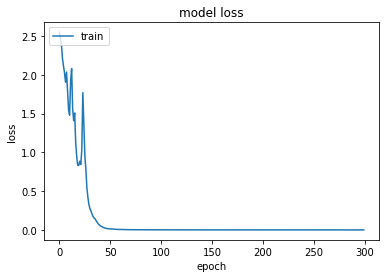

In [5]:
K.clear_session()
model = Sequential()
model.add(Dense(3000, input_dim=24420, activation="tanh"))
# model.add(Dropout(0.23))
model.add(Dropout(0.50))
model.add(Dense(3000, activation="tanh"))
# model.add(Dropout(0.23))
# model.add(Dense(4000, activation="relu"))
# # model.add(Dropout(0.23))
model.add(Dense(3000, activation="tanh"))
# model.add(Dropout(0.50))
# model.add(Dense(2000, activation="relu"))
# # model.add(Dropout(0.50))
# model.add(Dense(2000, activation="relu"))
# # model.add(Dropout(0.50))
# model.add(Dense(2000, activation="relu"))
# # model.add(Dropout(0.50))
# model.add(Dense(2000, activation="relu"))
# # model.add(Dropout(0.50))
# model.add(Dense(2000, activation="relu"))
# # model.add(Dropout(0.50))
# model.add(Dense(2000, activation="relu"))
# model.add(Dropout(0.50))
# model.add(Dense(2000, activation="relu"))
# model.add(Dropout(0.23))
model.add(Dense(13, activation="softmax"))
model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

early_stop = EarlyStopping(monitor = 'loss', patience = 15, verbose = 1)

history = model.fit(X_train, y_train, epochs=300, batch_size=798, callbacks=[early_stop])

# summarize history for loss
plt.plot(history.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
# plt.savefig('loss1.png')

scores = model.evaluate(X_test, y_test)
print("\nAccuracy: %.2f%%" % (scores[1]*100))

Epoch 1/300


 798/3816 [=====>........................] - ETA: 11s - loss: 2.6838 - acc: 0.0188

1596/3816 [===========>..................] - ETA: 4s - loss: 3.5019 - acc: 0.0595 

2394/3816 [=================>............] - ETA: 2s - loss: 3.8093 - acc: 0.0639

3192/3816 [========================>.....] - ETA: 0s - loss: 3.8360 - acc: 0.0755

3816/3816 [==============================] - 5s 1ms/step - loss: 3.8255 - acc: 0.0781


Epoch 2/300


 798/3816 [=====>........................] - ETA: 1s - loss: 4.0354 - acc: 0.0789

1596/3816 [===========>..................] - ETA: 1s - loss: 3.7878 - acc: 0.0808

2394/3816 [=================>............] - ETA: 0s - loss: 3.7957 - acc: 0.0827

3192/3816 [========================>.....] - ETA: 0s - loss: 3.7751 - acc: 0.0811

3816/3816 [==============================] - 2s 481us/step - loss: 3.7552 - acc: 0.0797


Epoch 3/300


 798/3816 [=====>........................] - ETA: 1s - loss: 3.3815 - acc: 0.1153

1596/3816 [===========>..................] - ETA: 1s - loss: 3.3795 - acc: 0.1009

2394/3816 [=================>............] - ETA: 0s - loss: 3.2703 - acc: 0.0994

3192/3816 [========================>.....] - ETA: 0s - loss: 3.2046 - acc: 0.0959

3816/3816 [==============================] - 2s 480us/step - loss: 3.1437 - acc: 0.0933


Epoch 4/300


 798/3816 [=====>........................] - ETA: 1s - loss: 2.9282 - acc: 0.0902

1596/3816 [===========>..................] - ETA: 1s - loss: 2.9935 - acc: 0.0909

2394/3816 [=================>............] - ETA: 0s - loss: 2.9891 - acc: 0.0927

3192/3816 [========================>.....] - ETA: 0s - loss: 2.9843 - acc: 0.0887

3816/3816 [==============================] - 2s 475us/step - loss: 2.9603 - acc: 0.0865


Epoch 5/300


 798/3816 [=====>........................] - ETA: 1s - loss: 2.8383 - acc: 0.0789

1596/3816 [===========>..................] - ETA: 1s - loss: 2.8320 - acc: 0.0827

2394/3816 [=================>............] - ETA: 0s - loss: 2.8193 - acc: 0.0902

3192/3816 [========================>.....] - ETA: 0s - loss: 2.8165 - acc: 0.0940

3816/3816 [==============================] - 2s 473us/step - loss: 2.8543 - acc: 0.0922


Epoch 6/300


 798/3816 [=====>........................] - ETA: 1s - loss: 2.9257 - acc: 0.0927

1596/3816 [===========>..................] - ETA: 0s - loss: 2.8279 - acc: 0.0783

2394/3816 [=================>............] - ETA: 0s - loss: 2.8524 - acc: 0.0785

3192/3816 [========================>.....] - ETA: 0s - loss: 2.8293 - acc: 0.0789

3816/3816 [==============================] - 2s 478us/step - loss: 2.8330 - acc: 0.0784


Epoch 7/300


 798/3816 [=====>........................] - ETA: 1s - loss: 2.9241 - acc: 0.0777

1596/3816 [===========>..................] - ETA: 1s - loss: 2.8183 - acc: 0.0852

2394/3816 [=================>............] - ETA: 0s - loss: 2.7594 - acc: 0.0810

3192/3816 [========================>.....] - ETA: 0s - loss: 2.7924 - acc: 0.0799

3816/3816 [==============================] - 2s 476us/step - loss: 2.8133 - acc: 0.0812


Epoch 8/300


 798/3816 [=====>........................] - ETA: 1s - loss: 2.7548 - acc: 0.0990

1596/3816 [===========>..................] - ETA: 1s - loss: 2.8372 - acc: 0.1009

2394/3816 [=================>............] - ETA: 0s - loss: 2.8173 - acc: 0.0982

3192/3816 [========================>.....] - ETA: 0s - loss: 2.8101 - acc: 0.0993

3816/3816 [==============================] - 2s 482us/step - loss: 2.7862 - acc: 0.0993


Epoch 9/300


 798/3816 [=====>........................] - ETA: 1s - loss: 2.9742 - acc: 0.0902

1596/3816 [===========>..................] - ETA: 1s - loss: 2.8454 - acc: 0.0952

2394/3816 [=================>............] - ETA: 0s - loss: 2.7766 - acc: 0.0906

3192/3816 [========================>.....] - ETA: 0s - loss: 2.7907 - acc: 0.0871

3816/3816 [==============================] - 2s 481us/step - loss: 2.7935 - acc: 0.0867


Epoch 10/300


 798/3816 [=====>........................] - ETA: 1s - loss: 2.7278 - acc: 0.0827

1596/3816 [===========>..................] - ETA: 1s - loss: 2.7587 - acc: 0.0865

2394/3816 [=================>............] - ETA: 0s - loss: 2.7767 - acc: 0.0764

3192/3816 [========================>.....] - ETA: 0s - loss: 2.7799 - acc: 0.0830

3816/3816 [==============================] - 2s 488us/step - loss: 2.7878 - acc: 0.0812


Epoch 11/300


 798/3816 [=====>........................] - ETA: 1s - loss: 2.8377 - acc: 0.0852

1596/3816 [===========>..................] - ETA: 1s - loss: 2.7883 - acc: 0.0915

2394/3816 [=================>............] - ETA: 0s - loss: 2.7809 - acc: 0.0890

3192/3816 [========================>.....] - ETA: 0s - loss: 2.7896 - acc: 0.0909

3816/3816 [==============================] - 2s 461us/step - loss: 2.7902 - acc: 0.0917


Epoch 12/300


 798/3816 [=====>........................] - ETA: 1s - loss: 2.7934 - acc: 0.0677

1596/3816 [===========>..................] - ETA: 1s - loss: 2.7726 - acc: 0.0746

2394/3816 [=================>............] - ETA: 0s - loss: 2.7911 - acc: 0.0781

3192/3816 [========================>.....] - ETA: 0s - loss: 2.8026 - acc: 0.0824

3816/3816 [==============================] - 2s 483us/step - loss: 2.7883 - acc: 0.0849


Epoch 13/300


 798/3816 [=====>........................] - ETA: 1s - loss: 2.8078 - acc: 0.0915

1596/3816 [===========>..................] - ETA: 1s - loss: 2.7893 - acc: 0.1034

2394/3816 [=================>............] - ETA: 0s - loss: 2.7669 - acc: 0.1003

3192/3816 [========================>.....] - ETA: 0s - loss: 2.7842 - acc: 0.0924

3816/3816 [==============================] - 2s 487us/step - loss: 2.7834 - acc: 0.0925


Epoch 14/300


 798/3816 [=====>........................] - ETA: 1s - loss: 2.7815 - acc: 0.0702

1596/3816 [===========>..................] - ETA: 1s - loss: 2.8114 - acc: 0.0783

2394/3816 [=================>............] - ETA: 0s - loss: 2.7949 - acc: 0.0827

3192/3816 [========================>.....] - ETA: 0s - loss: 2.7873 - acc: 0.0855

3816/3816 [==============================] - 2s 481us/step - loss: 2.7812 - acc: 0.0862


Epoch 15/300


 798/3816 [=====>........................] - ETA: 1s - loss: 2.7072 - acc: 0.0752

1596/3816 [===========>..................] - ETA: 1s - loss: 2.7742 - acc: 0.0777

2394/3816 [=================>............] - ETA: 0s - loss: 2.7611 - acc: 0.0789

3192/3816 [========================>.....] - ETA: 0s - loss: 2.7513 - acc: 0.0843

3816/3816 [==============================] - 2s 482us/step - loss: 2.7839 - acc: 0.0878


Epoch 16/300


 798/3816 [=====>........................] - ETA: 1s - loss: 2.6702 - acc: 0.1140

1596/3816 [===========>..................] - ETA: 1s - loss: 2.7158 - acc: 0.1065

2394/3816 [=================>............] - ETA: 0s - loss: 2.7443 - acc: 0.0998

3192/3816 [========================>.....] - ETA: 0s - loss: 2.7634 - acc: 0.0943

3816/3816 [==============================] - 2s 466us/step - loss: 2.7790 - acc: 0.0943


Epoch 17/300


 798/3816 [=====>........................] - ETA: 1s - loss: 2.7637 - acc: 0.0752

1596/3816 [===========>..................] - ETA: 1s - loss: 2.7210 - acc: 0.0871

2394/3816 [=================>............] - ETA: 0s - loss: 2.7668 - acc: 0.0902

3192/3816 [========================>.....] - ETA: 0s - loss: 2.7749 - acc: 0.0890

3816/3816 [==============================] - 2s 464us/step - loss: 2.7903 - acc: 0.0891


Epoch 18/300


 798/3816 [=====>........................] - ETA: 1s - loss: 2.8485 - acc: 0.0727

1596/3816 [===========>..................] - ETA: 1s - loss: 2.8144 - acc: 0.0808

2394/3816 [=================>............] - ETA: 0s - loss: 2.8310 - acc: 0.0798

3192/3816 [========================>.....] - ETA: 0s - loss: 2.8136 - acc: 0.0858

3816/3816 [==============================] - 2s 491us/step - loss: 2.7881 - acc: 0.0870


Epoch 19/300


 798/3816 [=====>........................] - ETA: 1s - loss: 2.7733 - acc: 0.0902

1596/3816 [===========>..................] - ETA: 0s - loss: 2.7178 - acc: 0.0890

2394/3816 [=================>............] - ETA: 0s - loss: 2.7513 - acc: 0.0948

3192/3816 [========================>.....] - ETA: 0s - loss: 2.7593 - acc: 0.0965

3816/3816 [==============================] - 2s 468us/step - loss: 2.7798 - acc: 0.0925


Epoch 20/300


 798/3816 [=====>........................] - ETA: 1s - loss: 2.8413 - acc: 0.1003

1596/3816 [===========>..................] - ETA: 1s - loss: 2.8035 - acc: 0.0921

2394/3816 [=================>............] - ETA: 0s - loss: 2.8121 - acc: 0.0973

3192/3816 [========================>.....] - ETA: 0s - loss: 2.7638 - acc: 0.0937

3816/3816 [==============================] - 2s 457us/step - loss: 2.7787 - acc: 0.0915


Epoch 21/300


 798/3816 [=====>........................] - ETA: 1s - loss: 2.8941 - acc: 0.1078

1596/3816 [===========>..................] - ETA: 0s - loss: 2.8202 - acc: 0.0965

2394/3816 [=================>............] - ETA: 0s - loss: 2.8016 - acc: 0.0931

3192/3816 [========================>.....] - ETA: 0s - loss: 2.7786 - acc: 0.0949

3816/3816 [==============================] - 2s 449us/step - loss: 2.7815 - acc: 0.0962


Epoch 22/300


 798/3816 [=====>........................] - ETA: 1s - loss: 2.8027 - acc: 0.0915

1596/3816 [===========>..................] - ETA: 1s - loss: 2.7829 - acc: 0.0865

2394/3816 [=================>............] - ETA: 0s - loss: 2.7875 - acc: 0.0915

3192/3816 [========================>.....] - ETA: 0s - loss: 2.7673 - acc: 0.0930

3816/3816 [==============================] - 2s 465us/step - loss: 2.7818 - acc: 0.0930


Epoch 23/300


 798/3816 [=====>........................] - ETA: 1s - loss: 2.6726 - acc: 0.0915

1596/3816 [===========>..................] - ETA: 0s - loss: 2.7137 - acc: 0.0764

2394/3816 [=================>............] - ETA: 0s - loss: 2.7743 - acc: 0.0827

3192/3816 [========================>.....] - ETA: 0s - loss: 2.8004 - acc: 0.0883

3816/3816 [==============================] - 2s 464us/step - loss: 2.7854 - acc: 0.0933


Epoch 24/300


 798/3816 [=====>........................] - ETA: 1s - loss: 2.7576 - acc: 0.1040

1596/3816 [===========>..................] - ETA: 1s - loss: 2.7832 - acc: 0.0990

2394/3816 [=================>............] - ETA: 0s - loss: 2.7499 - acc: 0.0952

3192/3816 [========================>.....] - ETA: 0s - loss: 2.7906 - acc: 0.0909

3816/3816 [==============================] - 2s 471us/step - loss: 2.7835 - acc: 0.0904


Epoch 25/300


 798/3816 [=====>........................] - ETA: 1s - loss: 2.7673 - acc: 0.0902

1596/3816 [===========>..................] - ETA: 1s - loss: 2.8201 - acc: 0.0796

2394/3816 [=================>............] - ETA: 0s - loss: 2.7493 - acc: 0.0831

3192/3816 [========================>.....] - ETA: 0s - loss: 2.7533 - acc: 0.0840

3816/3816 [==============================] - 2s 462us/step - loss: 2.7819 - acc: 0.0852


Epoch 26/300


 798/3816 [=====>........................] - ETA: 1s - loss: 2.7903 - acc: 0.0915

1596/3816 [===========>..................] - ETA: 1s - loss: 2.7517 - acc: 0.0946

2394/3816 [=================>............] - ETA: 0s - loss: 2.7669 - acc: 0.0860

3192/3816 [========================>.....] - ETA: 0s - loss: 2.7873 - acc: 0.0871

3816/3816 [==============================] - 2s 470us/step - loss: 2.7896 - acc: 0.0867


Epoch 27/300


 798/3816 [=====>........................] - ETA: 1s - loss: 2.8716 - acc: 0.0514

1596/3816 [===========>..................] - ETA: 0s - loss: 2.8508 - acc: 0.0633

2394/3816 [=================>............] - ETA: 0s - loss: 2.7903 - acc: 0.0698

3192/3816 [========================>.....] - ETA: 0s - loss: 2.7988 - acc: 0.0714

3816/3816 [==============================] - 2s 453us/step - loss: 2.7900 - acc: 0.0773


Epoch 28/300


 798/3816 [=====>........................] - ETA: 1s - loss: 2.6847 - acc: 0.1028

1596/3816 [===========>..................] - ETA: 1s - loss: 2.7301 - acc: 0.1046

2394/3816 [=================>............] - ETA: 0s - loss: 2.7681 - acc: 0.1011

3192/3816 [========================>.....] - ETA: 0s - loss: 2.7826 - acc: 0.1018

3816/3816 [==============================] - 2s 509us/step - loss: 2.7814 - acc: 0.1006


Epoch 29/300


 798/3816 [=====>........................] - ETA: 1s - loss: 2.7900 - acc: 0.0990

1596/3816 [===========>..................] - ETA: 1s - loss: 2.7181 - acc: 0.0977

2394/3816 [=================>............] - ETA: 0s - loss: 2.7587 - acc: 0.0886

3192/3816 [========================>.....] - ETA: 0s - loss: 2.7646 - acc: 0.0855

3816/3816 [==============================] - 2s 496us/step - loss: 2.7798 - acc: 0.0875


Epoch 30/300


 798/3816 [=====>........................] - ETA: 1s - loss: 2.8702 - acc: 0.1128

1596/3816 [===========>..................] - ETA: 1s - loss: 2.8496 - acc: 0.1096

2394/3816 [=================>............] - ETA: 0s - loss: 2.8352 - acc: 0.0998

3192/3816 [========================>.....] - ETA: 0s - loss: 2.8045 - acc: 0.1009

3816/3816 [==============================] - 2s 471us/step - loss: 2.7864 - acc: 0.0988


Epoch 31/300


 798/3816 [=====>........................] - ETA: 1s - loss: 2.7741 - acc: 0.1090

1596/3816 [===========>..................] - ETA: 1s - loss: 2.7981 - acc: 0.0996

2394/3816 [=================>............] - ETA: 0s - loss: 2.7854 - acc: 0.0931

3192/3816 [========================>.....] - ETA: 0s - loss: 2.7947 - acc: 0.0871

3816/3816 [==============================] - 2s 486us/step - loss: 2.7878 - acc: 0.0881


Epoch 32/300


 798/3816 [=====>........................] - ETA: 1s - loss: 2.9006 - acc: 0.0952

1596/3816 [===========>..................] - ETA: 1s - loss: 2.8707 - acc: 0.0965

2394/3816 [=================>............] - ETA: 0s - loss: 2.8144 - acc: 0.0986

3192/3816 [========================>.....] - ETA: 0s - loss: 2.7961 - acc: 0.0965

3816/3816 [==============================] - 2s 539us/step - loss: 2.7933 - acc: 0.0941


Epoch 33/300


 798/3816 [=====>........................] - ETA: 1s - loss: 2.7915 - acc: 0.0840

1596/3816 [===========>..................] - ETA: 1s - loss: 2.7969 - acc: 0.0764

2394/3816 [=================>............] - ETA: 0s - loss: 2.8136 - acc: 0.0827

3192/3816 [========================>.....] - ETA: 0s - loss: 2.7837 - acc: 0.0821

3816/3816 [==============================] - 2s 479us/step - loss: 2.7849 - acc: 0.0865


Epoch 34/300


 798/3816 [=====>........................] - ETA: 1s - loss: 2.6370 - acc: 0.0952

1596/3816 [===========>..................] - ETA: 1s - loss: 2.7768 - acc: 0.0909

2394/3816 [=================>............] - ETA: 0s - loss: 2.7940 - acc: 0.0940

3192/3816 [========================>.....] - ETA: 0s - loss: 2.7918 - acc: 0.0971

3816/3816 [==============================] - 2s 488us/step - loss: 2.7820 - acc: 0.0930


Epoch 35/300


 798/3816 [=====>........................] - ETA: 1s - loss: 2.7283 - acc: 0.0827

1596/3816 [===========>..................] - ETA: 1s - loss: 2.7448 - acc: 0.0921

2394/3816 [=================>............] - ETA: 0s - loss: 2.7804 - acc: 0.0898

3192/3816 [========================>.....] - ETA: 0s - loss: 2.7788 - acc: 0.0852

3816/3816 [==============================] - 2s 486us/step - loss: 2.7819 - acc: 0.0849


Epoch 00035: early stopping
 32/425 [=>............................] - ETA: 0s

128/425 [========>.....................] - ETA: 0s

224/425 [==============>...............] - ETA: 0s

320/425 [=====================>........] - ETA: 0s

416/425 [============================>.] - ETA: 0s

425/425 [==============================] - 0s 874us/step



Accuracy: 8.71%


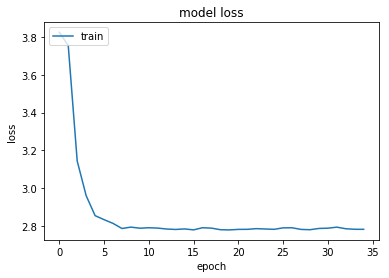

In [6]:
K.clear_session()
model = Sequential()
model.add(Dense(3000, input_dim=24420, activation="sigmoid"))
# model.add(Dropout(0.23))
model.add(Dropout(0.50))
model.add(Dense(3000, activation="sigmoid"))
# model.add(Dropout(0.23))
# model.add(Dense(4000, activation="relu"))
# # model.add(Dropout(0.23))
model.add(Dense(3000, activation="sigmoid"))
# model.add(Dropout(0.50))
# model.add(Dense(2000, activation="relu"))
# # model.add(Dropout(0.50))
# model.add(Dense(2000, activation="relu"))
# # model.add(Dropout(0.50))
# model.add(Dense(2000, activation="relu"))
# # model.add(Dropout(0.50))
# model.add(Dense(2000, activation="relu"))
# # model.add(Dropout(0.50))
# model.add(Dense(2000, activation="relu"))
# # model.add(Dropout(0.50))
# model.add(Dense(2000, activation="relu"))
# model.add(Dropout(0.50))
# model.add(Dense(2000, activation="relu"))
# model.add(Dropout(0.23))
model.add(Dense(13, activation="softmax"))
model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

early_stop = EarlyStopping(monitor = 'loss', patience = 15, verbose = 1)

history = model.fit(X_train, y_train, epochs=300, batch_size=798, callbacks=[early_stop])

# summarize history for loss
plt.plot(history.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
# plt.savefig('loss1.png')

scores = model.evaluate(X_test, y_test)
print("\nAccuracy: %.2f%%" % (scores[1]*100))

In [7]:
K.clear_session()
model = Sequential()
model.add(Dense(3000, input_dim=24420, activation="linear"))
# model.add(Dropout(0.23))
model.add(Dropout(0.50))
model.add(Dense(3000, activation="linear"))
# model.add(Dropout(0.23))
# model.add(Dense(4000, activation="relu"))
# # model.add(Dropout(0.23))
model.add(Dense(3000, activation="linear"))
# model.add(Dropout(0.50))
# model.add(Dense(2000, activation="relu"))
# # model.add(Dropout(0.50))
# model.add(Dense(2000, activation="relu"))
# # model.add(Dropout(0.50))
# model.add(Dense(2000, activation="relu"))
# # model.add(Dropout(0.50))
# model.add(Dense(2000, activation="relu"))
# # model.add(Dropout(0.50))
# model.add(Dense(2000, activation="relu"))
# # model.add(Dropout(0.50))
# model.add(Dense(2000, activation="relu"))
# model.add(Dropout(0.50))
# model.add(Dense(2000, activation="relu"))
# model.add(Dropout(0.23))
model.add(Dense(13, activation="softmax"))
model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

early_stop = EarlyStopping(monitor = 'loss', patience = 15, verbose = 1)

history = model.fit(X_train, y_train, epochs=300, batch_size=798, callbacks=[early_stop])

# summarize history for loss
plt.plot(history.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
# plt.savefig('loss1.png')

scores = model.evaluate(X_test, y_test)
print("\nAccuracy: %.2f%%" % (scores[1]*100))

Epoch 1/300


 798/3816 [=====>........................] - ETA: 23s - loss: 2.5646 - acc: 0.0802

1596/3816 [===========>..................] - ETA: 9s - loss: 2.5537 - acc: 0.0833 

2394/3816 [=================>............] - ETA: 4s - loss: 2.5566 - acc: 0.0877

3192/3816 [========================>.....] - ETA: 1s - loss: 2.5502 - acc: 0.0902

3816/3816 [==============================] - 8s 2ms/step - loss: 2.5477 - acc: 0.1009


Epoch 2/300


 798/3816 [=====>........................] - ETA: 1s - loss: 2.5006 - acc: 0.1679

1596/3816 [===========>..................] - ETA: 1s - loss: 2.5139 - acc: 0.1297

2394/3816 [=================>............] - ETA: 0s - loss: 2.4956 - acc: 0.1512

3192/3816 [========================>.....] - ETA: 0s - loss: 2.4699 - acc: 0.1563

3816/3816 [==============================] - 2s 490us/step - loss: 2.4427 - acc: 0.1580


Epoch 3/300


 798/3816 [=====>........................] - ETA: 1s - loss: 2.3685 - acc: 0.1404

1596/3816 [===========>..................] - ETA: 1s - loss: 2.5895 - acc: 0.1128

2394/3816 [=================>............] - ETA: 0s - loss: 2.4907 - acc: 0.1316

3192/3816 [========================>.....] - ETA: 0s - loss: 2.4516 - acc: 0.1419

3816/3816 [==============================] - 2s 463us/step - loss: 2.4255 - acc: 0.1465


Epoch 4/300


 798/3816 [=====>........................] - ETA: 1s - loss: 2.2823 - acc: 0.2444

1596/3816 [===========>..................] - ETA: 0s - loss: 2.2719 - acc: 0.2337

2394/3816 [=================>............] - ETA: 0s - loss: 2.2348 - acc: 0.2314

3192/3816 [========================>.....] - ETA: 0s - loss: 2.2150 - acc: 0.2306

3816/3816 [==============================] - 2s 451us/step - loss: 2.2096 - acc: 0.2251


Epoch 5/300


 798/3816 [=====>........................] - ETA: 1s - loss: 2.1642 - acc: 0.1855

1596/3816 [===========>..................] - ETA: 1s - loss: 2.1663 - acc: 0.1992

2394/3816 [=================>............] - ETA: 0s - loss: 2.1434 - acc: 0.2001

3192/3816 [========================>.....] - ETA: 0s - loss: 2.1225 - acc: 0.2055

3816/3816 [==============================] - 2s 475us/step - loss: 2.1159 - acc: 0.2060


Epoch 6/300


 798/3816 [=====>........................] - ETA: 1s - loss: 2.0329 - acc: 0.2970

1596/3816 [===========>..................] - ETA: 1s - loss: 2.0519 - acc: 0.2625

2394/3816 [=================>............] - ETA: 0s - loss: 2.0399 - acc: 0.2581

3192/3816 [========================>.....] - ETA: 0s - loss: 2.0439 - acc: 0.2566

3816/3816 [==============================] - 2s 484us/step - loss: 2.0341 - acc: 0.2652


Epoch 7/300


 798/3816 [=====>........................] - ETA: 1s - loss: 1.9586 - acc: 0.3058

1596/3816 [===========>..................] - ETA: 1s - loss: 1.9431 - acc: 0.3221

2394/3816 [=================>............] - ETA: 0s - loss: 1.9351 - acc: 0.3074

3192/3816 [========================>.....] - ETA: 0s - loss: 1.9085 - acc: 0.3268

3816/3816 [==============================] - 2s 476us/step - loss: 1.9055 - acc: 0.3294


Epoch 8/300


 798/3816 [=====>........................] - ETA: 1s - loss: 1.8085 - acc: 0.3697

1596/3816 [===========>..................] - ETA: 1s - loss: 1.8071 - acc: 0.3659

2394/3816 [=================>............] - ETA: 0s - loss: 1.7847 - acc: 0.3772

3192/3816 [========================>.....] - ETA: 0s - loss: 1.7763 - acc: 0.3694

3816/3816 [==============================] - 2s 496us/step - loss: 1.7598 - acc: 0.3768


Epoch 9/300


 798/3816 [=====>........................] - ETA: 1s - loss: 1.6764 - acc: 0.3947

1596/3816 [===========>..................] - ETA: 1s - loss: 1.8094 - acc: 0.3490

2394/3816 [=================>............] - ETA: 0s - loss: 1.9033 - acc: 0.3363

3192/3816 [========================>.....] - ETA: 0s - loss: 1.9588 - acc: 0.3221

3816/3816 [==============================] - 2s 474us/step - loss: 1.9090 - acc: 0.3323


Epoch 10/300


 798/3816 [=====>........................] - ETA: 1s - loss: 1.6629 - acc: 0.3684

1596/3816 [===========>..................] - ETA: 0s - loss: 1.6450 - acc: 0.3904

2394/3816 [=================>............] - ETA: 0s - loss: 1.6746 - acc: 0.3855

3192/3816 [========================>.....] - ETA: 0s - loss: 1.6434 - acc: 0.4041

3816/3816 [==============================] - 2s 478us/step - loss: 1.6302 - acc: 0.4169


Epoch 11/300


 798/3816 [=====>........................] - ETA: 1s - loss: 1.7010 - acc: 0.3684

1596/3816 [===========>..................] - ETA: 1s - loss: 1.7452 - acc: 0.3477

2394/3816 [=================>............] - ETA: 0s - loss: 1.6600 - acc: 0.3935

3192/3816 [========================>.....] - ETA: 0s - loss: 1.6324 - acc: 0.4204

3816/3816 [==============================] - 2s 482us/step - loss: 1.6312 - acc: 0.4180


Epoch 12/300


 798/3816 [=====>........................] - ETA: 1s - loss: 1.5756 - acc: 0.4348

1596/3816 [===========>..................] - ETA: 1s - loss: 1.4611 - acc: 0.4756

2394/3816 [=================>............] - ETA: 0s - loss: 1.4687 - acc: 0.4720

3192/3816 [========================>.....] - ETA: 0s - loss: 1.4278 - acc: 0.4865

3816/3816 [==============================] - 2s 487us/step - loss: 1.4189 - acc: 0.4900


Epoch 13/300


 798/3816 [=====>........................] - ETA: 1s - loss: 1.2367 - acc: 0.5940

1596/3816 [===========>..................] - ETA: 1s - loss: 1.1988 - acc: 0.6335

2394/3816 [=================>............] - ETA: 0s - loss: 1.2133 - acc: 0.6140

3192/3816 [========================>.....] - ETA: 0s - loss: 1.1898 - acc: 0.6184

3816/3816 [==============================] - 2s 470us/step - loss: 1.1804 - acc: 0.6171


Epoch 14/300


 798/3816 [=====>........................] - ETA: 1s - loss: 1.2736 - acc: 0.5088

1596/3816 [===========>..................] - ETA: 1s - loss: 1.4918 - acc: 0.4743

2394/3816 [=================>............] - ETA: 0s - loss: 1.3720 - acc: 0.5146

3192/3816 [========================>.....] - ETA: 0s - loss: 1.4637 - acc: 0.4925

3816/3816 [==============================] - 2s 481us/step - loss: 1.4244 - acc: 0.5058


Epoch 15/300


 798/3816 [=====>........................] - ETA: 1s - loss: 1.5665 - acc: 0.4637

1596/3816 [===========>..................] - ETA: 1s - loss: 1.5756 - acc: 0.4749

2394/3816 [=================>............] - ETA: 0s - loss: 1.4913 - acc: 0.4837

3192/3816 [========================>.....] - ETA: 0s - loss: 1.5919 - acc: 0.4746

3816/3816 [==============================] - 2s 482us/step - loss: 1.5103 - acc: 0.5058


Epoch 16/300


 798/3816 [=====>........................] - ETA: 1s - loss: 1.2266 - acc: 0.5514

1596/3816 [===========>..................] - ETA: 1s - loss: 1.2231 - acc: 0.5833

2394/3816 [=================>............] - ETA: 0s - loss: 1.2136 - acc: 0.5789

3192/3816 [========================>.....] - ETA: 0s - loss: 1.2608 - acc: 0.5742

3816/3816 [==============================] - 2s 485us/step - loss: 1.5476 - acc: 0.5233


Epoch 17/300


 798/3816 [=====>........................] - ETA: 1s - loss: 3.2675 - acc: 0.3296

1596/3816 [===========>..................] - ETA: 0s - loss: 3.3297 - acc: 0.3095

2394/3816 [=================>............] - ETA: 0s - loss: 3.2265 - acc: 0.2878

3192/3816 [========================>.....] - ETA: 0s - loss: 3.0763 - acc: 0.2939

3816/3816 [==============================] - 2s 465us/step - loss: 3.0355 - acc: 0.3006


Epoch 18/300


 798/3816 [=====>........................] - ETA: 1s - loss: 1.2608 - acc: 0.5602

1596/3816 [===========>..................] - ETA: 1s - loss: 1.5976 - acc: 0.4467

2394/3816 [=================>............] - ETA: 0s - loss: 1.5674 - acc: 0.4482

3192/3816 [========================>.....] - ETA: 0s - loss: 1.5824 - acc: 0.4590

3816/3816 [==============================] - 2s 485us/step - loss: 1.6431 - acc: 0.4471


Epoch 19/300


 798/3816 [=====>........................] - ETA: 1s - loss: 1.4807 - acc: 0.4799

1596/3816 [===========>..................] - ETA: 1s - loss: 1.4806 - acc: 0.4593

2394/3816 [=================>............] - ETA: 0s - loss: 1.4409 - acc: 0.4695

3192/3816 [========================>.....] - ETA: 0s - loss: 1.3826 - acc: 0.4925

3816/3816 [==============================] - 2s 482us/step - loss: 1.3595 - acc: 0.4950


Epoch 20/300


 798/3816 [=====>........................] - ETA: 1s - loss: 1.0023 - acc: 0.7093

1596/3816 [===========>..................] - ETA: 1s - loss: 1.0450 - acc: 0.6823

2394/3816 [=================>............] - ETA: 0s - loss: 1.1133 - acc: 0.6433

3192/3816 [========================>.....] - ETA: 0s - loss: 1.0916 - acc: 0.6538

3816/3816 [==============================] - 2s 474us/step - loss: 1.0673 - acc: 0.6643


Epoch 21/300


 798/3816 [=====>........................] - ETA: 1s - loss: 0.9194 - acc: 0.7218

1596/3816 [===========>..................] - ETA: 1s - loss: 0.9581 - acc: 0.6992

2394/3816 [=================>............] - ETA: 0s - loss: 0.9295 - acc: 0.7172

3192/3816 [========================>.....] - ETA: 0s - loss: 0.9015 - acc: 0.7343

3816/3816 [==============================] - 2s 475us/step - loss: 0.8830 - acc: 0.7427


Epoch 22/300


 798/3816 [=====>........................] - ETA: 1s - loss: 0.7534 - acc: 0.8020

1596/3816 [===========>..................] - ETA: 1s - loss: 0.7741 - acc: 0.7907

2394/3816 [=================>............] - ETA: 0s - loss: 0.7696 - acc: 0.7907

3192/3816 [========================>.....] - ETA: 0s - loss: 0.7577 - acc: 0.7926

3816/3816 [==============================] - 2s 476us/step - loss: 0.7516 - acc: 0.7901


Epoch 23/300


 798/3816 [=====>........................] - ETA: 1s - loss: 0.6868 - acc: 0.8033

1596/3816 [===========>..................] - ETA: 1s - loss: 0.6688 - acc: 0.8058

2394/3816 [=================>............] - ETA: 0s - loss: 0.6745 - acc: 0.7966

3192/3816 [========================>.....] - ETA: 0s - loss: 0.6651 - acc: 0.7989

3816/3816 [==============================] - 2s 483us/step - loss: 0.6589 - acc: 0.8042


Epoch 24/300


 798/3816 [=====>........................] - ETA: 1s - loss: 0.6291 - acc: 0.8158

1596/3816 [===========>..................] - ETA: 1s - loss: 0.5762 - acc: 0.8352

2394/3816 [=================>............] - ETA: 0s - loss: 0.5568 - acc: 0.8429

3192/3816 [========================>.....] - ETA: 0s - loss: 0.5514 - acc: 0.8462

3816/3816 [==============================] - 2s 493us/step - loss: 0.5405 - acc: 0.8532


Epoch 25/300


 798/3816 [=====>........................] - ETA: 1s - loss: 0.4406 - acc: 0.8922

1596/3816 [===========>..................] - ETA: 1s - loss: 0.4611 - acc: 0.8772

2394/3816 [=================>............] - ETA: 0s - loss: 0.4498 - acc: 0.8843

3192/3816 [========================>.....] - ETA: 0s - loss: 0.4610 - acc: 0.8759

3816/3816 [==============================] - 2s 485us/step - loss: 0.4488 - acc: 0.8808


Epoch 26/300


 798/3816 [=====>........................] - ETA: 1s - loss: 0.4116 - acc: 0.8885

1596/3816 [===========>..................] - ETA: 1s - loss: 0.4231 - acc: 0.8822

2394/3816 [=================>............] - ETA: 0s - loss: 0.4206 - acc: 0.8868

3192/3816 [========================>.....] - ETA: 0s - loss: 0.4008 - acc: 0.8916

3816/3816 [==============================] - 2s 498us/step - loss: 0.3994 - acc: 0.8902


Epoch 27/300


 798/3816 [=====>........................] - ETA: 1s - loss: 0.3067 - acc: 0.9236

1596/3816 [===========>..................] - ETA: 0s - loss: 0.3465 - acc: 0.9041

2394/3816 [=================>............] - ETA: 0s - loss: 0.3407 - acc: 0.9073

3192/3816 [========================>.....] - ETA: 0s - loss: 0.3377 - acc: 0.9070

3816/3816 [==============================] - 2s 469us/step - loss: 0.3315 - acc: 0.9085


Epoch 28/300


 798/3816 [=====>........................] - ETA: 1s - loss: 0.3047 - acc: 0.9135

1596/3816 [===========>..................] - ETA: 1s - loss: 0.2936 - acc: 0.9192

2394/3816 [=================>............] - ETA: 0s - loss: 0.2982 - acc: 0.9165

3192/3816 [========================>.....] - ETA: 0s - loss: 0.2903 - acc: 0.9217

3816/3816 [==============================] - 2s 481us/step - loss: 0.2864 - acc: 0.9214


Epoch 29/300


 798/3816 [=====>........................] - ETA: 1s - loss: 0.2354 - acc: 0.9411

1596/3816 [===========>..................] - ETA: 1s - loss: 0.2332 - acc: 0.9449

2394/3816 [=================>............] - ETA: 0s - loss: 0.2427 - acc: 0.9407

3192/3816 [========================>.....] - ETA: 0s - loss: 0.2499 - acc: 0.9361

3816/3816 [==============================] - 2s 489us/step - loss: 0.2389 - acc: 0.9418


Epoch 30/300


 798/3816 [=====>........................] - ETA: 1s - loss: 0.2226 - acc: 0.9373

1596/3816 [===========>..................] - ETA: 1s - loss: 0.2090 - acc: 0.9455

2394/3816 [=================>............] - ETA: 0s - loss: 0.2088 - acc: 0.9478

3192/3816 [========================>.....] - ETA: 0s - loss: 0.1996 - acc: 0.9518

3816/3816 [==============================] - 2s 490us/step - loss: 0.2015 - acc: 0.9518


Epoch 31/300


 798/3816 [=====>........................] - ETA: 1s - loss: 0.1796 - acc: 0.9599

1596/3816 [===========>..................] - ETA: 1s - loss: 0.1734 - acc: 0.9668

2394/3816 [=================>............] - ETA: 0s - loss: 0.1703 - acc: 0.9666

3192/3816 [========================>.....] - ETA: 0s - loss: 0.1702 - acc: 0.9646

3816/3816 [==============================] - 2s 500us/step - loss: 0.1694 - acc: 0.9638


Epoch 32/300


 798/3816 [=====>........................] - ETA: 1s - loss: 0.1452 - acc: 0.9762

1596/3816 [===========>..................] - ETA: 1s - loss: 0.1406 - acc: 0.9737

2394/3816 [=================>............] - ETA: 0s - loss: 0.1448 - acc: 0.9712

3192/3816 [========================>.....] - ETA: 0s - loss: 0.1576 - acc: 0.9608

3816/3816 [==============================] - 2s 467us/step - loss: 0.1602 - acc: 0.9610


Epoch 33/300


 798/3816 [=====>........................] - ETA: 1s - loss: 0.1322 - acc: 0.9799

1596/3816 [===========>..................] - ETA: 1s - loss: 0.1454 - acc: 0.9649

2394/3816 [=================>............] - ETA: 0s - loss: 0.1451 - acc: 0.9670

3192/3816 [========================>.....] - ETA: 0s - loss: 0.1420 - acc: 0.9668

3816/3816 [==============================] - 2s 474us/step - loss: 0.1383 - acc: 0.9686


Epoch 34/300


 798/3816 [=====>........................] - ETA: 1s - loss: 0.1119 - acc: 0.9737

1596/3816 [===========>..................] - ETA: 1s - loss: 0.1129 - acc: 0.9756

2394/3816 [=================>............] - ETA: 0s - loss: 0.1126 - acc: 0.9779

3192/3816 [========================>.....] - ETA: 0s - loss: 0.1080 - acc: 0.9790

3816/3816 [==============================] - 2s 474us/step - loss: 0.1056 - acc: 0.9790


Epoch 35/300


 798/3816 [=====>........................] - ETA: 1s - loss: 0.0764 - acc: 0.9900

1596/3816 [===========>..................] - ETA: 1s - loss: 0.0859 - acc: 0.9868

2394/3816 [=================>............] - ETA: 0s - loss: 0.0937 - acc: 0.9829

3192/3816 [========================>.....] - ETA: 0s - loss: 0.0892 - acc: 0.9843

3816/3816 [==============================] - 2s 479us/step - loss: 0.0861 - acc: 0.9861


Epoch 36/300


 798/3816 [=====>........................] - ETA: 1s - loss: 0.0809 - acc: 0.9900

1596/3816 [===========>..................] - ETA: 1s - loss: 0.0815 - acc: 0.9862

2394/3816 [=================>............] - ETA: 0s - loss: 0.0718 - acc: 0.9900

3192/3816 [========================>.....] - ETA: 0s - loss: 0.0731 - acc: 0.9893

3816/3816 [==============================] - 2s 476us/step - loss: 0.0715 - acc: 0.9893


Epoch 37/300


 798/3816 [=====>........................] - ETA: 1s - loss: 0.0661 - acc: 0.9887

1596/3816 [===========>..................] - ETA: 1s - loss: 0.0601 - acc: 0.9900

2394/3816 [=================>............] - ETA: 0s - loss: 0.0597 - acc: 0.9908

3192/3816 [========================>.....] - ETA: 0s - loss: 0.0597 - acc: 0.9922

3816/3816 [==============================] - 2s 488us/step - loss: 0.0598 - acc: 0.9921


Epoch 38/300


 798/3816 [=====>........................] - ETA: 1s - loss: 0.0529 - acc: 0.9925

1596/3816 [===========>..................] - ETA: 1s - loss: 0.0528 - acc: 0.9925

2394/3816 [=================>............] - ETA: 0s - loss: 0.0517 - acc: 0.9933

3192/3816 [========================>.....] - ETA: 0s - loss: 0.0497 - acc: 0.9940

3816/3816 [==============================] - 2s 485us/step - loss: 0.0515 - acc: 0.9937


Epoch 39/300


 798/3816 [=====>........................] - ETA: 1s - loss: 0.0426 - acc: 0.9912

1596/3816 [===========>..................] - ETA: 1s - loss: 0.0609 - acc: 0.9919

2394/3816 [=================>............] - ETA: 0s - loss: 0.0569 - acc: 0.9929

3192/3816 [========================>.....] - ETA: 0s - loss: 0.0595 - acc: 0.9909

3816/3816 [==============================] - 2s 475us/step - loss: 0.0654 - acc: 0.9874


Epoch 40/300


 798/3816 [=====>........................] - ETA: 1s - loss: 0.0364 - acc: 0.9975

1596/3816 [===========>..................] - ETA: 1s - loss: 0.0611 - acc: 0.9868

2394/3816 [=================>............] - ETA: 0s - loss: 0.0640 - acc: 0.9871

3192/3816 [========================>.....] - ETA: 0s - loss: 0.0615 - acc: 0.9872

3816/3816 [==============================] - 2s 493us/step - loss: 0.0615 - acc: 0.9874


Epoch 41/300


 798/3816 [=====>........................] - ETA: 1s - loss: 0.0334 - acc: 0.9987

1596/3816 [===========>..................] - ETA: 1s - loss: 0.0445 - acc: 0.9944

2394/3816 [=================>............] - ETA: 0s - loss: 0.0394 - acc: 0.9958

3192/3816 [========================>.....] - ETA: 0s - loss: 0.0375 - acc: 0.9953

3816/3816 [==============================] - 2s 502us/step - loss: 0.0376 - acc: 0.9950


Epoch 42/300


 798/3816 [=====>........................] - ETA: 1s - loss: 0.0276 - acc: 0.9962

1596/3816 [===========>..................] - ETA: 1s - loss: 0.0292 - acc: 0.9962

2394/3816 [=================>............] - ETA: 0s - loss: 0.0275 - acc: 0.9962

3192/3816 [========================>.....] - ETA: 0s - loss: 0.0281 - acc: 0.9966

3816/3816 [==============================] - 2s 470us/step - loss: 0.0286 - acc: 0.9969


Epoch 43/300


 798/3816 [=====>........................] - ETA: 1s - loss: 0.0275 - acc: 0.9987

1596/3816 [===========>..................] - ETA: 1s - loss: 0.0239 - acc: 0.9981

2394/3816 [=================>............] - ETA: 0s - loss: 0.0225 - acc: 0.9987

3192/3816 [========================>.....] - ETA: 0s - loss: 0.0222 - acc: 0.9987

3816/3816 [==============================] - 2s 484us/step - loss: 0.0229 - acc: 0.9984


Epoch 44/300


 798/3816 [=====>........................] - ETA: 1s - loss: 0.0175 - acc: 0.9987

1596/3816 [===========>..................] - ETA: 1s - loss: 0.0167 - acc: 0.9994

2394/3816 [=================>............] - ETA: 0s - loss: 0.0194 - acc: 0.9992

3192/3816 [========================>.....] - ETA: 0s - loss: 0.0203 - acc: 0.9991

3816/3816 [==============================] - 2s 466us/step - loss: 0.0198 - acc: 0.9990


Epoch 45/300


 798/3816 [=====>........................] - ETA: 1s - loss: 0.0227 - acc: 0.9975

1596/3816 [===========>..................] - ETA: 1s - loss: 0.0205 - acc: 0.9987

2394/3816 [=================>............] - ETA: 0s - loss: 0.0194 - acc: 0.9987

3192/3816 [========================>.....] - ETA: 0s - loss: 0.0188 - acc: 0.9991

3816/3816 [==============================] - 2s 496us/step - loss: 0.0188 - acc: 0.9990


Epoch 46/300


 798/3816 [=====>........................] - ETA: 1s - loss: 0.0136 - acc: 1.0000

1596/3816 [===========>..................] - ETA: 1s - loss: 0.0171 - acc: 0.9987

2394/3816 [=================>............] - ETA: 0s - loss: 0.0168 - acc: 0.9992

3192/3816 [========================>.....] - ETA: 0s - loss: 0.0161 - acc: 0.9994

3816/3816 [==============================] - 2s 474us/step - loss: 0.0155 - acc: 0.9995


Epoch 47/300


 798/3816 [=====>........................] - ETA: 1s - loss: 0.0163 - acc: 0.9987

1596/3816 [===========>..................] - ETA: 0s - loss: 0.0153 - acc: 0.9994

2394/3816 [=================>............] - ETA: 0s - loss: 0.0143 - acc: 0.9996

3192/3816 [========================>.....] - ETA: 0s - loss: 0.0138 - acc: 0.9997

3816/3816 [==============================] - 2s 457us/step - loss: 0.0137 - acc: 0.9997


Epoch 48/300


 798/3816 [=====>........................] - ETA: 1s - loss: 0.0116 - acc: 1.0000

1596/3816 [===========>..................] - ETA: 1s - loss: 0.0109 - acc: 1.0000

2394/3816 [=================>............] - ETA: 0s - loss: 0.0126 - acc: 0.9996

3192/3816 [========================>.....] - ETA: 0s - loss: 0.0121 - acc: 0.9997

3816/3816 [==============================] - 2s 480us/step - loss: 0.0117 - acc: 0.9997


Epoch 49/300


 798/3816 [=====>........................] - ETA: 1s - loss: 0.0118 - acc: 1.0000

1596/3816 [===========>..................] - ETA: 1s - loss: 0.0109 - acc: 1.0000

2394/3816 [=================>............] - ETA: 0s - loss: 0.0114 - acc: 1.0000

3192/3816 [========================>.....] - ETA: 0s - loss: 0.0115 - acc: 1.0000

3816/3816 [==============================] - 2s 475us/step - loss: 0.0113 - acc: 1.0000


Epoch 50/300


 798/3816 [=====>........................] - ETA: 1s - loss: 0.0106 - acc: 1.0000

1596/3816 [===========>..................] - ETA: 1s - loss: 0.0100 - acc: 0.9994

2394/3816 [=================>............] - ETA: 0s - loss: 0.0100 - acc: 0.9996

3192/3816 [========================>.....] - ETA: 0s - loss: 0.0099 - acc: 0.9997

3816/3816 [==============================] - 2s 466us/step - loss: 0.0099 - acc: 0.9997


Epoch 51/300


 798/3816 [=====>........................] - ETA: 1s - loss: 0.0081 - acc: 1.0000

1596/3816 [===========>..................] - ETA: 0s - loss: 0.0092 - acc: 1.0000

2394/3816 [=================>............] - ETA: 0s - loss: 0.0088 - acc: 1.0000

3192/3816 [========================>.....] - ETA: 0s - loss: 0.0089 - acc: 1.0000

3816/3816 [==============================] - 2s 464us/step - loss: 0.0087 - acc: 1.0000


Epoch 52/300


 798/3816 [=====>........................] - ETA: 1s - loss: 0.0093 - acc: 1.0000

1596/3816 [===========>..................] - ETA: 1s - loss: 0.0087 - acc: 1.0000

2394/3816 [=================>............] - ETA: 0s - loss: 0.0082 - acc: 1.0000

3192/3816 [========================>.....] - ETA: 0s - loss: 0.0080 - acc: 1.0000

3816/3816 [==============================] - 2s 489us/step - loss: 0.0077 - acc: 1.0000


Epoch 53/300


 798/3816 [=====>........................] - ETA: 1s - loss: 0.0076 - acc: 1.0000

1596/3816 [===========>..................] - ETA: 0s - loss: 0.0071 - acc: 1.0000

2394/3816 [=================>............] - ETA: 0s - loss: 0.0070 - acc: 1.0000

3192/3816 [========================>.....] - ETA: 0s - loss: 0.0070 - acc: 1.0000

3816/3816 [==============================] - 2s 475us/step - loss: 0.0072 - acc: 0.9997


Epoch 54/300


 798/3816 [=====>........................] - ETA: 1s - loss: 0.0066 - acc: 1.0000

1596/3816 [===========>..................] - ETA: 1s - loss: 0.0063 - acc: 1.0000

2394/3816 [=================>............] - ETA: 0s - loss: 0.0059 - acc: 1.0000

3192/3816 [========================>.....] - ETA: 0s - loss: 0.0059 - acc: 1.0000

3816/3816 [==============================] - 2s 463us/step - loss: 0.0060 - acc: 1.0000


Epoch 55/300


 798/3816 [=====>........................] - ETA: 1s - loss: 0.0054 - acc: 1.0000

1596/3816 [===========>..................] - ETA: 1s - loss: 0.0073 - acc: 0.9994

2394/3816 [=================>............] - ETA: 0s - loss: 0.0067 - acc: 0.9996

3192/3816 [========================>.....] - ETA: 0s - loss: 0.0067 - acc: 0.9994

3816/3816 [==============================] - 2s 467us/step - loss: 0.0066 - acc: 0.9995


Epoch 56/300


 798/3816 [=====>........................] - ETA: 1s - loss: 0.0049 - acc: 1.0000

1596/3816 [===========>..................] - ETA: 1s - loss: 0.0051 - acc: 1.0000

2394/3816 [=================>............] - ETA: 0s - loss: 0.0054 - acc: 1.0000

3192/3816 [========================>.....] - ETA: 0s - loss: 0.0052 - acc: 1.0000

3816/3816 [==============================] - 2s 476us/step - loss: 0.0051 - acc: 1.0000


Epoch 57/300


 798/3816 [=====>........................] - ETA: 1s - loss: 0.0040 - acc: 1.0000

1596/3816 [===========>..................] - ETA: 1s - loss: 0.0047 - acc: 1.0000

2394/3816 [=================>............] - ETA: 0s - loss: 0.0048 - acc: 1.0000

3192/3816 [========================>.....] - ETA: 0s - loss: 0.0048 - acc: 1.0000

3816/3816 [==============================] - 2s 481us/step - loss: 0.0048 - acc: 1.0000


Epoch 58/300


 798/3816 [=====>........................] - ETA: 1s - loss: 0.0041 - acc: 1.0000

1596/3816 [===========>..................] - ETA: 1s - loss: 0.0047 - acc: 1.0000

2394/3816 [=================>............] - ETA: 0s - loss: 0.0047 - acc: 1.0000

3192/3816 [========================>.....] - ETA: 0s - loss: 0.0047 - acc: 1.0000

3816/3816 [==============================] - 2s 469us/step - loss: 0.0046 - acc: 1.0000


Epoch 59/300


 798/3816 [=====>........................] - ETA: 1s - loss: 0.0048 - acc: 1.0000

1596/3816 [===========>..................] - ETA: 1s - loss: 0.0044 - acc: 1.0000

2394/3816 [=================>............] - ETA: 0s - loss: 0.0045 - acc: 1.0000

3192/3816 [========================>.....] - ETA: 0s - loss: 0.0044 - acc: 1.0000

3816/3816 [==============================] - 2s 472us/step - loss: 0.0044 - acc: 1.0000


Epoch 60/300


 798/3816 [=====>........................] - ETA: 1s - loss: 0.0046 - acc: 1.0000

1596/3816 [===========>..................] - ETA: 0s - loss: 0.0043 - acc: 1.0000

2394/3816 [=================>............] - ETA: 0s - loss: 0.0042 - acc: 1.0000

3192/3816 [========================>.....] - ETA: 0s - loss: 0.0043 - acc: 1.0000

3816/3816 [==============================] - 2s 479us/step - loss: 0.0042 - acc: 1.0000


Epoch 61/300


 798/3816 [=====>........................] - ETA: 1s - loss: 0.0039 - acc: 1.0000

1596/3816 [===========>..................] - ETA: 1s - loss: 0.0039 - acc: 1.0000

2394/3816 [=================>............] - ETA: 0s - loss: 0.0041 - acc: 1.0000

3192/3816 [========================>.....] - ETA: 0s - loss: 0.0040 - acc: 1.0000

3816/3816 [==============================] - 2s 467us/step - loss: 0.0040 - acc: 1.0000


Epoch 62/300


 798/3816 [=====>........................] - ETA: 1s - loss: 0.0034 - acc: 1.0000

1596/3816 [===========>..................] - ETA: 1s - loss: 0.0036 - acc: 1.0000

2394/3816 [=================>............] - ETA: 0s - loss: 0.0040 - acc: 1.0000

3192/3816 [========================>.....] - ETA: 0s - loss: 0.0038 - acc: 1.0000

3816/3816 [==============================] - 2s 476us/step - loss: 0.0038 - acc: 1.0000


Epoch 63/300


 798/3816 [=====>........................] - ETA: 1s - loss: 0.0036 - acc: 1.0000

1596/3816 [===========>..................] - ETA: 1s - loss: 0.0036 - acc: 1.0000

2394/3816 [=================>............] - ETA: 0s - loss: 0.0034 - acc: 1.0000

3192/3816 [========================>.....] - ETA: 0s - loss: 0.0034 - acc: 1.0000

3816/3816 [==============================] - 2s 484us/step - loss: 0.0034 - acc: 1.0000


Epoch 64/300


 798/3816 [=====>........................] - ETA: 1s - loss: 0.0036 - acc: 1.0000

1596/3816 [===========>..................] - ETA: 0s - loss: 0.0035 - acc: 1.0000

2394/3816 [=================>............] - ETA: 0s - loss: 0.0034 - acc: 1.0000

3192/3816 [========================>.....] - ETA: 0s - loss: 0.0035 - acc: 1.0000

3816/3816 [==============================] - 2s 450us/step - loss: 0.0035 - acc: 1.0000


Epoch 65/300


 798/3816 [=====>........................] - ETA: 1s - loss: 0.0038 - acc: 1.0000

1596/3816 [===========>..................] - ETA: 0s - loss: 0.0033 - acc: 1.0000

2394/3816 [=================>............] - ETA: 0s - loss: 0.0033 - acc: 1.0000

3192/3816 [========================>.....] - ETA: 0s - loss: 0.0032 - acc: 1.0000

3816/3816 [==============================] - 2s 468us/step - loss: 0.0031 - acc: 1.0000


Epoch 66/300


 798/3816 [=====>........................] - ETA: 1s - loss: 0.0029 - acc: 1.0000

1596/3816 [===========>..................] - ETA: 0s - loss: 0.0029 - acc: 1.0000

2394/3816 [=================>............] - ETA: 0s - loss: 0.0031 - acc: 1.0000

3192/3816 [========================>.....] - ETA: 0s - loss: 0.0031 - acc: 1.0000

3816/3816 [==============================] - 2s 459us/step - loss: 0.0030 - acc: 1.0000


Epoch 67/300


 798/3816 [=====>........................] - ETA: 1s - loss: 0.0027 - acc: 1.0000

1596/3816 [===========>..................] - ETA: 1s - loss: 0.0027 - acc: 1.0000

2394/3816 [=================>............] - ETA: 0s - loss: 0.0027 - acc: 1.0000

3192/3816 [========================>.....] - ETA: 0s - loss: 0.0027 - acc: 1.0000

3816/3816 [==============================] - 2s 479us/step - loss: 0.0028 - acc: 1.0000


Epoch 68/300


 798/3816 [=====>........................] - ETA: 1s - loss: 0.0025 - acc: 1.0000

1596/3816 [===========>..................] - ETA: 1s - loss: 0.0025 - acc: 1.0000

2394/3816 [=================>............] - ETA: 0s - loss: 0.0026 - acc: 1.0000

3192/3816 [========================>.....] - ETA: 0s - loss: 0.0026 - acc: 1.0000

3816/3816 [==============================] - 2s 485us/step - loss: 0.0026 - acc: 1.0000


Epoch 69/300


 798/3816 [=====>........................] - ETA: 1s - loss: 0.0025 - acc: 1.0000

1596/3816 [===========>..................] - ETA: 1s - loss: 0.0026 - acc: 1.0000

2394/3816 [=================>............] - ETA: 0s - loss: 0.0027 - acc: 1.0000

3192/3816 [========================>.....] - ETA: 0s - loss: 0.0027 - acc: 1.0000

3816/3816 [==============================] - 2s 468us/step - loss: 0.0027 - acc: 1.0000


Epoch 70/300


 798/3816 [=====>........................] - ETA: 1s - loss: 0.0023 - acc: 1.0000

1596/3816 [===========>..................] - ETA: 1s - loss: 0.0024 - acc: 1.0000

2394/3816 [=================>............] - ETA: 0s - loss: 0.0026 - acc: 1.0000

3192/3816 [========================>.....] - ETA: 0s - loss: 0.0026 - acc: 1.0000

3816/3816 [==============================] - 2s 464us/step - loss: 0.0025 - acc: 1.0000


Epoch 71/300


 798/3816 [=====>........................] - ETA: 1s - loss: 0.0022 - acc: 1.0000

1596/3816 [===========>..................] - ETA: 1s - loss: 0.0024 - acc: 1.0000

2394/3816 [=================>............] - ETA: 0s - loss: 0.0025 - acc: 1.0000

3192/3816 [========================>.....] - ETA: 0s - loss: 0.0023 - acc: 1.0000

3816/3816 [==============================] - 2s 479us/step - loss: 0.0024 - acc: 1.0000


Epoch 72/300


 798/3816 [=====>........................] - ETA: 1s - loss: 0.0020 - acc: 1.0000

1596/3816 [===========>..................] - ETA: 0s - loss: 0.0022 - acc: 1.0000

2394/3816 [=================>............] - ETA: 0s - loss: 0.0023 - acc: 1.0000

3192/3816 [========================>.....] - ETA: 0s - loss: 0.0023 - acc: 1.0000

3816/3816 [==============================] - 2s 469us/step - loss: 0.0023 - acc: 1.0000


Epoch 73/300


 798/3816 [=====>........................] - ETA: 1s - loss: 0.0024 - acc: 1.0000

1596/3816 [===========>..................] - ETA: 1s - loss: 0.0021 - acc: 1.0000

2394/3816 [=================>............] - ETA: 0s - loss: 0.0022 - acc: 1.0000

3192/3816 [========================>.....] - ETA: 0s - loss: 0.0022 - acc: 1.0000

3816/3816 [==============================] - 2s 455us/step - loss: 0.0022 - acc: 1.0000


Epoch 74/300


 798/3816 [=====>........................] - ETA: 1s - loss: 0.0026 - acc: 1.0000

1596/3816 [===========>..................] - ETA: 1s - loss: 0.0023 - acc: 1.0000

2394/3816 [=================>............] - ETA: 0s - loss: 0.0022 - acc: 1.0000

3192/3816 [========================>.....] - ETA: 0s - loss: 0.0022 - acc: 1.0000

3816/3816 [==============================] - 2s 477us/step - loss: 0.0022 - acc: 1.0000


Epoch 75/300


 798/3816 [=====>........................] - ETA: 1s - loss: 0.0023 - acc: 1.0000

1596/3816 [===========>..................] - ETA: 1s - loss: 0.0022 - acc: 1.0000

2394/3816 [=================>............] - ETA: 0s - loss: 0.0022 - acc: 1.0000

3192/3816 [========================>.....] - ETA: 0s - loss: 0.0021 - acc: 1.0000

3816/3816 [==============================] - 2s 485us/step - loss: 0.0021 - acc: 1.0000


Epoch 76/300


 798/3816 [=====>........................] - ETA: 1s - loss: 0.0020 - acc: 1.0000

1596/3816 [===========>..................] - ETA: 1s - loss: 0.0019 - acc: 1.0000

2394/3816 [=================>............] - ETA: 0s - loss: 0.0020 - acc: 1.0000

3192/3816 [========================>.....] - ETA: 0s - loss: 0.0020 - acc: 1.0000

3816/3816 [==============================] - 2s 486us/step - loss: 0.0019 - acc: 1.0000


Epoch 77/300


 798/3816 [=====>........................] - ETA: 1s - loss: 0.0020 - acc: 1.0000

1596/3816 [===========>..................] - ETA: 1s - loss: 0.0020 - acc: 1.0000

2394/3816 [=================>............] - ETA: 0s - loss: 0.0020 - acc: 1.0000

3192/3816 [========================>.....] - ETA: 0s - loss: 0.0019 - acc: 1.0000

3816/3816 [==============================] - 2s 489us/step - loss: 0.0020 - acc: 1.0000


Epoch 78/300


 798/3816 [=====>........................] - ETA: 1s - loss: 0.0019 - acc: 1.0000

1596/3816 [===========>..................] - ETA: 1s - loss: 0.0019 - acc: 1.0000

2394/3816 [=================>............] - ETA: 0s - loss: 0.0019 - acc: 1.0000

3192/3816 [========================>.....] - ETA: 0s - loss: 0.0019 - acc: 1.0000

3816/3816 [==============================] - 2s 483us/step - loss: 0.0019 - acc: 1.0000


Epoch 79/300


 798/3816 [=====>........................] - ETA: 1s - loss: 0.0019 - acc: 1.0000

1596/3816 [===========>..................] - ETA: 0s - loss: 0.0018 - acc: 1.0000

2394/3816 [=================>............] - ETA: 0s - loss: 0.0017 - acc: 1.0000

3192/3816 [========================>.....] - ETA: 0s - loss: 0.0018 - acc: 1.0000

3816/3816 [==============================] - 2s 472us/step - loss: 0.0018 - acc: 1.0000


Epoch 80/300


 798/3816 [=====>........................] - ETA: 1s - loss: 0.0018 - acc: 1.0000

1596/3816 [===========>..................] - ETA: 1s - loss: 0.0017 - acc: 1.0000

2394/3816 [=================>............] - ETA: 0s - loss: 0.0017 - acc: 1.0000

3192/3816 [========================>.....] - ETA: 0s - loss: 0.0017 - acc: 1.0000

3816/3816 [==============================] - 2s 498us/step - loss: 0.0016 - acc: 1.0000


Epoch 81/300


 798/3816 [=====>........................] - ETA: 1s - loss: 0.0018 - acc: 1.0000

1596/3816 [===========>..................] - ETA: 1s - loss: 0.0017 - acc: 1.0000

2394/3816 [=================>............] - ETA: 0s - loss: 0.0016 - acc: 1.0000

3192/3816 [========================>.....] - ETA: 0s - loss: 0.0017 - acc: 1.0000

3816/3816 [==============================] - 2s 489us/step - loss: 0.0017 - acc: 1.0000


Epoch 82/300


 798/3816 [=====>........................] - ETA: 1s - loss: 0.0018 - acc: 1.0000

1596/3816 [===========>..................] - ETA: 0s - loss: 0.0016 - acc: 1.0000

2394/3816 [=================>............] - ETA: 0s - loss: 0.0016 - acc: 1.0000

3192/3816 [========================>.....] - ETA: 0s - loss: 0.0016 - acc: 1.0000

3816/3816 [==============================] - 2s 465us/step - loss: 0.0016 - acc: 1.0000


Epoch 83/300


 798/3816 [=====>........................] - ETA: 1s - loss: 0.0015 - acc: 1.0000

1596/3816 [===========>..................] - ETA: 1s - loss: 0.0014 - acc: 1.0000

2394/3816 [=================>............] - ETA: 0s - loss: 0.0015 - acc: 1.0000

3192/3816 [========================>.....] - ETA: 0s - loss: 0.0015 - acc: 1.0000

3816/3816 [==============================] - 2s 490us/step - loss: 0.0015 - acc: 1.0000


Epoch 84/300


 798/3816 [=====>........................] - ETA: 1s - loss: 0.0014 - acc: 1.0000

1596/3816 [===========>..................] - ETA: 1s - loss: 0.0014 - acc: 1.0000

2394/3816 [=================>............] - ETA: 0s - loss: 0.0014 - acc: 1.0000

3192/3816 [========================>.....] - ETA: 0s - loss: 0.0015 - acc: 1.0000

3816/3816 [==============================] - 2s 487us/step - loss: 0.0014 - acc: 1.0000


Epoch 85/300


 798/3816 [=====>........................] - ETA: 1s - loss: 0.0014 - acc: 1.0000

1596/3816 [===========>..................] - ETA: 1s - loss: 0.0014 - acc: 1.0000

2394/3816 [=================>............] - ETA: 0s - loss: 0.0014 - acc: 1.0000

3192/3816 [========================>.....] - ETA: 0s - loss: 0.0014 - acc: 1.0000

3816/3816 [==============================] - 2s 487us/step - loss: 0.0014 - acc: 1.0000


Epoch 86/300


 798/3816 [=====>........................] - ETA: 1s - loss: 0.0016 - acc: 1.0000

1596/3816 [===========>..................] - ETA: 1s - loss: 0.0015 - acc: 1.0000

2394/3816 [=================>............] - ETA: 0s - loss: 0.0014 - acc: 1.0000

3192/3816 [========================>.....] - ETA: 0s - loss: 0.0014 - acc: 1.0000

3816/3816 [==============================] - 2s 482us/step - loss: 0.0014 - acc: 1.0000


Epoch 87/300


 798/3816 [=====>........................] - ETA: 1s - loss: 0.0013 - acc: 1.0000

1596/3816 [===========>..................] - ETA: 1s - loss: 0.0013 - acc: 1.0000

2394/3816 [=================>............] - ETA: 0s - loss: 0.0014 - acc: 1.0000

3192/3816 [========================>.....] - ETA: 0s - loss: 0.0014 - acc: 1.0000

3816/3816 [==============================] - 2s 484us/step - loss: 0.0014 - acc: 1.0000


Epoch 88/300


 798/3816 [=====>........................] - ETA: 1s - loss: 0.0013 - acc: 1.0000

1596/3816 [===========>..................] - ETA: 1s - loss: 0.0013 - acc: 1.0000

2394/3816 [=================>............] - ETA: 0s - loss: 0.0012 - acc: 1.0000

3192/3816 [========================>.....] - ETA: 0s - loss: 0.0013 - acc: 1.0000

3816/3816 [==============================] - 2s 476us/step - loss: 0.0013 - acc: 1.0000


Epoch 89/300


 798/3816 [=====>........................] - ETA: 1s - loss: 0.0013 - acc: 1.0000

1596/3816 [===========>..................] - ETA: 1s - loss: 0.0012 - acc: 1.0000

2394/3816 [=================>............] - ETA: 0s - loss: 0.0012 - acc: 1.0000

3192/3816 [========================>.....] - ETA: 0s - loss: 0.0012 - acc: 1.0000

3816/3816 [==============================] - 2s 483us/step - loss: 0.0012 - acc: 1.0000


Epoch 90/300


 798/3816 [=====>........................] - ETA: 1s - loss: 0.0012 - acc: 1.0000

1596/3816 [===========>..................] - ETA: 1s - loss: 0.0013 - acc: 1.0000

2394/3816 [=================>............] - ETA: 0s - loss: 0.0013 - acc: 1.0000

3192/3816 [========================>.....] - ETA: 0s - loss: 0.0013 - acc: 1.0000

3816/3816 [==============================] - 2s 475us/step - loss: 0.0013 - acc: 1.0000


Epoch 91/300


 798/3816 [=====>........................] - ETA: 1s - loss: 0.0013 - acc: 1.0000

1596/3816 [===========>..................] - ETA: 1s - loss: 0.0013 - acc: 1.0000

In [23]:



# from sklearn.metrics import confusion_matrix
# from sklearn.model_selection import train_test_split
# 
# # training a linear SVM classifier
# from sklearn.svm import SVC
# svm_model_linear = SVC(kernel = 'linear', C = 1).fit(X_train, y_train)
# svm_predictions = svm_model_linear.predict(X_test)
#  
# # model accuracy for X_test  
# accuracy = svm_model_linear.score(X_test, y_test)
#  
# # creating a confusion matrix
# cm = confusion_matrix(y_test, svm_predictions)
# 
# logger.debug(accuracy)
# logger.debug(cm)




In [7]:
svm_predictions = svm_model_linear.predict(X_train)
# model accuracy for X_test  
accuracy = svm_model_linear.score(X_train, y_train)
 
# creating a confusion matrix
cm = confusion_matrix(y_train, svm_predictions)

logger.debug(accuracy)
logger.debug(cm)

[2018-04-11 18:03:01,294]-[24458]-[140736241603456]-[etl]-[8]-[DEBUG]: 0.10347877358490566
[2018-04-11 18:03:01,301]-[24458]-[140736241603456]-[etl]-[9]-[DEBUG]: [[  0   0   0   0 240   0   0   0   0   0   0   0   0]
 [  0   0   0   0 258   0   0   0   0   0   0   0   0]
 [  0   0   0   0 208   0   0   0   0   0   0   0   0]
 [  0   0   0   0 266   0   0   0   0   0   0   0   0]
 [  0   0   0   0 351   0   0   0   0   0   0   0   0]
 [  0   0   0   0 304   0   0   0   0   0   0   0   0]
 [  0   0   0   0 319   0   0   0   0   0   0   0   0]
 [  0   0   0   0 288   0   0   0   0   0   0   0   0]
 [  0   0   0   0 301   0   0   0   0   0   0   0   0]
 [  0   0   0   0  78   0   0   0   0   0   0   0   0]
 [  0   0   0   0 245   0   0   0   0   0   0   0   0]
 [  0   0   0   0 259   0   0   0   0   0   0   0   0]
 [  0   0   0   0 275   0   0   0   0   0   0   0   0]]


In [ ]:
estimator = KerasClassifier(build_fn=baseline_model, epochs=200, batch_size=800, verbose=1)	
kfold = KFold(n_splits=10, shuffle=True, random_state=seed)

In [7]:

# 'ACSDNRPYWGFAMTEQHKAAAAF'.replace('A', '1')

'123456PYWGF1234566c1111F'